# Transcription Factor Project - QC + Differential Gene Expression Analysis Testing
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

Using psp_env virtual environment

In [1]:
import sys
import os
psp_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if psp_root not in sys.path:
    sys.path.insert(0, psp_root)

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Fall 2025 Week 7

Mali Lab pipeline code runs DE on each gRNA or gene target individually - for each perturbation, a mini dataset is created containing only the reps for that perturbation and the matched NTC reps, upon which DE is run. This week, I will test an alternative method where all gRNA/gene targets are divided into pseudoreplicates and counts/metadata are stored in dataset-wide dataframes. I will run this at the gRNA level first to see if overlapping pseudoreplicates are needed or if DE on the small-cell-number gRNAs has enough power without overlaps. Use 2 pseudoreps for gRNA with <60 cells, else 3 pseudoreps.

## Initial testing

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              min_counts_per_gene: int = 0,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Filter lowly expressed genes
    gene_filter = counts_df.sum(axis=0) >= min_counts_per_gene
    counts_df = counts_df.loc[:, gene_filter]

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 n_cpus: int = 20, alpha: float = 0.05,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 suppress_warnings: bool = False):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        targets_hyphenated = metadata_df["condition"].unique().tolist()
        if "NTC" in targets_hyphenated:
            targets_hyphenated.remove("NTC")
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        targets = [target.replace("-", "_") for target in targets_hyphenated]
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        return de_results_dict


def run_dataset_DE(adata: ad.AnnData, target_type: str = "gRNA",
                layer: str = "counts",
                min_cells_for_3_reps: int = 60,
                approx_ntc_rep_size: int = 50,
                random_state: int = 42,
                ntc_target_delimiter: str = "NTC",
                ntc_gRNA_delimiter: str = "Non-Targeting",
                n_cpus: int = 20, alpha: float = 0.05,
                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                suppress_warnings: bool = False):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    """
    # Create pseudobulk dataset
    print("Generating pseudobulk representation of dataset")
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type=target_type, layer=layer,
                                    min_cells_for_3_reps=min_cells_for_3_reps,
                                    approx_ntc_rep_size = approx_ntc_rep_size,
                                    random_state=random_state,
                                    ntc_target_delimiter=ntc_target_delimiter,
                                    ntc_gRNA_delimiter=ntc_gRNA_delimiter)
    # Run DE analysis on pseudobulk dataset
    de_results_dict = run_pydeseq2(counts_df, metadata_df,
                    n_cpus=n_cpus, alpha=alpha,
                    shrink_lfcs=shrink_lfcs, 
                    lfc_shrink_adapt=lfc_shrink_adapt,
                    suppress_warnings=suppress_warnings)
    return de_results_dict

### NTC benchmarking with 2 or 3 reps per gRNA

In [ ]:
def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

Read in data

In [5]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Note: when running with suppress_warnings=False (time elapsed was 12 min), got this error:

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst) 

In [7]:
test_ntc_benchmark_res = ntc_benchmarking_DE(adata, n_cpus=30, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

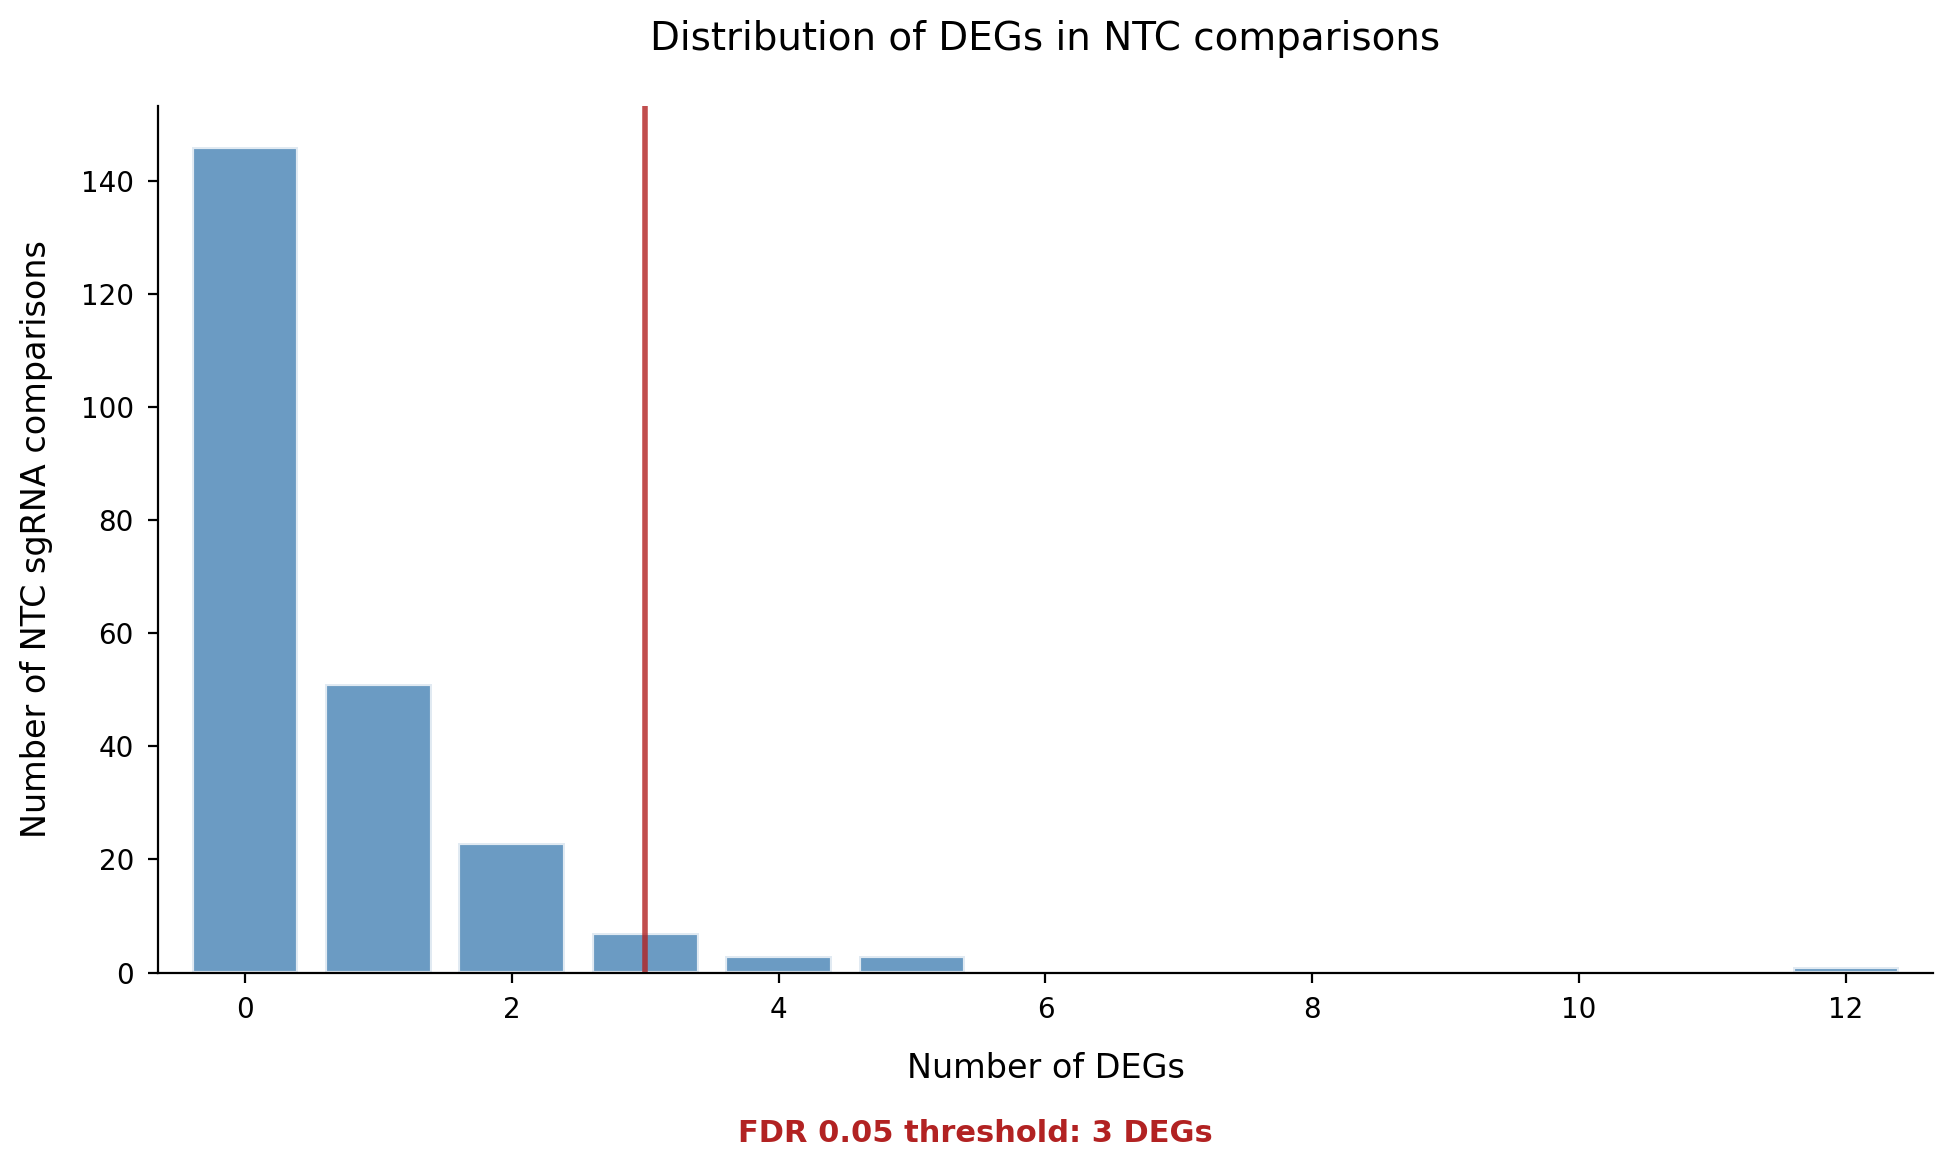

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.7
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [14]:
test_deg_threshold, test_benchmark_res = \
    report_ntc_benchmarking_results(test_ntc_benchmark_res)

In [15]:
test_benchmark_res[test_benchmark_res["n_DEGs"] > 3]

n_DEGs
Non-Targeting_398      12
Non-Targeting_226       5
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_351       4
Non-Targeting_482       4
Non-Targeting_418       4

In [18]:
def ntc_threshold_filtering(adata, deg_threshold, benchmark_df):
    gRNA_to_remove = \
        benchmark_df[benchmark_df["n_DEGs"] > deg_threshold].index.tolist()
    adata_filtered = adata[~(adata.obs.gRNA.isin(gRNA_to_remove))].copy()
    return adata_filtered

In [8]:
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_351", "Non-Targeting_482",
                      "Non-Targeting_418"]

In [9]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [11]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata_benchmarked.write(save_path)

Restart kernel

### Testing on small datasets

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Create small test dataset with 14 perturbing gRNAs and 10 NTC gRNAs

In [14]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} perturbing gRNA to test")
print(gRNA_to_test)

8 KDs to test: NANOG, POU5F1, PHF20, ZNF396, POU3F2, DNMT1, POU5F1B, ZNF521
14 perturbing gRNA to test
['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 'ZNF521_1', 'NANOG_2']


Sample 10 NTC gRNA

In [15]:
NTC_gRNA_value_counts = adata[adata.obs.perturbed == "False"].obs.gRNA.value_counts().reset_index()
NTC_gRNA_value_counts.tail()

gRNA  count
222  Non-Targeting_890     29
223  Non-Targeting_622     29
224  Non-Targeting_421     29
225  Non-Targeting_665     28
226  Non-Targeting_722     26

In [7]:
test_rng = np.random.default_rng(42)
test_ntc_indices = test_rng.choice(len(NTC_gRNA_value_counts)-1, 10)
test_ntc_gRNAs = NTC_gRNA_value_counts.iloc[test_ntc_indices]["gRNA"].tolist()
print(test_ntc_gRNAs)

['Non-Targeting_939', 'Non-Targeting_278', 'Non-Targeting_935', 'Non-Targeting_375', 'Non-Targeting_261', 'Non-Targeting_332', 'Non-Targeting_486', 'Non-Targeting_903', 'Non-Targeting_750', 'Non-Targeting_543']


In [8]:
small_test_adata = adata[(adata.obs.gRNA.isin(test_ntc_gRNAs)) |
                   (adata.obs.gene_target.isin(test_kds))].copy()
small_test_adata

AnnData object with n_obs × n_vars = 1384 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
small_test_counts_df, small_test_metadata_df = \
    create_pseudobulk_dataset(small_test_adata, target_type="gRNA")

In [10]:
small_test_metadata_df.head()

condition  n-cells-in-rep
Non-Targeting-903-rep1       NTC              24
Non-Targeting-903-rep2       NTC              25
PHF20-1-rep1             PHF20-1              23
PHF20-1-rep2             PHF20-1              23
DNMT1-1-rep1             DNMT1-1              25

In [18]:
small_test_de_results_dict = \
    run_dataset_DE(small_test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.68 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 0.85 seconds.

Fitting LFCs...
... done in 0.86 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
def build_n_degs_df(de_results_dict, alpha=0.05):
    n_degs_dict = dict()
    for target in de_results_dict:
        target_df = de_results_dict[target]
        n_degs = len(target_df[target_df["padj"] < alpha])
        n_degs_dict[target] = n_degs
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index",
                                       columns=["n_DEGs"])
    n_degs_df.sort_index(inplace=True)
    return n_degs_df

In [20]:
test_n_degs_df = build_n_degs_df(small_test_de_results_dict)
test_n_degs_df

n_DEGs
DNMT1_1        89
DNMT1_2        77
DNMT1_3        85
NANOG_1        29
NANOG_2       136
PHF20_1       445
POU3F2_2      386
POU5F1B_1     516
POU5F1_1      166
POU5F1_2      229
POU5F1_3      537
ZNF396_1        0
ZNF396_2      284
ZNF521_1      262

Create test dataset with 14 perturbing gRNAs and all 227 NTC gRNAs

In [16]:
test_adata = adata[(adata.obs.gene_target == "NTC") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14052 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [22]:
test_counts_df, test_metadata_df = \
    create_pseudobulk_dataset(test_adata, target_type="gRNA")

In [23]:
test_de_results_dict = \
    run_dataset_DE(test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.23 seconds.

Fitting dispersions...
... done in 2.35 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 1.47 seconds.

Calculating cook's distance...
... done in 0.48 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
test_n_degs_df = build_n_degs_df(test_de_results_dict)
test_n_degs_df

n_DEGs
DNMT1_1       174
DNMT1_2       177
DNMT1_3       175
NANOG_1        98
NANOG_2       236
PHF20_1       766
POU3F2_2      611
POU5F1B_1     973
POU5F1_1      733
POU5F1_2      953
POU5F1_3      864
ZNF396_1        0
ZNF396_2      516
ZNF521_1      552

In [25]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results = psp.de.differential_expression(test_adata_pipeline, plot_degs=False)

Processing perturbations:   0%|          | 0/14 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-11-11 12:41:35 - INFO - Completed differential expression analysis in 135.34 seconds


In [26]:
pipeline_test_n_degs_df = build_n_degs_df(pipeline_de_results)
pipeline_test_n_degs_df

n_DEGs
DNMT1_1       100
DNMT1_2        53
DNMT1_3        70
NANOG_1        58
NANOG_2       201
PHF20_1       378
POU3F2_2      390
POU5F1B_1     515
POU5F1_1      402
POU5F1_2      554
POU5F1_3      495
ZNF396_1        0
ZNF396_2      234
ZNF521_1      396

### Testing chunked DE

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                min_counts_per_gene: int = 0,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Filter lowly expressed genes
    gene_filter = counts_df.sum(axis=0) >= min_counts_per_gene
    counts_df = counts_df.loc[:, gene_filter]

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

def run_dataset_DE_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                layer: str = "counts",
                approx_ntc_rep_size: int = 50,
                random_state: int = 42,
                ntc_target_delimiter: str = "NTC",
                ntc_gRNA_delimiter: str = "Non-Targeting",
                n_cpus: int = 20, alpha: float = 0.05,
                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                suppress_warnings: bool = False):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    """
    # Create pseudobulk dataset
    print("Generating pseudobulk representation of dataset")
    counts_df, metadata_df = \
        create_pseudobulk_dataset_2_reps(
            adata, target_type=target_type, layer=layer,
            approx_ntc_rep_size = approx_ntc_rep_size,
            random_state=random_state,
            ntc_target_delimiter=ntc_target_delimiter,
            ntc_gRNA_delimiter=ntc_gRNA_delimiter
            )
    # Run DE analysis on pseudobulk dataset
    de_results_dict = run_pydeseq2(counts_df, metadata_df,
                    n_cpus=n_cpus, alpha=alpha,
                    shrink_lfcs=shrink_lfcs, 
                    lfc_shrink_adapt=lfc_shrink_adapt,
                    suppress_warnings=suppress_warnings)
    return de_results_dict

In [21]:
test_de_results_2_reps_dict = \
    run_dataset_DE_2_reps(test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset



Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.14 seconds.

Fitting dispersions...
... done in 3.41 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 1.40 seconds.

Fitting LFCs...
... done in 1.30 seconds.

Calculating cook's distance...
... done in 0.40 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
test_n_degs_2_reps_df = build_n_degs_df(test_de_results_2_reps_dict)
test_n_degs_2_reps_df

n_DEGs
DNMT1_1       193
DNMT1_2       203
DNMT1_3       191
NANOG_1        99
NANOG_2       221
PHF20_1       782
POU3F2_2      646
POU5F1B_1    1004
POU5F1_1      787
POU5F1_2      999
POU5F1_3      885
ZNF396_1        0
ZNF396_2      556
ZNF521_1      529

In [11]:
full_counts_df, full_metadata_df = \
    create_pseudobulk_dataset_2_reps(adata, target_type="gRNA")

In [12]:
print(full_metadata_df[~(full_metadata_df["condition"] == "NTC")].shape)
print(full_metadata_df[full_metadata_df["condition"] == "NTC"].shape)

(1972, 2)
(454, 2)


In [124]:
round(1972 / (1500-454))

2

In [ ]:
def run_dataset_DE_chunks(adata: ad.AnnData, target_type: str = "gRNA",
                        max_chunk_size: int = 1000, layer: str = "counts",
                        approx_ntc_rep_size: int = 50,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                        suppress_warnings: bool = False, debug: bool = False,
                        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    if max_chunk_size % 2 != 0:
        raise ValueError("max_chunk_size must be an even number")
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset_2_reps(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of perturbations per chunk
    n_pert_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_pert_samples / (max_chunk_size - n_ntc_samples))
    n_perts = n_pert_samples // 2
    base_size = n_perts // n_chunks
    remainder = n_perts % n_chunks
    n_perts_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)

    # Choose perturbations for each chunk
    rng = np.random.default_rng(random_state)
    if target_type == "gRNA":
        all_perts = adata.obs.perturbation.unique().tolist()
    else:
        all_perts = adata.obs.gene_target.unique().tolist()
    if "NTC" in all_perts:
        all_perts.remove("NTC")
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    pert_indices = np.arange(len(all_perts))
    rng.shuffle(pert_indices)
    chunk_splits = np.cumsum(np.array(n_perts_per_chunk))[:-1]
    chunk_indices = np.split(pert_indices, chunk_splits)
    for i in range(n_chunks):
        chunk_perts = [all_perts[j].replace("_", "-") for j in chunk_indices[i]]
        chunk_meta_df = metadata_df.loc[(metadata_df["condition"].isin(chunk_perts))
                                        | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results_dict = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                        n_cpus=n_cpus, alpha=alpha,
                        shrink_lfcs=shrink_lfcs, 
                        lfc_shrink_adapt=lfc_shrink_adapt,
                        suppress_warnings=suppress_warnings)
        de_results_dict.update(chunk_results_dict)
    return de_results_dict

Testing - see how long 1 chunk takes

4 chunks

In [ ]:
# 21 min per chunk, 4 chunks
test_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1000, debug=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 444.74 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 51.93 seconds.

Fitting LFCs...
... done in 48.98 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

In [107]:
list(test_chunks_DE_res_dict.keys())[:5]

['ZNF14_1', 'OSR2_3', 'DUXA_3', 'POU3F3_3', 'YBX1_2']

In [12]:
def build_n_degs_df(de_results_dict, alpha=0.05):
    n_degs_dict = dict()
    for target in de_results_dict:
        target_df = de_results_dict[target]
        n_degs = len(target_df[target_df["padj"] < alpha])
        n_degs_dict[target] = n_degs
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index",
                                       columns=["n_DEGs"])
    n_degs_df.sort_index(inplace=True)
    return n_degs_df

In [109]:
test_chunk1_df = build_n_degs_df(test_chunks_DE_res_dict)

In [ ]:
len(test_chunk1_df)

247

In [116]:
test_chunk1_df.loc[test_chunk1_df["n_DEGs"] >= 3]

n_DEGs
ADNP2_3        3
BBX_3          5
CHAMP1_3       9
CREB1_2       12
DLX4_3        84
...          ...
ZNF576_1       3
ZNF677_2       4
ZNF688_3       3
ZNF699_3       4
ZNF799_1       3

[62 rows x 1 columns]

In [12]:
62/247

0.25101214574898784

3 chunks

In [ ]:
# 56 min per chunk, 3 chunks
test_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1200, debug=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 1375.53 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 88.52 seconds.

Fitting LFCs...
... done in 92.04 seconds.

Calculating cook's distance...
... done in 0.84 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

In [8]:
test_chunk1of3_df = build_n_degs_df(test_chunks_DE_res_dict)

In [ ]:
# Total number of gRNA
len(test_chunk1of3_df)

328

In [21]:
# gRNA with >0 DEGs
len(test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] > 0])

169

In [22]:
# gRNA with >=3 DEGs
len(test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3])

89

In [ ]:
test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3].sort_values(by="n_DEGs")

n_DEGs
ZBTB26_1         3
ZNF561_3         3
GATAD2B_1        3
ZHX3_1           3
GTF2IRD2_1       3
...            ...
E2F4_3         109
SETDB1_1       145
DNMT1_1        215
DNMT1_2        220
ZNF521_1       580

[89 rows x 1 columns]

In [ ]:
test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3].sort_values(by="n_DEGs").tail(20)

n_DEGs
SP1_3         24
RLF_3         29
DR1_3         34
ZNF408_2      35
LIN28B_3      37
ZNF732_2      38
MTERF3_3      42
ZBTB41_1      48
PKNOX2_2      53
GATA5_1       54
SETDB1_3      56
JUNB_3        61
POU3F3_3      81
GTF3A_1       83
DLX4_3        87
E2F4_3       109
SETDB1_1     145
DNMT1_1      215
DNMT1_2      220
ZNF521_1     580

In [ ]:
# Percent of gRNA with >= 3 DEGs
89/328

0.27134146341463417

In [ ]:
# Percent of gRNA with >0 DEGs
169/328

0.5152439024390244

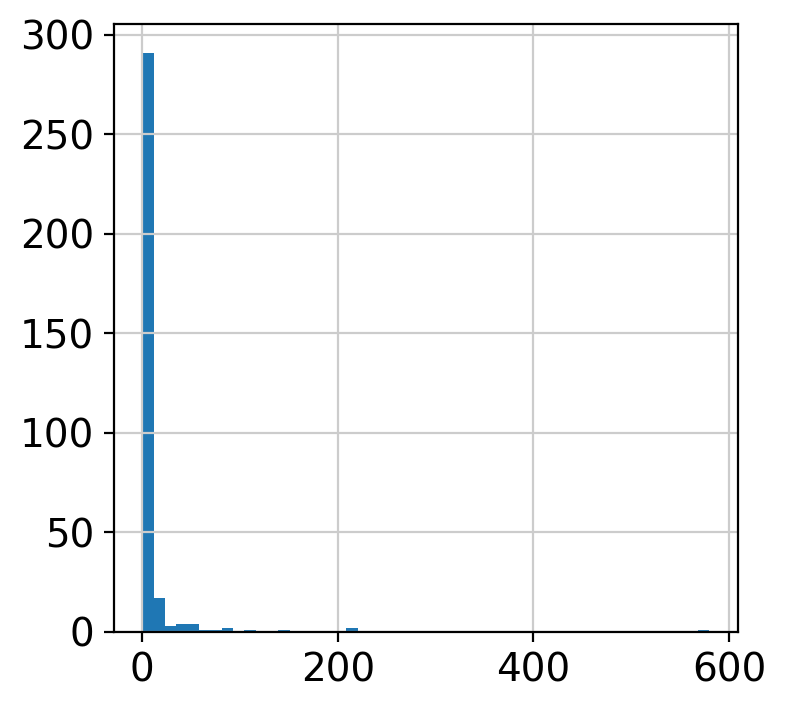

In [17]:
import matplotlib.pyplot as plt

p = plt.hist(test_chunk1of3_df, bins=50)

In [15]:
print(21*4) #~1.5 hrs
print(56*3) #~2.75 hrs

84
168


2 chunks

In [ ]:
# Ran this cell for 43 min, was still fitting dispersions
test_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1500)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.49 seconds.

Fitting dispersions...


KeyboardInterrupt: 

### DE analysis in 4 chunks

In [ ]:
# 94 min for 4 chunks and 60 CPUs
test_4_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=60, 
                          max_chunk_size=1000)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 428.55 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 51.81 seconds.

Fitting LFCs...
... done in 42.00 seconds.

Calculating cook's distance...
... done in 0.69 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 855.68 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 37.03 seconds.

Fitting LFCs...
... done in 40.72 seconds.

Calculating cook's distance...
... done in 0.69 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 884.02 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 49.22 seconds.

Fitting LFCs...
... done in 41.97 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 455.06 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 38.74 seconds.

Fitting LFCs...
... done in 41.94 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

In [ ]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [8]:
len(list(test_4_chunks_DE_res_dict.keys()))

986

In [9]:
test_4_chunks_DE_res_df = \
    build_DE_df(test_4_chunks_DE_res_dict)

In [10]:
test_4_chunks_DE_res_df.head()

ZNF14_1_baseMean  ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  \
A1BG               3.496334               -0.056857       0.491782   
A1BG-AS1           0.522056               -1.783689       2.391602   
A2M                0.458251               -0.067035       1.589635   
A2ML1              1.592228               -1.186808       1.042859   
A2ML1-AS1          4.728207               -0.146154       0.444956   

           ZNF14_1_stat  ZNF14_1_pvalue  ZNF14_1_padj  OSR2_3_baseMean  \
A1BG          -0.115614        0.907959      0.999304         3.496334   
A1BG-AS1      -0.745814        0.455780      0.999304         0.522056   
A2M           -0.042170        0.966363      0.999304         0.458251   
A2ML1         -1.138033        0.255107      0.999304         1.592228   
A2ML1-AS1     -0.328467        0.742558      0.999304         4.728207   

           OSR2_3_log2FoldChange  OSR2_3_lfcSE  OSR2_3_stat  ...  \
A1BG                   -0.386033      0.523117    -0.737947  ...   
A1BG-AS1               -1.847375      2.395985    -0.771029  ...   
A2M                     0.851742      1.232036     0.691329  ...   
A2ML1                  -0.122598      0.684507    -0.179104  ...   
A2ML1-AS1               0.222708      0.375473     0.593139  ...   

           ZNF805_1_lfcSE  ZNF805_1_stat  ZNF805_1_pvalue  ZNF805_1_padj  \
A1BG             0.554476       0.752335         0.451850       0.993675   
A1BG-AS1         1.051058       1.119937         0.262740       0.993675   
A2M              1.491225       0.338591         0.734918       0.993675   
A2ML1            1.034079      -0.013544         0.989194       0.998936   
A2ML1-AS1        0.553933       0.146737         0.883339       0.998882   

           MYNN_2_baseMean  MYNN_2_log2FoldChange  MYNN_2_lfcSE  MYNN_2_stat  \
A1BG              3.507130              -0.099542      0.596679    -0.166827   
A1BG-AS1          0.535224              -0.029058      1.459428    -0.019910   
A2M               0.454406               1.288609      1.082204     1.190727   
A2ML1             1.625839              -2.831136      2.379265    -1.189921   
A2ML1-AS1         4.630044              -0.445464      0.596228    -0.747136   

           MYNN_2_pvalue  MYNN_2_padj  
A1BG            0.867506     0.999812  
A1BG-AS1        0.984115     0.999812  
A2M             0.233761     0.999812  
A2ML1           0.234078     0.999812  
A2ML1-AS1       0.454981     0.999812  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
test_4_chunks_DE_res_df.to_pickle(filepath_pkl)

In [13]:
test_4_chunks_n_degs_df = \
    build_n_degs_df(test_4_chunks_DE_res_dict)

In [15]:
test_4_chunks_n_degs_df.loc[test_4_chunks_n_degs_df["n_DEGs"] >= 3]

n_DEGs
ADNP2_3         3
ARID2_1         3
ARID2_2         7
ARID2_3         8
ARID3B_3       16
...           ...
ZNF799_1        3
ZNF804A_3      11
ZNF804B_3       5
ZNF92_1         3
ZXDC_3          6

[283 rows x 1 columns]

In [16]:
test_4_chunks_n_degs_df.loc[test_4_chunks_n_degs_df["n_DEGs"] > 0]

n_DEGs
ADNP2_1         1
ADNP2_2         2
ADNP2_3         3
AHR_2           1
ANKZF1_3        1
...           ...
ZSCAN23_2       1
ZSCAN23_3       2
ZSCAN4_1        1
ZSCAN5B_2       1
ZXDC_3          6

[540 rows x 1 columns]

In [17]:
print(283/986)
print(540/986)

0.2870182555780933
0.5476673427991886


Restart kernel

In [32]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df = pd.read_pickle(filepath_pkl)
chunk_DE_res_df.head()

ZNF14_1_baseMean  ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  \
A1BG               3.496334               -0.056857       0.491782   
A1BG-AS1           0.522056               -1.783689       2.391602   
A2M                0.458251               -0.067035       1.589635   
A2ML1              1.592228               -1.186808       1.042859   
A2ML1-AS1          4.728207               -0.146154       0.444956   

           ZNF14_1_stat  ZNF14_1_pvalue  ZNF14_1_padj  OSR2_3_baseMean  \
A1BG          -0.115614        0.907959      0.999304         3.496334   
A1BG-AS1      -0.745814        0.455780      0.999304         0.522056   
A2M           -0.042170        0.966363      0.999304         0.458251   
A2ML1         -1.138033        0.255107      0.999304         1.592228   
A2ML1-AS1     -0.328467        0.742558      0.999304         4.728207   

           OSR2_3_log2FoldChange  OSR2_3_lfcSE  OSR2_3_stat  ...  \
A1BG                   -0.386033      0.523117    -0.737947  ...   
A1BG-AS1               -1.847375      2.395985    -0.771029  ...   
A2M                     0.851742      1.232036     0.691329  ...   
A2ML1                  -0.122598      0.684507    -0.179104  ...   
A2ML1-AS1               0.222708      0.375473     0.593139  ...   

           ZNF805_1_lfcSE  ZNF805_1_stat  ZNF805_1_pvalue  ZNF805_1_padj  \
A1BG             0.554476       0.752335         0.451850       0.993675   
A1BG-AS1         1.051058       1.119937         0.262740       0.993675   
A2M              1.491225       0.338591         0.734918       0.993675   
A2ML1            1.034079      -0.013544         0.989194       0.998936   
A2ML1-AS1        0.553933       0.146737         0.883339       0.998882   

           MYNN_2_baseMean  MYNN_2_log2FoldChange  MYNN_2_lfcSE  MYNN_2_stat  \
A1BG              3.507130              -0.099542      0.596679    -0.166827   
A1BG-AS1          0.535224              -0.029058      1.459428    -0.019910   
A2M               0.454406               1.288609      1.082204     1.190727   
A2ML1             1.625839              -2.831136      2.379265    -1.189921   
A2ML1-AS1         4.630044              -0.445464      0.596228    -0.747136   

           MYNN_2_pvalue  MYNN_2_padj  
A1BG            0.867506     0.999812  
A1BG-AS1        0.984115     0.999812  
A2M             0.233761     0.999812  
A2ML1           0.234078     0.999812  
A2ML1-AS1       0.454981     0.999812  

[5 rows x 5916 columns]

Rename columns containing 'NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', or 'NKX3-1_3'

In [ ]:
gRNA_wrong_names = ['NKX2_4_1', 'NKX6_2_3', 'NKX6_1_2', 'NKX3_1_3']
gRNA_correct_names = ['NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', 'NKX3-1_3']
wrong_cols = [(f"{g}_baseMean", f"{g}_log2FoldChange", f"{g}_lfcSE", 
               f"{g}_stat", f"{g}_pvalue", f"{g}_padj") for g in gRNA_wrong_names]
wrong_cols = [tup[i] for tup in wrong_cols for i in range(len(tup))]
correct_cols = [(f"{g}_baseMean", f"{g}_log2FoldChange", f"{g}_lfcSE", 
               f"{g}_stat", f"{g}_pvalue", f"{g}_padj") for g in gRNA_correct_names]
correct_cols = [tup[i] for tup in correct_cols for i in range(len(tup))]
rename_cols = {wrong_cols[i]: correct_cols[i] for i in range(len(wrong_cols))}

{'NKX2_4_1_baseMean': 'NKX2-4_1_baseMean', 'NKX2_4_1_log2FoldChange': 'NKX2-4_1_log2FoldChange', 'NKX2_4_1_lfcSE': 'NKX2-4_1_lfcSE', 'NKX2_4_1_stat': 'NKX2-4_1_stat', 'NKX2_4_1_pvalue': 'NKX2-4_1_pvalue', 'NKX2_4_1_padj': 'NKX2-4_1_padj', 'NKX6_2_3_baseMean': 'NKX6-2_3_baseMean', 'NKX6_2_3_log2FoldChange': 'NKX6-2_3_log2FoldChange', 'NKX6_2_3_lfcSE': 'NKX6-2_3_lfcSE', 'NKX6_2_3_stat': 'NKX6-2_3_stat', 'NKX6_2_3_pvalue': 'NKX6-2_3_pvalue', 'NKX6_2_3_padj': 'NKX6-2_3_padj', 'NKX6_1_2_baseMean': 'NKX6-1_2_baseMean', 'NKX6_1_2_log2FoldChange': 'NKX6-1_2_log2FoldChange', 'NKX6_1_2_lfcSE': 'NKX6-1_2_lfcSE', 'NKX6_1_2_stat': 'NKX6-1_2_stat', 'NKX6_1_2_pvalue': 'NKX6-1_2_pvalue', 'NKX6_1_2_padj': 'NKX6-1_2_padj', 'NKX3_1_3_baseMean': 'NKX3-1_3_baseMean', 'NKX3_1_3_log2FoldChange': 'NKX3-1_3_log2FoldChange', 'NKX3_1_3_lfcSE': 'NKX3-1_3_lfcSE', 'NKX3_1_3_stat': 'NKX3-1_3_stat', 'NKX3_1_3_pvalue': 'NKX3-1_3_pvalue', 'NKX3_1_3_padj': 'NKX3-1_3_padj'}


In [56]:
chunk_DE_res_df = chunk_DE_res_df.rename(columns=rename_cols)

In [43]:
gRNA = adata.obs.perturbation.unique().tolist()
has_hyphens = [g for g in gRNA if "-" in g]
print(has_hyphens)

['NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', 'NKX3-1_3']


In [46]:
print("NKX2_4_1_padj" in chunk_DE_res_df.columns)

True


In [58]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df.to_pickle(filepath_pkl)

### Compare to old DE code (individual DE, 1 run per gRNA, no overlaps)

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation
    streams = de_rng.spawn(len(perturbations))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations, streams))
    
    results_dict = dict(zip(perturbations, results))
    return results_dict

def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [7]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [5]:
individual_DE_results_dict = \
    differential_expression(adata, n_cpus=60)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: Th

In [7]:
individual_DE_results_df = \
    build_DE_df(individual_DE_results_dict)

In [8]:
individual_DE_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              8.485499              -0.119356      0.596995    -0.199929   
A1BG-AS1          1.185938              -1.553294      1.669547    -0.930369   
A2M               0.897699               3.206850      2.431359     1.318954   
A2ML1             2.622566               0.153965      1.028798     0.149655   
A2ML1-AS1        12.562553              -0.204420      0.485794    -0.420796   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.841536     0.999886          2.210970   
A1BG-AS1        0.352180     0.999886          0.521868   
A2M             0.187185     0.999886          0.326461   
A2ML1           0.881037     0.999886          0.996873   
A2ML1-AS1       0.673904     0.999886          3.399539   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.668174       1.182508      0.565048  ...   
A1BG-AS1                -2.632537       2.347140     -1.121593  ...   
A2M                     -0.189915       2.442494     -0.077754  ...   
A2ML1                   -1.183046       1.468561     -0.805582  ...   
A2ML1-AS1               -0.040420       1.068184     -0.037840  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.446993      0.609317        0.542314      0.996282   
A1BG-AS1        2.551740      0.261024        0.794074      0.996282   
A2M             2.569250      1.160049        0.246029      0.996282   
A2ML1           2.280193     -0.059063        0.952902      0.996973   
A2ML1-AS1       0.920695     -0.360830        0.718227      0.996282   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.307094                 -0.058788         3.306508   
A1BG-AS1             0.475201                  2.384618         2.907860   
A2M                  0.342046                 -1.956681         3.347521   
A2ML1                0.485676                  0.854366         2.636721   
A2ML1-AS1            2.244037                 -0.484645         1.300201   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.017780          0.985815        0.999155  
A1BG-AS1         0.820060          0.412182        0.999155  
A2M             -0.584517          0.558873        0.999155  
A2ML1            0.324026          0.745918        0.999155  
A2ML1-AS1       -0.372746          0.709337        0.999155  

[5 rows x 5916 columns]

In [21]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_11-12-25.pkl"
individual_DE_results_df.to_pickle(filepath_pkl)

In [4]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [29]:
individual_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_results_df, adata)

In [30]:
individual_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       0
ADNP2_3      154       0
AHR_2         83       0
ALX4_2        67       0

In [112]:
len(individual_n_cells_degs_df[individual_n_cells_degs_df["n_DEGs"] > 0])

104

In [113]:
104/968

0.10743801652892562

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_n_degs_vs_n_cells(n_cells_degs_df, min_n_degs=None, target_type="gRNA", 
                           title=None, figsize=(4,4), ylim: tuple = None, 
                           color="royalblue"):
    plt.figure(figsize=figsize)
    if min_n_degs:
        n_cells_degs_df = \
            n_cells_degs_df.loc[n_cells_degs_df["n_DEGs"] >= min_n_degs]
    plt.scatter(x=n_cells_degs_df["n_cells"], y=n_cells_degs_df["n_DEGs"],
                    s=5, c=color)
    plt.xlabel(f"# cells per {target_type}")
    plt.ylabel(f"# DEGs per {target_type}")
    plt.grid(visible=False)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.show()

def plot_n_degs_histogram(n_cells_degs_df, title=None, binwidth=2, figsize=(4,2), 
                          ylim: tuple = None, color="royalblue"):
    plt.figure(figsize=figsize)
    sns.histplot(data=n_cells_degs_df["n_DEGs"], binwidth=binwidth, color=color)
    plt.xlabel("# DEGs")
    plt.ylabel("Count")
    plt.grid(visible=False)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.show()

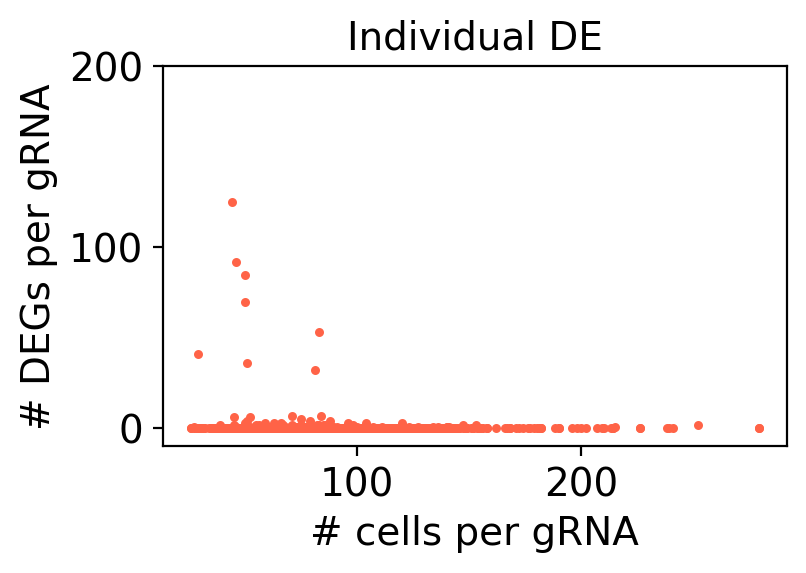

In [182]:
plot_n_degs_vs_n_cells(individual_n_cells_degs_df, figsize=(4,2.5), 
                       title="Individual DE", color="tomato",
                       ylim=(-10, 200))

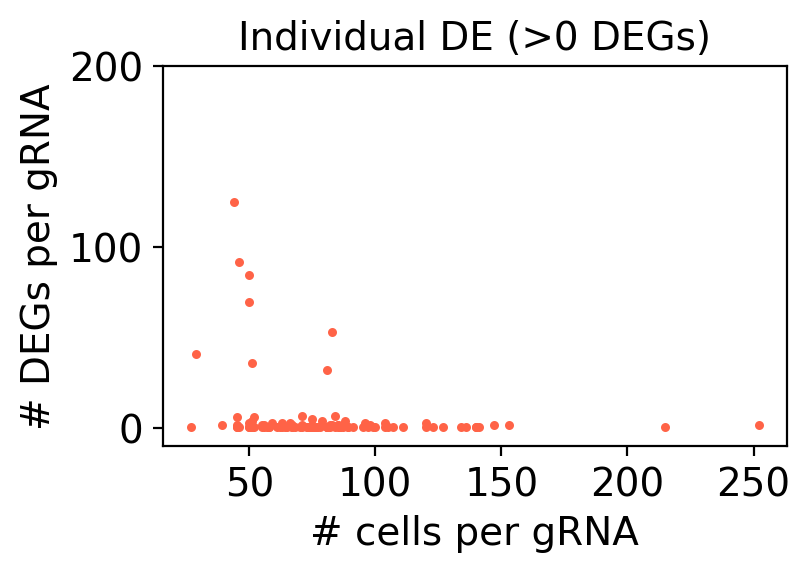

In [191]:
plot_n_degs_vs_n_cells(individual_n_cells_degs_df, min_n_degs=1,
                       title="Individual DE (>0 DEGs)", color="tomato",
                       ylim=(-10, 200), figsize=(4,2.5))

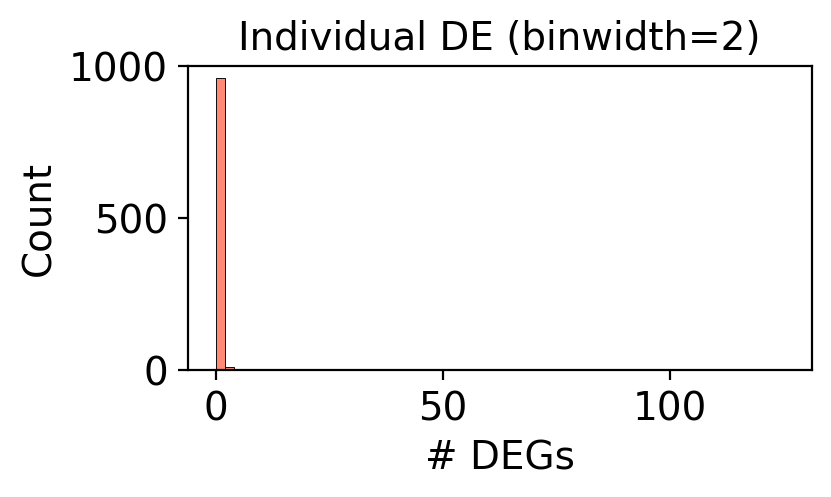

In [172]:
plot_n_degs_histogram(individual_n_cells_degs_df, figsize=(4,2), ylim=(0,1000),
                      title="Individual DE (binwidth=2)",
                      color="tomato", binwidth=2)

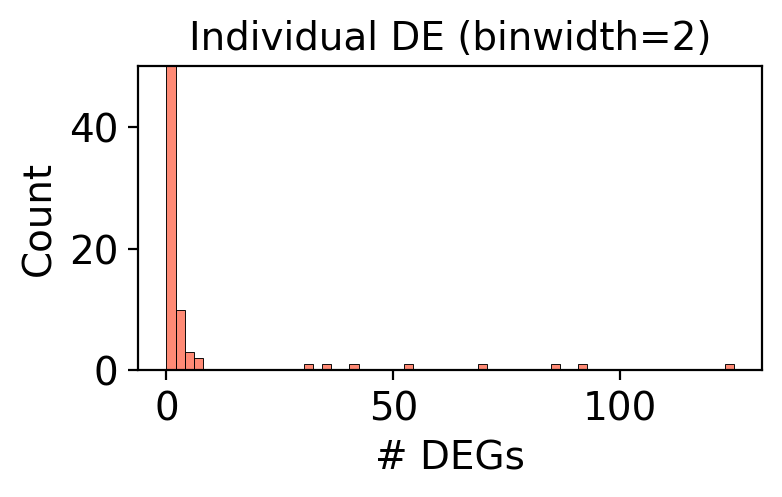

In [157]:
plot_n_degs_histogram(individual_n_cells_degs_df, title="Individual DE (binwidth=2)",
                      color="tomato", ylim=(0, 50), binwidth=2)

Compare to combined DE method results

In [5]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df = pd.read_pickle(filepath_pkl)

In [8]:
chunk_DE_n_cells_degs_df = \
    build_n_cells_degs_df(chunk_DE_res_df, adata, alpha=0.05)
chunk_DE_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       2
ADNP2_3      154       3
AHR_2         83       1
ALX4_2        67       0

In [9]:
chunk_DE_n_cells_degs_df.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gRNA                      
POU5F1_2        29    1072
POU5F1B_1       44    1054
POU5F1_3        50     948
PHF20_1         46     848
POU5F1_1        27     841
POU3F2_2        50     701
ZNF396_2        51     601
ZNF521_1        83     578
NANOG_2         81     245
PURG_3          63     238

In [33]:
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] == 0]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] > 0]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] >= 10]))

446
540
283
131


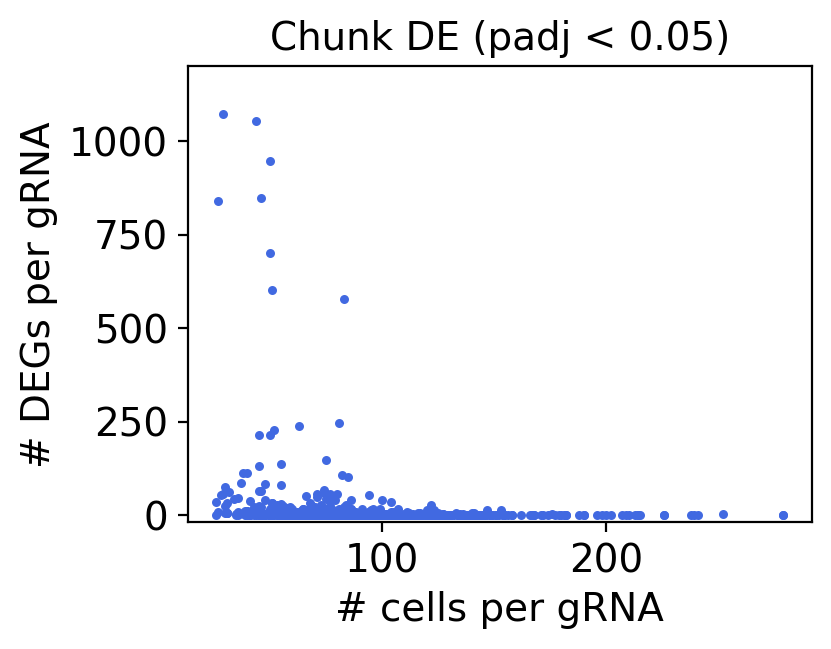

In [16]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, title="Chunk DE (padj < 0.05)", 
                       ylim=(-20, 1200), figsize=(4,3))

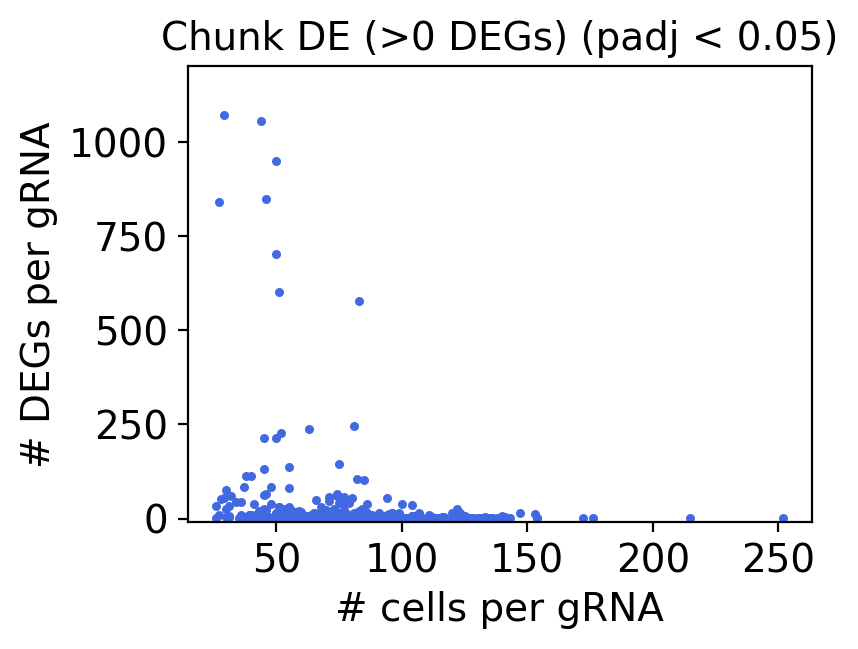

In [17]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, min_n_degs=1,
                       title="Chunk DE (>0 DEGs) (padj < 0.05)",
                       ylim=(-10, 1200), figsize=(4,3))

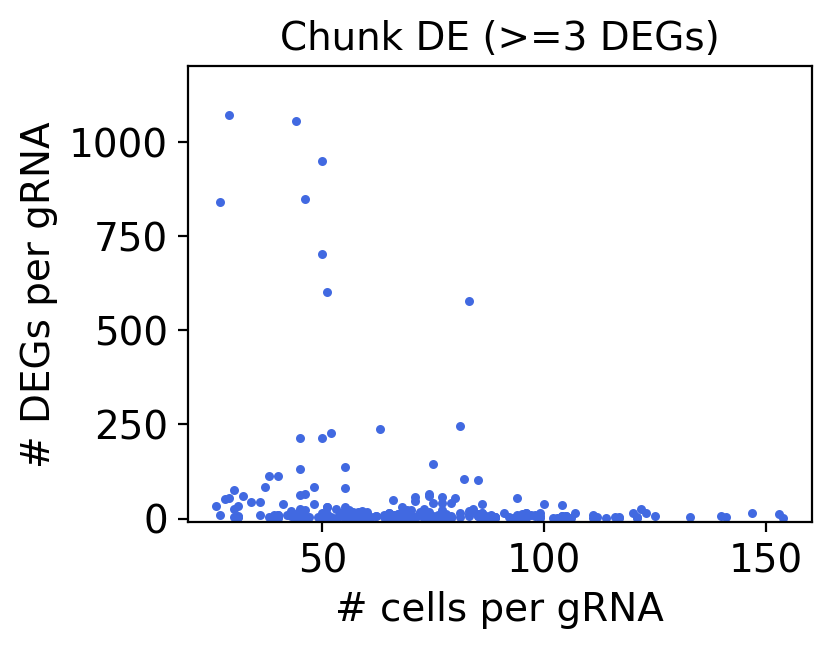

In [200]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, min_n_degs=3,
                       title="Chunk DE (>=3 DEGs)",
                       ylim=(-10, 1200), figsize=(4,3))

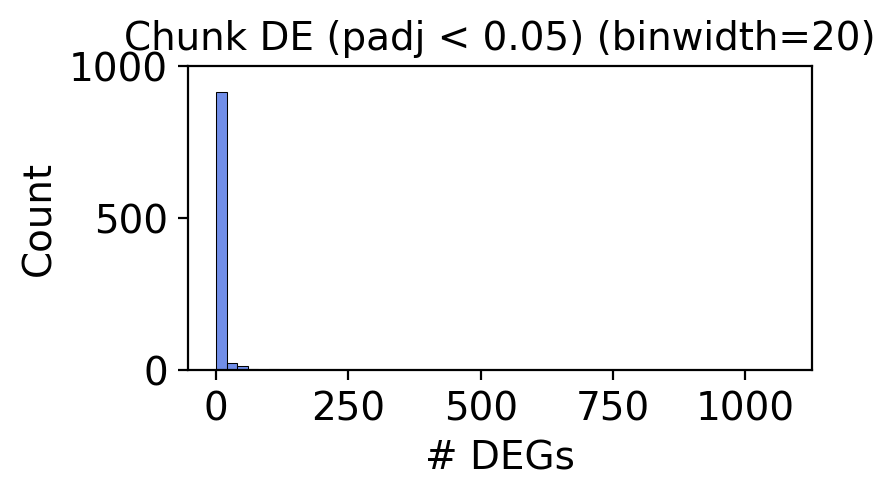

In [18]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df, figsize=(4,2), ylim=(0,1000),
                      title="Chunk DE (padj < 0.05) (binwidth=20)", binwidth=20)

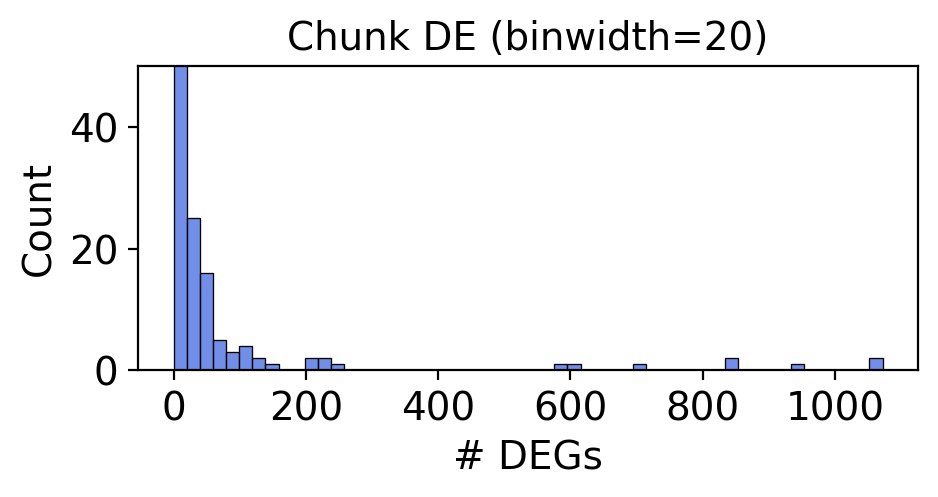

In [168]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df, figsize=(5,2),
                      binwidth=20, title="Chunk DE (binwidth=20)", ylim=(0, 50))

In [10]:
chunk_DE_n_cells_degs_df_10 = \
    build_n_cells_degs_df(chunk_DE_res_df, adata, alpha=0.1)
chunk_DE_n_cells_degs_df_10.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       3
ADNP2_3      154       9
AHR_2         83       2
ALX4_2        67       0

In [29]:
chunk_DE_n_cells_degs_df_10.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gRNA                      
POU5F1_2        29    1350
POU5F1B_1       44    1319
POU5F1_3        50    1174
PHF20_1         46    1094
POU5F1_1        27    1075
POU3F2_2        50     950
ZNF396_2        51     768
ZNF521_1        83     756
NANOG_2         81     322
PURG_3          63     303

In [39]:
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] == 0]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] < 20]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] > 0]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] >= 3]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] >= 10]))

315
884
671
422
182


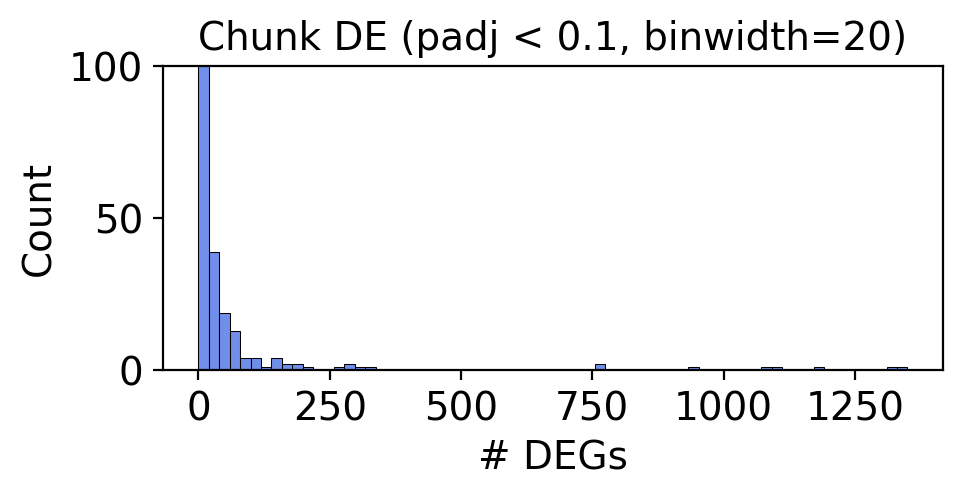

In [44]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df_10, figsize=(5,2),
                      binwidth=20, title="Chunk DE (padj < 0.1, binwidth=20)", ylim=(0, 100))

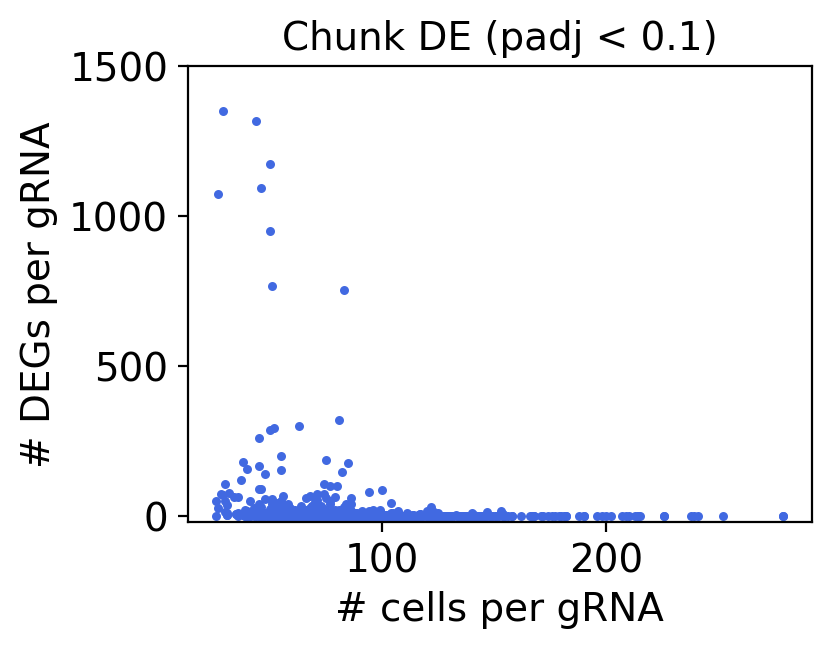

In [51]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df_10, title="Chunk DE (padj < 0.1)", 
                       ylim=(-20, 1500), figsize=(4,3))

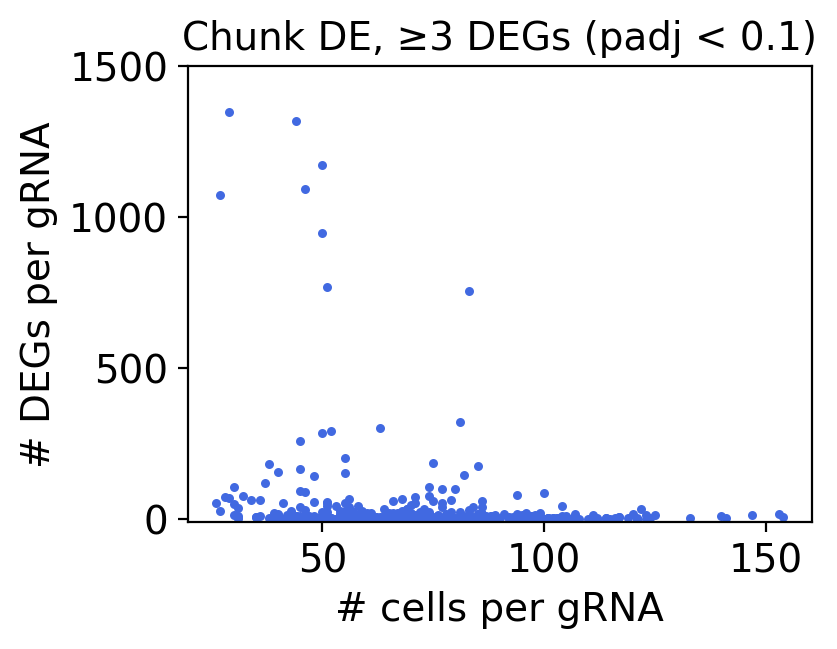

In [14]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df_10, min_n_degs=3,
                       title="Chunk DE, ≥3 DEGs (padj < 0.1)",
                       ylim=(-10, 1500), figsize=(4,3))

### Compare to old method, 5 runs per gRNA, 2-3 reps, no overlap

In [2]:
# Old DE functions - individual DE, 5 runs, no overlaps
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc
from scipy.stats import false_discovery_control
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
import warnings


def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

In [55]:
from tqdm import tqdm

def build_multi_DE_run_df(de_results_dict):

    def build_multi_DE_run_single_target_df(target: str,
                                        pvalue_col: str = "pvalue",
                                        lfc_col: str = "log2FoldChange",
                                        run_delimiter: str = "-run"):
        """
        Given a perturbation and DE results for that perturbation across
        multiple runs, combine the p-values via Cauchy Combination Test and
        perform multiple testing correction via BH method.
        """
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            target_runs = [run for run in de_results_dict 
                        if run.startswith(f"{target + run_delimiter}")]
            n_runs = len(target_runs)
            genes = de_results_dict[target_runs[0]].index
            pval_dict = dict()
            lfc_array = np.zeros((len(genes), n_runs))

            # Check that all run DFs have same index; if not, sort later
            sort_genes = False
            for run in target_runs[1:]:
                if not de_results_dict[run].index.equals(genes):
                    sort_genes = True
                    print("DE run results do not all have same index")
            
            # Get p-values and LFCs from each run
            for i in range(n_runs):
                run_df = de_results_dict[target + run_delimiter + str(i+1)]
                if sort_genes:
                    run_df = run_df.sort_index()
                lfc_array[:, i] = run_df[lfc_col].values
                pval_dict[f"run{i+1}_pvalue"] = run_df[pvalue_col]
            median_lfcs = np.nanmedian(lfc_array, axis=1)

            # Combine p-values
            pval_df = pd.DataFrame.from_dict({"Gene": genes} | pval_dict)
            pval_df.set_index("Gene", inplace=True)
            pval_df.index.rename("", inplace=True)
            combined_pvals = list()
            for i in range(len(pval_df)): # Loop through rows
                combined_pvals.append(
                    metacp.cauchy_method(pval_df.iloc[i].values, 
                                         data_type="pvals"))
            multi_run_df = \
                pd.DataFrame.from_dict({"Gene": genes, "median_LFC": median_lfcs,
                                        "combined_pvalue": combined_pvals})
            multi_run_df.set_index("Gene", inplace=True)
            multi_run_df.index.rename("", inplace=True)
            
            # Compute false discovery rates
            nan_mask = multi_run_df["combined_pvalue"].notna()
            fdrs = \
                false_discovery_control(multi_run_df.loc[nan_mask, "combined_pvalue"], 
                                        method="bh")
            multi_run_df["combined_padj"] = np.nan
            multi_run_df.loc[nan_mask, "combined_padj"] = fdrs

            del pval_df, pval_dict, lfc_array, combined_pvals, fdrs, genes
            gc.collect()
            return multi_run_df
    
    # For each target, create combined DF of all runs
    targets = {k.split("-run")[0] for k in de_results_dict.keys()}
    targets = list(targets)
    multi_run_dfs = list()
    for i in tqdm(range(len(targets))):
        multi_run_df = \
            build_multi_DE_run_single_target_df(targets[i])
        multi_run_dfs.append(multi_run_df)
    # Concatenate all DFs
    df_list = list()
    for target, df in zip(targets, multi_run_dfs):
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
# 89.5 minutes
individual_DE_5_runs_results_dict = \
    differential_expression_multiple_runs(adata, n_cpus=60)

Running DE analysis:   0%|          | 0/4930 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

In [56]:
individual_DE_5_runs_df = build_multi_DE_run_df(individual_DE_5_runs_results_dict)

100%|██████████| 986/986 [13:13<00:00,  1.24it/s]


In [57]:
individual_DE_5_runs_df.head()

HES6_3_median_LFC  HES6_3_combined_pvalue  HES6_3_combined_padj  \
                                                                             
A1BG                0.946759                0.350831              0.998432   
A1BG-AS1           -1.092137                     NaN                   NaN   
A2M                 0.812283                0.742738              0.998432   
A2ML1               0.696351                0.381449              0.998432   
A2ML1-AS1          -0.817883                0.552870              0.998432   

           OSR2_3_median_LFC  OSR2_3_combined_pvalue  OSR2_3_combined_padj  \
                                                                             
A1BG               -0.461103                0.862489              0.999879   
A1BG-AS1           -2.104965                     NaN                   NaN   
A2M                 1.559681                0.771625              0.999879   
A2ML1               0.086733                0.955407              0.999879   
A2ML1-AS1          -0.137995                0.860836              0.999879   

           ZNF219_2_median_LFC  ZNF219_2_combined_pvalue  \
                                                           
A1BG                 -0.271500                  0.752641   
A1BG-AS1             -0.159122                  0.880632   
A2M                   2.595526                  0.378480   
A2ML1                 0.045239                  0.931435   
A2ML1-AS1             0.053575                  0.861405   

           ZNF219_2_combined_padj  RXRB_1_median_LFC  ...  \
                                                      ...   
A1BG                     0.999778          -0.597591  ...   
A1BG-AS1                 0.999778          -1.289549  ...   
A2M                      0.999778          -1.798849  ...   
A2ML1                    0.999778          -1.156036  ...   
A2ML1-AS1                0.999778          -0.339235  ...   

           HMBOX1_3_combined_padj  TFAP2E_2_median_LFC  \
                                                         
A1BG                     0.999115             0.031494   
A1BG-AS1                 0.999115            -0.093563   
A2M                      0.999115             1.301089   
A2ML1                    0.999115             0.822091   
A2ML1-AS1                0.999115             0.991316   

           TFAP2E_2_combined_pvalue  TFAP2E_2_combined_padj  \
                                                              
A1BG                       0.951224                0.999967   
A1BG-AS1                   0.948779                0.999967   
A2M                        0.866952                0.999967   
A2ML1                      0.835731                0.999967   
A2ML1-AS1                  0.715328                0.999967   

           ZNF473_2_median_LFC  ZNF473_2_combined_pvalue  \
                                                           
A1BG                 -0.546658                  0.830748   
A1BG-AS1             -1.135532                  0.802517   
A2M                   0.746905                  0.884704   
A2ML1                 0.771099                  0.468055   
A2ML1-AS1             0.352796                  0.662645   

           ZNF473_2_combined_padj  CENPX_1_median_LFC  \
                                                        
A1BG                     0.999728            0.157732   
A1BG-AS1                 0.999728           -0.193212   
A2M                      0.999728            2.487111   
A2ML1                    0.999728           -1.694081   
A2ML1-AS1                0.999728           -0.190269   

           CENPX_1_combined_pvalue  CENPX_1_combined_padj  
                                                           
A1BG                      0.828469               0.999677  
A1BG-AS1                  0.878672               0.999677  
A2M                       0.428431               0.999677  
A2ML1                     0.413489               0.999677  
A2ML1-AS1                 0.888936    

In [59]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_5runs_11-12-25.pkl"
individual_DE_5_runs_df.to_pickle(filepath_pkl)

In [19]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_5runs_11-12-25.pkl"
individual_DE_5_runs_df = pd.read_pickle(filepath_pkl)

In [20]:
individual_DE_5_runs_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_5_runs_df, adata,
        padj_col="combined_padj", alpha=0.05)

In [21]:
individual_DE_5_runs_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       1
ADNP2_3      154       0
AHR_2         83       0
ALX4_2        67       0

In [34]:
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] == 0]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] > 0]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] >= 10]))

865
121
27
11


In [24]:
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] == 0]))

865


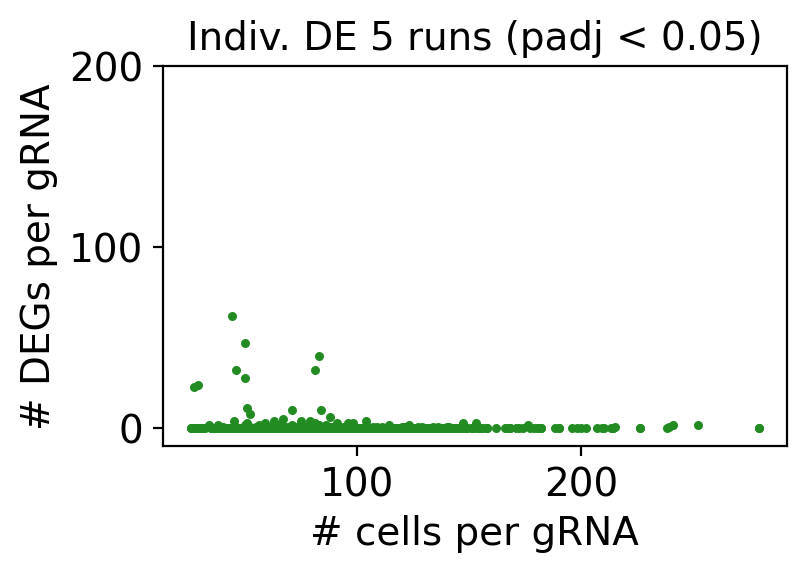

In [23]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df, figsize=(4,2.5), 
                       title="Indiv. DE 5 runs (padj < 0.05)", color="forestgreen",
                       ylim=(-10, 200))

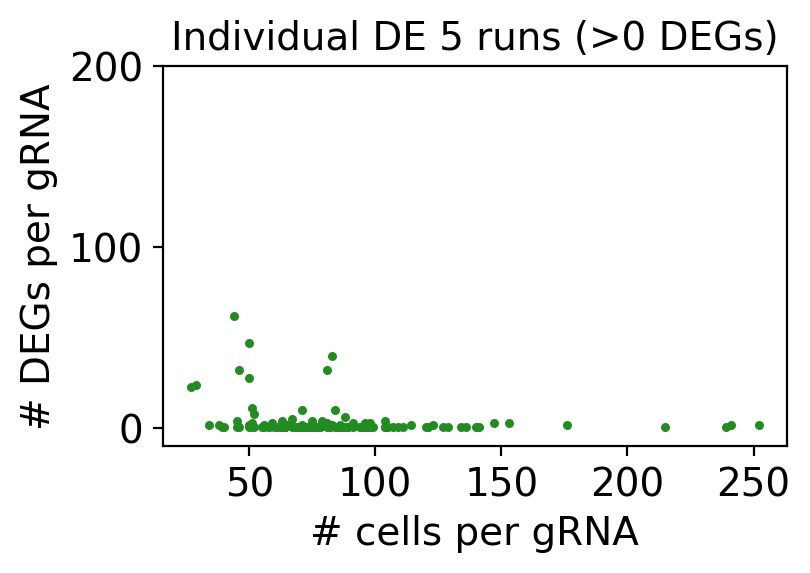

In [70]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df, 
                       min_n_degs=1,
                       title="Individual DE 5 runs (>0 DEGs)", color="forestgreen",
                       ylim=(-10, 200), figsize=(4,2.5))

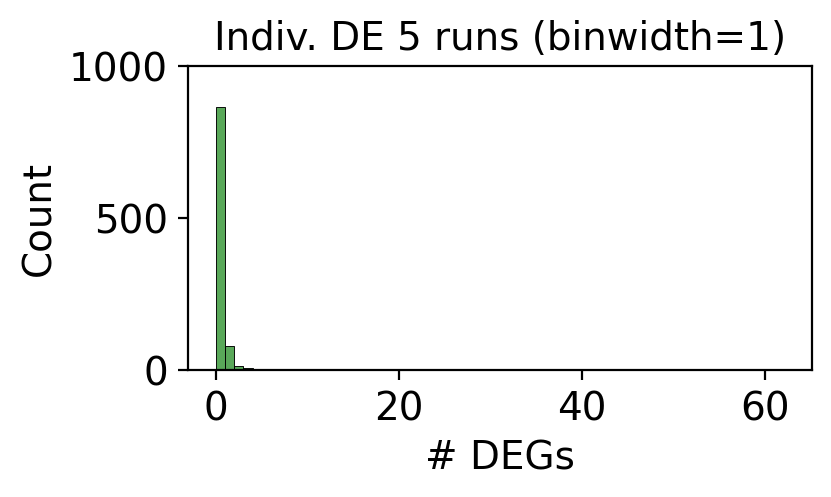

In [25]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df, 
                      figsize=(4,2), ylim=(0,1000),
                      title="Indiv. DE 5 runs (binwidth=1)",
                      color="forestgreen", binwidth=1)

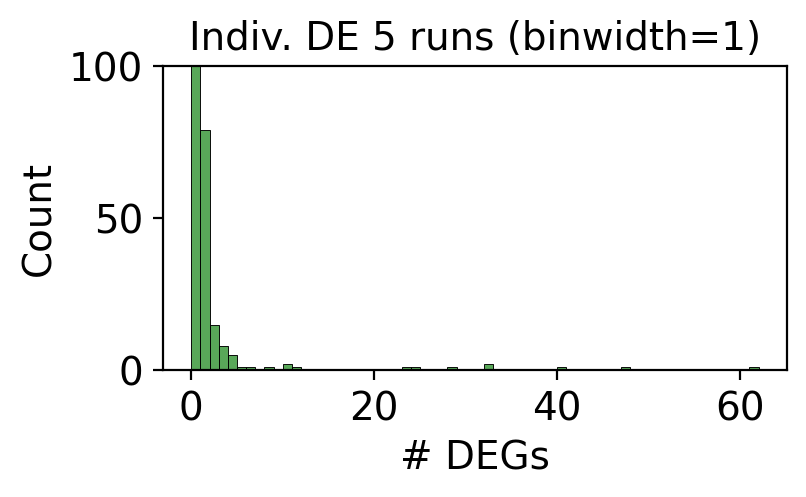

In [26]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df, 
                      figsize=(4,2), ylim=(0,100),
                      title="Indiv. DE 5 runs (binwidth=1)",
                      color="forestgreen", binwidth=1)

In [35]:
individual_DE_5_runs_n_cells_degs_df_10 = \
    build_n_cells_degs_df(individual_DE_5_runs_df, adata,
        padj_col="combined_padj", alpha=0.1)

In [36]:
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] == 0]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] > 0]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] >= 3]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] >= 10]))

852
134
30
11


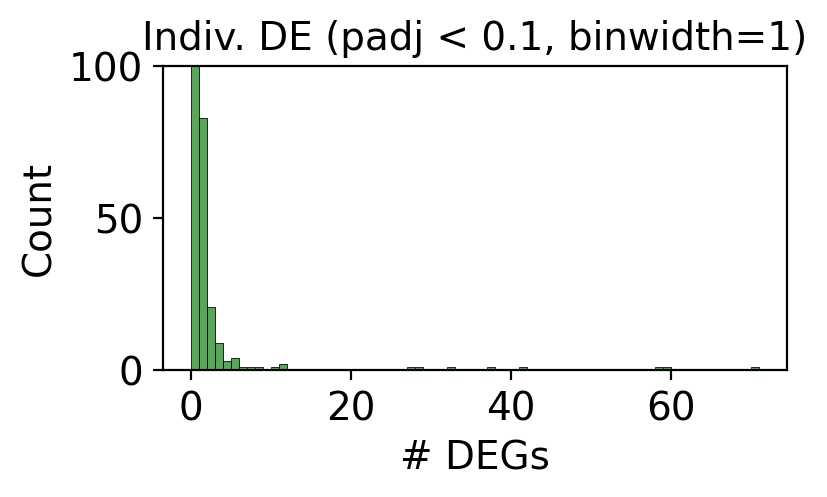

In [ ]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df_10, 
                      figsize=(4,2), ylim=(0,100),
                      title="Indiv. DE (padj < 0.1, binwidth=1)",
                      color="forestgreen", binwidth=1)

In [80]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_11-12-25.pkl"
individual_DE_1_run_res_df = pd.read_pickle(filepath_pkl)

In [81]:
individual_DE_1_run_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_1_run_res_df, adata)

In [82]:
individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] > 0]

n_cells  n_DEGs
gRNA                       
ADNP2_1         215       1
ARHGAP35_1      136       1
ARHGAP35_3      252       2
ARID3B_3         81       1
ASCL1_3          78       1
...             ...     ...
ZNF512_3         56       2
ZNF521_1         83      53
ZNF609_1         62       1
ZNF609_2         86       1
ZNF853_1         77       1

[104 rows x 2 columns]

In [84]:
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] > 0]))
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] >= 10]))

104
23
8


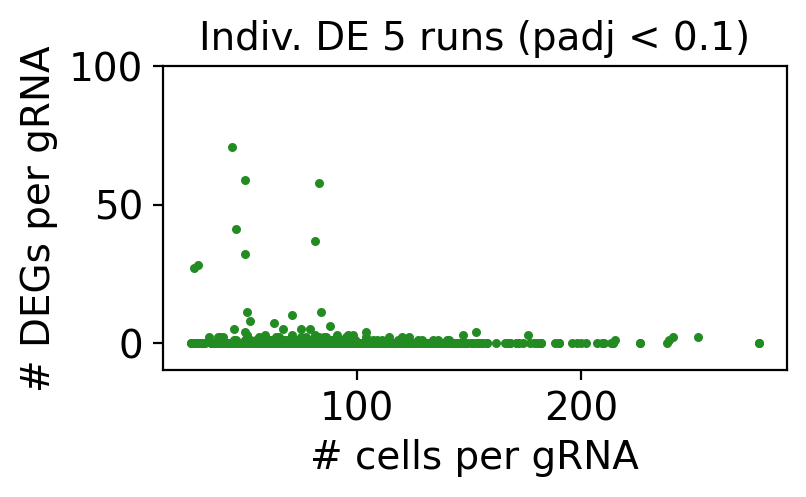

In [54]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df_10, figsize=(4,2), 
                       title="Indiv. DE 5 runs (padj < 0.1)", color="forestgreen",
                       ylim=(-10, 100))

## 4 chunks, 2 reps per gRNA

### NTC benchmarking with 2 reps per gRNA

In [6]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 adata: ad.AnnData, target_type: str = "gRNA",
                 n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 suppress_warnings: bool = False):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets = adata.obs[target_type].unique().tolist()
    if "NTC" in targets:
        targets.remove("NTC")
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [ ]:
# create_pseudobulk_dataset_2_reps()
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [12]:
# ntc_benchmarking_DE_2_reps() and report_ntc_benchmarking_results()

def ntc_benchmarking_DE_2_reps(adata: ad.AnnData,
                        layer: str = "counts",
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset_2_reps(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05, xticks=None):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        if xticks is not None:
            ax.set_xticks(xticks)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

In [4]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [5]:
# 10 minutes
ntc_benchmark_res_2_reps = ntc_benchmarking_DE_2_reps(adata, n_cpus=50, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

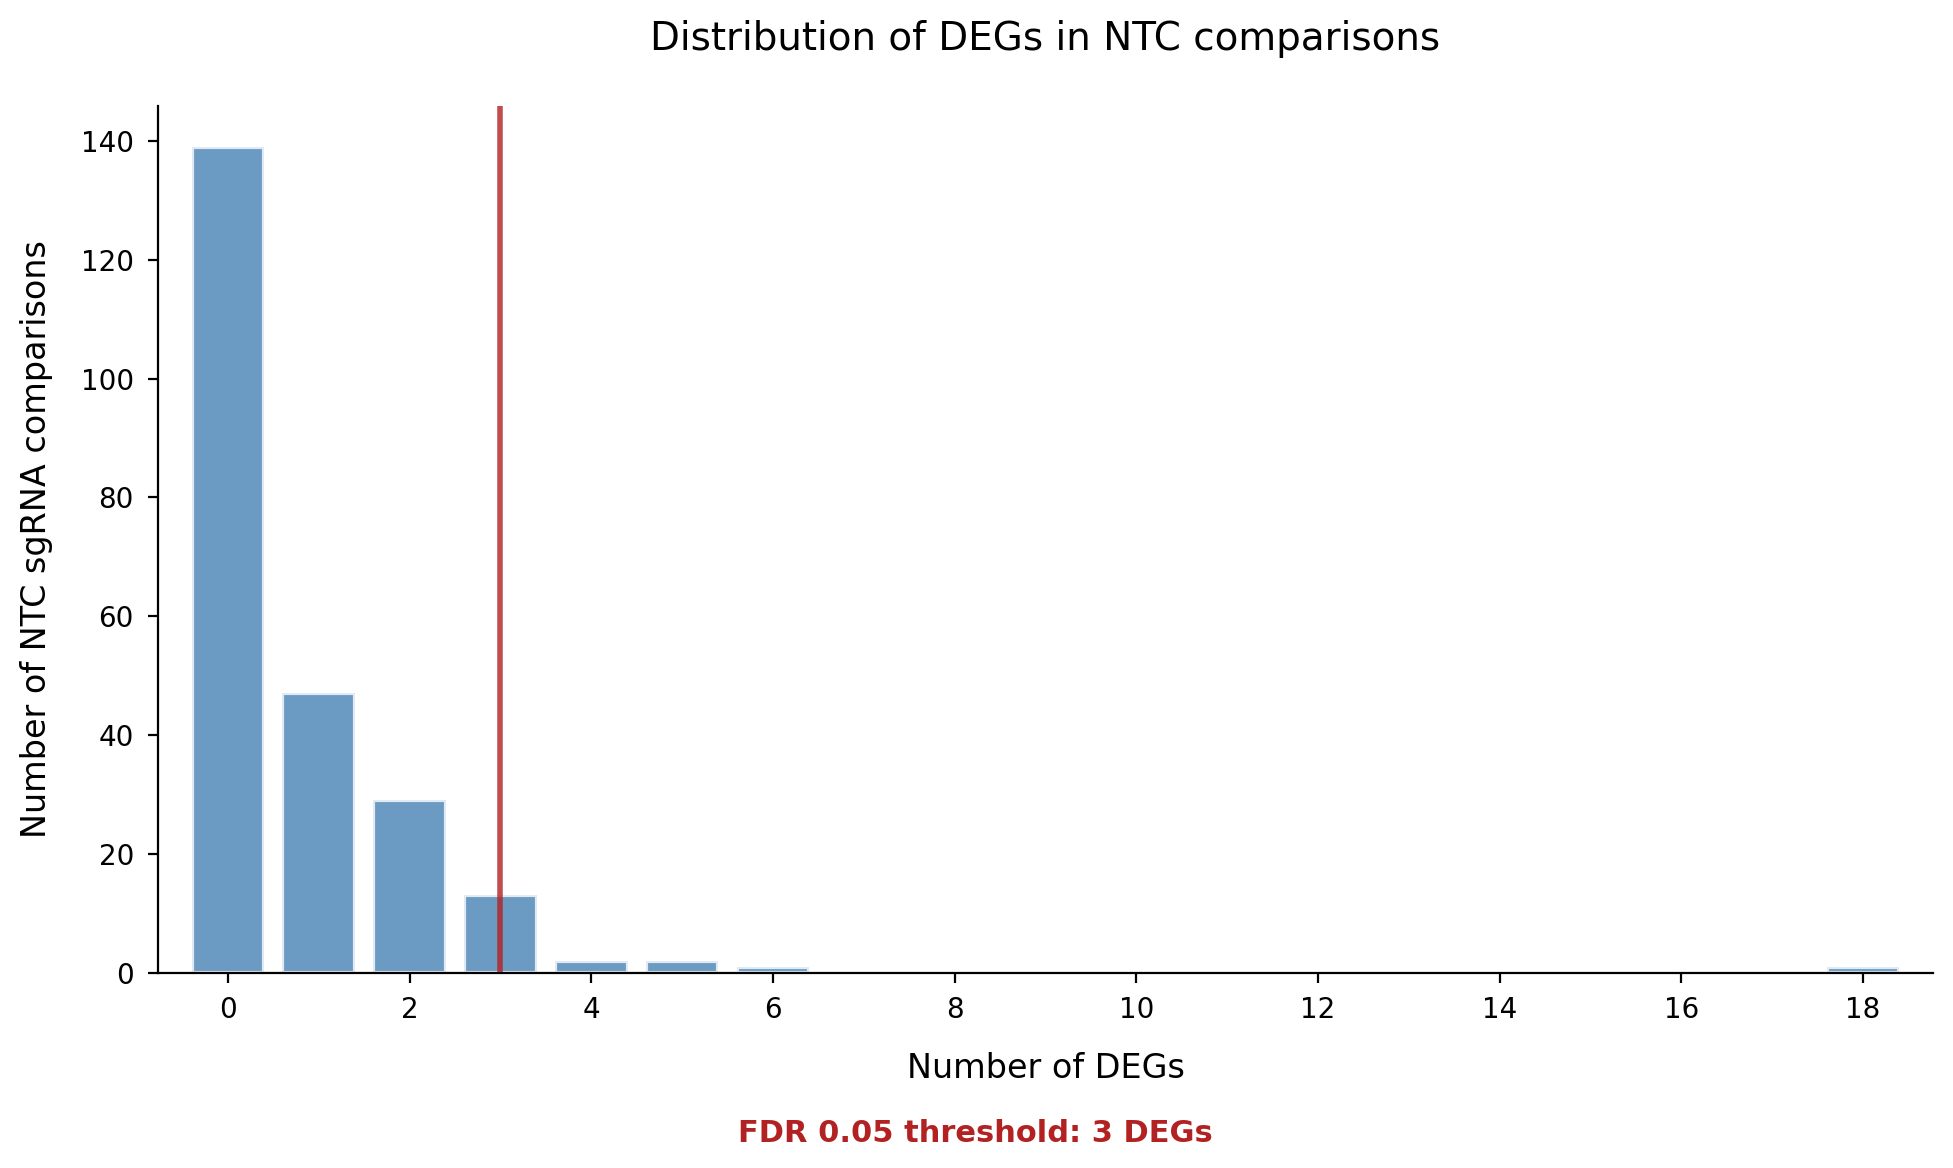

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.8
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [13]:
deg_threshold_2_reps, test_benchmark_res_2_reps = \
    report_ntc_benchmarking_results(ntc_benchmark_res_2_reps, 
                                    xticks=np.arange(0, 20, step=2))

In [14]:
test_benchmark_res_2_reps.head(7)

n_DEGs
Non-Targeting_398      18
Non-Targeting_226       6
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_929       4
Non-Targeting_351       4
Non-Targeting_248       3

In [16]:
# NTC gRNA with >3 DEGs when using 2 reps per gRNA
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_929", "Non-Targeting_351"]

In [18]:
adata.shape

(101923, 16115)

In [19]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [20]:
adata_benchmarked.shape

(101620, 16115)

In [21]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked_2reps.h5ad"
adata_benchmarked.write(save_path)

### DE with 4 chunks, 2 reps per gRNA

21 min for 1 chunk, 60 CPUs

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 ):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                max_chunk_size: int = 1000, layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting",
                                n_cpus: int = 20, alpha: float = 0.05,
                                return_dds_objects: bool = False,
                                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                                suppress_warnings: bool = False, debug: bool = False,
                                counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset_2_reps(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of perturbations per chunk
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    n_targets = n_target_samples // 2
    base_size = n_targets // n_chunks
    remainder = n_targets % n_chunks
    n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    if target_type == "gRNA":
        all_targets = adata.obs.perturbation.unique().tolist()
    else:
        all_targets = adata.obs.gene_target.unique().tolist()
    if "NTC" in all_targets:
        all_targets.remove("NTC")
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    target_indices = np.arange(len(all_targets))
    rng.shuffle(target_indices)
    chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
    chunk_indices = np.split(target_indices, chunk_splits)

    # Divide pseudobulk dataset into chunks
    all_chunk_targets = list()
    for i in range(n_chunks):
        chunk_targets = [all_targets[j] for j in chunk_indices[i]]
        all_chunk_targets.append(chunk_targets)
        chunk_targets_hyphenated = \
            [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked_2reps.h5ad"
adata = psp.utils.read_anndata(filepath)

In [7]:
# 71 min
de_results_2reps, dds_objects_2reps = \
    run_dataset_DE_chunks_2_reps(adata, max_chunk_size=1000, n_cpus=75,
                                 return_dds_objects=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 326.34 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 47.45 seconds.

Fitting LFCs...
... done in 36.61 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.33 seconds.

Fitting dispersions...
... done in 326.25 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 35.46 seconds.

Fitting LFCs...
... done in 36.05 seconds.

Calculating cook's distance...
... done in 0.73 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 384.76 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 43.72 seconds.

Fitting LFCs...
... done in 36.46 seconds.

Calculating cook's distance...
... done in 0.94 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 315.13 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 43.83 seconds.

Fitting LFCs...
... done in 35.42 seconds.

Calculating cook's distance...
... done in 0.70 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [7]:
# plot_dispersions_chunks(dds_objects_2reps, 
#                           title="DE Dispersion Plots (4 chunks, 2 reps per gRNA)")

In [10]:
de_df_4chunks_2reps = build_DE_df(de_results_2reps)
de_df_4chunks_2reps.head()

CREB1_2_baseMean  CREB1_2_log2FoldChange  CREB1_2_lfcSE  \
A1BG               3.535568               -1.461945       1.026200   
A1BG-AS1           0.537588               -1.355628       2.418601   
A2M                0.434925               -1.023308       2.455462   
A2ML1              1.634394                0.950977       0.758094   
A2ML1-AS1          4.705120               -0.456550       0.651555   

           CREB1_2_stat  CREB1_2_pvalue  CREB1_2_padj  ZNF341_1_baseMean  \
A1BG          -1.424620        0.154267      0.994442           3.535568   
A1BG-AS1      -0.560501        0.575138      0.994442           0.537588   
A2M           -0.416748        0.676863      0.994442           0.434925   
A2ML1          1.254432        0.209685      0.994442           1.634394   
A2ML1-AS1     -0.700708        0.483485      0.994442           4.705120   

           ZNF341_1_log2FoldChange  ZNF341_1_lfcSE  ZNF341_1_stat  ...  \
A1BG                      0.283957        0.420386       0.675467  ...   
A1BG-AS1                 -1.820156        2.427378      -0.749844  ...   
A2M                       0.823431        1.217321       0.676429  ...   
A2ML1                     0.771021        0.519077       1.485368  ...   
A2ML1-AS1                -0.376075        0.448284      -0.838921  ...   

           CREBZF_3_lfcSE  CREBZF_3_stat  CREBZF_3_pvalue  CREBZF_3_padj  \
A1BG             0.840493      -1.753409         0.079532       0.999527   
A1BG-AS1         2.397904      -0.723884         0.469137       0.999527   
A2M              2.444787      -0.592596         0.553452       0.999527   
A2ML1            0.744578       0.152725         0.878615       0.999527   
A2ML1-AS1        0.448155       0.084553         0.932617       0.999527   

           CDX1_1_baseMean  CDX1_1_log2FoldChange  CDX1_1_lfcSE  CDX1_1_stat  \
A1BG              3.450973              -1.139354      0.615525    -1.851027   
A1BG-AS1          0.528375               0.499963      1.134684     0.440618   
A2M               0.463366               1.275805      1.103924     1.155701   
A2ML1             1.574115              -0.773299      0.700340    -1.104177   
A2ML1-AS1         4.697649               0.576334      0.322008     1.789811   

           CDX1_1_pvalue  CDX1_1_padj  
A1BG            0.064166     0.999952  
A1BG-AS1        0.659489     0.999952  
A2M             0.247804     0.999952  
A2ML1           0.269517     0.999952  
A2ML1-AS1       0.073484     0.999952  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_4chunks_2reps.pkl"
de_df_4chunks_2reps.to_pickle(filepath_pkl)

## 3-5 chunks, 2-3 reps per gRNA

### NTC benchmarking with 2 or 3 reps per gRNA

In [ ]:
def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

Read in data

In [ ]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Note: when running with suppress_warnings=False (time elapsed was 12 min), got this error:

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst) 

In [ ]:
test_ntc_benchmark_res = ntc_benchmarking_DE(adata, n_cpus=30, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

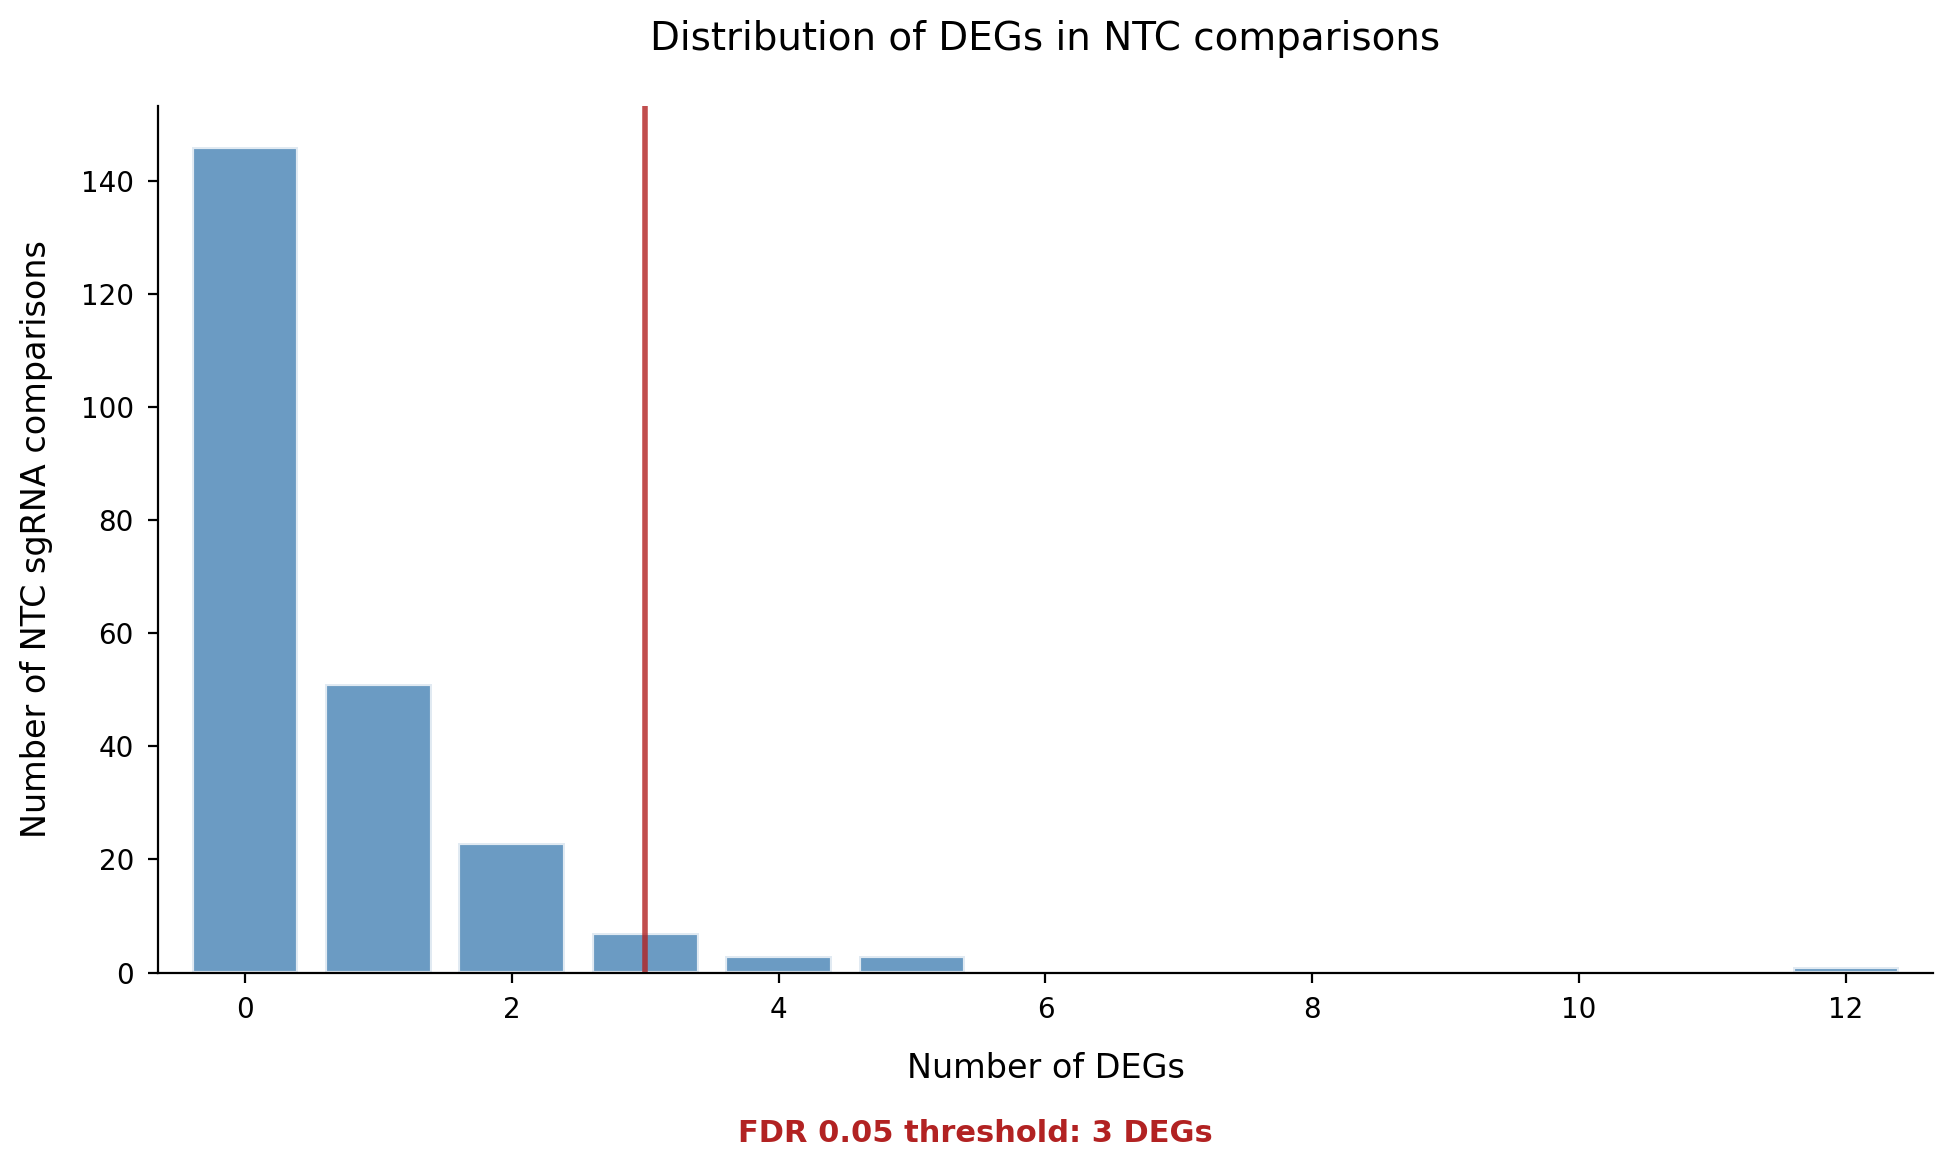

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.7
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [ ]:
test_deg_threshold, test_benchmark_res = \
    report_ntc_benchmarking_results(test_ntc_benchmark_res)

In [ ]:
test_benchmark_res[test_benchmark_res["n_DEGs"] > 3]

n_DEGs
Non-Targeting_398      12
Non-Targeting_226       5
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_351       4
Non-Targeting_482       4
Non-Targeting_418       4

In [ ]:
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_351", "Non-Targeting_482",
                      "Non-Targeting_418"]

In [ ]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [ ]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata_benchmarked.write(save_path)

Restart kernel

### 5 chunks

13.5 min for 1 chunk, 75 CPUs

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
# 1 hr for all 5 chunks
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1100, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbing gRNA samples, 552 NTC gRNA samples, 5 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [37, 37, 37, 37, 37]
Number of targets with 3 reps per chunk: [161, 160, 160, 160, 160]
Running DE analysis on chunk 1 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.38 seconds.

Fitting dispersions...
... done in 311.76 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 29.98 seconds.

Fitting LFCs...
... done in 28.65 seconds.

Calculating cook's distance...
... done in 0.96 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/198 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 245.20 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 21.60 seconds.

Fitting LFCs...
... done in 27.34 seconds.

Calculating cook's distance...
... done in 0.90 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 238.91 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 32.24 seconds.

Fitting LFCs...
... done in 28.37 seconds.

Calculating cook's distance...
... done in 0.95 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 244.20 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 26.89 seconds.

Fitting LFCs...
... done in 27.35 seconds.

Calculating cook's distance...
... done in 0.92 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 5 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 224.53 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 32.06 seconds.

Fitting LFCs...
... done in 27.90 seconds.

Calculating cook's distance...
... done in 0.93 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

In [7]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [6]:
# plot_dispersions_chunks(dds_objects_2_3_reps, 
#                         "DE Dispersion Plots (5 chunks, 2-3 reps per gRNA)")

In [14]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.742657               -0.010841       0.735985   
A1BG-AS1           0.421032               -1.045400       2.406611   
A2M                0.347912                1.692420       1.161088   
A2ML1              1.252989                0.524628       1.039627   
A2ML1-AS1          3.643710               -0.326498       0.730356   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.014730        0.988248      0.999358          2.742657   
A1BG-AS1      -0.434387        0.664008      0.996475          0.421032   
A2M            1.457615        0.144947      0.996475          0.347912   
A2ML1          0.504631        0.613818      0.996475          1.252989   
A2ML1-AS1     -0.447040        0.654846      0.996475          3.643710   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.496039       0.526058      0.942935  ...   
A1BG-AS1                 0.229896       1.483032      0.155017  ...   
A2M                      1.456361       1.157547      1.258145  ...   
A2ML1                   -0.352571       1.033394     -0.341177  ...   
A2ML1-AS1                1.039646       0.385293      2.698326  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.731656     -2.080897        0.037443      0.999948   
A1BG-AS1        1.079225      0.487205        0.626113      0.999948   
A2M             1.537242     -0.163907        0.869804      0.999948   
A2ML1           0.616768     -0.246230        0.805504      0.999948   
A2ML1-AS1       0.352756      0.860081        0.389744      0.999948   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.722370               -0.612937       0.568726   
A1BG-AS1           0.404021                1.961533       1.322062   
A2M                0.370607                1.210000       1.602031   
A2ML1              1.254465               -1.488446       0.724537   
A2ML1-AS1          3.642391                0.065013       0.445665   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.077738        0.281151      0.998639  
A1BG-AS1       1.483692        0.137891      0.998639  
A2M            0.755291        0.450074      0.998639  
A2ML1         -2.054341        0.039943      0.998639  
A2ML1-AS1      0.145879        0.884017      0.998639  

[5 rows x 5916 columns]

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_5chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

### 4 chunks

In [ ]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [ ]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [ ]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [ ]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [ ]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1200, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 4 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [47, 46, 46, 46]
Number of targets with 3 reps per chunk: [201, 200, 200, 200]
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.44 seconds.

Fitting dispersions...
... done in 412.59 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 55.38 seconds.

Fitting LFCs...
... done in 46.49 seconds.

Calculating cook's distance...
... done in 1.13 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/248 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.43 seconds.

Fitting dispersions...
... done in 384.44 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 53.34 seconds.

Fitting LFCs...
... done in 46.44 seconds.

Calculating cook's distance...
... done in 1.08 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.43 seconds.

Fitting dispersions...
... done in 447.13 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 60.14 seconds.

Fitting LFCs...
... done in 45.92 seconds.

Calculating cook's distance...
... done in 1.10 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.44 seconds.

Fitting dispersions...
... done in 396.98 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 54.36 seconds.

Fitting LFCs...
... done in 45.09 seconds.

Calculating cook's distance...
... done in 1.15 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [28]:
# plot_dispersions_chunks(dds_objects_2_3_reps, 
#                         "DE Dispersion Plots (4 chunks, 2-3 reps per gRNA)")

In [12]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.767904               -0.008186       0.733820   
A1BG-AS1           0.430147               -1.039813       2.404481   
A2M                0.355277                1.683851       1.133593   
A2ML1              1.277306                0.527925       1.038330   
A2ML1-AS1          3.726706               -0.324039       0.729280   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.011156        0.991099      0.999249          2.767904   
A1BG-AS1      -0.432448        0.665416      0.996406          0.430147   
A2M            1.485411        0.137435      0.996406          0.355277   
A2ML1          0.508437        0.611147      0.996406          1.277306   
A2ML1-AS1     -0.444327        0.656806      0.996406          3.726706   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.495068       0.523166      0.946294  ...   
A1BG-AS1                 0.227976       1.479601      0.154079  ...   
A2M                      1.461070       1.128424      1.294789  ...   
A2ML1                   -0.353431       1.032227     -0.342397  ...   
A2ML1-AS1                1.038687       0.383302      2.709841  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.730884     -2.086347        0.036947      0.999984   
A1BG-AS1        1.077588      0.489574        0.624435      0.999984   
A2M             1.517727     -0.171558        0.863785      0.999984   
A2ML1           0.613313     -0.244279        0.807014      0.999984   
A2ML1-AS1       0.352053      0.880093        0.378809      0.999984   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.763857               -0.626842       0.566604   
A1BG-AS1           0.405979                1.964955       1.319060   
A2M                0.380864                1.169877       1.570516   
A2ML1              1.294691               -1.480809       0.718742   
A2ML1-AS1          3.713038                0.089628       0.444587   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.106313        0.268591      0.999608  
A1BG-AS1       1.489664        0.136313      0.999608  
A2M            0.744900        0.456332      0.999608  
A2ML1         -2.060278        0.039372      0.999608  
A2ML1-AS1      0.201599        0.840230      0.999608  

[5 rows x 5916 columns]

In [13]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_4chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

### 3 chunks

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [7]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Random seed = 42

In [ ]:
# 195 min (3hr 15min) total
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1500, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 3 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [62, 62, 61]
Number of targets with 3 reps per chunk: [267, 267, 267]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.48 seconds.

Fitting dispersions...
... done in 1850.03 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 111.04 seconds.

Fitting LFCs...
... done in 85.71 seconds.

Calculating cook's distance...
... done in 1.28 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1848.54 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 105.46 seconds.

Fitting LFCs...
... done in 87.34 seconds.

Calculating cook's distance...
... done in 1.29 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1530.03 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 122.96 seconds.

Fitting LFCs...
... done in 84.87 seconds.

Calculating cook's distance...
... done in 1.32 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

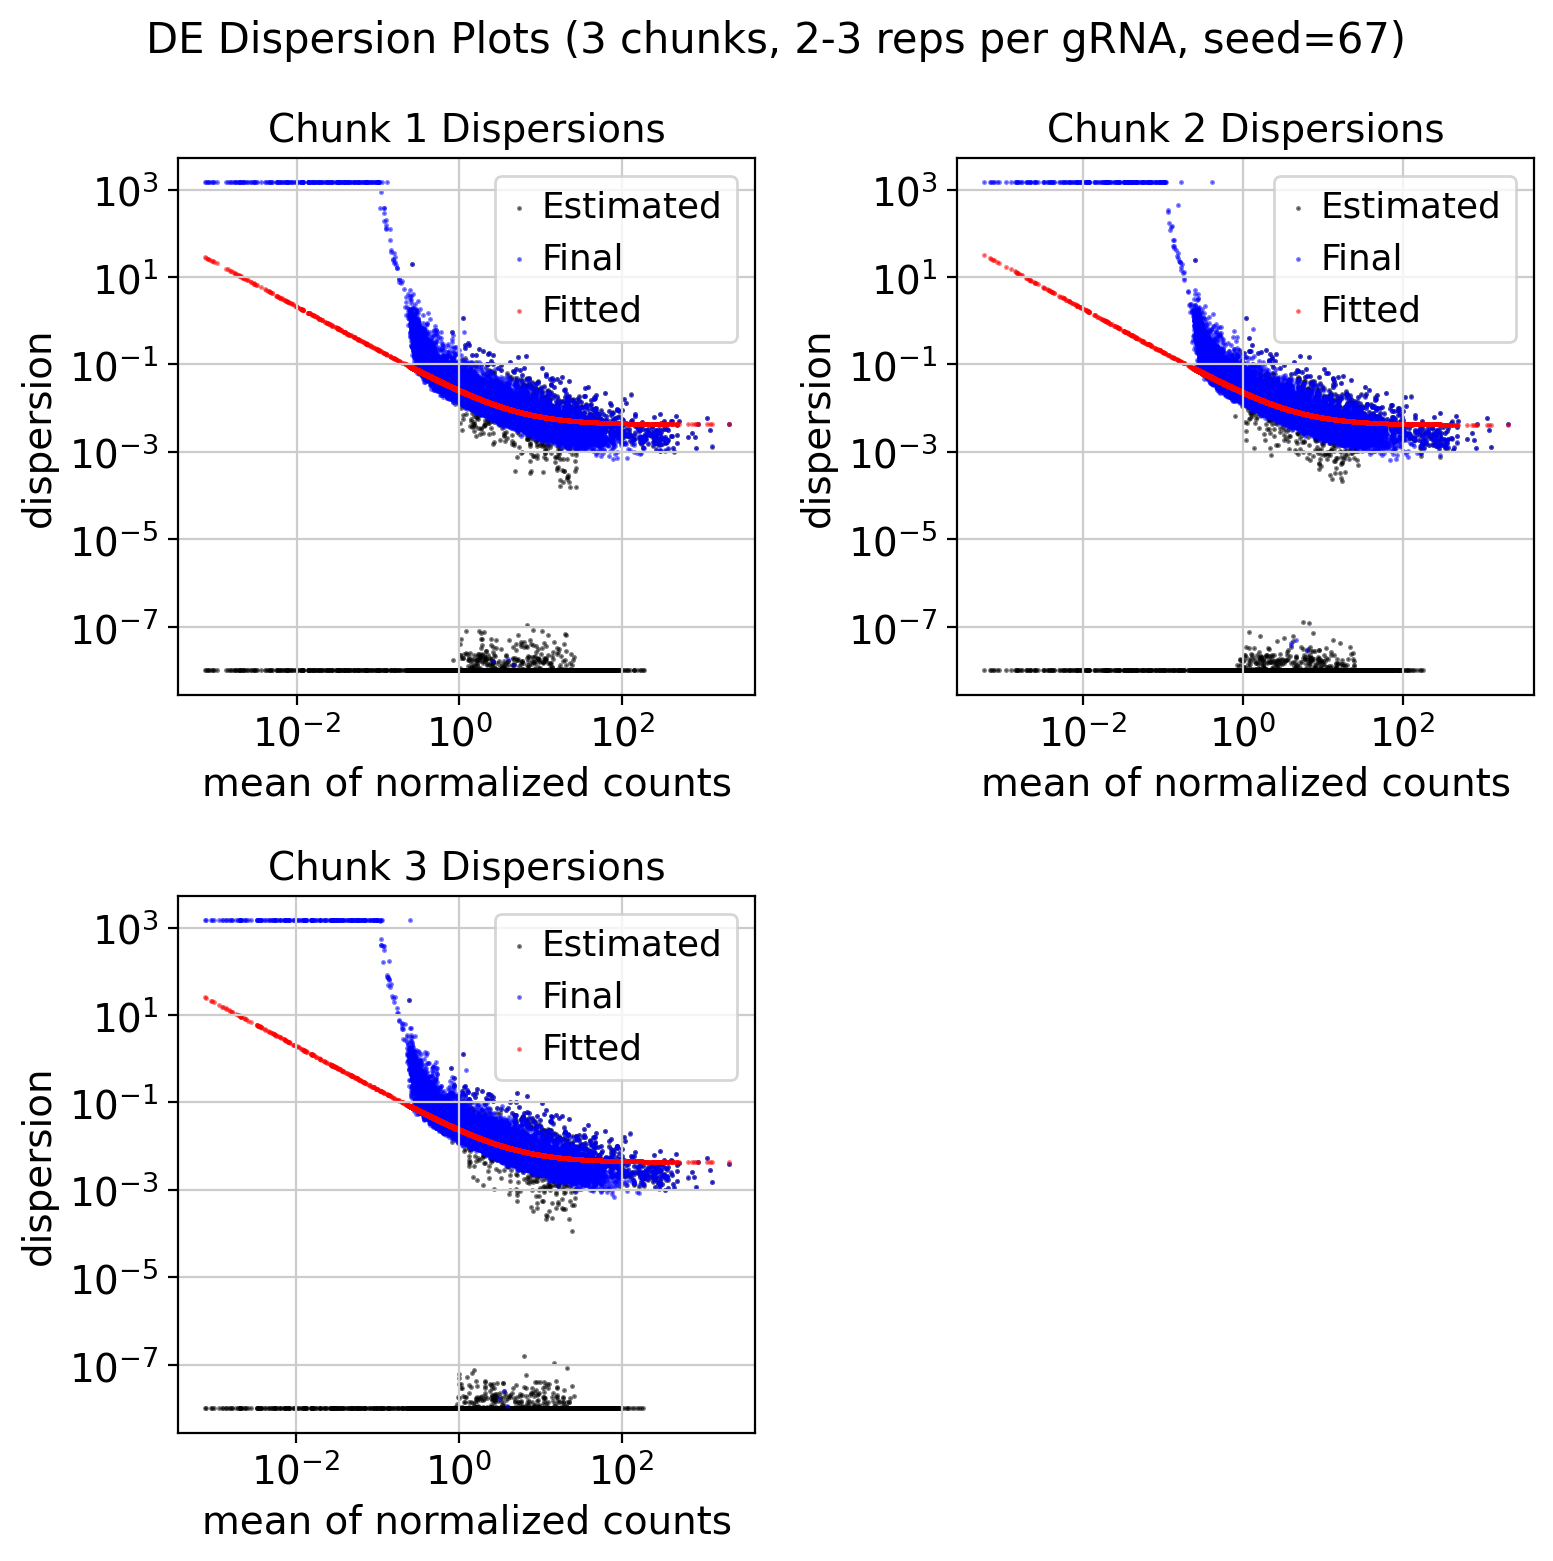

In [20]:
plot_dispersions_chunks(dds_objects_2_3_reps, 
                        "DE Dispersion Plots (3 chunks, 2-3 reps per gRNA, seed=67)")

In [10]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.827034               -0.003374       0.731317   
A1BG-AS1           0.435485               -1.031835       2.401948   
A2M                0.376323                1.681748       1.107155   
A2ML1              1.311197                0.526787       1.037162   
A2ML1-AS1          3.838352               -0.323955       0.728430   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.004614        0.996319      0.999122          2.827034   
A1BG-AS1      -0.429583        0.667499      0.995879          0.435485   
A2M            1.518982        0.128767      0.995879          0.376323   
A2ML1          0.507912        0.611515      0.995879          1.311197   
A2ML1-AS1     -0.444730        0.656515      0.995879          3.838352   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.493980       0.519817      0.950297  ...   
A1BG-AS1                 0.225207       1.475414      0.152640  ...   
A2M                      1.463231       1.100197      1.329972  ...   
A2ML1                   -0.352951       1.031180     -0.342278  ...   
A2ML1-AS1                1.038741       0.381729      2.721151  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.731210     -2.090207        0.036599        0.9997   
A1BG-AS1        1.060239      0.477856        0.632753        0.9997   
A2M             1.498648     -0.176329        0.860036        0.9997   
A2ML1           0.610098     -0.226539        0.820782        0.9997   
A2ML1-AS1       0.352096      0.857501        0.391168        0.9997   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.790245               -0.640875       0.566627   
A1BG-AS1           0.412643                1.871297       1.294155   
A2M                0.382920                1.154717       1.538883   
A2ML1              1.329462               -1.421428       0.713603   
A2ML1-AS1          3.776483                0.055898       0.443806   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.131034        0.258041      0.999475  
A1BG-AS1       1.445961        0.148188      0.999475  
A2M            0.750361        0.453037      0.999475  
A2ML1         -1.991904        0.046382      0.999475  
A2ML1-AS1      0.125952        0.899770      0.999475  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

Random seed = 67

In [ ]:
# 196 min (3hrs 16min)
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1500, n_cpus=75,
                                   min_cells_for_3_reps=60, return_dds_objects=True,
                                   random_state=67)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 3 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [62, 62, 61]
Number of targets with 3 reps per chunk: [267, 267, 267]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.48 seconds.

Fitting dispersions...
... done in 1798.32 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 110.92 seconds.

Fitting LFCs...
... done in 87.16 seconds.

Calculating cook's distance...
... done in 1.29 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.52 seconds.

Fitting dispersions...
... done in 2025.16 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 120.81 seconds.

Fitting LFCs...
... done in 85.72 seconds.

Calculating cook's distance...
... done in 1.31 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1479.83 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 109.44 seconds.

Fitting LFCs...
... done in 86.02 seconds.

Calculating cook's distance...
... done in 1.30 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

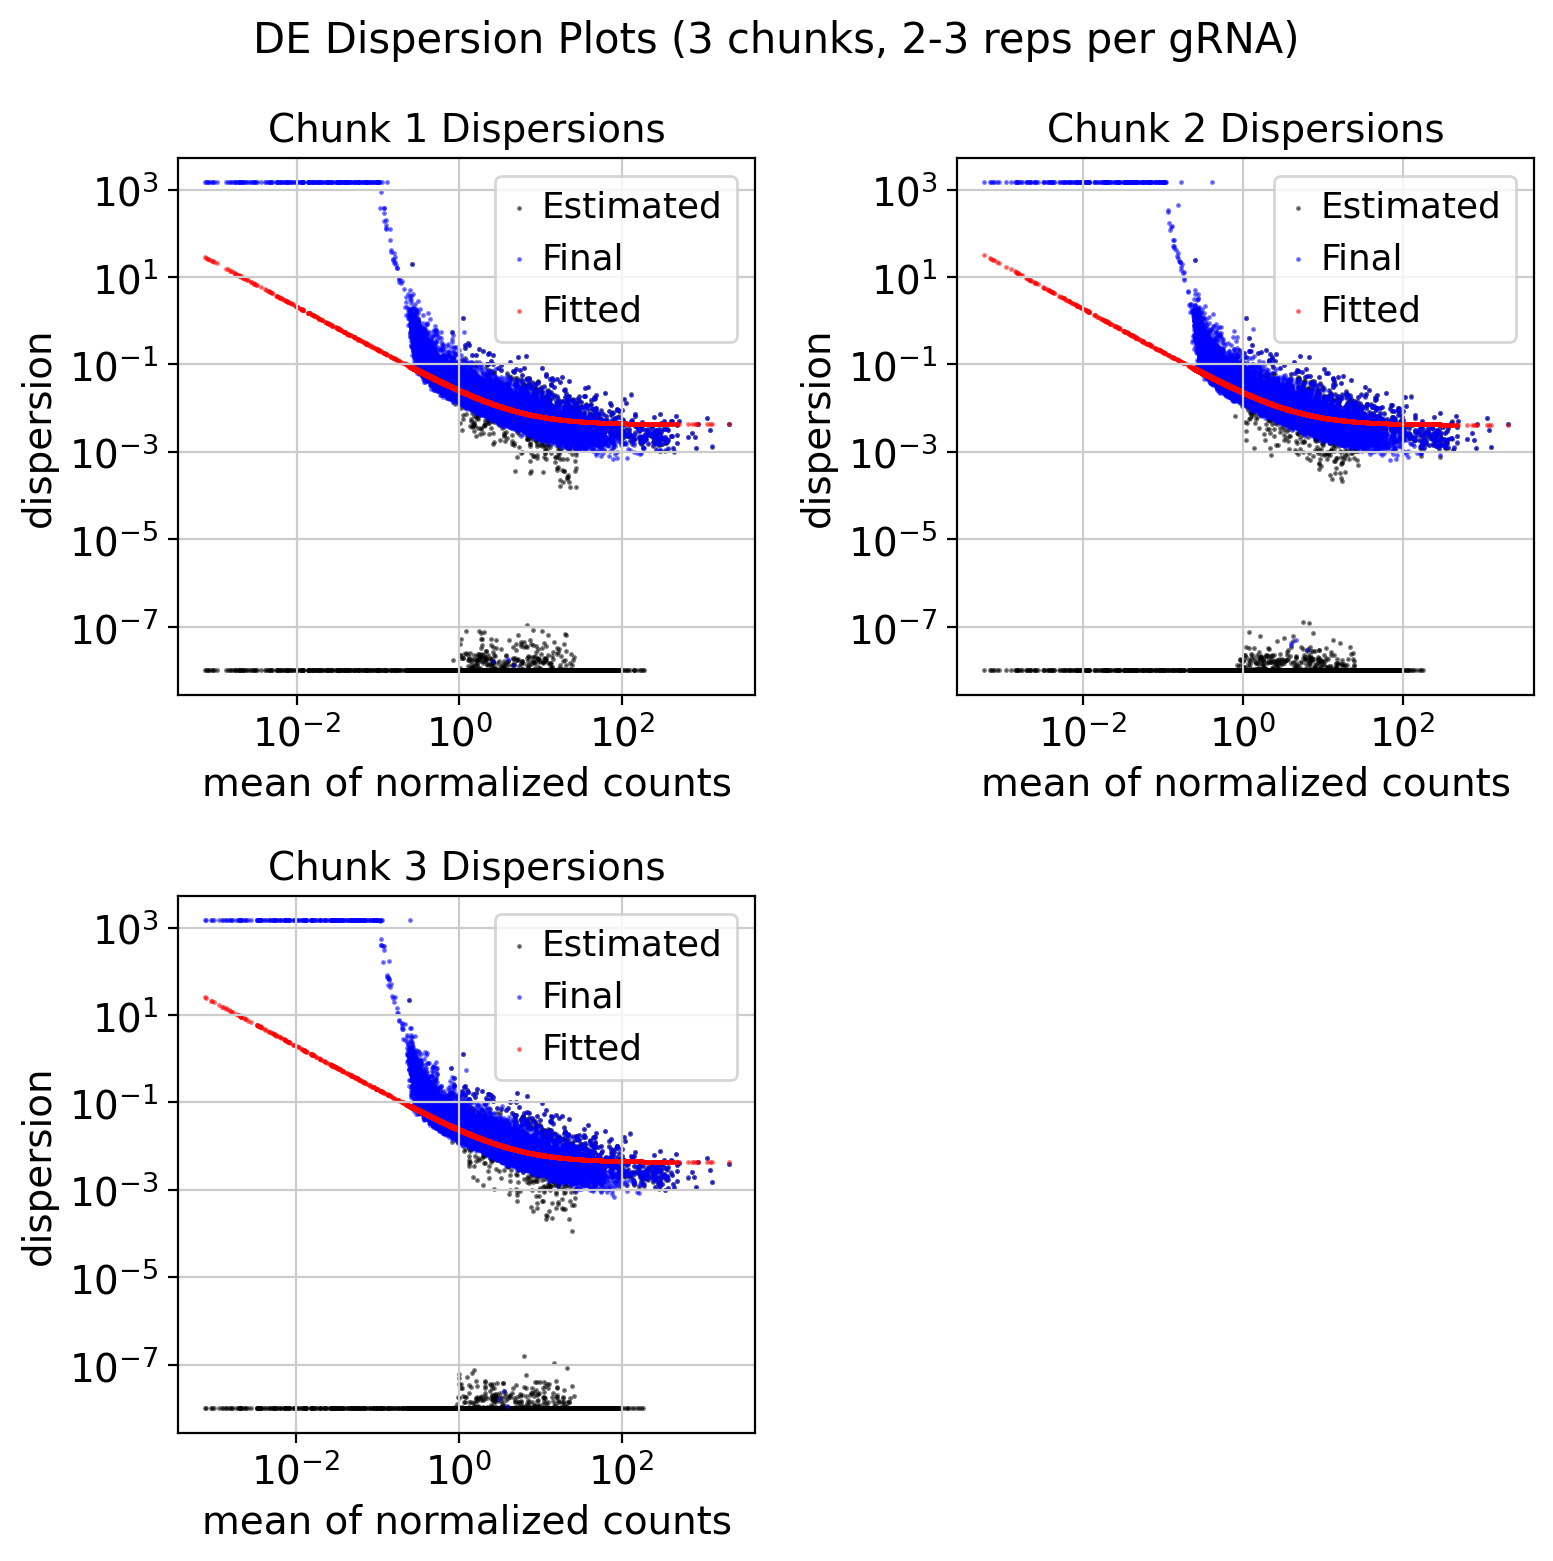

In [9]:
plot_dispersions_chunks(dds_objects_2_3_reps, 
                        "DE Dispersion Plots (3 chunks, 2-3 reps per gRNA)")

In [10]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

ZNF785_3_baseMean  ZNF785_3_log2FoldChange  ZNF785_3_lfcSE  \
A1BG                2.825213                -0.119328        0.652439   
A1BG-AS1            0.406331                -1.220467        2.378477   
A2M                 0.357067                 2.061855        0.925485   
A2ML1               1.349573                 0.832734        0.756306   
A2ML1-AS1           3.831621                 0.013628        0.561750   

           ZNF785_3_stat  ZNF785_3_pvalue  ZNF785_3_padj  ZNF335_2_baseMean  \
A1BG           -0.182895         0.854880       0.999511           2.825213   
A1BG-AS1       -0.513130         0.607860       0.997405           0.406331   
A2M             2.227864         0.025890       0.997405           0.357067   
A2ML1           1.101055         0.270873       0.997405           1.349573   
A2ML1-AS1       0.024261         0.980645       0.999511           3.831621   

           ZNF335_2_log2FoldChange  ZNF335_2_lfcSE  ZNF335_2_stat  ...  \
A1BG                     -1.572837        1.449171      -1.085336  ...   
A1BG-AS1                  0.654794        1.486734       0.440425  ...   
A2M                      -0.440840        2.430576      -0.181373  ...   
A2ML1                     0.164431        1.470981       0.111783  ...   
A2ML1-AS1                 0.914663        0.568722       1.608278  ...   

           SNAI2_2_lfcSE  SNAI2_2_stat  SNAI2_2_pvalue  SNAI2_2_padj  \
A1BG            0.507155     -1.032087        0.302032      0.999998   
A1BG-AS1        0.924310      1.121289        0.262165      0.999998   
A2M             1.461977     -0.177521        0.859099      0.999998   
A2ML1           1.047108     -2.028679        0.042491      0.999998   
A2ML1-AS1       0.442830     -1.184949        0.236037      0.999998   

           ZNF841_3_baseMean  ZNF841_3_log2FoldChange  ZNF841_3_lfcSE  \
A1BG                2.768277                 0.211601        0.420046   
A1BG-AS1            0.446179                 0.504915        1.065490   
A2M                 0.381827                -1.150451        1.974116   
A2ML1               1.290854                -0.389769        0.673530   
A2ML1-AS1           3.722151                 0.021142        0.392296   

           ZNF841_3_stat  ZNF841_3_pvalue  ZNF841_3_padj  
A1BG            0.503755         0.614433       0.999767  
A1BG-AS1        0.473881         0.635585       0.999767  
A2M            -0.582768         0.560050       0.999767  
A2ML1          -0.578695         0.562795       0.999767  
A2ML1-AS1       0.053892         0.957021       0.999767  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps_seed67.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

## Comparing gRNA-level DE methods

In [28]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)

In [29]:
import pandas as pd

de_results_df_2_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_4chunks_2reps.pkl")

de_results_df_5_chunks_2_3_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_5chunks_2-3reps.pkl")

de_results_df_4_chunks_2_3_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_4chunks_2-3reps.pkl")

de_results_df_3_chunks_2_3_reps_42 = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps.pkl")

de_results_df_3_chunks_2_3_reps_67 = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps_seed67.pkl")

In [31]:
def build_degs_per_gene_target_df(DE_results_df, adata, alpha):
    gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.unique().tolist()
    gene_targets = adata[adata.obs.perturbed == "True"].obs.gene_target.unique().tolist()
    gene_target_degs_dict = {gene_target: 0 for gene_target in gene_targets}
    for gRNA in gRNAs:
        gene_target = gRNA.split("_")[0]
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{gRNA}_")]
        n_degs = len(target_df[target_df[f"{gRNA}_{'padj'}"] < alpha])
        gene_target_degs_dict[gene_target] += n_degs
    degs_per_gene_target_df = \
        pd.DataFrame.from_dict(gene_target_degs_dict, orient="index", columns=["n_DEGs"])
    return degs_per_gene_target_df

In [39]:
degs_per_gene_target10 = \
    build_degs_per_gene_target_df(de_results_df_3_chunks_2_3_reps_67, adata, 0.1)

In [43]:
print(len(degs_per_gene_target10[degs_per_gene_target10["n_DEGs"] == 0]))
print(len(degs_per_gene_target10[degs_per_gene_target10["n_DEGs"] > 0]))
print(len(degs_per_gene_target10[degs_per_gene_target10["n_DEGs"] >= 3]))
print(len(degs_per_gene_target10[degs_per_gene_target10["n_DEGs"] >= 10]))

200
526
351
156


In [41]:
375/726

0.5165289256198347

In [13]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [16]:
de_n_cells_degs_df_2_reps = build_n_cells_degs_df(de_results_df_2_reps, adata, alpha=0.1)
de_n_cells_degs_df_3_chunks_2_3_reps_42 = \
    build_n_cells_degs_df(de_results_df_3_chunks_2_3_reps_42, adata, alpha=0.1)
de_n_cells_degs_df_3_chunks_2_3_reps_67 = \
    build_n_cells_degs_df(de_results_df_3_chunks_2_3_reps_67, adata, alpha=0.1)
de_n_cells_degs_df_4_chunks_2_3_reps = \
    build_n_cells_degs_df(de_results_df_4_chunks_2_3_reps, adata, alpha=0.1)
de_n_cells_degs_df_5_chunks_2_3_reps = \
    build_n_cells_degs_df(de_results_df_5_chunks_2_3_reps, adata, alpha=0.1)

In [23]:
de_n_cells_degs_df_3_chunks_2_3_reps_67.sort_values(by="n_DEGs", ascending=False).head(15)

n_cells  n_DEGs
gRNA                      
POU5F1B_1       44    1340
POU5F1_2        29    1313
POU5F1_3        50    1166
PHF20_1         46    1062
POU5F1_1        27    1055
POU3F2_2        50     929
ZNF521_1        83     768
ZNF396_2        51     764
NANOG_2         81     358
PURG_3          63     321
DNMT1_3         52     261
DNMT1_1         50     253
DNMT1_2         45     246
NFKB2_1         85     189
PRDM14_1        55     189

In [17]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [18]:
idx_list = ["4 chunks, 2 reps/gRNA", "5 chunks, 2-3 reps/gRNA", 
            "4 chunks, 2-3 reps/gRNA", "3 chunks, 2-3 reps/gRNA, seed=42",
            "3 chunks, 2-3 reps/gRNA, seed=67"]
dfs_list = [de_n_cells_degs_df_2_reps, de_n_cells_degs_df_5_chunks_2_3_reps, 
            de_n_cells_degs_df_4_chunks_2_3_reps,
            de_n_cells_degs_df_3_chunks_2_3_reps_42,
            de_n_cells_degs_df_3_chunks_2_3_reps_67]
compare_DE_methods_df = build_DE_method_comparison_df(dfs_list, idx_list)

In [19]:
compare_DE_methods_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
4 chunks, 2 reps/gRNA                         377      609      374       155
5 chunks, 2-3 reps/gRNA                       368      618      376       165
4 chunks, 2-3 reps/gRNA                       342      644      401       168
3 chunks, 2-3 reps/gRNA, seed=42              329      657      418       180
3 chunks, 2-3 reps/gRNA, seed=67              320      666      419       177

In [24]:
idx_cols = ["4 chunks, 2 reps/gRNA", "3 chunks, 2-3 reps/gRNA"]
dfs_list = [de_n_cells_degs_df_2_reps, de_n_cells_degs_df_3_chunks_2_3_reps_67]
compare_2_methods_df = build_DE_method_comparison_df(dfs_list, idx_cols)

In [25]:
compare_2_methods_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
4 chunks, 2 reps/gRNA                377      609      374       155
3 chunks, 2-3 reps/gRNA              320      666      419       177

# Fall 2025 Week 8

## Gene target level gRNA, 2-3 reps

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings from PyDESeq2
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, 
                 alpha: float = 0.05, quiet: bool = False,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds_quiet = True if quiet else False
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=dds_quiet
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
# create_gene_target_pseudobulk_dataset()

import math

def create_gene_target_pseudobulk_dataset(adata: ad.AnnData,
                                        layer: str = "counts",
                                        min_cells_for_3_reps: int = 60,
                                        max_cells_per_rep: int = 100,
                                        ntc_gRNA_as_reps: bool = True,
                                        approx_ntc_rep_size: int = 50,
                                        random_state: int = 42,
                                        gene_target_obs_col: str = "gene_target",
                                        ntc_target_delimiter: str = "NTC"
                                        ):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for each
    gene target. Default perturbation rep size: use 2 reps for a gene target 
    if <60 cells, 3 reps if 60-300 cells, and >3 reps of max 100 cells if >300 cells.
    If ntc_gRNA_as_reps is True, use each NTC gRNA as a NTC replicate. 
    If ntc_gRNA_as_reps is False, create NTC pseudoreps of ~approx_ntc_rep_size.
    """
    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Get gene targets
    targets = adata.obs[gene_target_obs_col].unique().tolist()
    if ntc_gRNA_as_reps:
        targets.remove(ntc_target_delimiter)

    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[gene_target_obs_col] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target == ntc_target_delimiter:
            if ntc_gRNA_as_reps:
                continue
            # Create NTC reps of ~approx_ntc_rep_size as evenly as possible
            else:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
        # Create perturbation reps
        else:
            if n_target_cells < min_cells_for_3_reps: # 2 reps
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            elif (n_target_cells >= min_cells_for_3_reps) & \
                    (n_target_cells <= 3*max_cells_per_rep): # 3 reps
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
            else: # >3 reps
                n_reps = math.ceil(n_target_cells / max_cells_per_rep)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        metadata_condition += ([target_hyphenated]*n_reps)
            
    # If using NTC gRNAs as reps
    if ntc_gRNA_as_reps:
        ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
        for ntc_gRNA in ntc_gRNAs:
            target_indices = np.where(adata.obs.gRNA == ntc_gRNA)[0]
            target_data = data_matrix[target_indices]
            target_counts = np.sum(target_data, axis=0).astype(np.int64)
            # Update counts
            counts_arrays.append(target_counts.reshape(1, -1))
            counts_df_index.append(ntc_gRNA.replace("_", "-"))
            # Update metadata
            metadata_n_cells.append(target_data.shape[0])
            metadata_condition.append("NTC")

    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def create_gene_target_DE_chunks(counts_df: pd.DataFrame, 
                                 metadata_df: pd.DataFrame,
                                 max_chunk_size: int = 1100, 
                                 n_chunks=None,
                                 min_cells_for_3_reps: int = 60,
                                 max_cells_per_rep: int = 100,
                                 random_state: int = 42,
                                 gene_target_obs_col: str = "gene_target"):
    """
    Divide gene target DE pseudobulk dataset into chunks that each contain all 
    NTC replicates and a subset of perturbations.
    """
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    if n_chunks is None:
        n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[gene_target_obs_col].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = (target_counts_df["count"] >= min_cells_for_3_reps) & \
                        (target_counts_df["count"] <= 3*max_cells_per_rep)
    four_or_more_reps_mask = target_counts_df["count"] > 3*max_cells_per_rep
    n_rep_sizes = 3
    n_targets_per_rep_size = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask]),
         len(target_counts_df[four_or_more_reps_mask])] # n targets for each rep size
    print(f"{n_targets_per_rep_size[0]} targets with 2 reps, "
          f"{n_targets_per_rep_size[1]} targets with 3 reps, "
          f"{n_targets_per_rep_size[2]} targets with 4+ reps")
    n_chunk_targets_per_rep_size = np.zeros((n_rep_sizes, n_chunks), dtype=int)
    for i in range(n_rep_sizes):
        n_targets = n_targets_per_rep_size[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_per_rep_size[i] = np.array(n_targets_per_chunk)
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_per_rep_size[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_per_rep_size[1]}")
    print(f"Number of targets with 4+ reps per chunk: {n_chunk_targets_per_rep_size[2]}")
    print(f"Total number of targets per chunk: {n_chunk_targets_per_rep_size.sum(axis=0)}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_per_rep_size = [target_counts_df[two_reps_mask].index.tolist(),
                            target_counts_df[three_reps_mask].index.tolist(),
                            target_counts_df[four_or_more_reps_mask].index.tolist()]
    chunk_indices_per_rep_size = list() # array of size 3 x n_chunks
    for i in range(n_rep_sizes):
        n_targets_per_chunk = n_chunk_targets_per_rep_size[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_per_rep_size[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(n_targets_per_chunk)[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_per_rep_size.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks): # Loop through chunks
        chunk_targets = list()
        # Add 2-rep targets, 3-rep targets, and 4-or-more-rep targets to chunk target list
        for j in range(n_rep_sizes): # Loop through rep sizes
            rep_size_chunk_indices = chunk_indices_per_rep_size[j]
            rep_size_targets = targets_per_rep_size[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)
    
    # Print and return results
    samples_per_chunk = np.array([len(df) for df in chunk_counts_dfs])
    ntc_samples_per_chunk = np.array([n_ntc_samples] * n_chunks)
    print(f"Total samples per chunk: {samples_per_chunk}")
    print(f"Perturbed samples per chunk: {samples_per_chunk - ntc_samples_per_chunk}")
    return chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets

In [5]:
def run_gene_target_dataset_DE(
        adata: ad.AnnData,
        max_chunk_size: int = 1100, n_chunks=None,
        layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        max_cells_per_rep: int = 100,
        ntc_gRNA_as_reps: bool = True,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        gene_target_obs_col: str = "gene_target",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False, quiet: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_gene_target_pseudobulk_dataset(
                adata, layer=layer,
                ntc_gRNA_as_reps=ntc_gRNA_as_reps,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                max_cells_per_rep=max_cells_per_rep, 
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                gene_target_obs_col=gene_target_obs_col
                )
    
    # Create DE chunk pseudobulk datasets
    print(f"Creating chunk pseudobulk datasets")
    chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets = \
        create_gene_target_DE_chunks(
            counts_df, metadata_df,
            max_chunk_size=max_chunk_size,
            n_chunks=n_chunks,
            min_cells_for_3_reps=min_cells_for_3_reps,
            max_cells_per_rep=max_cells_per_rep,
            random_state=random_state,
            gene_target_obs_col=gene_target_obs_col)
    
    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha, quiet=quiet,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [6]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [7]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [8]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [9]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(adata: ad.AnnData, obs_key: str, title: str="",
                    fig_size: tuple=(4,3), bin_width=25, xtick_width=50):
    plt.figure(figsize=fig_size)
    adata_xmax = max(adata.obs[obs_key].value_counts().values)
    xmax = ((adata_xmax // bin_width) + 1) * bin_width
    sns.histplot(adata.obs[obs_key].value_counts().values, binwidth=bin_width,
        binrange=(0,xmax))
    plt.xlim(0, xmax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

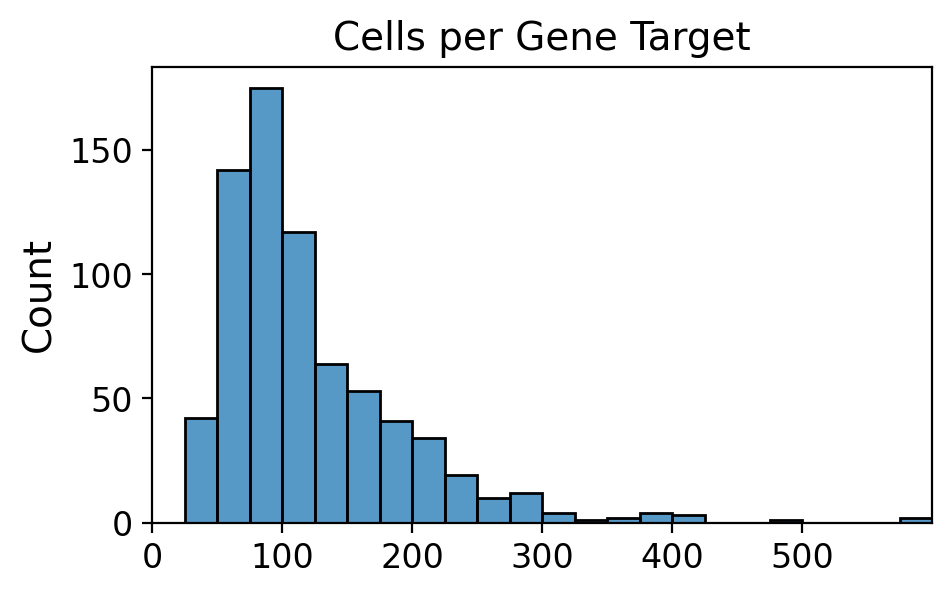

In [5]:
plot_histogram(adata[adata.obs.perturbed == "True"], 
               "gene_target", "Cells per Gene Target", 
               fig_size=(5,3), xtick_width=100)

In [7]:
adata[adata.obs.perturbed == "True"].obs.gene_target.value_counts()

gene_target
ZFP41     590
ZFP37     575
ADNP2     490
ZNF787    414
ESR1      410
         ... 
NFE4       35
ZIC2       30
GTF3A      30
ZNF335     26
ZNF408     26
Name: count, Length: 726, dtype: int64

### Test gene target pseudobulk dataset and chunks

Pseudobulk dataset with ~75 cells per NTC rep

In [37]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          approx_ntc_rep_size=75)

In [38]:
meta_gene_targets

condition  n-cells-in-rep
NTC-rep1           NTC              76
NTC-rep2           NTC              76
NTC-rep3           NTC              76
NTC-rep4           NTC              76
NTC-rep5           NTC              76
...                ...             ...
MYNN-rep2         MYNN              28
TBPL1-rep1       TBPL1              27
TBPL1-rep2       TBPL1              27
NANOGP8-rep1   NANOGP8              18
NANOGP8-rep2   NANOGP8              19

[2289 rows x 2 columns]

In [42]:
n_ntc_reps = len(meta_gene_targets[meta_gene_targets["condition"] == "NTC"])
n_pert_reps = len(meta_gene_targets[meta_gene_targets["condition"] != "NTC"])
print(f"# NTC reps: {n_ntc_reps}")
print(f"# perturbation reps: {n_pert_reps}")

# NTC reps: 177
# perturbation reps: 2112


In [43]:
counts_gene_targets

ENSG00000241860  ENSG00000290385  ENSG00000291215  LINC01409  \
NTC-rep1                    2                1                1          5   
NTC-rep2                    3                2                2          1   
NTC-rep3                    1                1                5          1   
NTC-rep4                    4                1                1          3   
NTC-rep5                    3                0                4          2   
...                       ...              ...              ...        ...   
MYNN-rep2                   1                0                1          3   
TBPL1-rep1                  3                1                2          1   
TBPL1-rep2                  2                0                1          0   
NANOGP8-rep1                0                0                0          1   
NANOGP8-rep2                0                0                1          0   

              LINC00115  LINC01128  NOC2L  KLHL17  ISG15  AGRN  ...  MT-ATP6  \
NTC-rep1              0          1     21       0      7     3  ...     2926   
NTC-rep2              1          3     18       2      6     7  ...     2866   
NTC-rep3              4          2     25       5     13     5  ...     3091   
NTC-rep4              0          5     27       0     14     9  ...     3190   
NTC-rep5              1          4     20       1      4     3  ...     2973   
...                 ...        ...    ...     ...    ...   ...  ...      ...   
MYNN-rep2             1          1      6       1      3     4  ...     1059   
TBPL1-rep1            0          0      5       0      2     2  ...     1277   
TBPL1-rep2            1          1      6       0      1     1  ...     1108   
NANOGP8-rep1          0          1      6       0      3     3  ...      606   
NANOGP8-rep2          0          0      2       1      3     0  ...      732   

              MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  \
NTC-rep1        5311     640       46    1287     278     194     991   
NTC-rep2        5290     603       34    1283     232     176     981   
NTC-rep3        5264     646       40    1384     240     172    1063   
NTC-rep4        5871     670       47    1507     250     189    1195   
NTC-rep5        5167     616       39    1289     242     156    1114   
...              ...     ...      ...     ...     ...     ...     ...   
MYNN-rep2       2073     275       21     488      96      80     399   
TBPL1-rep1      2378     284       13     601     114      71     462   
TBPL1-rep2      2157     233       18     484     106      59     384   
NANOGP8-rep1    1120     128       11     265      46      31     214   
NANOGP8-rep2    1278     129       13     296      49      45     241   

              ENSG00000276256  ENSG00000271254  
NTC-rep1                    2                1  
NTC-rep2                    5                1  
NTC-rep3                    2                3  
NTC-rep4                    3                2  
NTC-rep5                    0                0  
...                       ...              ...  
MYNN-rep2                   3                0  
TBPL1-rep1                  1                0  
TBPL1-rep2                  2                0  
NANOGP8-rep1                0                0  
NANOGP8-rep2                0                2  

[2289 rows x 16115 columns]

In [52]:
chunk_counts, chunk_meta, targets_per_chunk = \
    create_gene_target_DE_chunks(counts_gene_targets, meta_gene_targets,
                                 n_chunks=3)

2112 perturbation samples, 177 NTC samples, 3 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [31 30 30]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [243 242 241]
Total samples per chunk: [883 882 878]
Perturbed samples per chunk: [706 705 701]


In [53]:
chunk_meta[0]

condition  n-cells-in-rep
NTC-rep1          NTC              76
NTC-rep2          NTC              76
NTC-rep3          NTC              76
NTC-rep4          NTC              76
NTC-rep5          NTC              76
...               ...             ...
CREBZF-rep3    CREBZF              23
FOXP2-rep1      FOXP2              29
FOXP2-rep2      FOXP2              29
MYNN-rep1        MYNN              28
MYNN-rep2        MYNN              28

[883 rows x 2 columns]

Pseudobulk dataset with NTC gRNAs as reps

In [14]:
print(len(adata[adata.obs.perturbed == "False"].obs.gRNA.unique()))

227


In [17]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          ntc_gRNA_as_reps=True)

In [18]:
meta_gene_targets

condition  n-cells-in-rep
ESR2-rep1              ESR2              70
ESR2-rep2              ESR2              70
ESR2-rep3              ESR2              70
ZNF14-rep1            ZNF14              52
ZNF14-rep2            ZNF14              52
...                     ...             ...
Non-Targeting-81        NTC              35
Non-Targeting-250       NTC              30
Non-Targeting-735       NTC              46
Non-Targeting-906       NTC              36
Non-Targeting-890       NTC              29

[2339 rows x 2 columns]

In [19]:
n_ntc_reps = len(meta_gene_targets[meta_gene_targets["condition"] == "NTC"])
n_pert_reps = len(meta_gene_targets[meta_gene_targets["condition"] != "NTC"])
print(f"# NTC reps: {n_ntc_reps}")
print(f"# perturbation reps: {n_pert_reps}")

# NTC reps: 227
# perturbation reps: 2112


In [20]:
counts_gene_targets

ENSG00000241860  ENSG00000290385  ENSG00000291215  \
ESR2-rep1                        2                1                1   
ESR2-rep2                        1                2                3   
ESR2-rep3                        3                3                2   
ZNF14-rep1                       2                3                2   
ZNF14-rep2                       2                1                3   
...                            ...              ...              ...   
Non-Targeting-81                 0                2                1   
Non-Targeting-250                0                1                2   
Non-Targeting-735                5                0                1   
Non-Targeting-906                1                2                3   
Non-Targeting-890                0                2                0   

                   LINC01409  LINC00115  LINC01128  NOC2L  KLHL17  ISG15  \
ESR2-rep1                  9          2          4     29       1      9   
ESR2-rep2                  5          1          1     14       1      8   
ESR2-rep3                  1          0          4     22       0      9   
ZNF14-rep1                 1          1          1     15       3      1   
ZNF14-rep2                 1          1          1     15       1      5   
...                      ...        ...        ...    ...     ...    ...   
Non-Targeting-81           0          1          3     12       0      3   
Non-Targeting-250          3          1          3     10       2      2   
Non-Targeting-735          0          0          2     19       1      7   
Non-Targeting-906          2          1          0     13       0      4   
Non-Targeting-890          2          1          1      5       0      4   

                   AGRN  ...  MT-ATP6  MT-CO3  MT-ND3  MT-ND4L  MT-ND4  \
ESR2-rep1             6  ...     3304    5896     713       45    1489   
ESR2-rep2             7  ...     2746    4840     576       35    1157   
ESR2-rep3             9  ...     3017    5446     615       46    1222   
ZNF14-rep1            3  ...     2244    4164     494       26    1003   
ZNF14-rep2            3  ...     2380    4352     516       31    1056   
...                 ...  ...      ...     ...     ...      ...     ...   
Non-Targeting-81      6  ...     1155    2221     251       12     522   
Non-Targeting-250     2  ...     1172    2035     257       20     484   
Non-Targeting-735     2  ...     1918    3399     346       22     820   
Non-Targeting-906     0  ...     1537    2705     315       22     710   
Non-Targeting-890     4  ...     1185    1835     271       15     493   

                   MT-ND5  MT-ND6  MT-CYB  ENSG00000276256  ENSG00000271254  
ESR2-rep1             258     178    1200                8                0  
ESR2-rep2             223     183     985                2                1  
ESR2-rep3             248     179    1027                4                3  
ZNF14-rep1            183     148     811                5                1  
ZNF14-rep2            180     105     882                3                1  
...                   ...     ...     ...              ...              ...  
Non-Targeting-81       95      72     432                3                2  
Non-Targeting-250     114      74     441                1                0  
Non-Targeting-735     136      99     699                4                2  
Non-Targeting-906     109      91     527                0                2  
Non-Targeting-890      70      73     396                0                1  

[2339 rows x 16115 columns]

In [21]:
chunk_counts, chunk_meta, targets_per_chunk = \
    create_gene_target_DE_chunks(counts_gene_targets, meta_gene_targets,
                                 n_chunks=3)

2112 perturbation samples, 227 NTC samples, 3 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [31 30 30]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [243 242 241]
Total samples per chunk: [933 932 928]
Perturbed samples per chunk: [706 705 701]


### Test using NTC gRNA as reps

In [9]:
adata_ntc_counts = pd.DataFrame(adata[adata.obs.perturbed == "False"].obs.gRNA.value_counts())
adata_ntc_counts

count
gRNA                    
Non-Targeting_747    123
Non-Targeting_471    116
Non-Targeting_767    109
Non-Targeting_329    102
Non-Targeting_688    101
...                  ...
Non-Targeting_890     29
Non-Targeting_622     29
Non-Targeting_421     29
Non-Targeting_665     28
Non-Targeting_722     26

[227 rows x 1 columns]

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(adata: ad.AnnData, obs_key: str, title: str="",
                    fig_size: tuple=(4,3), bin_width=25, xtick_width=50):
    plt.figure(figsize=fig_size)
    adata_xmax = max(adata.obs[obs_key].value_counts().values)
    xmax = ((adata_xmax // bin_width) + 1) * bin_width
    sns.histplot(adata.obs[obs_key].value_counts().values, binwidth=bin_width,
        binrange=(0,xmax))
    plt.xlim(0, xmax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

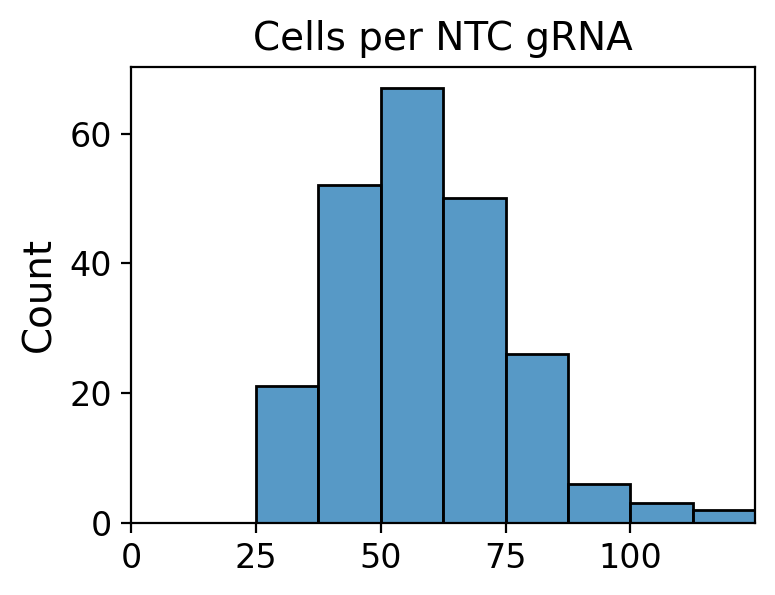

In [23]:
plot_histogram(adata[adata.obs.perturbed == "False"], obs_key="gRNA", 
               title="Cells per NTC gRNA", bin_width=12.5, xtick_width=25)

### Gene target DE

3 chunks, 75 cells per NTC rep, random seed = 42

In [ ]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          approx_ntc_rep_size=75,
                                          random_state=42)

In [ ]:
# ~20 min per chunk, 1hr total
de_results_gene_targets, dds_objects_gene_targets = \
    run_gene_target_dataset_DE(adata, 
                                counts_df=counts_gene_targets,
                                metadata_df=meta_gene_targets,
                                n_chunks=3, n_cpus=75,
                                approx_ntc_rep_size=75,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                return_dds_objects=True)

Creating chunk pseudobulk datasets
2112 perturbation samples, 177 NTC samples, 3 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [31 30 30]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [243 242 241]
Total samples per chunk: [883 882 878]
Perturbed samples per chunk: [706 705 701]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 651.68 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 39.36 seconds.

Fitting LFCs...
... done in 35.14 seconds.

Calculating cook's distance...
... done in 0.85 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/243 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 581.69 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 43.57 seconds.

Fitting LFCs...
... done in 34.11 seconds.

Calculating cook's distance...
... done in 0.80 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/242 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 324.64 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 38.57 seconds.

Fitting LFCs...
... done in 34.51 seconds.

Calculating cook's distance...
... done in 0.83 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/241 [00:00<?, ?it/s]

In [2]:
# plot_dispersions_chunks(dds_objects_gene_targets, 
#                         "Gene Target DE Dispersion Plots")

In [58]:
de_results_df_gene_targets = build_DE_df(de_results_gene_targets)
de_results_df_gene_targets.head()

TFAP2E_baseMean  TFAP2E_log2FoldChange  TFAP2E_lfcSE  TFAP2E_stat  \
A1BG              4.481637              -1.958601      3.352169    -0.584279   
A1BG-AS1          0.682313               6.084735      8.560661     0.710779   
A2M               0.595126              -1.679852      8.636258    -0.194512   
A2ML1             2.211152             -10.480915      5.067828    -2.068128   
A2ML1-AS1         6.241671               3.181225      2.827384     1.125148   

           TFAP2E_pvalue  TFAP2E_padj  ZKSCAN7_baseMean  \
A1BG            0.559033     0.999994          4.481637   
A1BG-AS1        0.477221     0.999994          0.682313   
A2M             0.845775     0.999994          0.595126   
A2ML1           0.038628     0.999994          2.211152   
A2ML1-AS1       0.260526     0.999994          6.241671   

           ZKSCAN7_log2FoldChange  ZKSCAN7_lfcSE  ZKSCAN7_stat  ...  \
A1BG                    -2.103268       3.383865     -0.621558  ...   
A1BG-AS1                 6.015374       8.637639      0.696414  ...   
A2M                     -3.269715       8.921010     -0.366518  ...   
A2ML1                   -9.378084       5.055828     -1.854906  ...   
A2ML1-AS1                2.721104       2.864874      0.949816  ...   

           SIX6_lfcSE  SIX6_stat  SIX6_pvalue  SIX6_padj  ESRRG_baseMean  \
A1BG         1.249319   0.375601     0.707213   0.999999        4.312653   
A1BG-AS1     2.976280  -1.647854     0.099383   0.999999        0.662995   
A2M          3.143968   0.146628     0.883425   0.999999        0.611842   
A2ML1        1.751494   1.139094     0.254664   0.999999        2.175513   
A2ML1-AS1    1.046061  -0.579230     0.562434   0.999999        5.942627   

           ESRRG_log2FoldChange  ESRRG_lfcSE  ESRRG_stat  ESRRG_pvalue  \
A1BG                   0.085439     0.471577    0.181177      0.856229   
A1BG-AS1              -0.886173     1.067179   -0.830388      0.406319   
A2M                    0.284319     1.185385    0.239853      0.810444   
A2ML1                  0.386889     0.679070    0.569733      0.568859   
A2ML1-AS1             -0.279620     0.395149   -0.707630      0.479175   

           ESRRG_padj  
A1BG         0.999952  
A1BG-AS1     0.999952  
A2M          0.999952  
A2ML1        0.999952  
A2ML1-AS1    0.999952  

[5 rows x 4356 columns]

In [59]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_75ntc.pkl"
de_results_df_gene_targets.to_pickle(filepath_pkl)

In [60]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [63]:
gene_target_n_cells_degs_df5 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.05)

In [66]:
gene_target_n_cells_degs_df10 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.1)

In [77]:
gene_target_n_cells_degs_df10[gene_target_n_cells_degs_df10["n_DEGs"] > 3]

n_cells  n_DEGs
gene_target                 
ARID2            217      35
FOXG1            213       5
FOXH1            302      99
GATA5            210      94
KLF14            304       7
PKNOX2           211       4
POU5F1           106       5
RFX5             154       4
SHOX             194       5
SOX4             217     110
TIGD3            220     133

In [74]:
gene_target_n_cells_degs_df10.loc[gene_target_n_cells_degs_df10.index.isin(["POU5F1", "NANOG"])]

n_cells  n_DEGs
gene_target                 
NANOG            119       1
POU5F1           106       5

In [65]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [69]:
df_list = [gene_target_n_cells_degs_df5, gene_target_n_cells_degs_df10]
df_rows = ["3 chunks, 75 NTC cells per rep, padj < 0.05", 
           "3 chunks, 75 NTC cells per rep, padj < 0.1"]
res_df = \
    build_DE_method_comparison_df(df_list, df_rows)
res_df

gRNAs w/ 0 DEGs  >0 DEGs  \
3 chunks, 75 NTC cells per rep, padj < 0.05              601      125   
3 chunks, 75 NTC cells per rep, padj < 0.1               468      258   

                                             ≥3 DEGs  ≥10 DEGs  
3 chunks, 75 NTC cells per rep, padj < 0.05        9         5  
3 chunks, 75 NTC cells per rep, padj < 0.1        17         5

3 chunks, NTC gRNAs as NTC reps, random seed = 42

In [ ]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=42)

In [22]:
de_results_gene_targets, dds_objects_gene_targets = \
    run_gene_target_dataset_DE(adata, 
                                counts_df=counts_gene_targets,
                                metadata_df=meta_gene_targets,
                                n_chunks=3, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                return_dds_objects=True)

Creating chunk pseudobulk datasets
2112 perturbation samples, 227 NTC samples, 3 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [31 30 30]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [243 242 241]
Total samples per chunk: [933 932 928]
Perturbed samples per chunk: [706 705 701]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.33 seconds.

Fitting dispersions...
... done in 361.46 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 41.17 seconds.

Fitting LFCs...
... done in 33.70 seconds.

Calculating cook's distance...
... done in 0.83 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/243 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 384.76 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 39.85 seconds.

Fitting LFCs...
... done in 34.58 seconds.

Calculating cook's distance...
... done in 0.79 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/242 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 421.84 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 37.67 seconds.

Fitting LFCs...
... done in 35.51 seconds.

Calculating cook's distance...
... done in 0.85 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/241 [00:00<?, ?it/s]

In [11]:
# plot_dispersions_chunks(dds_objects_gene_targets, 
#                         "Gene Target DE Dispersion Plots")

In [24]:
de_results_df_gene_targets = build_DE_df(de_results_gene_targets)
de_results_df_gene_targets.head()

TFAP2E_baseMean  TFAP2E_log2FoldChange  TFAP2E_lfcSE  TFAP2E_stat  \
A1BG              4.288014               0.215774      0.603310     0.357650   
A1BG-AS1          0.654281               0.125053      1.466596     0.085267   
A2M               0.563516               0.771556      1.476445     0.522576   
A2ML1             2.080172               0.228122      1.044360     0.218432   
A2ML1-AS1         5.946591               0.477421      0.501640     0.951722   

           TFAP2E_pvalue  TFAP2E_padj  ZKSCAN7_baseMean  \
A1BG            0.720605     0.999818          4.288014   
A1BG-AS1        0.932049     0.999818          0.654281   
A2M             0.601269     0.999818          0.563516   
A2ML1           0.827092     0.999818          2.080172   
A2ML1-AS1       0.341238     0.999818          5.946591   

           ZKSCAN7_log2FoldChange  ZKSCAN7_lfcSE  ZKSCAN7_stat  ...  \
A1BG                     0.092251       0.603846      0.152772  ...   
A1BG-AS1                -0.001957       1.468084     -0.001333  ...   
A2M                     -0.794152       2.399144     -0.331015  ...   
A2ML1                    1.430906       0.684694      2.089846  ...   
A2ML1-AS1               -0.004348       0.563476     -0.007717  ...   

           SIX6_lfcSE  SIX6_stat  SIX6_pvalue  SIX6_padj  ESRRG_baseMean  \
A1BG         0.305996  -2.346219     0.018965   0.815784        4.136067   
A1BG-AS1     0.633151   0.259516     0.795237   0.999988        0.638291   
A2M          0.657282   0.555595     0.578488   0.987858        0.579372   
A2ML1        0.365398  -0.716801     0.473497   0.986759        2.048557   
A2ML1-AS1    0.210733   0.245300     0.806224   0.999988        5.675613   

           ESRRG_log2FoldChange  ESRRG_lfcSE  ESRRG_stat  ESRRG_pvalue  \
A1BG                  -0.300046     0.253307   -1.184514      0.236210   
A1BG-AS1               0.851325     0.467333    1.821665      0.068506   
A2M                    0.253867     0.631455    0.402036      0.687658   
A2ML1                 -0.418370     0.374944   -1.115822      0.264498   
A2ML1-AS1             -0.065157     0.205259   -0.317440      0.750910   

           ESRRG_padj  
A1BG         0.921599  
A1BG-AS1     0.828367  
A2M          0.990020  
A2ML1        0.923641  
A2ML1-AS1    0.997073  

[5 rows x 4356 columns]

In [25]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results_df_gene_targets.to_pickle(filepath_pkl)

In [27]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [ ]:
gene_target_n_cells_degs_df5 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.05)

In [29]:
gene_target_n_cells_degs_df10 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.1)

In [30]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [32]:
df_list = [gene_target_n_cells_degs_df5, gene_target_n_cells_degs_df10]
df_rows = ["3 chunks, NTC gRNAs as reps, padj < 0.05", 
           "3 chunks, NTC gRNAs as reps, padj < 0.1"]
res_df = \
    build_DE_method_comparison_df(df_list, df_rows)
res_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  \
3 chunks, NTC gRNAs as reps, padj < 0.05              202      524      352   
3 chunks, NTC gRNAs as reps, padj < 0.1               123      603      472   

                                          ≥10 DEGs  
3 chunks, NTC gRNAs as reps, padj < 0.05       187  
3 chunks, NTC gRNAs as reps, padj < 0.1        247

In [33]:
gene_target_n_cells_degs_df10[gene_target_n_cells_degs_df10["n_DEGs"] > 3]

n_cells  n_DEGs
gene_target                 
ADNP2            490      50
AHR               83       4
ANKZF1           107       6
ARHGAP35         388      18
ARID2            217      59
...              ...     ...
ZNF888            89      11
ZSCAN4            74      13
ZSCAN21           80       6
ZSCAN30           82       7
ZXDC             104      13

[423 rows x 2 columns]

2 chunks, NTC gRNAs as reps, random seed 42

In [13]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=42)

In [ ]:
# 132 min (2hrs 12min)
de_results_gene_targets, dds_objects_gene_targets = \
    run_gene_target_dataset_DE(adata, 
                                counts_df=counts_gene_targets,
                                metadata_df=meta_gene_targets,
                                n_chunks=2, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                return_dds_objects=True)

Creating chunk pseudobulk datasets
2112 perturbation samples, 227 NTC samples, 2 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [46 45]
Number of targets with 3 reps per chunk: [309 309]
Number of targets with 4+ reps per chunk: [9 8]
Total number of targets per chunk: [364 362]
Total samples per chunk: [1287 1279]
Perturbed samples per chunk: [1060 1052]
Running DE analysis on chunk 1 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.45 seconds.

Fitting dispersions...
... done in 1630.53 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 123.42 seconds.

Fitting LFCs...
... done in 93.09 seconds.

Calculating cook's distance...
... done in 1.22 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/364 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.47 seconds.

Fitting dispersions...
... done in 1181.47 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 109.00 seconds.

Fitting LFCs...
... done in 92.41 seconds.

Calculating cook's distance...
... done in 1.18 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/362 [00:00<?, ?it/s]

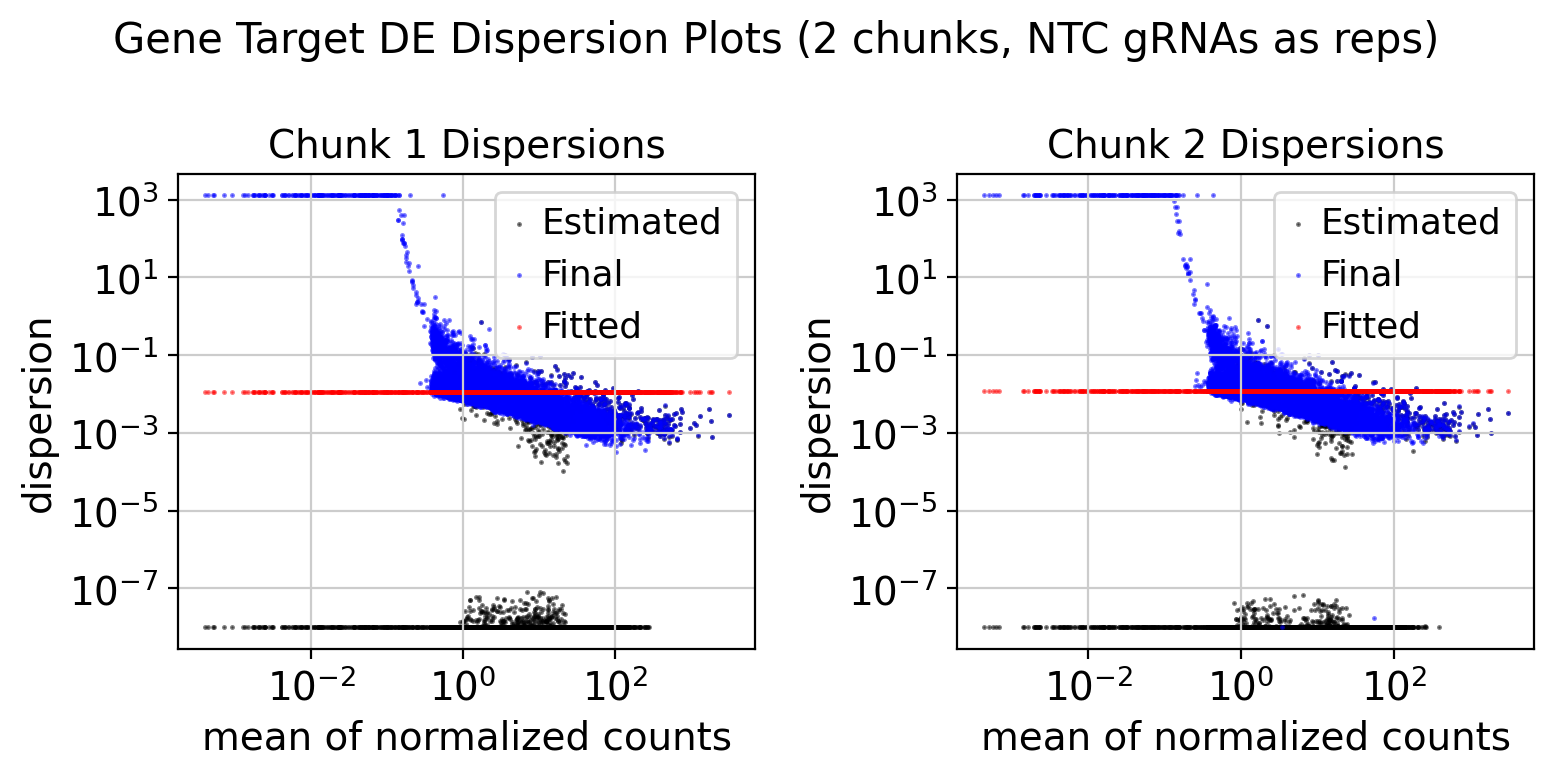

In [15]:
plot_dispersions_chunks(dds_objects_gene_targets, 
                        "Gene Target DE Dispersion Plots (2 chunks, NTC gRNAs as reps)")

In [16]:
de_results_df_gene_targets = build_DE_df(de_results_gene_targets)
de_results_df_gene_targets.head()

TFAP2E_baseMean  TFAP2E_log2FoldChange  TFAP2E_lfcSE  TFAP2E_stat  \
A1BG              4.176628               0.217014      0.602469     0.360208   
A1BG-AS1          0.644924               0.123420      1.467020     0.084130   
A2M               0.575986               0.773476      1.476857     0.523732   
A2ML1             2.077993               0.219569      1.043219     0.210473   
A2ML1-AS1         5.818484               0.477559      0.502818     0.949764   

           TFAP2E_pvalue  TFAP2E_padj  ZKSCAN7_baseMean  \
A1BG            0.718692     0.999924          4.176628   
A1BG-AS1        0.932953     0.999924          0.644924   
A2M             0.600465     0.999924          0.575986   
A2ML1           0.833299     0.999924          2.077993   
A2ML1-AS1       0.342232     0.999924          5.818484   

           ZKSCAN7_log2FoldChange  ZKSCAN7_lfcSE  ZKSCAN7_stat  ...  \
A1BG                     0.094228       0.602963      0.156275  ...   
A1BG-AS1                -0.003228       1.468560     -0.002198  ...   
A2M                     -0.791766       2.399376     -0.329988  ...   
A2ML1                    1.422928       0.682847      2.083817  ...   
A2ML1-AS1               -0.003505       0.564491     -0.006210  ...   

           SIX6_lfcSE  SIX6_stat  SIX6_pvalue  SIX6_padj  ESRRG_baseMean  \
A1BG         0.305716  -2.340826     0.019241   0.818251        4.078025   
A1BG-AS1     0.633523   0.254977     0.798741   0.999867        0.630484   
A2M          0.655990   0.558418     0.576559   0.989006        0.567564   
A2ML1        0.364143  -0.725097     0.468393   0.988069        2.003069   
A2ML1-AS1    0.212265   0.252949     0.800308   0.999867        5.578423   

           ESRRG_log2FoldChange  ESRRG_lfcSE  ESRRG_stat  ESRRG_pvalue  \
A1BG                  -0.298817     0.253044   -1.180889      0.237647   
A1BG-AS1               0.849495     0.467752    1.816124      0.069351   
A2M                    0.254574     0.630382    0.403841      0.686329   
A2ML1                 -0.419726     0.374022   -1.122195      0.261780   
A2ML1-AS1             -0.064029     0.206464   -0.310124      0.756467   

           ESRRG_padj  
A1BG         0.922434  
A1BG-AS1     0.828402  
A2M          0.991164  
A2ML1        0.922434  
A2ML1-AS1    0.997583  

[5 rows x 4356 columns]

In [17]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_2chunks_ntc_gRNA_reps.pkl"
de_results_df_gene_targets.to_pickle(filepath_pkl)

In [18]:
gene_target_n_cells_degs_df5 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.05)

In [19]:
gene_target_n_cells_degs_df10 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.1)

In [20]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [21]:
df_list = [gene_target_n_cells_degs_df5, gene_target_n_cells_degs_df10]
df_rows = ["2 chunks, NTC gRNAs as reps, padj < 0.05", 
           "2 chunks, NTC gRNAs as reps, padj < 0.1"]
res_df = \
    build_DE_method_comparison_df(df_list, df_rows)
res_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  \
2 chunks, NTC gRNAs as reps, padj < 0.05              217      509      335   
2 chunks, NTC gRNAs as reps, padj < 0.1               137      589      449   

                                          ≥10 DEGs  
2 chunks, NTC gRNAs as reps, padj < 0.05       184  
2 chunks, NTC gRNAs as reps, padj < 0.1        237

In [27]:
gene_target_n_cells_degs_df10.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gene_target                 
POU5F1           106    2674
POU5F1B           44    1365
PHF20             46    1126
POU3F2            50     970
ZNF521            83     814
DNMT1            147     658
NANOG            119     612
PURG              63     365
PRDM14            95     334
ZNF396           168     282

2 chunks, NTC gRNAs as reps, random seed 67

In [10]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=67)

In [ ]:
# 129 min (2hrs 9min)
de_results_gene_targets, dds_objects_gene_targets = \
    run_gene_target_dataset_DE(adata, 
                                counts_df=counts_gene_targets,
                                metadata_df=meta_gene_targets,
                                n_chunks=2, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=67,
                                return_dds_objects=True)

Creating chunk pseudobulk datasets
2112 perturbation samples, 227 NTC samples, 2 chunks
91 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [46 45]
Number of targets with 3 reps per chunk: [309 309]
Number of targets with 4+ reps per chunk: [9 8]
Total number of targets per chunk: [364 362]
Total samples per chunk: [1285 1281]
Perturbed samples per chunk: [1058 1054]
Running DE analysis on chunk 1 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.43 seconds.

Fitting dispersions...
... done in 1444.14 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 114.40 seconds.

Fitting LFCs...
... done in 92.00 seconds.

Calculating cook's distance...
... done in 1.23 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/364 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.46 seconds.

Fitting dispersions...
... done in 1209.33 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 107.03 seconds.

Fitting LFCs...
... done in 92.99 seconds.

Calculating cook's distance...
... done in 1.14 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/362 [00:00<?, ?it/s]

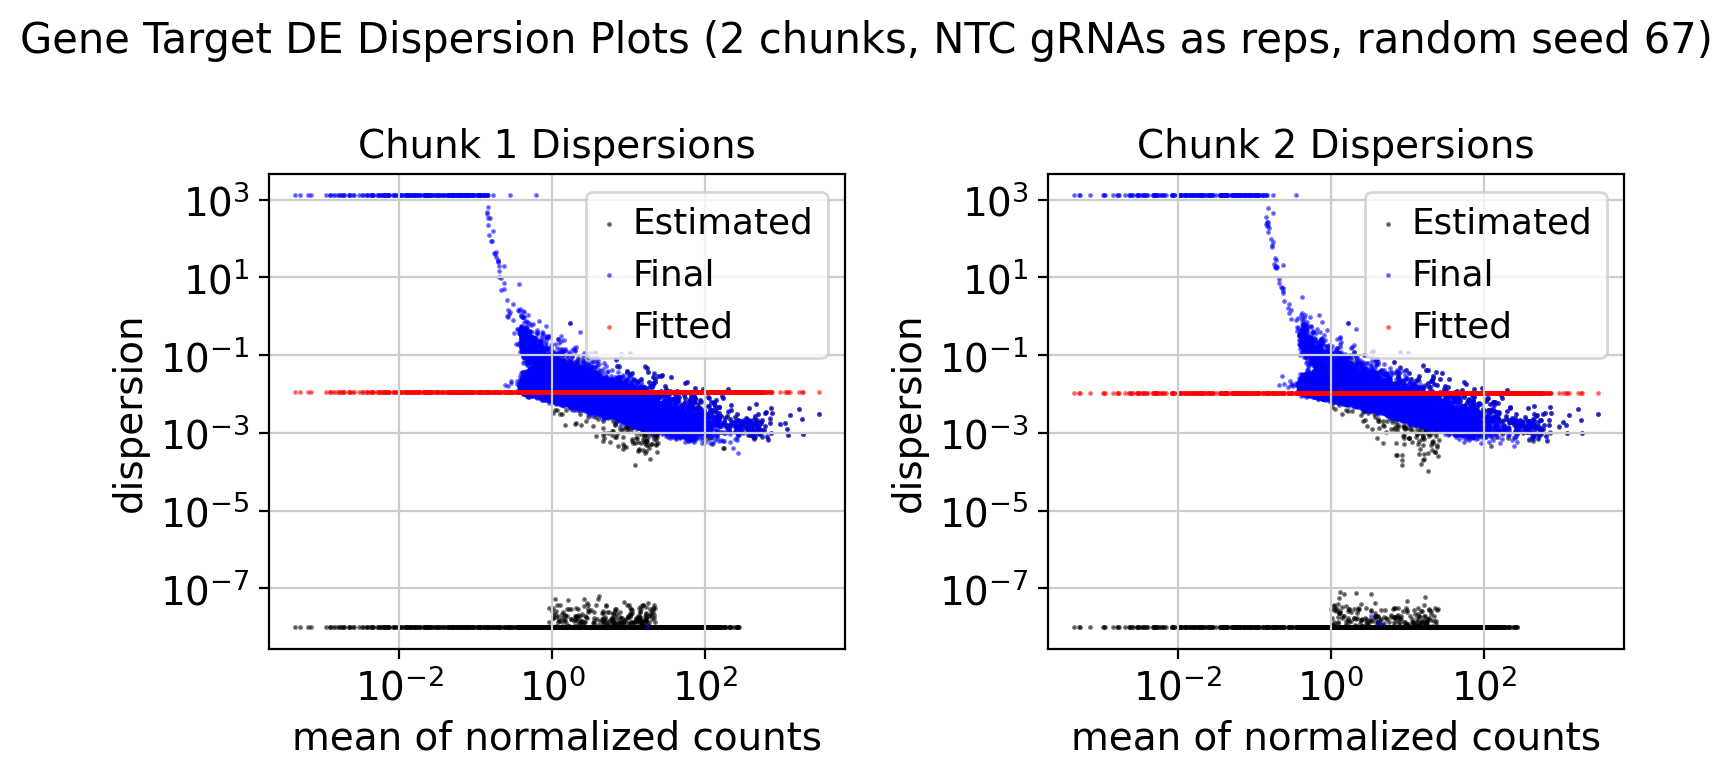

In [14]:
plot_dispersions_chunks(dds_objects_gene_targets, 
                        "Gene Target DE Dispersion Plots (2 chunks, NTC gRNAs as reps, random seed 67)")

In [15]:
de_results_df_gene_targets = build_DE_df(de_results_gene_targets)
de_results_df_gene_targets.head()

POU5F1B_baseMean  POU5F1B_log2FoldChange  POU5F1B_lfcSE  \
A1BG               4.098431                0.987475       0.526453   
A1BG-AS1           0.628405                0.483749       1.469965   
A2M                0.589648                1.123892       1.476075   
A2ML1              2.015706               -0.402922       1.452593   
A2ML1-AS1          5.699464                0.007139       0.654733   

           POU5F1B_stat  POU5F1B_pvalue  POU5F1B_padj  THAP3_baseMean  \
A1BG           1.875713        0.060695      0.359198        4.098431   
A1BG-AS1       0.329089        0.742089      0.993236        0.628405   
A2M            0.761406        0.446415      0.883453        0.589648   
A2ML1         -0.277381        0.781487      0.999897        2.015706   
A2ML1-AS1      0.010904        0.991300      0.999897        5.699464   

           THAP3_log2FoldChange  THAP3_lfcSE  THAP3_stat  ...  VDR_lfcSE  \
A1BG                  -0.696219     0.731039   -0.952369  ...   0.248276   
A1BG-AS1              -0.158239     1.463011   -0.108160  ...   0.624191   
A2M                    0.442657     1.467370    0.301667  ...   0.921313   
A2ML1                  0.849657     0.738489    1.150534  ...   0.327973   
A2ML1-AS1              0.576364     0.429068    1.343295  ...   0.215094   

           VDR_stat  VDR_pvalue  VDR_padj  FOXH1_baseMean  \
A1BG       0.208570    0.834784  0.999971        4.152778   
A1BG-AS1   0.381954    0.702495  0.999971        0.643840   
A2M       -0.565635    0.571642  0.997942        0.553574   
A2ML1      0.673211    0.500813  0.997942        2.065287   
A2ML1-AS1  0.371831    0.710019  0.999971        5.692518   

           FOXH1_log2FoldChange  FOXH1_lfcSE  FOXH1_stat  FOXH1_pvalue  \
A1BG                   0.198871     0.249635    0.796646      0.425656   
A1BG-AS1              -0.191807     0.739823   -0.259261      0.795434   
A2M                    0.446988     0.740802    0.603384      0.546253   
A2ML1                  0.183018     0.362330    0.505116      0.613477   
A2ML1-AS1             -0.096102     0.240653   -0.399338      0.689644   

           FOXH1_padj  
A1BG         0.956421  
A1BG-AS1     0.997834  
A2M          0.972115  
A2ML1        0.978831  
A2ML1-AS1    0.990604  

[5 rows x 4356 columns]

In [16]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_2chunks_ntc_gRNA_reps_seed67.pkl"
de_results_df_gene_targets.to_pickle(filepath_pkl)

In [17]:
gene_target_n_cells_degs_df5 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.05)

In [18]:
gene_target_n_cells_degs_df10 = \
    build_n_cells_degs_df(de_results_df_gene_targets, adata, 
                          target_type="gene_target", alpha=0.1)

In [3]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [20]:
df_list = [gene_target_n_cells_degs_df5, gene_target_n_cells_degs_df10]
df_rows = ["2 chunks, NTC gRNAs as reps, padj < 0.05", 
           "2 chunks, NTC gRNAs as reps, padj < 0.1"]
res_df = \
    build_DE_method_comparison_df(df_list, df_rows)
res_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  \
2 chunks, NTC gRNAs as reps, padj < 0.05              216      510      334   
2 chunks, NTC gRNAs as reps, padj < 0.1               134      592      456   

                                          ≥10 DEGs  
2 chunks, NTC gRNAs as reps, padj < 0.05       179  
2 chunks, NTC gRNAs as reps, padj < 0.1        235

In [21]:
gene_target_n_cells_degs_df10.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gene_target                 
POU5F1           106    2690
POU5F1B           44    1364
PHF20             46    1117
POU3F2            50     987
ZNF521            83     820
DNMT1            147     670
NANOG            119     629
PURG              63     357
PRDM14            95     341
ZNF396           168     287

### Compare methods

In [2]:
import pandas as pd
import anndata as ad

In [3]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
de_df_3chunks = pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl")
de_df_42 = pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_gene_targets_2chunks_ntc_gRNA_reps.pkl")
de_df_67 = pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_gene_targets_2chunks_ntc_gRNA_reps_seed67.pkl")

In [5]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [6]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [7]:
three_chunks_df5 = build_n_cells_degs_df(de_df_3chunks, adata, 
                        target_type="gene_target", alpha=0.05)
two_chunks_42_df5 = build_n_cells_degs_df(de_df_42, adata, 
                        target_type="gene_target", alpha=0.05)
two_chunks_67_df5 = build_n_cells_degs_df(de_df_67, adata, 
                        target_type="gene_target", alpha=0.05)

In [8]:
three_chunks_df10 = build_n_cells_degs_df(de_df_3chunks, adata, 
                        target_type="gene_target", alpha=0.1)
two_chunks_42_df10 = build_n_cells_degs_df(de_df_42, adata, 
                        target_type="gene_target", alpha=0.1)
two_chunks_67_df10 = build_n_cells_degs_df(de_df_67, adata, 
                        target_type="gene_target", alpha=0.1)

In [9]:
df_list = [three_chunks_df10, two_chunks_42_df10, two_chunks_67_df10]
df_rows = ["3 chunks, seed=42, padj < 0.1", 
           "2 chunks, seed=42, padj < 0.1",
           "2 chunks, seed=67, padj < 0.1"]
comparison_df_10 = \
    build_DE_method_comparison_df(df_list, df_rows)
comparison_df_10

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
3 chunks, seed=42, padj < 0.1              123      603      472       247
2 chunks, seed=42, padj < 0.1              137      589      449       237
2 chunks, seed=67, padj < 0.1              134      592      456       235

In [10]:
df_list = [three_chunks_df5, two_chunks_42_df5, two_chunks_67_df5]
df_rows = ["3 chunks, seed=42, padj < 0.05", 
           "2 chunks, seed=42, padj < 0.05",
           "2 chunks, seed=67, padj < 0.05"]
comparison_df_5 = \
    build_DE_method_comparison_df(df_list, df_rows)
comparison_df_5

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
3 chunks, seed=42, padj < 0.05              202      524      352       187
2 chunks, seed=42, padj < 0.05              217      509      335       184
2 chunks, seed=67, padj < 0.05              216      510      334       179

In [11]:
comparison_df_5["Total # DEGs"] = [5054, 5062, 5037]
comparison_df_5

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs  \
3 chunks, seed=42, padj < 0.05              202      524      352       187   
2 chunks, seed=42, padj < 0.05              217      509      335       184   
2 chunks, seed=67, padj < 0.05              216      510      334       179   

                                Total # DEGs  
3 chunks, seed=42, padj < 0.05          5054  
2 chunks, seed=42, padj < 0.05          5062  
2 chunks, seed=67, padj < 0.05          5037

In [12]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(deg_df.loc[(abs(deg_df[l2fc_col]) > lfc_threshold) 
                                   & (deg_df[padj_col] < padj_threshold)].index)
    return lfc_degs

In [13]:
degs_3_chunks_padj5_lfc25 = filter_degs_lfc(de_df_3chunks, lfc_threshold=0.25, padj_threshold=0.05)
print(len(degs_3_chunks_padj5_lfc25))
degs_2_chunks_padj5_lfc25_42 = filter_degs_lfc(de_df_42, lfc_threshold=0.25, padj_threshold=0.05)
print(len(degs_2_chunks_padj5_lfc25_42))
degs_2_chunks_padj5_lfc25_67 = filter_degs_lfc(de_df_67, lfc_threshold=0.25, padj_threshold=0.05)
print(len(degs_2_chunks_padj5_lfc25_67))

5054
5062
5037


In [16]:
degs_3_chunks_padj10_lfc0 = filter_degs_lfc(de_df_3chunks, lfc_threshold=0, padj_threshold=0.1)
print(len(degs_3_chunks_padj10_lfc0))
degs_2_chunks_padj10_lfc0_42 = filter_degs_lfc(de_df_42, lfc_threshold=0, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc0_42))
degs_2_chunks_padj10_lfc0_67 = filter_degs_lfc(de_df_67, lfc_threshold=0, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc0_67))

6762
6747
6805


In [14]:
degs_3_chunks_padj10_lfc25 = filter_degs_lfc(de_df_3chunks, lfc_threshold=0.25, padj_threshold=0.1)
print(len(degs_3_chunks_padj10_lfc25))
degs_2_chunks_padj10_lfc25_42 = filter_degs_lfc(de_df_42, lfc_threshold=0.25, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc25_42))
degs_2_chunks_padj10_lfc25_67 = filter_degs_lfc(de_df_67, lfc_threshold=0.25, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc25_67))

6745
6730
6789


In [15]:
degs_3_chunks_padj10_lfc5 = filter_degs_lfc(de_df_3chunks, lfc_threshold=0.5, padj_threshold=0.1)
print(len(degs_3_chunks_padj10_lfc5))
degs_2_chunks_padj10_lfc5_42 = filter_degs_lfc(de_df_42, lfc_threshold=0.5, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc5_42))
degs_2_chunks_padj10_lfc5_67 = filter_degs_lfc(de_df_67, lfc_threshold=0.5, padj_threshold=0.1)
print(len(degs_2_chunks_padj10_lfc5_67))

6299
6283
6348


In [28]:
comparison_df_10["Total # DEGs"] = [6745, 6730, 6789]
comparison_df_10

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs  \
3 chunks, seed=42, padj < 0.1              123      603      472       247   
2 chunks, seed=42, padj < 0.1              137      589      449       237   
2 chunks, seed=67, padj < 0.1              134      592      456       235   

                               Total # DEGs  
3 chunks, seed=42, padj < 0.1          6745  
2 chunks, seed=42, padj < 0.1          6730  
2 chunks, seed=67, padj < 0.1          6789

# Fall 2025 Week 9

Testing LFC shrinkage overflow warning

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings from PyDESeq2
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, 
                 alpha: float = 0.05, quiet: bool = False,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds_quiet = True if quiet else False
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=dds_quiet
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
# create_gene_target_pseudobulk_dataset()

import math

def create_gene_target_pseudobulk_dataset(adata: ad.AnnData,
                                        layer: str = "counts",
                                        min_cells_for_3_reps: int = 60,
                                        max_cells_per_rep: int = 100,
                                        ntc_gRNA_as_reps: bool = True,
                                        approx_ntc_rep_size: int = 50,
                                        random_state: int = 42,
                                        gene_target_obs_col: str = "gene_target",
                                        ntc_target_delimiter: str = "NTC"
                                        ):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for each
    gene target. Default perturbation rep size: use 2 reps for a gene target 
    if <60 cells, 3 reps if 60-300 cells, and >3 reps of max 100 cells if >300 cells.
    If ntc_gRNA_as_reps is True, use each NTC gRNA as a NTC replicate. 
    If ntc_gRNA_as_reps is False, create NTC pseudoreps of ~approx_ntc_rep_size.
    """
    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Get gene targets
    targets = adata.obs[gene_target_obs_col].unique().tolist()
    if ntc_gRNA_as_reps:
        targets.remove(ntc_target_delimiter)

    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[gene_target_obs_col] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target == ntc_target_delimiter:
            if ntc_gRNA_as_reps:
                continue
            # Create NTC reps of ~approx_ntc_rep_size as evenly as possible
            else:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
        # Create perturbation reps
        else:
            if n_target_cells < min_cells_for_3_reps: # 2 reps
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            elif (n_target_cells >= min_cells_for_3_reps) & \
                    (n_target_cells <= 3*max_cells_per_rep): # 3 reps
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
            else: # >3 reps
                n_reps = math.ceil(n_target_cells / max_cells_per_rep)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        metadata_condition += ([target_hyphenated]*n_reps)
            
    # If using NTC gRNAs as reps
    if ntc_gRNA_as_reps:
        ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
        for ntc_gRNA in ntc_gRNAs:
            target_indices = np.where(adata.obs.gRNA == ntc_gRNA)[0]
            target_data = data_matrix[target_indices]
            target_counts = np.sum(target_data, axis=0).astype(np.int64)
            # Update counts
            counts_arrays.append(target_counts.reshape(1, -1))
            counts_df_index.append(ntc_gRNA.replace("_", "-"))
            # Update metadata
            metadata_n_cells.append(target_data.shape[0])
            metadata_condition.append("NTC")

    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def create_gene_target_DE_chunks(adata: ad.AnnData,
                                 counts_df: pd.DataFrame, 
                                 metadata_df: pd.DataFrame,
                                 max_chunk_size: int = 1100, 
                                 n_chunks=None,
                                 min_cells_for_3_reps: int = 60,
                                 max_cells_per_rep: int = 100,
                                 random_state: int = 42,
                                 gene_target_obs_col: str = "gene_target"):
    """
    Divide gene target DE pseudobulk dataset into chunks that each contain all 
    NTC replicates and a subset of perturbations.
    """
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    if n_chunks is None:
        n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[gene_target_obs_col].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = (target_counts_df["count"] >= min_cells_for_3_reps) & \
                        (target_counts_df["count"] <= 3*max_cells_per_rep)
    four_or_more_reps_mask = target_counts_df["count"] > 3*max_cells_per_rep
    n_rep_sizes = 3
    n_targets_per_rep_size = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask]),
         len(target_counts_df[four_or_more_reps_mask])] # n targets for each rep size
    print(f"{n_targets_per_rep_size[0]} targets with 2 reps, "
          f"{n_targets_per_rep_size[1]} targets with 3 reps, "
          f"{n_targets_per_rep_size[2]} targets with 4+ reps")
    n_chunk_targets_per_rep_size = np.zeros((n_rep_sizes, n_chunks), dtype=int)
    for i in range(n_rep_sizes):
        n_targets = n_targets_per_rep_size[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_per_rep_size[i] = np.array(n_targets_per_chunk)
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_per_rep_size[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_per_rep_size[1]}")
    print(f"Number of targets with 4+ reps per chunk: {n_chunk_targets_per_rep_size[2]}")
    print(f"Total number of targets per chunk: {n_chunk_targets_per_rep_size.sum(axis=0)}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_per_rep_size = [target_counts_df[two_reps_mask].index.tolist(),
                            target_counts_df[three_reps_mask].index.tolist(),
                            target_counts_df[four_or_more_reps_mask].index.tolist()]
    chunk_indices_per_rep_size = list() # array of size 3 x n_chunks
    for i in range(n_rep_sizes):
        n_targets_per_chunk = n_chunk_targets_per_rep_size[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_per_rep_size[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(n_targets_per_chunk)[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_per_rep_size.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks): # Loop through chunks
        chunk_targets = list()
        # Add 2-rep targets, 3-rep targets, and 4-or-more-rep targets to chunk target list
        for j in range(n_rep_sizes): # Loop through rep sizes
            rep_size_chunk_indices = chunk_indices_per_rep_size[j]
            rep_size_targets = targets_per_rep_size[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)
    
    # Print and return results
    samples_per_chunk = np.array([len(df) for df in chunk_counts_dfs])
    ntc_samples_per_chunk = np.array([n_ntc_samples] * n_chunks)
    print(f"Total samples per chunk: {samples_per_chunk}")
    print(f"Perturbed samples per chunk: {samples_per_chunk - ntc_samples_per_chunk}")
    return chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets

In [6]:
def run_gene_target_dataset_DE(
        adata: ad.AnnData,
        max_chunk_size: int = 1100, n_chunks=None,
        layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        max_cells_per_rep: int = 100,
        ntc_gRNA_as_reps: bool = True,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        gene_target_obs_col: str = "gene_target",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False, quiet: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_gene_target_pseudobulk_dataset(
                adata, layer=layer,
                ntc_gRNA_as_reps=ntc_gRNA_as_reps,
                approx_ntc_rep_size=approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                max_cells_per_rep=max_cells_per_rep, 
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                gene_target_obs_col=gene_target_obs_col
                )
    
    # Create DE chunk pseudobulk datasets
    print(f"Creating chunk pseudobulk datasets")
    chunk_counts_dfs, chunk_meta_dfs, all_chunk_targets = \
        create_gene_target_DE_chunks(
            adata, counts_df, metadata_df,
            max_chunk_size=max_chunk_size,
            n_chunks=n_chunks,
            min_cells_for_3_reps=min_cells_for_3_reps,
            max_cells_per_rep=max_cells_per_rep,
            random_state=random_state,
            gene_target_obs_col=gene_target_obs_col)
    
    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha, quiet=quiet,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [7]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [8]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [9]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [10]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

See how many genes have 0 count in any condition

In [10]:
counts_gene_targets, meta_gene_targets = \
    create_gene_target_pseudobulk_dataset(adata,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=42)

In [13]:
counts_gene_targets.head()

ENSG00000241860  ENSG00000290385  ENSG00000291215  LINC01409  \
ESR2-rep1                 2                1                1          9   
ESR2-rep2                 1                2                3          5   
ESR2-rep3                 3                3                2          1   
ZNF14-rep1                2                3                2          1   
ZNF14-rep2                2                1                3          1   

            LINC00115  LINC01128  NOC2L  KLHL17  ISG15  AGRN  ...  MT-ATP6  \
ESR2-rep1           2          4     29       1      9     6  ...     3304   
ESR2-rep2           1          1     14       1      8     7  ...     2746   
ESR2-rep3           0          4     22       0      9     9  ...     3017   
ZNF14-rep1          1          1     15       3      1     3  ...     2244   
ZNF14-rep2          1          1     15       1      5     3  ...     2380   

            MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  \
ESR2-rep1     5896     713       45    1489     258     178    1200   
ESR2-rep2     4840     576       35    1157     223     183     985   
ESR2-rep3     5446     615       46    1222     248     179    1027   
ZNF14-rep1    4164     494       26    1003     183     148     811   
ZNF14-rep2    4352     516       31    1056     180     105     882   

            ENSG00000276256  ENSG00000271254  
ESR2-rep1                 8                0  
ESR2-rep2                 2                1  
ESR2-rep3                 4                3  
ZNF14-rep1                5                1  
ZNF14-rep2                3                1  

[5 rows x 16115 columns]

In [11]:
meta_gene_targets.head()

condition  n-cells-in-rep
ESR2-rep1       ESR2              70
ESR2-rep2       ESR2              70
ESR2-rep3       ESR2              70
ZNF14-rep1     ZNF14              52
ZNF14-rep2     ZNF14              52

In [34]:
def zero_count_genes_conditions(counts_df, metadata_df):
    # Ensure metadata is aligned with counts_df rows
    conditions = metadata_df["condition"].to_numpy()

    # Sum counts per condition
    summed = (
        counts_df.assign(condition=conditions)
                 .groupby("condition")
                 .sum()
    )
    # summed: DataFrame of shape (num_conditions × num_genes)

    # Boolean mask: True = zero count in that condition for that gene
    zero_mask = summed.eq(0)

    # Convert mask to dict: gene → list of conditions
    result = {
        gene: zero_mask.index[zero_mask[gene]].tolist()
        for gene in zero_mask.columns if zero_mask[gene].any()
    }
    return result

In [40]:
zero_count_genes_dict = \
    zero_count_genes_conditions(counts_gene_targets, meta_gene_targets)

In [43]:
zero_count_genes = list(zero_count_genes_dict.keys())
print(len(zero_count_genes))

8401


In [42]:
ntc_zero_count_genes = [g for g in zero_count_genes_dict.keys() 
                        if "NTC" in zero_count_genes_dict[g]]
print(len(ntc_zero_count_genes))

0


8401 genes have zero counts in at least one gene target condition
0 genes have zero counts in NTC condition

See if gene targets with 2 reps are causing the overflow warning

Create dataset containing gene targets with >= 60 cells and 200 NTC gRNAs with the greatest number of cells.

In [24]:
ntc_cell_counts = adata[adata.obs.perturbed == "False"].obs.gRNA.value_counts()
top_200_ntc_gRNAs = ntc_cell_counts[:200].index.tolist()
print(top_200_ntc_gRNAs[:5])

['Non-Targeting_747', 'Non-Targeting_471', 'Non-Targeting_767', 'Non-Targeting_329', 'Non-Targeting_688']


In [27]:
adata_gene_target_counts = \
    adata[adata.obs.perturbed == "True"].obs.gene_target.value_counts()
gene_targets_3reps = adata_gene_target_counts[adata_gene_target_counts >= 60].index
adata_3reps = adata[(adata.obs.gene_target.isin(gene_targets_3reps)) | 
                     (adata.obs.gRNA.isin(top_200_ntc_gRNAs))].copy()
adata_3reps

AnnData object with n_obs × n_vars = 96174 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [28]:
adata_3reps.obs.gene_target.value_counts()

gene_target
NTC       12381
ZFP41       590
ZFP37       575
ADNP2       490
ZNF787      414
          ...  
ZNF429       60
JUND         60
MLX          60
ZBTB17       60
ZBTB1        60
Name: count, Length: 636, dtype: int64

In [29]:
counts_3reps, metadata_3reps = \
    create_gene_target_pseudobulk_dataset(adata_3reps,
                                          ntc_gRNA_as_reps=True,
                                          min_cells_for_3_reps=60,
                                          max_cells_per_rep=100,
                                          random_state=42)

In [31]:
test_de_results_3reps = \
    run_gene_target_dataset_DE(adata_3reps, 
                                counts_df=counts_3reps,
                                metadata_df=metadata_3reps,
                                n_chunks=3, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                suppress_warnings=False,
                                debug=True,
                                shrink_lfcs=True, lfc_shrink_adapt=True)

Creating chunk pseudobulk datasets
1930 perturbation samples, 200 NTC samples, 3 chunks
0 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [0 0 0]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [212 212 211]
Total samples per chunk: [845 846 839]
Perturbed samples per chunk: [645 646 639]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 199.82 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 28.93 seconds.

Fitting LFCs...
... done in 25.02 seconds.

Calculating cook's distance...
... done in 0.74 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/212 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in multiply
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in multiply
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2

KeyboardInterrupt: 

In [32]:
test_de_results_3reps = \
    run_gene_target_dataset_DE(adata_3reps, 
                                counts_df=counts_3reps,
                                metadata_df=metadata_3reps,
                                n_chunks=3, n_cpus=75,
                                ntc_gRNA_as_reps=True,
                                min_cells_for_3_reps=60,
                                max_cells_per_rep=100,
                                random_state=42,
                                suppress_warnings=False,
                                debug=True,
                                shrink_lfcs=True, lfc_shrink_adapt=False)

Creating chunk pseudobulk datasets
1930 perturbation samples, 200 NTC samples, 3 chunks
0 targets with 2 reps, 618 targets with 3 reps, 17 targets with 4+ reps
Number of targets with 2 reps per chunk: [0 0 0]
Number of targets with 3 reps per chunk: [206 206 206]
Number of targets with 4+ reps per chunk: [6 6 5]
Total number of targets per chunk: [212 212 211]
Total samples per chunk: [845 846 839]
Perturbed samples per chunk: [645 646 639]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 203.13 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 29.88 seconds.

Fitting LFCs...
... done in 24.64 seconds.

Calculating cook's distance...
... done in 0.75 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/212 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in multiply
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/util

KeyboardInterrupt: 

Conclusion: don't perform LFC shrinkage

# Fall 2025 Week 10-11

Feature selection testing (LFC and padj thresholds)

In [4]:
import pandas as pd
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results = pd.read_pickle(filepath_pkl)

In [5]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_n_degs_by_lfc_threshold(de_df, padj_threshold=0.05,
                                 lfc_thresholds=[0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 
                                                 0.6, 0.7, 0.75, 0.8, 0.9, 1],
                                 title="# DEGs"):
    n_degs_list = list()
    for lfc_thr in lfc_thresholds:
        lfc_degs = filter_degs_lfc(de_df, padj_threshold=padj_threshold, 
                                   lfc_threshold=lfc_thr)
        n_degs_list.append(len(lfc_degs))
    lfc_degs_df = pd.DataFrame.from_dict({"lfc": lfc_thresholds, "n_degs": n_degs_list})
    ax = sns.barplot(lfc_degs_df, x="lfc", y="n_degs")
    ax.set_xlabel("LFC Threshold")
    ax.set_ylabel("# DEGs")
    ax.set_title(title)
    ax.bar_label(ax.containers[0], fontsize=11)
    ax.grid(False)
    plt.show()

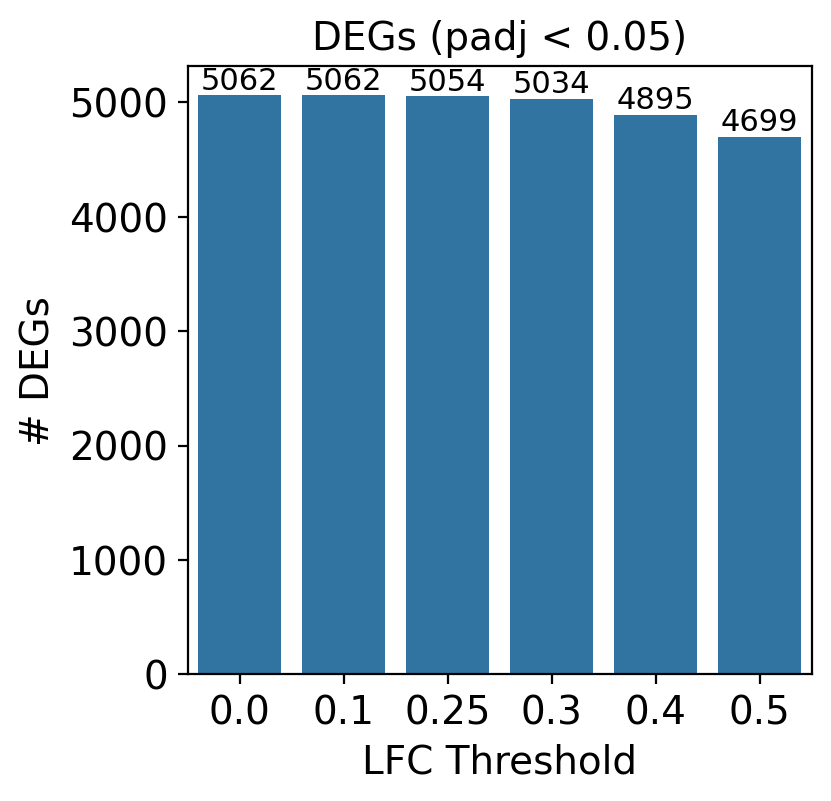

In [5]:
plot_n_degs_by_lfc_threshold(de_results, 
                             padj_threshold=0.05,
                             lfc_thresholds=[0, 0.1, 0.25, 0.3, 0.4, 0.5],
                             title="DEGs (padj < 0.05)")

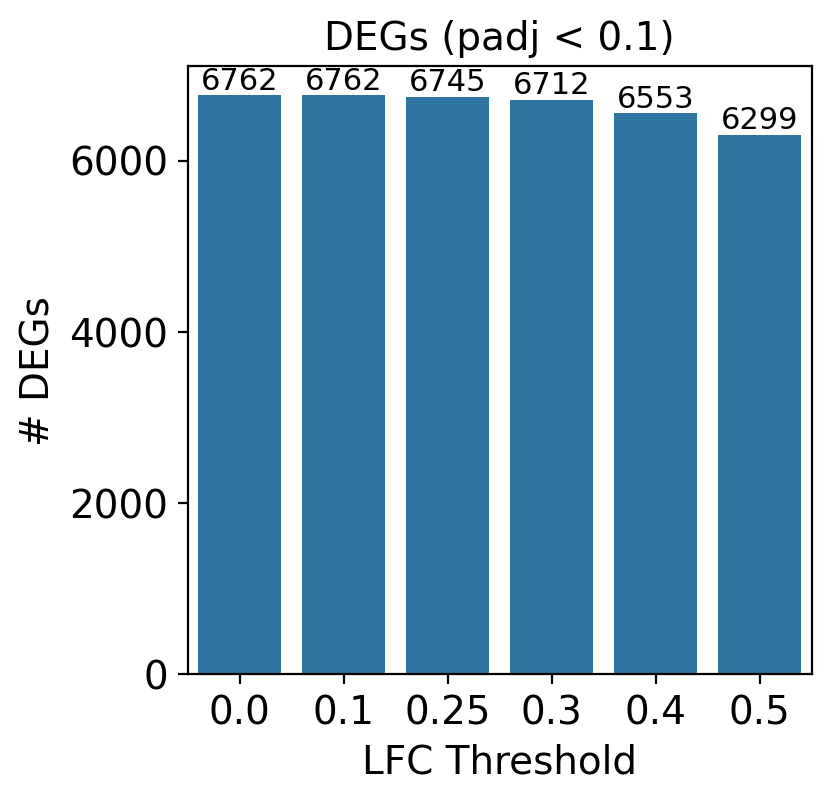

In [6]:
plot_n_degs_by_lfc_threshold(de_results, 
                             padj_threshold=0.1,
                             lfc_thresholds=[0, 0.1, 0.25, 0.3, 0.4, 0.5],
                             title="DEGs (padj < 0.1)")

Normalize data to median NTC UMI count and then perform relative z-normalization

In [6]:
import scanpy as sc

# Code taken from psp.da.replogle_pipeline()
def normalization_before_embedding(adata):
    # Set adata.X to counts
    adata.X = adata.layers["counts"].copy()
    # Add batch info if not present (all data for TF project is in batch ALPHA)
    if "batch" not in adata.obs:
        adata.obs["batch"] = "ALPHA"
    # Normalize to median NTC UMI count
    min_median_umi_value = adata[adata.obs.perturbed == "False"].obs.n_UMI_counts.median()
    print(f"Normalizing to {min_median_umi_value} UMIs per cell")
    sc.pp.normalize_total(adata, target_sum = min_median_umi_value)

    #Applying relative Z-normalization
    print(f"Applying relative z-normalization per batch")
    psp.da.relative_z_normalization_df(adata)
    return adata.copy()

In [7]:
adata_norm = normalization_before_embedding(adata)
adata_norm

Normalizing to 4787.0 UMIs per cell
normalizing counts per cell
    finished (0:00:00)
Applying relative z-normalization per batch


AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant', 'batch'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts', 'pre_

Create subsets of normalized adata with only TF KD cells and these padj/LFC thresholds:
-  padj < 0.05, |LFC| > 0.25
-  padj < 0.1, |LFC| > 0.25
-  padj < 0.05, |LFC| > 0.5
-  padj < 0.1, |LFC| > 0.5

In [8]:
def filter_degs_lfc(DE_results_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in DE_results_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[padj_col] < padj_threshold)].index)
    return lfc_degs

def filter_adata_tf_kds_degs(adata, DE_results_df, lfc_threshold, padj_threshold):
    degs = filter_degs_lfc(DE_results_df, lfc_threshold, padj_threshold)
    adata_filt = adata[adata.obs.perturbed == "True"]
    adata_filt = adata_filt[:, adata_filt.var.index.isin(degs)]
    return adata_filt.copy()

In [9]:
adata_padj5_lfc0pt25 = filter_adata_tf_kds_degs(adata_norm, de_results, 
                                                lfc_threshold=0.25, padj_threshold=0.05)

In [10]:
filename = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_norm_for_analysis_padj5_lfc0pt25.h5ad"
adata_padj5_lfc0pt25.write_h5ad(filename)

In [ ]:
adata_padj5_lfc0pt5 = filter_adata_tf_kds_degs(adata_norm, de_results, 
                                                lfc_threshold=0.5, padj_threshold=0.05)
adata_padj10_lfc0pt25 = filter_adata_tf_kds_degs(adata_norm, de_results, 
                                                lfc_threshold=0.25, padj_threshold=0.1)
adata_padj10_lfc0pt5 = filter_adata_tf_kds_degs(adata_norm, de_results, 
                                                lfc_threshold=0.5, padj_threshold=0.1)

In [44]:
for a in [adata_padj5_lfc0pt25, adata_padj5_lfc0pt5, adata_padj10_lfc0pt25, adata_padj10_lfc0pt5]:
    print(a.n_vars)

5054
4699
6745
6299


## Pairwise Pearson correlation matrix

In [ ]:
import numpy as np
import pandas as pd
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, parallel_backend, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from contextlib import contextmanager

# Handle warnings
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

# Modified from GitHub code to take n_jobs and figsize as arguments
# and suppress warning about clustering with Seaborn being slow
def create_corrmatrix(adata, title='', mode='perturb', 
                      vmax=None, vmin=None, n_jobs=20, 
                      figsize=(8,8), suppress_warnings=True):
    gene_target_groups = adata.obs.groupby('gene_target').indices
        # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        with parallel_backend('threading'):
            mean_profiles = Parallel(n_jobs=n_jobs)(
                delayed(compute_mean_profile)(adata, indices) 
                for indices in gene_target_groups.values()
            )
    mean_profiles = pd.DataFrame(np.array(mean_profiles).T,index=list(adata.var.index),columns=list(gene_target_groups.keys()))
    if mode == 'perturb':
        corr_matrix = np.corrcoef(mean_profiles.T)
        distance_df = pd.DataFrame(corr_matrix, index=mean_profiles.columns, columns=mean_profiles.columns)
    elif mode == 'gene':
        corr_matrix = np.corrcoef(mean_profiles)
        distance_df = pd.DataFrame(corr_matrix, index=mean_profiles.index, columns=mean_profiles.index)
    lim = np.percentile(abs(corr_matrix.flatten()), 98)
    if vmax is None:
        vmax = lim
    if vmin is None:
        vmin = -lim
    with handle_warnings(suppress_warnings):
        fig = sns.clustermap(distance_df,cmap="RdBu",xticklabels=False, yticklabels=False, center=0, 
            vmax=vmax, vmin=vmin, figsize=figsize)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    fig.ax_heatmap.set_title(title)
    fig.ax_row_dendrogram.set_visible(False)
    fig.ax_col_dendrogram.set_visible(False)
    return(fig,distance_df,mean_profiles)

In [ ]:
fig, perturb_corrs, mp = \
    create_corrmatrix(adata_padj5_lfc0pt25, mode="perturb", figsize=(6,6), vmax=0.2, vmin=-0.2, 
                      title="Perturbation Correlations (padj < 0.05, |LFC| > 0.25)")

In [ ]:
fig, perturb_corrs, mp = \
    create_corrmatrix(adata_padj5_lfc0pt5, mode="perturb", figsize=(6,6), vmax=0.2, vmin=-0.2,
                      title="Perturbation Correlations (padj < 0.05, |LFC| > 0.5)")

In [ ]:
fig, perturb_corrs, mp = \
    create_corrmatrix(adata_padj10_lfc0pt25, mode="perturb", vmax=0.2, vmin=-0.2, figsize=(6,6),
                      title="Perturbation Correlations (padj < 0.1, |LFC| > 0.25)")

In [ ]:
fig, perturb_corrs, mp = \
    create_corrmatrix(adata_padj10_lfc0pt5, mode="perturb", vmax=0.2, vmin=-0.2, figsize=(6,6),
                      title="Perturbation Correlations (padj < 0.1, |LFC| > 0.5)")

In [ ]:
fig, gene_corrs, mp = \
    create_corrmatrix(adata_padj5_lfc0pt25, mode="gene", figsize=(6,6), vmax=0.2, vmin=-0.2,
                      title="Gene Correlations (padj < 0.05, |LFC| > 0.25)")

In [ ]:
fig, gene_corrs, mp = \
    create_corrmatrix(adata_padj5_lfc0pt5, mode="gene", figsize=(6,6), vmax=0.2, vmin=-0.2,
                      title="Gene Correlations (padj < 0.05, |LFC| > 0.5)")

In [ ]:
fig, gene_corrs, mp = \
    create_corrmatrix(adata_padj10_lfc0pt25, mode="gene", figsize=(6,6), vmax=0.2, vmin=-0.2,
                      title="Gene Correlations (padj < 0.1, |LFC| > 0.25)")

In [ ]:
fig, gene_corrs, mp = \
    create_corrmatrix(adata_padj10_lfc0pt5, mode="gene", figsize=(6,6), vmax=0.2, vmin=-0.2,
                      title="Gene Correlations (padj < 0.1, |LFC| > 0.5)")

## Minimum Distortion Embedding

Generate MDE for both |LFC| > 0.25 conditions (padj < 0.05 and padj < 0.1)

In [23]:
import anndata as ad
import numpy as np
import pandas as pd
import pymde
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score
import igraph as ig
from scipy.spatial.distance import pdist, squareform
import leidenalg
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def compute_MDE(adata: ad.AnnData, 
                random_state: int = 42,
                # MDE parameters
                preserve: str = "neighbors",
                spectral: bool = True,
                n_components: int = 30,
                mde_repulsive_fraction: float = 0.15,
                mde_n_neighbors: int = 15,
                spectral_n_neighbors: int = 10,
                # Clustering parameters
                knn_n_neighbors: int = 5,
                leiden_resolution: float = 1.0,
                # Visualization parameters
                label_points: bool = False,
                title: str = ""):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Compute mean normalized profiles
    mean_profiles = [compute_mean_normalized_profile(adata, indices) 
                     for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    pymde.seed(random_state)
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=n_components,
                affinity='nearest_neighbors',
                n_neighbors=spectral_n_neighbors,
                eigen_solver='arpack',
                random_state=random_state
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, 
                                           repulsive_fraction=mde_repulsive_fraction, 
                                           n_neighbors=mde_n_neighbors)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, 
                                           repulsive_fraction=mde_repulsive_fraction, 
                                           n_neighbors=mde_n_neighbors)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(
            max_iter=4000 if spectral else 2000,
            print_every=100,
            verbose=True,
            random_state=random_state
            ) # From GitHub

    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=knn_n_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(
        g,
        leidenalg.RBConfigurationVertexPartition,
        resolution_parameter=leiden_resolution,
        seed=random_state
    )
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.set_style("white")
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()

    # Plot using Plotly with Pastel colormap for discrete clusters
    leiden_categories = sorted(embedding_df['cluster'].unique(), key=lambda x: int(x))
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     category_orders={'cluster': leiden_categories},
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title=title,
                     color_discrete_sequence=px.colors.qualitative.Dark24)
    fig.update_traces(marker=dict(size=7, opacity=0.7),
                      textposition='middle center', textfont=dict(size=4))
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1000,
        height=800,
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points:
        fig.update_traces(text=None)
   
    fig.show()

    return adata, embedding, clusters, mean_profiles_array, embedding_df, pairwise_distances

def compute_silhouette_score(embedding, clusters, random_state=42):
    return silhouette_score(X=embedding, labels=clusters, random_state=random_state)

def compute_mean_median_pairwise_centroid_distance(pairwise_distances):
    # Extract unique distances (upper triangle only)
    vals = pairwise_distances.values
    upper = vals[np.triu_indices_from(vals, k=1)]
    # Calculate mean and median distance
    mean_dist = upper.mean()
    median_dist = np.median(upper)
    print(f"Mean pairwise cluster centroid distance: {mean_dist}")
    print(f"Median pairwise cluster centroid distance: {median_dist}")
    return mean_dist, median_dist

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) 
                    for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

def plot_n_perts_per_cluster(perts_in_cluster_df, title, figsize=(6,3), ymax=None):
    sns.set_style("whitegrid")
    n_perts_per_cluster = perts_in_cluster_df.nunique().tolist()
    xvals = [i for i in range(len(n_perts_per_cluster))]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=xvals, y=n_perts_per_cluster, ax=ax)
    ax.set_xlabel("Leiden cluster")
    ax.set_ylabel("# TF KDs in cluster")
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if ymax:
        ax.set_ylim(0, ymax)
    ax.set_title(title)

Default MDE settings:
-  preserve: MDE preservation method ('neighbors' or 'distances'), default: 'neighbors'
-  spectral: Whether to use spectral embedding initialization, default: True
-  n_components: Dimension for spectral embedding initialization, default: 30
-  mde_repulsive_fraction: Ratio of repulsive edges in MDE, default: 0.15
-  mde_n_neighbors: Number of neighbors for MDE preservation, default: 15
-  spectral_n_neighbors: Number of neighbors for spectral embedding, default: 15
-  leiden_resolution: Resolution parameter for Leiden clustering, default: 1.0
-  knn_n_neighbors: Number of neighbors for KNN graph construction, default: 5 (called leiden_neighbors in example notebook)

Settings used in example notebook:
-  n_components=20
-  spectral_n_neighbors=25
-  mde_repulsive_fraction=10
-  mde_n_neighbors=7

Will use the default and example notebook settings, except set leiden_neighbors to higher number (for fewer clusters) since there are fewer TF KDs

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_norm_for_analysis_padj5_lfc0pt25.h5ad"
adata_padj5_lfc0pt25 = psp.utils.read_anndata(filepath)
adata_padj5_lfc0pt25

AnnData object with n_obs × n_vars = 88249 × 5054
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant', 'batch'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts', 'pre_z_

In [ ]:
mde_padj5 = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=5, mde_repulsive_fraction=10, knn_n_neighbors=10)

In [88]:
_, _, _, _, embedding_df = mde_padj5
perts_in_cluster = gene_targets_per_cluster(embedding_df)
perts_in_cluster.head()

0        1       2       3       4        5      6        7        8   \
0    ATF1    ATOH1  CAMTA2    ATF3  ANKZF1     ALX4  BAZ2A    ARNT2   BARHL1   
1  BHLHA9   BCL11A   DACH2   BACH1    ATF4  BHLHA15   CDX1      ARX  CREB3L4   
2  CC2D1A  CREB3L1  DMRTB1    BATF   CENPT     DPF3  DEAF1  BHLHE41   CREBL2   
3   CENPB  CREB3L3   FOXE1  DMRTA1   CENPX     EGR2   DLX2    CTCFL    DMRT1   
4   CREB1    DMBX1   FOXI3    E2F2   DMRT2     ELF5   ETS2      ERF      EN1   

       9   ...      11       12       13        14     15        16      17  \
0  CREBZF  ...   ADNP2    ASCL5    ATOH8       AHR    DR1  ARHGAP35  ARID3B   
1    E2F1  ...   ATF6B    BARX1  BHLHE40     ATOH7  DRAP1     ARID2    GLI2   
2    ESR1  ...   ATMIN      BBX      ERG     BCL6B   EMX1      DLX4    HEY2   
3    ETV2  ...     BSX  BHLHE22    GATA6      ESR2   ETS1     DOT1L    HMX3   
4   FOXL1  ...  CHAMP1     EBF2    HIF3A  GTF2IRD2  ETV3L     GTF3A    KLF1   

     18     19       20  
0  DLX1  ASCL1  GATAD2B  
1  DUXA   CBX2     MSX2  
2  EGR1  HNF4A   NFATC3  
3  KLF5  MEOX2     OSR2  
4  LYL1  PHF20     RORC  

[5 rows x 21 columns]

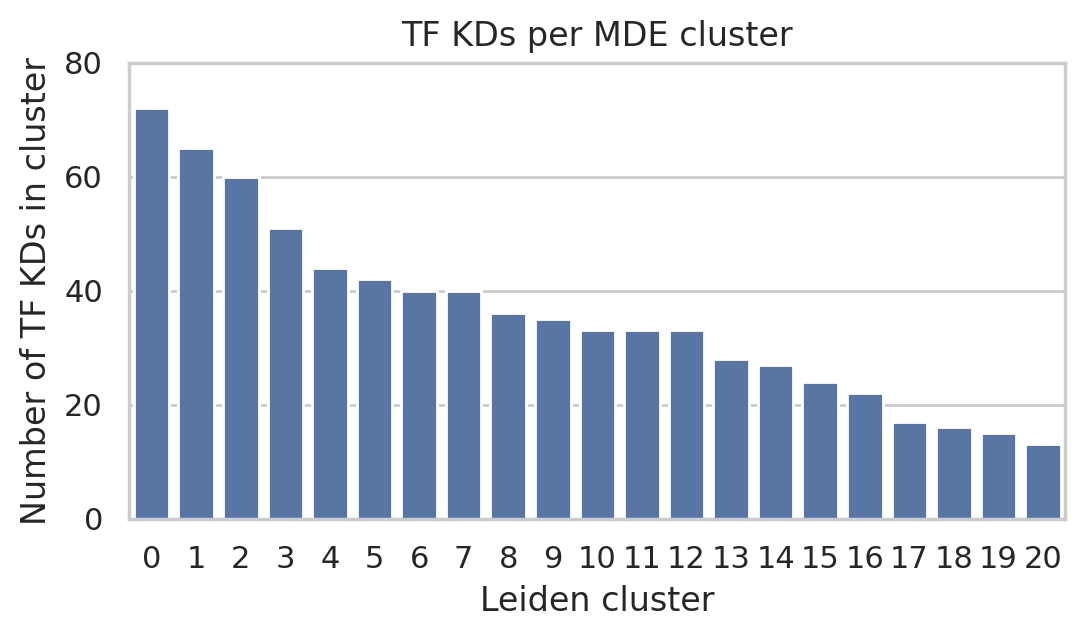

In [103]:
sns.set_style("whitegrid")
plot_n_perts_per_cluster(perts_in_cluster, title="TF KDs per MDE cluster", ymax=80)

In [104]:
perts_in_cluster.to_csv("/home/ranwyl/results_tf_project/tf_kd_clusters_12-5-25.csv")

In [ ]:
mde_12nbrs = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=7, mde_repulsive_fraction=10, knn_n_neighbors=12)

In [20]:
adata12, embedding12, clusters12, mean_profiles_arr12, embedding_df12, pairwise_dists12 = mde_12nbrs
perts_in_cluster12 = gene_targets_per_cluster(embedding_df12)
perts_in_cluster12.head()

0        1       2      3        4       5      6      7      8   \
0   ARNT2     ATF3     AHR  ARID2   BARHL1   ATOH8  ASCL1    BSX   ATF4   
1   ATOH1    BAZ2A   ATOH7  CENPB  CREB3L4  CAMTA2  DACH2   EBF2  BARX1   
2    BATF  BHLHE22  DMRTB1   DLX4    DMRT3   FOXJ1   ELF3  EPAS1    BBX   
3   BCL6B    CREB1    DPF3  DOT1L     E2F7    GLI1  ESRRG   ESR1   CBX2   
4  CC2D1A     DLX2    ESR2    DR1     ELF4    GLI4  FOXE1  FOXA1   CDX1   

        9   ...       11      12       13       14        15      16     17  \
0  BHLHA15  ...  CREB3L3    ATF1   BCL11A      ARX     ADNP2  ANKZF1  ATF6B   
1   CREBZF  ...     EGR2   BACH1    DMBX1   BHLHA9  ARHGAP35  HMBOX1  CENPT   
2      EN1  ...     ELF5   DEAF1    EOMES  CREB3L1     ATMIN    IRX3  DMRT1   
3    FOXC2  ...    FOXA2  DMRTA1  GATAD2A     DBX2    CHAMP1   MEOX1   ETV6   
4    FOXE3  ...    GRHL1    E2F2     HES3   DMRTC2     DNMT1     MSC  GATA5   

       18     19       20  
0  ARID3B   DLX1    ASCL5  
1   ESRRB   DUXA  BHLHE40  
2    GLI2   EGR1      ERG  
3    HEY2   ETV2     PAX3  
4    HMX3  GMEB1   POU4F2  

[5 rows x 21 columns]

In [13]:
silh_score12 = compute_silhouette_score(embedding12, clusters12)
print(silh_score12)

0.32142526


In [24]:
mean_dist12, median_dist12 = \
    compute_mean_median_pairwise_centroid_distance(pairwise_dists12)

Mean pairwise cluster centroid distance: 5.788494288319084
Median pairwise cluster centroid distance: 5.567595719083922


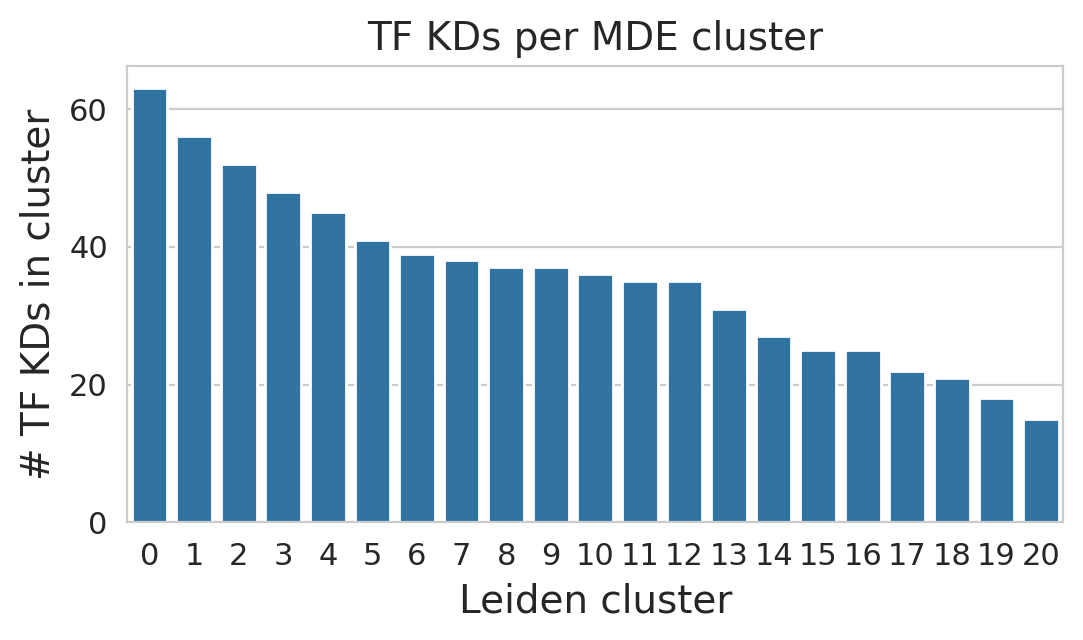

In [ ]:
plot_n_perts_per_cluster(perts_in_cluster12, title="TF KDs per MDE cluster")

In [ ]:
perts_in_cluster12.to_csv("/home/ranwyl/results_tf_project/tf_kd_clusters_12-8-25.csv")

In [ ]:
mde_padj5 = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=5, mde_repulsive_fraction=10, knn_n_neighbors=7,
                        leiden_resolution=0.15)

In [42]:
_, _, _, _, embedding_df = mde_padj5
perts_in_cluster = gene_targets_per_cluster(embedding_df)
perts_in_cluster.head()

0        1       2        3        4        5      6       7      8   \
0    AHR    ARID2   ARNT2      BBX  BHLHE22      ARX   ALX4  ANKZF1  ATF6B   
1  ASCL1   BARHL1    ATF1  BHLHA15     DLX2   BHLHA9  ATOH8   DEAF1  CENPB   
2  ATOH7  CREB3L4   ATOH1     DLX1   DMRTC2    CREB1  BAZ2A  DMRTA1  CENPT   
3  BCL6B   CREBL2    BATF     DUXA     E2F1  CREB3L1   E2F7    EMX1  DMRT3   
4  CENPX     DLX4  BCL11A     EGR1     EBF3  CREB3L3   ETS1   FOSL2   ELF4   

       9        10       11        12      13     14     15      16       17  \
0     BSX    ASCL5    BACH1     ADNP2  ARID3B   CBX2   ESR1  CREBZF    HNF4A   
1  CAMTA2  BHLHE40     E2F2  ARHGAP35    GLI2   CDX1  FOXD1    HES6    PHF20   
2   DMRT1   CC2D1A    FOXL2     ATMIN    HEY2  DACH2  GRHL2   HESX1   POU3F2   
3     EN1      ERG  GATAD2B    CHAMP1    HMX3  FOXG1  PCGF6   KLF12   POU5F1   
4   EPAS1    ESRRB    GRHL3     DNMT1    KLF1  FOXM1   SOX3  NKX3-1  POU5F1B   

       18     19  
0   NR4A2   ATF3  
1  POU4F1   ATF4  
2  STAT5A  BARX1  
3    TET1    HDX  
4   TPRX1    PGR

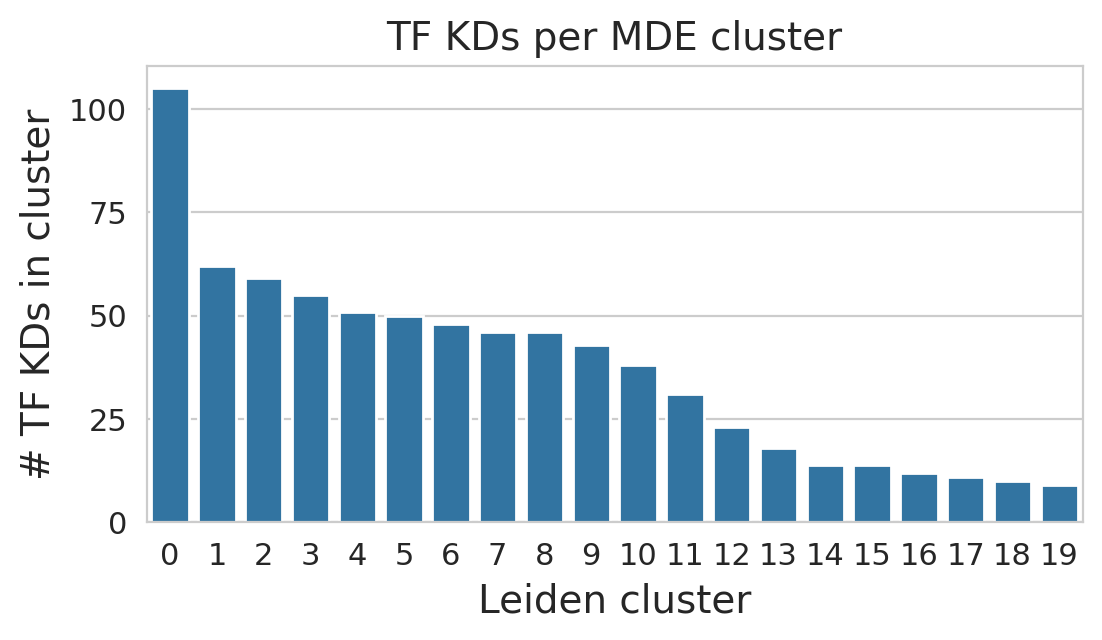

In [43]:
plot_n_perts_per_cluster(perts_in_cluster, title="TF KDs per MDE cluster")

In [ ]:
mde_padj5_res0pt2 = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=5, mde_repulsive_fraction=10, knn_n_neighbors=7,
                        leiden_resolution=0.2)

In [22]:
adata02, embedding02, clusters02, mean_profiles_arr02, embedding_df02, pairwise_dists02 = mde_padj5_res0pt2

In [17]:
silh_score02 = compute_silhouette_score(embedding02, clusters02)
print(silh_score02)

0.30973417


In [25]:
mean_dist02, median_dist02 = \
    compute_mean_median_pairwise_centroid_distance(pairwise_dists02)

Mean pairwise cluster centroid distance: 6.844214228490154
Median pairwise cluster centroid distance: 6.41780980553878


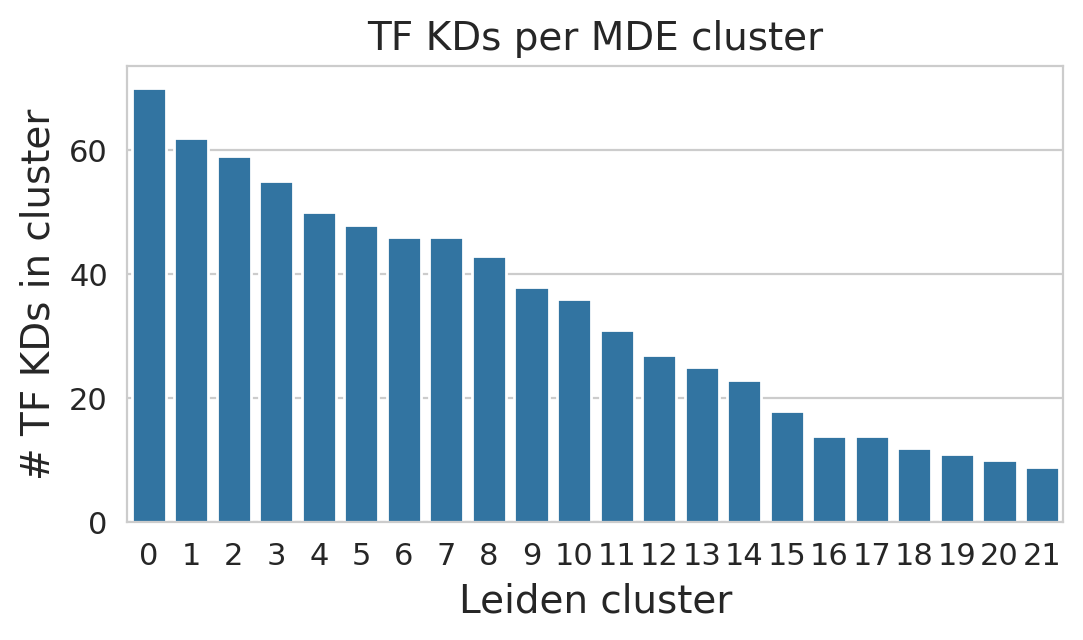

In [ ]:
perts_in_cluster02 = gene_targets_per_cluster(embedding_df02)
plot_n_perts_per_cluster(perts_in_cluster02, title="TF KDs per MDE cluster")

Try 11 neighbors for KNN graph

In [ ]:
sns.set_style("white")
mde_padj5 = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=7, mde_repulsive_fraction=10, knn_n_neighbors=11)

Try higher number for mde_repulsive_fraction

In [ ]:
mde_padj5 = compute_MDE(adata_padj5_lfc0pt25, n_components=20, spectral_n_neighbors=25,
                        mde_n_neighbors=7, mde_repulsive_fraction=15, knn_n_neighbors=11)

# Winter 2025 Week 2-3

## Applying pval threshold to existing DGE results

Testing pval threshold for DGE analysis. Instead of using padj threshold, which is dependent on the number of DE genes (which is in turn affected by the high variance in gene expression when there are a small number of cells per condition), we will use a pval threshold. We will test multiple pval thresholds and choose a threshold where the average number of DE genes is ~100. According to Nadig et al (2025), a typical gene perturbation affects 45 genes and a typical essential gene affects over 500, so 100 should be a suitable threshold.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
def test_pvals(DE_results_df, pval_list, target_type="gRNA", pval_delimiter="pvalue", ntc_deg_threshold=3):
    """
    Given a DF of DGE results and a list of p-values, compute the
    number of genes with pval < each pval in the list for each gRNA
    or gene target. Return the mean and median number of DE genes across
    all gRNAs/gene targets.
    """
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    DEGs_df_dict = {f"pval < {pval}":[] for pval in pval_list}
    for pval in pval_list:
        DEGs_arr = np.zeros(len(targets))
        for i, target in enumerate(targets):
            target_pval_col = f"{target}_{pval_delimiter}"
            n_DEGs = len(DE_results_df.loc[DE_results_df[target_pval_col] < pval])
            DEGs_arr[i] = n_DEGs
        DEGs_df_dict[f"pval < {pval}"].append(int(np.mean(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(np.median(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(len(DEGs_arr[DEGs_arr >= ntc_deg_threshold])))
    DEGs_df = pd.DataFrame.from_dict(DEGs_df_dict, orient="index", 
                                     columns=[f"mean DEGs per {target_type}", 
                                              f"median DEGs per {target_type}",
                                              f"{target_type}s with ≥{ntc_deg_threshold} DEGs"])
    return DEGs_df

In [65]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

In [66]:
def plot_DEGs_per_KD_histogram(n_DEGs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=100, xmax=None, ymax=None):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_DEGs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    sns.histplot(n_DEGs_df[n_DEGs_df[n_degs_str] >= min_n_degs][n_degs_str].values, 
                 binwidth=bin_width, binrange=(0,xmax))
    plt.xlim(0, xmax)
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

### gRNA level DE

In [3]:
filepath = "/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps_seed67.pkl"
de_results_gRNA = pd.read_pickle(filepath)
de_results_gRNA.head()

ZNF785_3_baseMean  ZNF785_3_log2FoldChange  ZNF785_3_lfcSE  \
A1BG                2.825213                -0.119328        0.652439   
A1BG-AS1            0.406331                -1.220467        2.378477   
A2M                 0.357067                 2.061855        0.925485   
A2ML1               1.349573                 0.832734        0.756306   
A2ML1-AS1           3.831621                 0.013628        0.561750   

           ZNF785_3_stat  ZNF785_3_pvalue  ZNF785_3_padj  ZNF335_2_baseMean  \
A1BG           -0.182895         0.854880       0.999511           2.825213   
A1BG-AS1       -0.513130         0.607860       0.997405           0.406331   
A2M             2.227864         0.025890       0.997405           0.357067   
A2ML1           1.101055         0.270873       0.997405           1.349573   
A2ML1-AS1       0.024261         0.980645       0.999511           3.831621   

           ZNF335_2_log2FoldChange  ZNF335_2_lfcSE  ZNF335_2_stat  ...  \
A1BG                     -1.572837        1.449171      -1.085336  ...   
A1BG-AS1                  0.654794        1.486734       0.440425  ...   
A2M                      -0.440840        2.430576      -0.181373  ...   
A2ML1                     0.164431        1.470981       0.111783  ...   
A2ML1-AS1                 0.914663        0.568722       1.608278  ...   

           SNAI2_2_lfcSE  SNAI2_2_stat  SNAI2_2_pvalue  SNAI2_2_padj  \
A1BG            0.507155     -1.032087        0.302032      0.999998   
A1BG-AS1        0.924310      1.121289        0.262165      0.999998   
A2M             1.461977     -0.177521        0.859099      0.999998   
A2ML1           1.047108     -2.028679        0.042491      0.999998   
A2ML1-AS1       0.442830     -1.184949        0.236037      0.999998   

           ZNF841_3_baseMean  ZNF841_3_log2FoldChange  ZNF841_3_lfcSE  \
A1BG                2.768277                 0.211601        0.420046   
A1BG-AS1            0.446179                 0.504915        1.065490   
A2M                 0.381827                -1.150451        1.974116   
A2ML1               1.290854                -0.389769        0.673530   
A2ML1-AS1           3.722151                 0.021142        0.392296   

           ZNF841_3_stat  ZNF841_3_pvalue  ZNF841_3_padj  
A1BG            0.503755         0.614433       0.999767  
A1BG-AS1        0.473881         0.635585       0.999767  
A2M            -0.582768         0.560050       0.999767  
A2ML1          -0.578695         0.562795       0.999767  
A2ML1-AS1       0.053892         0.957021       0.999767  

[5 rows x 5916 columns]

In [62]:
pvalues = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
pvals_degs_df = test_pvals(de_results_gRNA, pvalues)
pvals_degs_df

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥3 DEGs
pval < 0.05                   768                   743                 986
pval < 0.01                   200                   185                 986
pval < 0.005                  119                   107                 986
pval < 0.001                   40                    31                 986
pval < 0.0005                  26                    18                 983
pval < 0.0001                  12                     6                 806
pval < 5e-05                    9                     4                 641
pval < 1e-05                    5                     1                 275

In [7]:
n_degs_df_005 = build_n_DEGs_df(de_results_gRNA, 0.005)
n_degs_df_005.sort_values(by="n_DEGs", ascending=False)

n_DEGs
POU5F1B_1    1169
POU5F1_2     1157
POU5F1_3     1054
PHF20_1       983
POU5F1_1      954
...           ...
HNF1A_1        49
CREB3L3_3      48
ZNF595_1       47
PRDM13_1       47
ZSCAN18_3      43

[986 rows x 1 columns]

In [8]:
n_degs_df_001 = build_n_DEGs_df(de_results_gRNA, 0.001)
n_degs_df_001.sort_values(by="n_DEGs", ascending=False)

n_DEGs
POU5F1_2      821
POU5F1B_1     803
POU5F1_3      740
PHF20_1       667
POU5F1_1      646
...           ...
MESP1_1         7
ZNF595_1        6
VDR_2           6
ZNF354A_1       6
HNF4A_2         5

[986 rows x 1 columns]

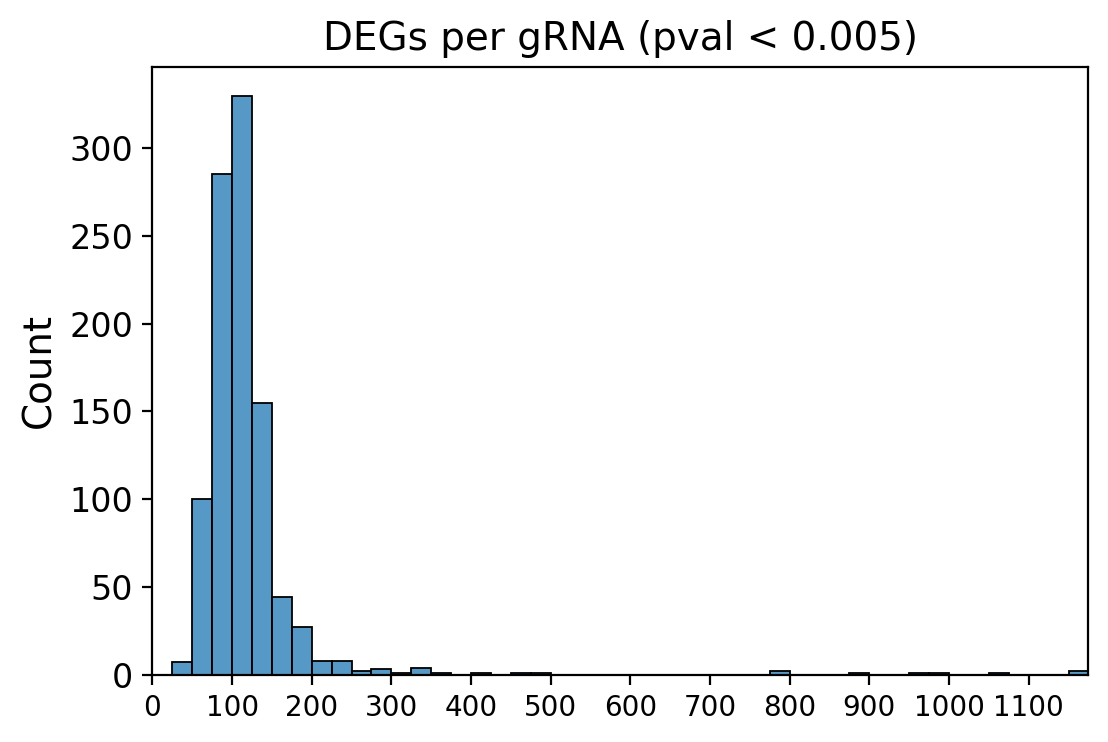

In [20]:
plot_DEGs_per_KD_histogram(n_degs_df_005, title="DEGs per gRNA (pval < 0.005)", bin_width=25, xtick_width=100, fig_size=(6,4))

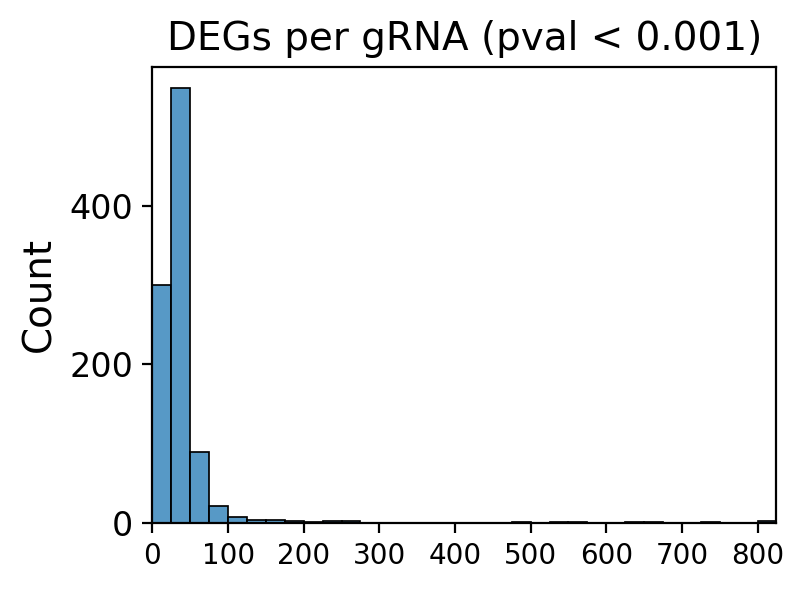

In [17]:
plot_DEGs_per_KD_histogram(n_degs_df_001, title="DEGs per gRNA (pval < 0.001)", bin_width=25, xtick_width=100)

### Gene target level DE

In [4]:
filepath = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results = pd.read_pickle(filepath)
de_results.head()

TFAP2E_baseMean  TFAP2E_log2FoldChange  TFAP2E_lfcSE  TFAP2E_stat  \
A1BG              4.288014               0.215774      0.603310     0.357650   
A1BG-AS1          0.654281               0.125053      1.466596     0.085267   
A2M               0.563516               0.771556      1.476445     0.522576   
A2ML1             2.080172               0.228122      1.044360     0.218432   
A2ML1-AS1         5.946591               0.477421      0.501640     0.951722   

           TFAP2E_pvalue  TFAP2E_padj  ZKSCAN7_baseMean  \
A1BG            0.720605     0.999818          4.288014   
A1BG-AS1        0.932049     0.999818          0.654281   
A2M             0.601269     0.999818          0.563516   
A2ML1           0.827092     0.999818          2.080172   
A2ML1-AS1       0.341238     0.999818          5.946591   

           ZKSCAN7_log2FoldChange  ZKSCAN7_lfcSE  ZKSCAN7_stat  ...  \
A1BG                     0.092251       0.603846      0.152772  ...   
A1BG-AS1                -0.001957       1.468084     -0.001333  ...   
A2M                     -0.794152       2.399144     -0.331015  ...   
A2ML1                    1.430906       0.684694      2.089846  ...   
A2ML1-AS1               -0.004348       0.563476     -0.007717  ...   

           SIX6_lfcSE  SIX6_stat  SIX6_pvalue  SIX6_padj  ESRRG_baseMean  \
A1BG         0.305996  -2.346219     0.018965   0.815784        4.136067   
A1BG-AS1     0.633151   0.259516     0.795237   0.999988        0.638291   
A2M          0.657282   0.555595     0.578488   0.987858        0.579372   
A2ML1        0.365398  -0.716801     0.473497   0.986759        2.048557   
A2ML1-AS1    0.210733   0.245300     0.806224   0.999988        5.675613   

           ESRRG_log2FoldChange  ESRRG_lfcSE  ESRRG_stat  ESRRG_pvalue  \
A1BG                  -0.300046     0.253307   -1.184514      0.236210   
A1BG-AS1               0.851325     0.467333    1.821665      0.068506   
A2M                    0.253867     0.631455    0.402036      0.687658   
A2ML1                 -0.418370     0.374944   -1.115822      0.264498   
A2ML1-AS1             -0.065157     0.205259   -0.317440      0.750910   

           ESRRG_padj  
A1BG         0.921599  
A1BG-AS1     0.828367  
A2M          0.990020  
A2ML1        0.923641  
A2ML1-AS1    0.997073  

[5 rows x 4356 columns]

In [9]:
pvalues = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
pvals_degs_df = test_pvals(de_results, pvalues, target_type="gene_target")
pvals_degs_df

mean DEGs per gene_target  median DEGs per gene_target  \
pval < 0.05                          879                          853   
pval < 0.01                          248                          230   
pval < 0.005                         152                          137   
pval < 0.001                          54                           43   
pval < 0.0005                         36                           27   
pval < 0.0001                         16                            9   
pval < 5e-05                          12                            6   
pval < 1e-05                           7                            2   

               gene_targets with ≥3 DEGs  
pval < 0.05                          726  
pval < 0.01                          726  
pval < 0.005                         726  
pval < 0.001                         726  
pval < 0.0005                        726  
pval < 0.0001                        704  
pval < 5e-05                         637  
pval < 1e-05                         321

In [26]:
n_degs_df_005 = build_n_DEGs_df(de_results, 0.005, target_type="gene_target")
n_degs_df_005.sort_values(by="n_DEGs", ascending=False)

n_DEGs
POU5F1     2032
POU5F1B    1181
PHF20      1021
POU3F2      920
ZNF521      811
...         ...
HNF1A        83
ZBTB22       82
HNF4A        80
SNAI3        79
KLF11        77

[726 rows x 1 columns]

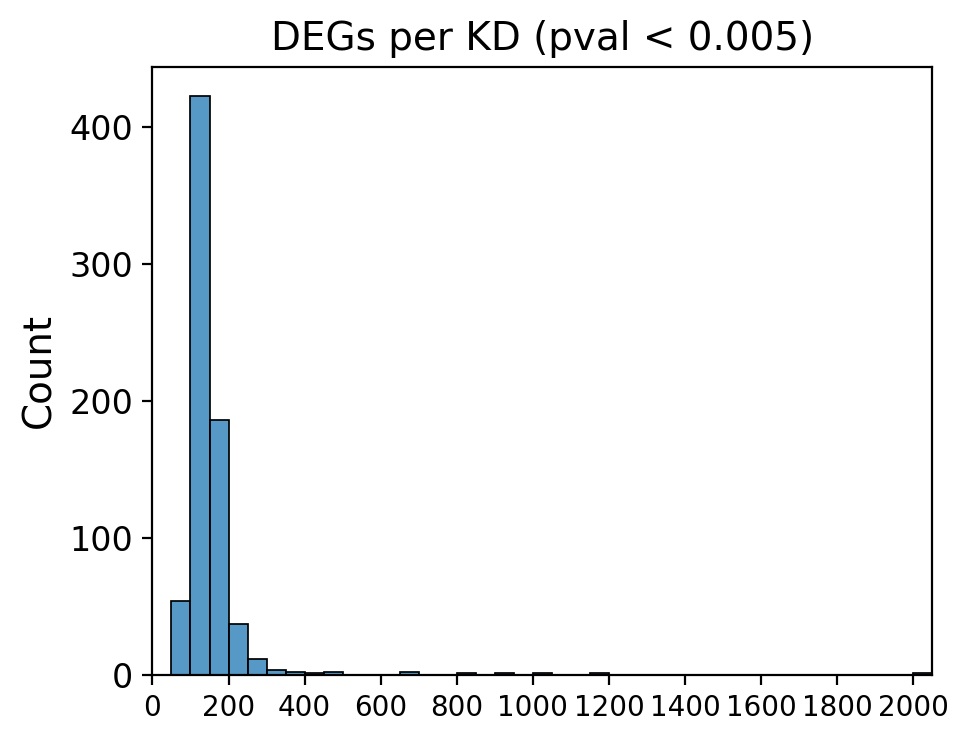

In [32]:
plot_DEGs_per_KD_histogram(n_degs_df_005, title="DEGs per KD (pval < 0.005)", bin_width=50, xtick_width=200, fig_size=(5,4))

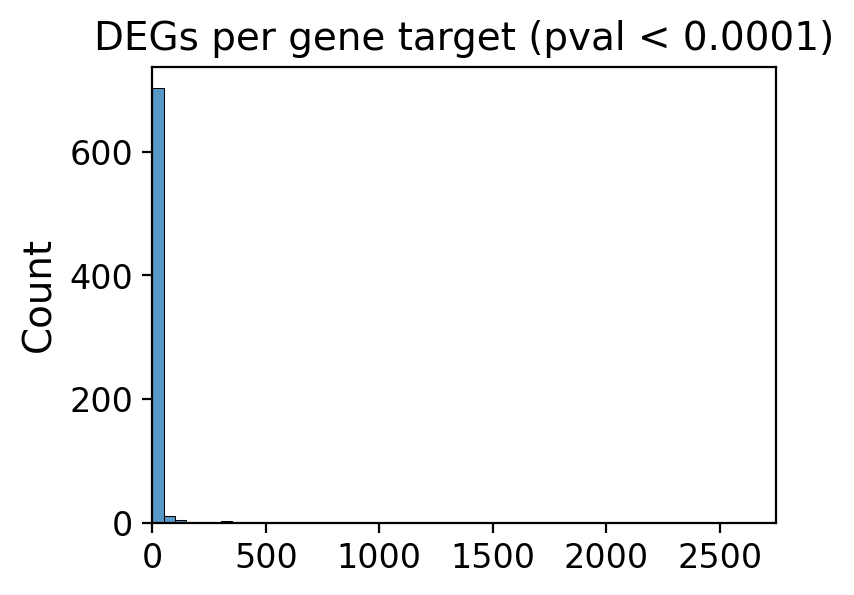

In [18]:
n_degs_df_0001 = build_n_DEGs_df(de_results, 0.0001, target_type="gene_target")
plot_DEGs_per_KD_histogram(n_degs_df_0001, title="DEGs per gene target (pval < 0.0001)", bin_width=50, xtick_width=500, fig_size=(4,3), xmax=2750)

In [48]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [56]:
def build_DEGs_pval_lfc_df(DE_results_df, p_thresholds, lfc_thresholds, 
                           p_threshold_type="pvalue", target_type="gene_target"):
    df_dict = dict()
    for p_threshold in p_thresholds:
        lfc_DEGs = list()
        for lfc_threshold in lfc_thresholds:
            n_DEGs = len(filter_DEGs(DE_results_df, p_threshold=p_threshold, lfc_threshold=lfc_threshold, 
                                        p_threshold_type=p_threshold_type, target_type=target_type))
            lfc_DEGs.append(n_DEGs)
        df_dict[f"{p_threshold_type} < {p_threshold}"] = lfc_DEGs
    DEGs_pval_lfc_df = pd.DataFrame.from_dict(df_dict, orient="index", 
                                              columns=[f"DEGs w/ |LFC| > {lfc_thr}" for lfc_thr in lfc_thresholds])
    return DEGs_pval_lfc_df

In [57]:
degs_pval_lfc_df = build_DEGs_pval_lfc_df(de_results, p_thresholds=[0.005, 0.001, 0.0005, 0.0001], lfc_thresholds=[0.25, 0.5])

In [58]:
degs_pval_lfc_df

DEGs w/ |LFC| > 0.25  DEGs w/ |LFC| > 0.5
pvalue < 0.005                  15190                14813
pvalue < 0.001                  10983                10586
pvalue < 0.0005                  8928                 8590
pvalue < 0.0001                  5135                 4895

## DGE with pval threshold

In [4]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Run DGE analysis at gRNA level on entire dataset (all perturbing and NTC gRNAs). Then choose a pval threshold such that the average perturbation has ~100 DEGs. Determine the threshold where 95% of NTC gRNAs have fewer DEGs, and remove all NTC gRNAs with more DEGs than the threshold. Rerun DGE analysis at gRNA level.

For DGE analysis, use 3 chunks and random seed 42

In [28]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [32]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if (ntc_gRNA_delimiter in target):
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
    
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [ ]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100,
        layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [20]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [9]:
counts_df_grna_full, metadata_df_grna_full = \
    create_pseudobulk_dataset(adata, target_type="gRNA",
                              min_cells_for_3_reps=60, random_state=42)

In [10]:
counts_df_grna_full.head()

ENSG00000241860  ENSG00000290385  ENSG00000291215  \
Non-Targeting-186-rep1                1                0                0   
Non-Targeting-186-rep2                0                0                2   
ESR2-2-rep1                           2                2                2   
ESR2-2-rep2                           2                3                1   
ESR2-2-rep3                           2                1                3   

                        LINC01409  LINC00115  LINC01128  NOC2L  KLHL17  ISG15  \
Non-Targeting-186-rep1          1          0          0      6       0      2   
Non-Targeting-186-rep2          0          0          0     10       1      3   
ESR2-2-rep1                     6          2          1     24       1      7   
ESR2-2-rep2                     4          0          3     15       0     10   
ESR2-2-rep3                     5          1          5     26       1      9   

                        AGRN  ...  MT-ATP6  MT-CO3  MT-ND3  MT-ND4L  MT-ND4  \
Non-Targeting-186-rep1     1  ...     1098    2063     242        9     485   
Non-Targeting-186-rep2     0  ...     1206    2250     285       20     590   
ESR2-2-rep1                8  ...     3184    5553     648       46    1295   
ESR2-2-rep2                5  ...     2938    5245     663       43    1327   
ESR2-2-rep3                9  ...     2945    5384     593       37    1246   

                        MT-ND5  MT-ND6  MT-CYB  ENSG00000276256  \
Non-Targeting-186-rep1      98      59     445                1   
Non-Targeting-186-rep2      99      63     433                0   
ESR2-2-rep1                246     187    1066                5   
ESR2-2-rep2                241     166    1114                5   
ESR2-2-rep3                242     187    1032                4   

                        ENSG00000271254  
Non-Targeting-186-rep1                2  
Non-Targeting-186-rep2                1  
ESR2-2-rep1                           2  
ESR2-2-rep2                           0  
ESR2-2-rep3                           2  

[5 rows x 16115 columns]

In [11]:
metadata_df_grna_full.head()

condition  n-cells-in-rep
Non-Targeting-186-rep1       NTC              28
Non-Targeting-186-rep2       NTC              29
ESR2-2-rep1               ESR2-2              70
ESR2-2-rep2               ESR2-2              70
ESR2-2-rep3               ESR2-2              70

In [13]:
de_results_grna_full = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1500, n_cpus=75, random_state=42,
                                   counts_df=counts_df_grna_full, metadata_df=metadata_df_grna_full)

2773 perturbation samples, 568 NTC samples, 3 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [62, 62, 61]
Number of targets with 3 reps per chunk: [267, 267, 267]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.52 seconds.

Fitting dispersions...
... done in 1617.98 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 117.54 seconds.

Fitting LFCs...
... done in 87.13 seconds.

Calculating cook's distance...
... done in 1.35 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.52 seconds.

Fitting dispersions...
... done in 1835.57 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 114.61 seconds.

Fitting LFCs...
... done in 87.53 seconds.

Calculating cook's distance...
... done in 1.32 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.52 seconds.

Fitting dispersions...
... done in 1408.10 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 121.65 seconds.

Fitting LFCs...
... done in 85.81 seconds.

Calculating cook's distance...
... done in 1.33 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

In [14]:
de_results_df_grna_full = build_DE_df(de_results_grna_full)
de_results_df_grna_full.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.816862                0.001941       0.733954   
A1BG-AS1           0.434496               -1.021191       2.387665   
A2M                0.376518                1.672385       1.170622   
A2ML1              1.308873                0.540466       1.037620   
A2ML1-AS1          3.819006               -0.343784       0.727800   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG           0.002644        0.997890      0.999674          2.816862   
A1BG-AS1      -0.427694        0.668874      0.997173          0.434496   
A2M            1.428629        0.153111      0.997173          0.376518   
A2ML1          0.520871        0.602456      0.997173          1.308873   
A2ML1-AS1     -0.472360        0.636670      0.997173          3.819006   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.498121       0.522974      0.952477  ...   
A1BG-AS1                 0.220662       1.454824      0.151676  ...   
A2M                      1.437109       1.161455      1.237335  ...   
A2ML1                   -0.360045       1.033252     -0.348458  ...   
A2ML1-AS1                1.049073       0.380685      2.755751  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.735003     -2.066776        0.038755      0.999992   
A1BG-AS1        1.058743      0.451346        0.651740      0.999992   
A2M             1.422213     -0.184238        0.853827      0.999992   
A2ML1           0.609023     -0.277150        0.781665      0.999992   
A2ML1-AS1       0.349133      1.013193        0.310968      0.999992   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.783284               -0.634082       0.573220   
A1BG-AS1           0.410565                1.738439       1.284029   
A2M                0.382827                1.209777       1.410135   
A2ML1              1.327229               -1.581952       0.707328   
A2ML1-AS1          3.761216                0.239069       0.440676   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.106175        0.268651      0.999503  
A1BG-AS1       1.353894        0.175770      0.999503  
A2M            0.857916        0.390939      0.999503  
A2ML1         -2.236519        0.025318      0.999503  
A2ML1-AS1      0.542504        0.587472      0.999503  

[5 rows x 5916 columns]

In [15]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_full_1-16-26.pkl"
de_results_df_grna_full.to_pickle(filepath_pkl)

In [23]:
pvalues = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
pvals_degs_df = test_pvals(de_results_df_grna_full, pvalues, ntc_deg_threshold=1)
pvals_degs_df

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥1 DEGs
pval < 0.05                   765                   739                 986
pval < 0.01                   199                   185                 986
pval < 0.005                  118                   106                 986
pval < 0.001                   40                    31                 986
pval < 0.0005                  26                    19                 986
pval < 0.0001                  12                     6                 964
pval < 5e-05                    9                     4                 913
pval < 1e-05                    5                     1                 695

In [24]:
n_degs_df_005 = build_n_DEGs_df(de_results_df_grna_full, 0.005)
n_degs_df_005.sort_values(by="n_DEGs", ascending=False)

n_DEGs
POU5F1B_1    1172
POU5F1_2     1172
POU5F1_3     1058
PHF20_1       976
POU5F1_1      970
...           ...
ZNF746_2       51
HNF1A_1        51
ZNF658_2       48
ZNF595_1       47
ZSCAN18_3      39

[986 rows x 1 columns]

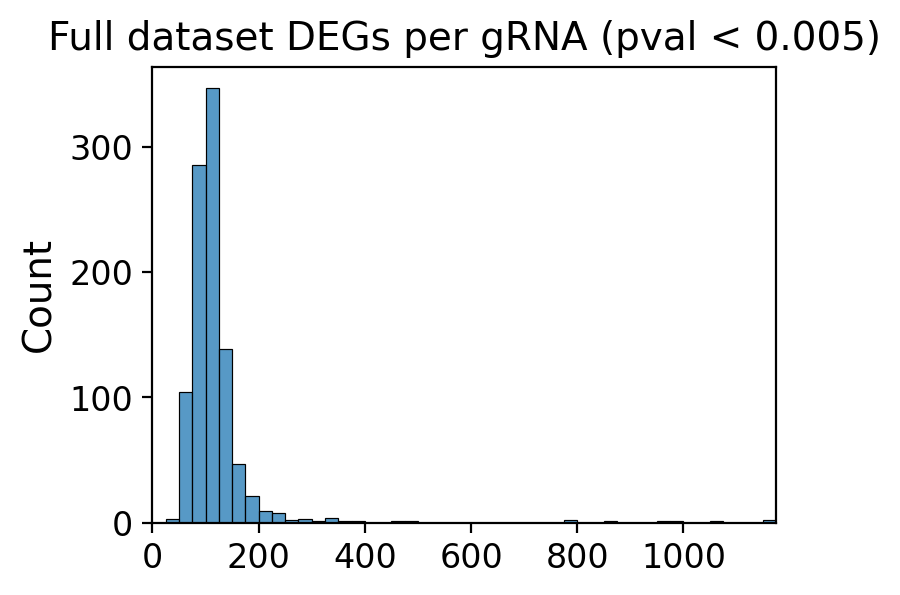

In [27]:
plot_DEGs_per_KD_histogram(n_degs_df_005, title="Full dataset DEGs per gRNA (pval < 0.005)", 
                           bin_width=25, xtick_width=200)

NTC benchmarking

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def ntc_benchmarking_DE_unmatched(adata: ad.AnnData,
                                layer: str = "counts",
                                min_cells_for_3_reps: int = 60,
                                random_state: int = 42,
                                DE_fit_type: str = "parametric",
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting",
                                n_cpus_for_DE: int = 3,
                                n_jobs_parallel: int = 25,
                                alpha: float = 0.05,
                                suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            DE_inference = DefaultInference(n_cpus=n_cpus_for_DE)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               fit_type=DE_fit_type,
                               inference=DE_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=DE_inference,
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05,
                                    threshold_type: str = "padj", percentile: int = 95):
    """
    Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
    fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
    a summary of results.
    """
    if (threshold_type != "padj") & (threshold_type != "pvalue"):
        raise ValueError("threshold_type must be 'padj' or 'pvalue'")
    # Counts DEGs per gRNA
    deg_counts = {}
    for ntc_gRNA, result_df in results_dict.items():
        if result_df is None:
            continue
        deg_count = sum((result_df[threshold_type] < alpha) & pd.notna(result_df[threshold_type]))
        deg_counts[ntc_gRNA] = deg_count

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate percentile threshold
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, percentile)
    else:
        print("No results to calculate percentile.")
        return
    
    # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
    # Set style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    fig.patch.set_facecolor('white')
    # Prepare bar plot data: discrete DEG counts
    deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
    # Create bar plot
    ax.bar(
        deg_counts.index,
        deg_counts.values,
        alpha=0.8,
        color='#4682B4',   # Steel blue
        edgecolor='white',
        linewidth=1.5
    )
    # Add threshold line with improved styling
    ax.axvline(
        deg_threshold,
        color='#B22222',  # Firebrick
        linestyle='-',
        linewidth=2,
        alpha=0.8
    )
    # Labels and title with improved styling
    ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
    ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
    # Turn off grid
    ax.grid(False)
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
    # Add some padding to the axes
    ax.margins(x=0.02)
    # Add custom legend-like text at bottom
    threshold_text = f"{threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs"
    fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • {threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • {percentile}% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

In [35]:
ntc_benchmark_results_dict = \
    ntc_benchmarking_DE_unmatched(adata, random_state=42, DE_fit_type="mean", n_cpus_for_DE=3,
    n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

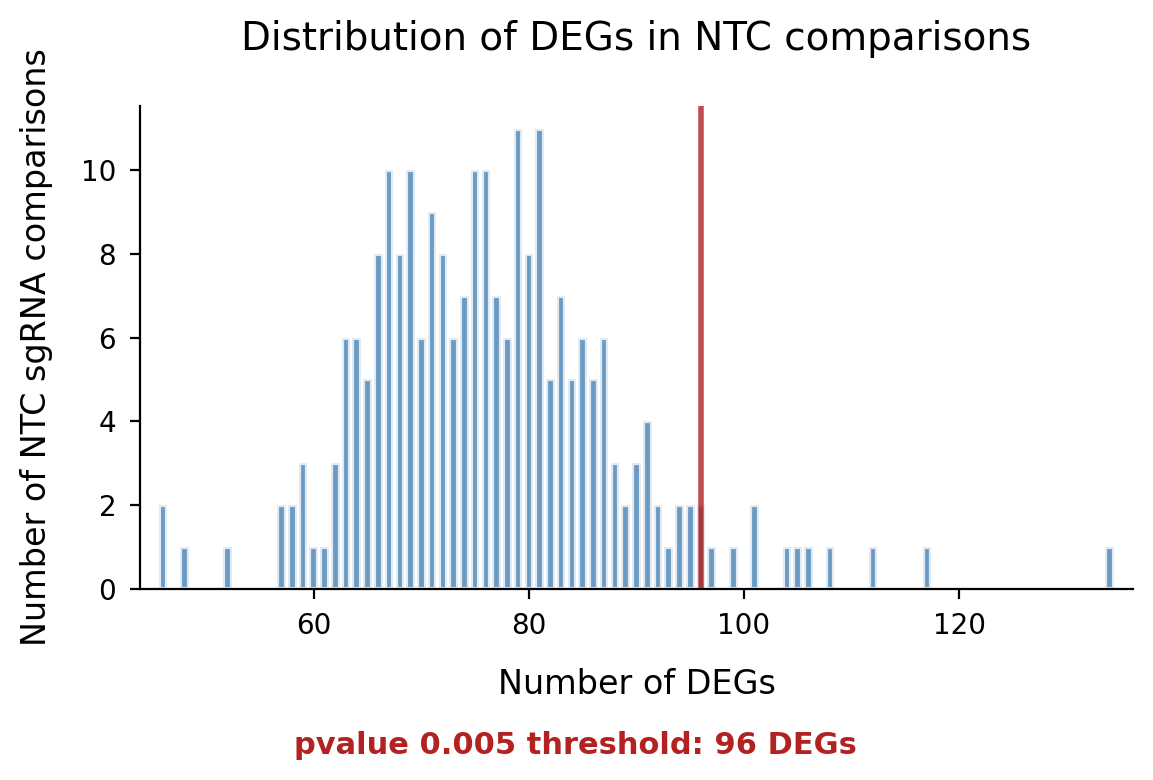

NTC Benchmark Statistics:
  • pvalue 0.005 threshold: 96 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 76.6
  • Median DEGs per comparison: 76.0
  • 95% of comparisons have < 96 DEGs


In [36]:
deg_threshold_005, ntc_benchmark_res_005 = \
    report_ntc_benchmarking_results(ntc_benchmark_results_dict, alpha=0.005, threshold_type="pvalue")

In [37]:
ntc_grna_rm_df_005 = ntc_benchmark_res_005[ntc_benchmark_res_005["n_DEGs"] > deg_threshold_005]
ntc_grna_rm_df_005

n_DEGs
Non-Targeting_512     134
Non-Targeting_398     117
Non-Targeting_636     112
Non-Targeting_266     108
Non-Targeting_142     106
Non-Targeting_573     105
Non-Targeting_665     104
Non-Targeting_516     101
Non-Targeting_702     101
Non-Targeting_430      99
Non-Targeting_162      97

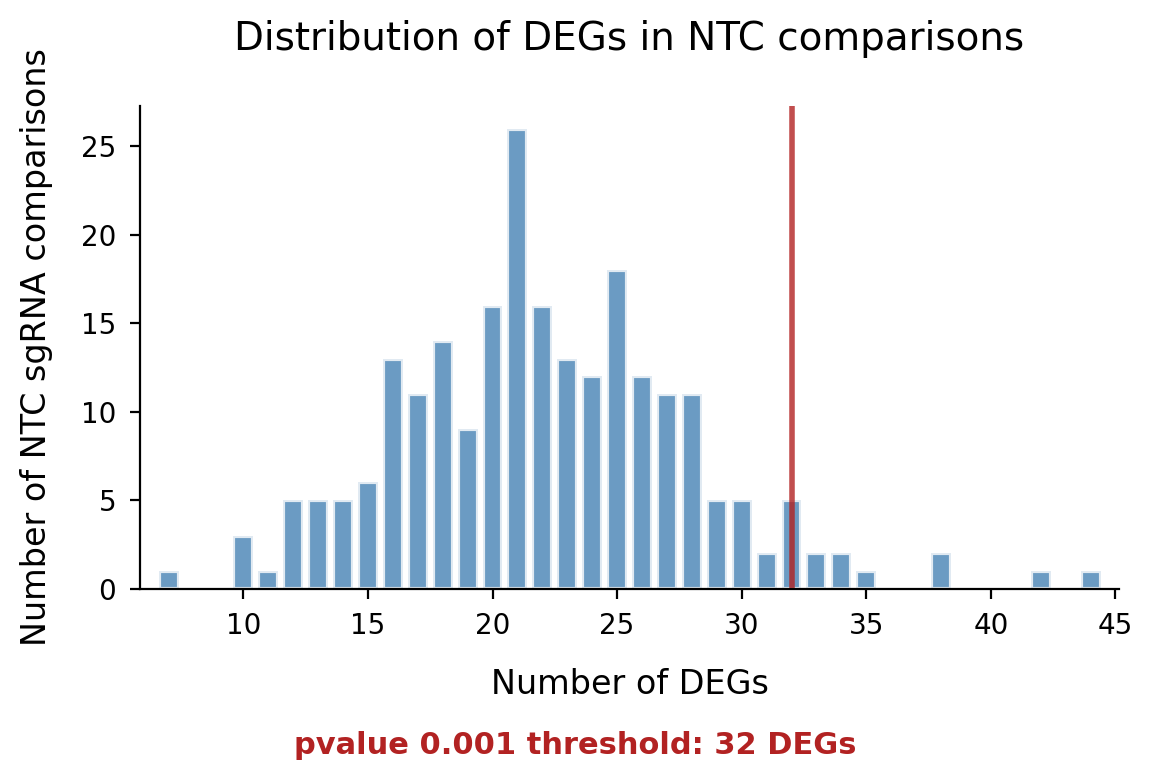

NTC Benchmark Statistics:
  • pvalue 0.001 threshold: 32 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 22.1
  • Median DEGs per comparison: 22.0
  • 95% of comparisons have < 32 DEGs


In [38]:
deg_threshold_001, ntc_benchmark_res_001 = \
    report_ntc_benchmarking_results(ntc_benchmark_results_dict, alpha=0.001, threshold_type="pvalue")

In [39]:
ntc_grna_rm_df_001 = ntc_benchmark_res_001[ntc_benchmark_res_001["n_DEGs"] > deg_threshold_001]
ntc_grna_rm_df_001

n_DEGs
Non-Targeting_512      44
Non-Targeting_398      42
Non-Targeting_142      38
Non-Targeting_702      38
Non-Targeting_942      35
Non-Targeting_266      34
Non-Targeting_622      34
Non-Targeting_541      33
Non-Targeting_832      33

In [40]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [41]:
ntc_de_df_unmatched = build_DE_df(ntc_benchmark_results_dict)
filepath = "/home/ranwyl/results_tf_project/NTC_benchmark_unmatched_1-22-26.pkl"
ntc_de_df_unmatched.to_pickle(filepath)

In [25]:
filepath = "/home/ranwyl/results_tf_project/NTC_benchmark_unmatched_1-22-26.pkl"
ntc_de_df_unmatched = pd.read_pickle(filepath)
ntc_de_df_unmatched.head()

Non-Targeting_186_baseMean  Non-Targeting_186_log2FoldChange  \
A1BG                         2.296636                         -0.986206   
A1BG-AS1                     0.347335                         -1.225754   
A2M                          0.266587                          0.437242   
A2ML1                        0.970272                          1.080053   
A2ML1-AS1                    2.951713                          0.531412   

           Non-Targeting_186_lfcSE  Non-Targeting_186_stat  \
A1BG                      0.843619               -1.169019   
A1BG-AS1                  2.386839               -0.513547   
A2M                       1.459369                0.299610   
A2ML1                     0.606544                1.780667   
A2ML1-AS1                 0.450042                1.180806   

           Non-Targeting_186_pvalue  Non-Targeting_186_padj  \
A1BG                       0.242396                0.999181   
A1BG-AS1                   0.607569                0.999181   
A2M                        0.764474                0.999181   
A2ML1                      0.074967                0.999181   
A2ML1-AS1                  0.237680                0.999181   

           Non-Targeting_567_baseMean  Non-Targeting_567_log2FoldChange  \
A1BG                         2.296636                         -0.004127   
A1BG-AS1                     0.347335                         -1.083996   
A2M                          0.266587                         -0.857713   
A2ML1                        0.970272                          0.861863   
A2ML1-AS1                    2.951713                         -0.688304   

           Non-Targeting_567_lfcSE  Non-Targeting_567_stat  ...  \
A1BG                      0.658067               -0.006272  ...   
A1BG-AS1                  2.383852               -0.454725  ...   
A2M                       2.385270               -0.359587  ...   
A2ML1                     0.734855                1.172834  ...   
A2ML1-AS1                 0.730159               -0.942676  ...   

           Non-Targeting_906_lfcSE  Non-Targeting_906_stat  \
A1BG                      0.734557                0.081910   
A1BG-AS1                  1.458474                0.339389   
A2M                       1.052571                1.685213   
A2ML1                     1.449630               -0.285069   
A2ML1-AS1                 0.731138               -0.378972   

           Non-Targeting_906_pvalue  Non-Targeting_906_padj  \
A1BG                       0.934719                0.997691   
A1BG-AS1                   0.734317                0.997691   
A2M                        0.091947                0.997691   
A2ML1                      0.775591                0.997691   
A2ML1-AS1                  0.704709                0.997691   

           Non-Targeting_890_baseMean  Non-Targeting_890_log2FoldChange  \
A1BG                         2.296636                         -0.658944   
A1BG-AS1                     0.347335                          0.691923   
A2M                          0.266587                         -0.471283   
A2ML1                        0.970272                         -1.387444   
A2ML1-AS1                    2.951713                          0.354777   

           Non-Targeting_890_lfcSE  Non-Targeting_890_stat  \
A1BG                      1.032797               -0.638018   
A1BG-AS1                  1.464696                0.472400   
A2M                       2.375085               -0.198428   
A2ML1                     2.355849               -0.588936   
A2ML1-AS1                 0.660562                0.537083   

           Non-Targeting_890_pvalue  Non-Targeting_890_padj  
A1BG                       0.523462                0.999822  
A1BG-AS1                   0.636641                0.999822  
A2M                        0.842710                0.999822  
A2ML1                      0.555904                0.999822  
A2ML1-AS1                  0.591210                0.999822  

[5 ro

In [26]:
ntc_bench_unmatched_n_degs_df = build_n_DEGs_df(ntc_de_df_unmatched, alpha=0.005, threshold_type="pvalue")
np.mean(ntc_bench_unmatched_n_degs_df["n_DEGs"])

76.55128205128206

In [46]:
ntc_grna_to_remove = ntc_grna_rm_df_001.index.tolist()

In [49]:
print(len(ntc_grna_to_remove))

9


In [51]:
print(adata[adata.obs.perturbed == "False"].obs.gRNA.nunique())

234


In [53]:
adata_ntc_filt = adata[~adata.obs.gRNA.isin(ntc_grna_to_remove)].copy()

In [54]:
print(adata_ntc_filt[adata_ntc_filt.obs.perturbed == "False"].obs.gRNA.nunique())

225


In [77]:
ntc_filt_benchmark_results_unmatched = \
    ntc_benchmarking_DE_unmatched(adata_ntc_filt, random_state=42, DE_fit_type="mean", n_cpus_for_DE=3,
    n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/225 [00:00<?, ?it/s]

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



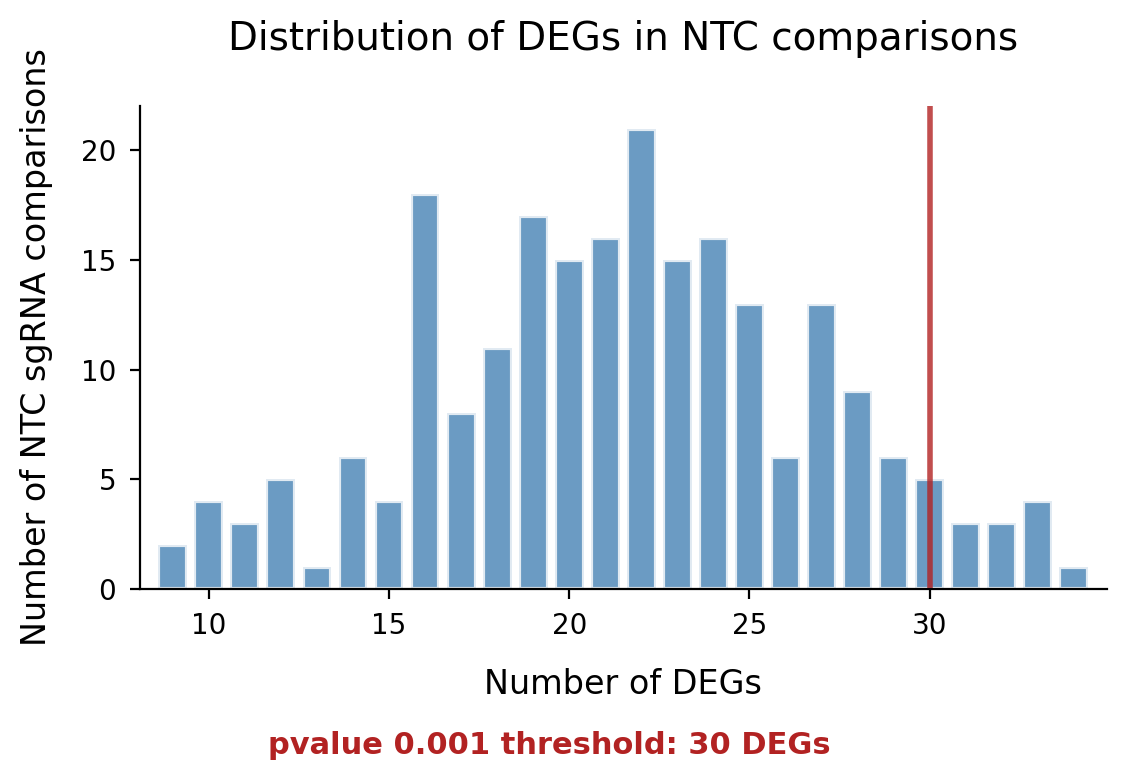

NTC Benchmark Statistics:
  • pvalue 0.001 threshold: 30 DEGs
  • NTC comparisons analyzed: 225
  • Mean DEGs per comparison: 21.5
  • Median DEGs per comparison: 22.0
  • 95% of comparisons have < 30 DEGs


In [79]:
deg_threshold_filt_unmatched_001, ntc_benchmark_res_filt_unmatched_001 = \
    report_ntc_benchmarking_results(ntc_filt_benchmark_results_unmatched, alpha=0.001, threshold_type="pvalue")

In [16]:
def generate_matched_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                            target_value: str, 
                                            ntc_cell_indices: pd.Index, 
                                            rng: np.random.Generator, 
                                            target_column: str = "perturbation", 
                                            min_cells_per_rep: int = 12,
                                            layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def ntc_benchmarking_matched_DE(adata: ad.AnnData,
                                layer: str = "counts",
                                min_cells_per_rep: int = 12,
                                random_state: int = 42,
                                n_cpus_for_DE: int = 3,
                                n_jobs_parallel: int = 25, 
                                alpha: float = 0.05,
                                DE_fit_type: str = "parametric",
                                ntc_target_delimiter: str = "NTC",
                                gRNA_column: str = "gRNA",
                                suppress_warnings: bool = False,
                                debug: bool = False):
    """
    Perform DE analysis on each NTC gRNA against a matched
    number of other NTC cells. 
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    ntc_adata = adata[adata.obs.gene_target == ntc_target_delimiter].copy()
    # Get unique NTC sgRNAs
    ntc_gRNAs = list(ntc_adata.obs[gRNA_column].unique())
    if debug == True:
        print("Running in debug mode with 5 NTC sgRNA")
        ntc_gRNAs = ntc_gRNAs[:5]
    # Create RNG object to handle case where one is not provided
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_ntc_gRNA(target_ntc_gRNA: str,
                         rng: np.random.Generator):
        # Check if there are enough target cells
        target_cells = ntc_adata[ntc_adata.obs[gRNA_column] == target_ntc_gRNA].obs.index
        if len(target_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few cells ({len(target_cells)})")
            return
        
        # Get other NTC cells (excluding the target gRNA)
        other_ntc_cells = ntc_adata[ntc_adata.obs[gRNA_column] != target_ntc_gRNA].obs.index
        if len(other_ntc_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few other NTC cells ({len(other_ntc_cells)})")
            return
        
        # Temporarily create "perturbation" column to use with generate_pseudoreplicates_for_DE
        # This labels target gRNA cells as the "perturbation" and other NTC cells as "NTC"
        ntc_adata_temp = ntc_adata.copy()
        ntc_adata_temp.obs["temp_pert"] = "NTC"
        ntc_adata_temp.obs.loc[ntc_adata_temp.obs[gRNA_column] == target_ntc_gRNA, 'temp_pert'] = target_ntc_gRNA
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            ntc_adata_temp, target_ntc_gRNA, other_ntc_cells, rng, 
            target_column="temp_pert", layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=True
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target_ntc_gRNA.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=True)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res, ntc_adata_temp
        gc.collect()

        return de_results

    # Run DE analysis on all NTC sgRNA in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(ntc_gRNAs)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_ntc_gRNA)(ntc_gRNA, de_rng) for ntc_gRNA in ntc_gRNAs)
    results_dict = dict(zip(ntc_gRNAs, de_results))
    return results_dict

In [56]:
ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata_ntc_filt, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/225 [00:00<?, ?it/s]

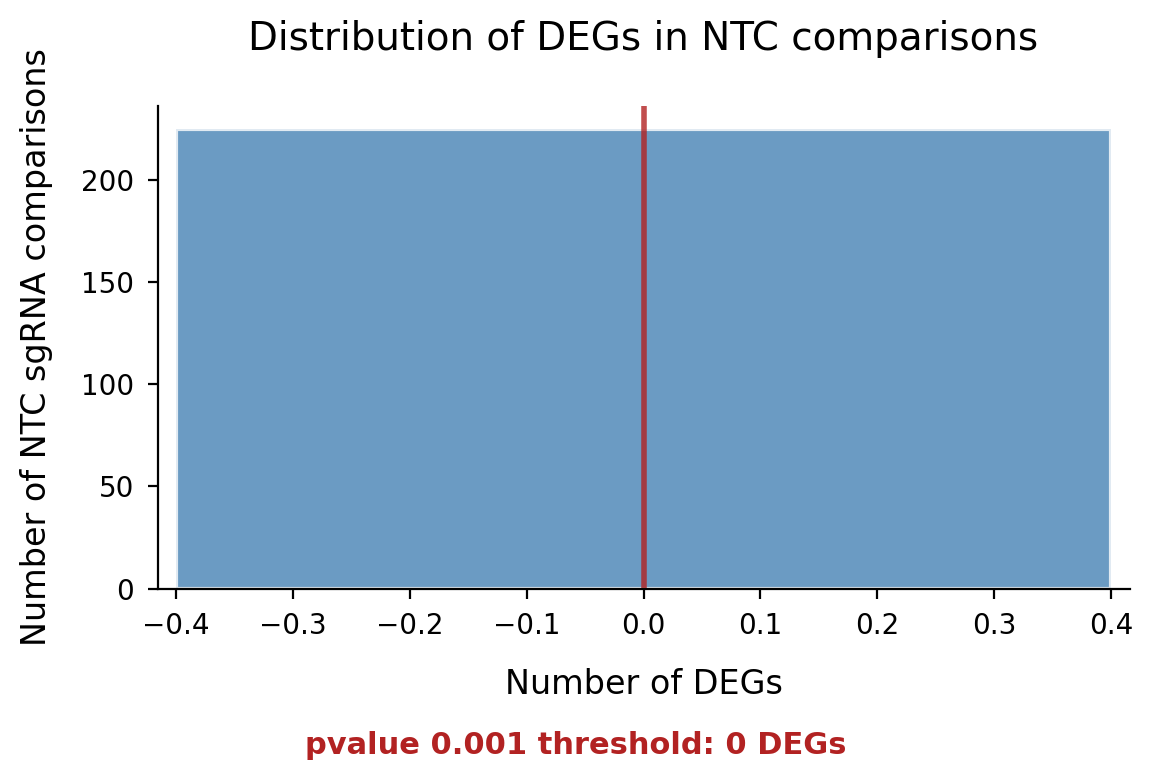

NTC Benchmark Statistics:
  • pvalue 0.001 threshold: 0 DEGs
  • NTC comparisons analyzed: 225
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [80]:
deg_threshold_matched_001, ntc_benchmark_res_matched_001 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.001, threshold_type="pvalue")

Matched DE on full results

In [60]:
full_ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

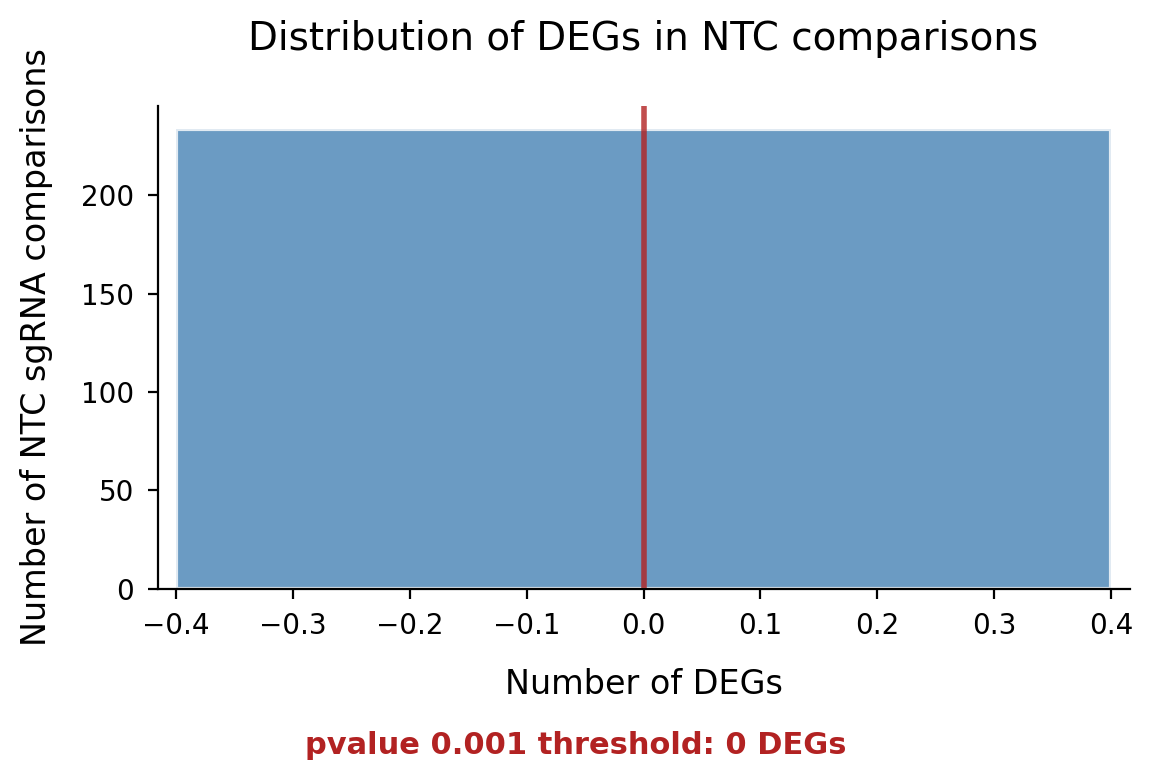

NTC Benchmark Statistics:
  • pvalue 0.001 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [82]:
full_deg_threshold_matched_001, full_ntc_benchmark_res_matched_001 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.001, threshold_type="pvalue")

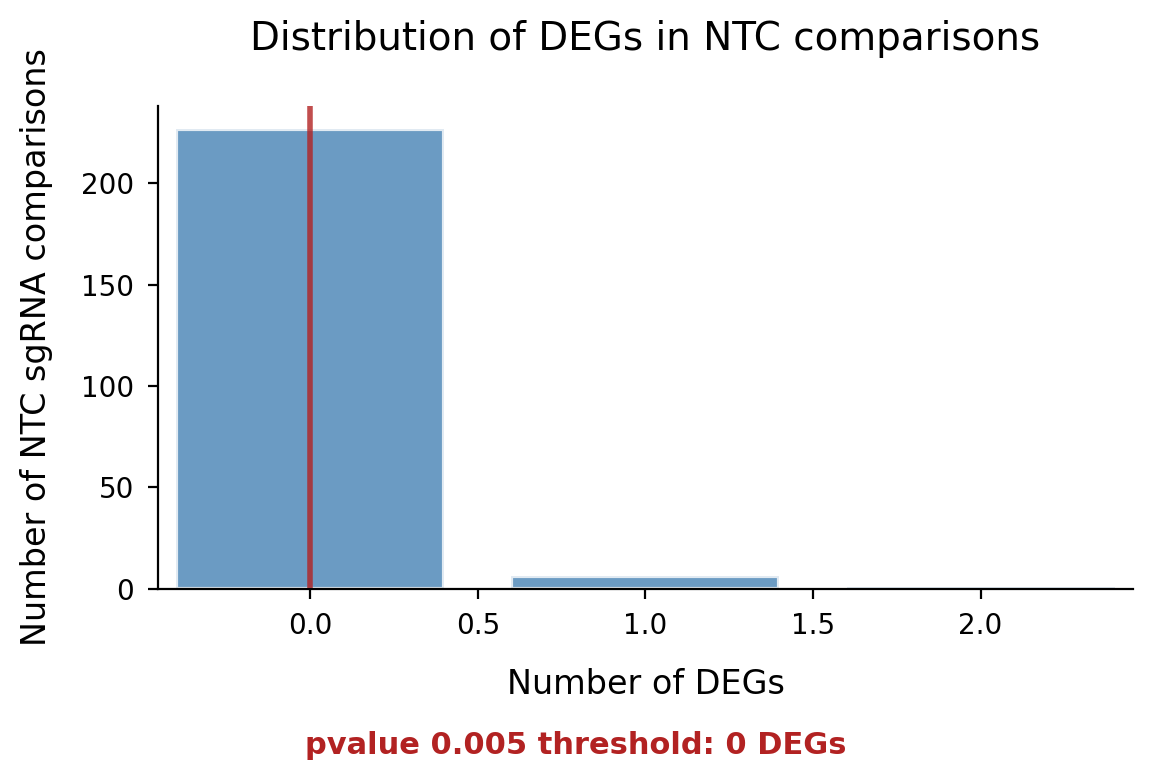

NTC Benchmark Statistics:
  • pvalue 0.005 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [73]:
full_deg_threshold_matched_005, full_ntc_benchmark_res_matched_005 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.005, threshold_type="pvalue")

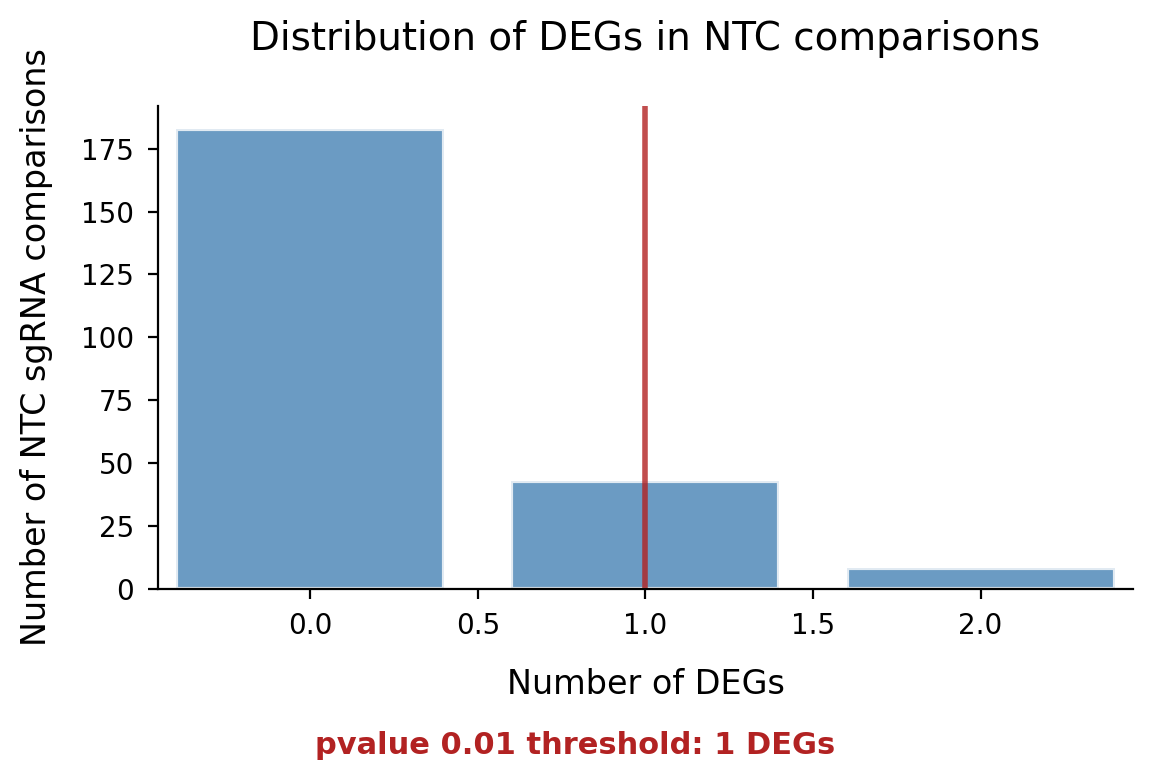

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 1 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.3
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 1 DEGs


In [87]:
full_deg_threshold_matched_01, full_ntc_benchmark_res_matched_01 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.01, threshold_type="pvalue")

In [ ]:
full_matched_de_df = build_DE_df(full_ntc_bench_matched_results_dict)
full_matched_n_degs_df = build_n_DEGs_df(full_matched_de_df, 0.05, threshold_type="pvalue", target_type="gRNA")
deg_thr_68_full_matched = round(np.percentile(full_matched_n_degs_df['n_DEGs'].values, 68))
print(f"DEG threshold at pval < 0.05: {deg_thr_68_full_matched} DEGs")

DEG threshold at pval < 0.05: 22 DEGs


In [99]:
print(f"Remove {len(full_matched_n_degs_df[full_matched_n_degs_df['n_DEGs'] > deg_thr_68_full_matched])} gRNAs")

Remove 75 gRNAs


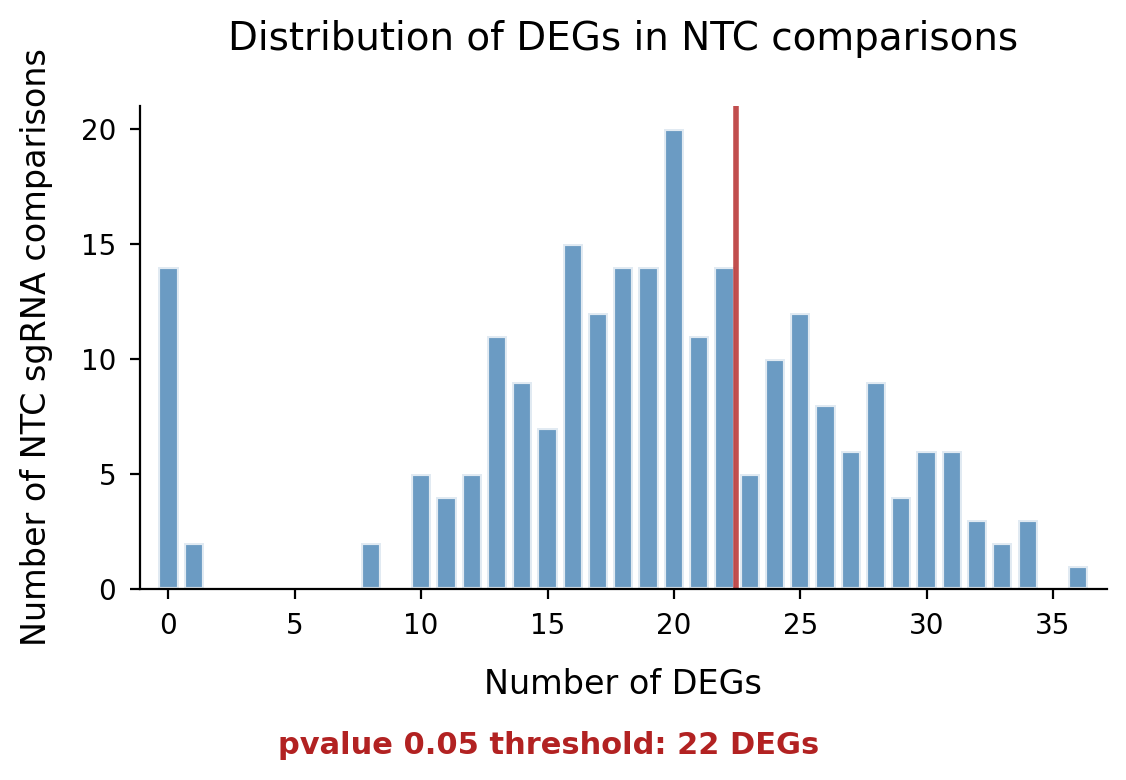

NTC Benchmark Statistics:
  • pvalue 0.05 threshold: 22 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 19.3
  • Median DEGs per comparison: 20.0
  • 68% of comparisons have < 22 DEGs


In [101]:
full_deg_threshold_matched_05_68, full_ntc_benchmark_res_matched_05_68 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.05, threshold_type="pvalue", percentile=68)

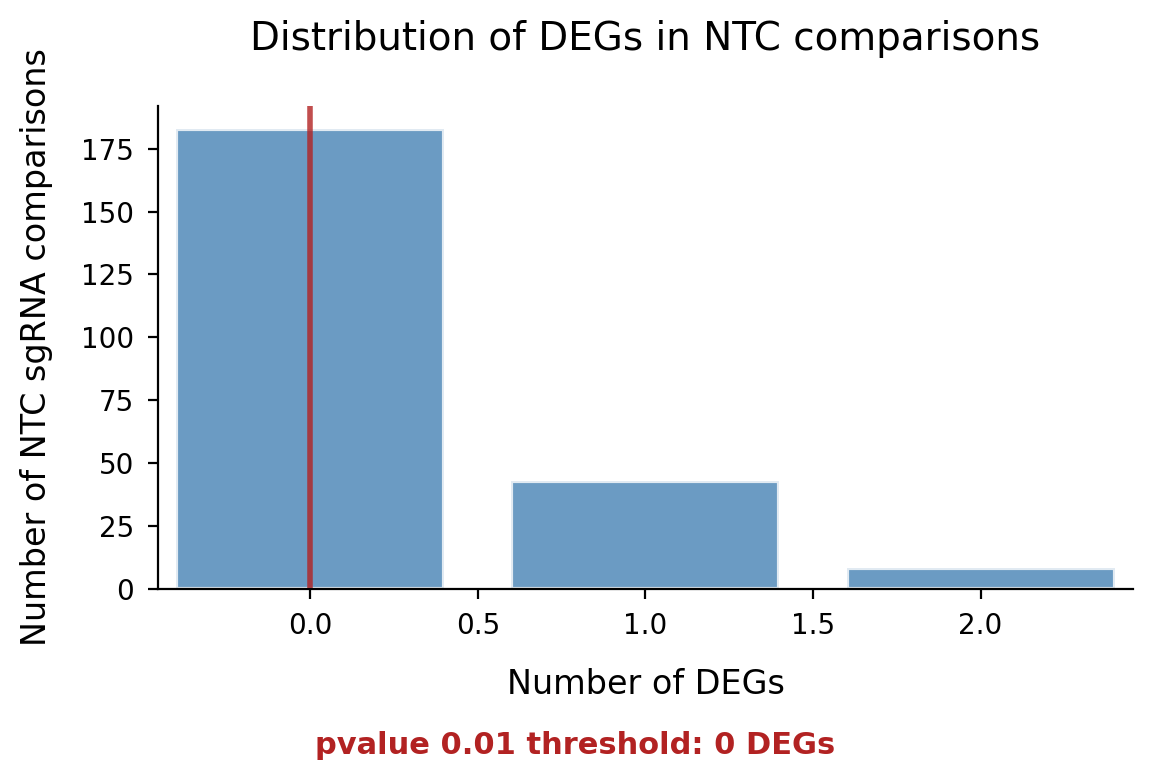

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.3
  • Median DEGs per comparison: 0.0
  • 68% of comparisons have < 0 DEGs


In [102]:
full_deg_threshold_matched_01_68, full_ntc_benchmark_res_matched_01_68 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.01, threshold_type="pvalue", percentile=68)

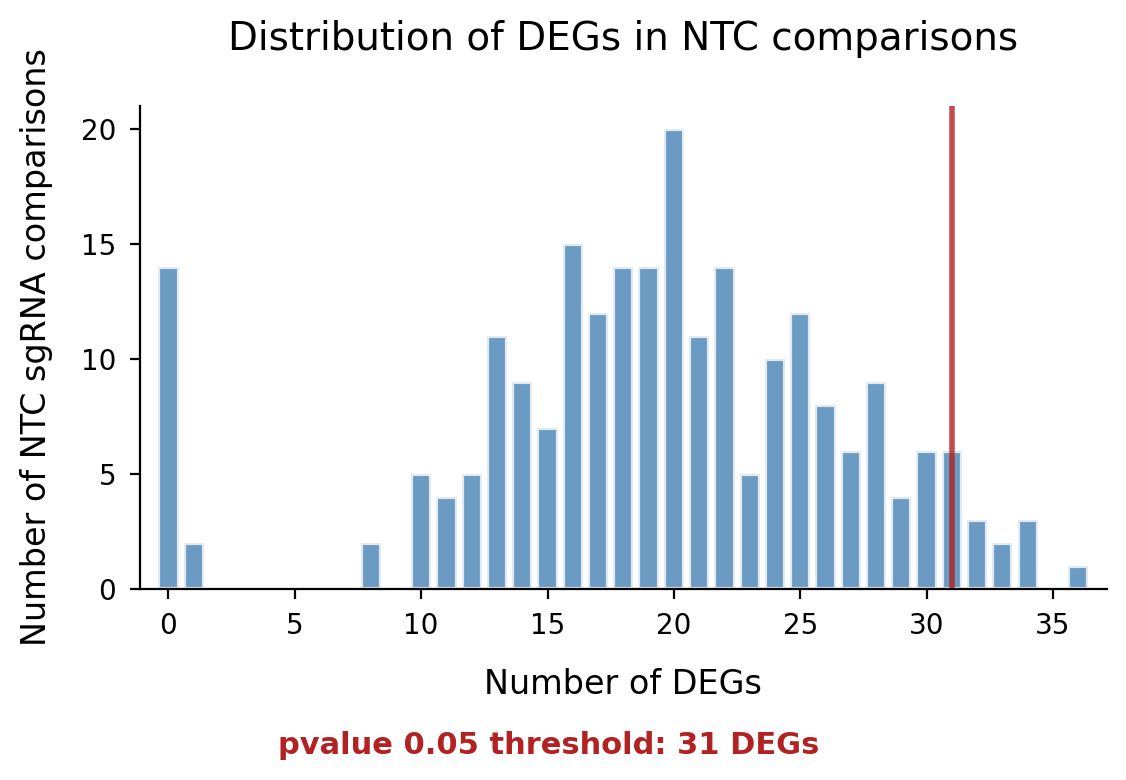

NTC Benchmark Statistics:
  • pvalue 0.05 threshold: 31 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 19.3
  • Median DEGs per comparison: 20.0
  • 95% of comparisons have < 31 DEGs


In [ ]:
full_deg_threshold_matched_05, full_ntc_benchmark_res_matched_05 = \
    report_ntc_benchmarking_results(full_ntc_bench_matched_results_dict, alpha=0.05, threshold_type="pvalue")

In [83]:
ntc_grna_rm_df_05 = full_ntc_benchmark_res_matched_05[full_ntc_benchmark_res_matched_05["n_DEGs"] > full_deg_threshold_matched_05]
ntc_grna_rm_df_05

n_DEGs
Non-Targeting_7        36
Non-Targeting_681      34
Non-Targeting_761      34
Non-Targeting_320      34
Non-Targeting_430      33
Non-Targeting_818      33
Non-Targeting_719      32
Non-Targeting_471      32
Non-Targeting_939      32

In [84]:
ntc_grna_to_remove_05 = ntc_grna_rm_df_05.index.tolist()
adata_ntc_filt_05 = adata[~adata.obs.gRNA.isin(ntc_grna_to_remove_05)].copy()

In [85]:
filt_ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata_ntc_filt_05, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/225 [00:00<?, ?it/s]

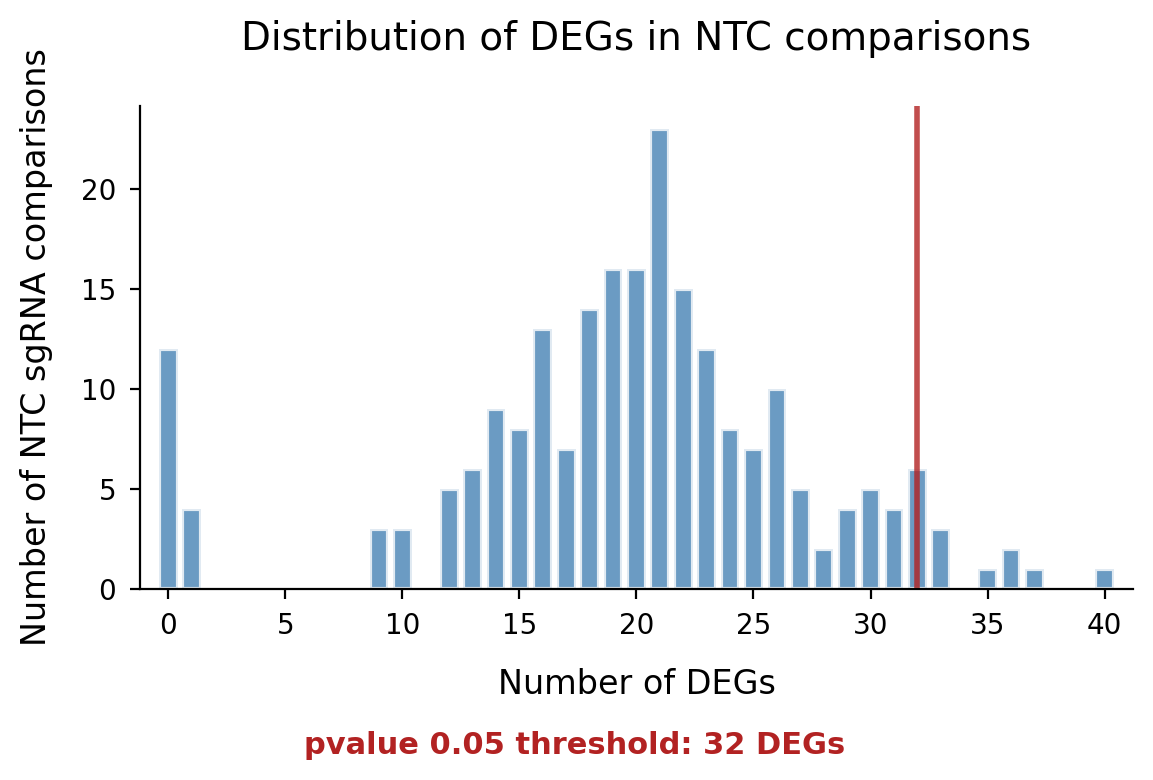

NTC Benchmark Statistics:
  • pvalue 0.05 threshold: 32 DEGs
  • NTC comparisons analyzed: 225
  • Mean DEGs per comparison: 19.6
  • Median DEGs per comparison: 20.0
  • 95% of comparisons have < 32 DEGs


In [86]:
filt_deg_threshold_matched_05, filt_ntc_benchmark_res_matched_05 = \
    report_ntc_benchmarking_results(filt_ntc_bench_matched_results_dict, alpha=0.05, threshold_type="pvalue")

Revisit individual DE

In [ ]:
individual_de_df = pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_individual_11-12-25.pkl")
individual_de_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              8.485499              -0.119356      0.596995    -0.199929   
A1BG-AS1          1.185938              -1.553294      1.669547    -0.930369   
A2M               0.897699               3.206850      2.431359     1.318954   
A2ML1             2.622566               0.153965      1.028798     0.149655   
A2ML1-AS1        12.562553              -0.204420      0.485794    -0.420796   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.841536     0.999886          2.210970   
A1BG-AS1        0.352180     0.999886          0.521868   
A2M             0.187185     0.999886          0.326461   
A2ML1           0.881037     0.999886          0.996873   
A2ML1-AS1       0.673904     0.999886          3.399539   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.668174       1.182508      0.565048  ...   
A1BG-AS1                -2.632537       2.347140     -1.121593  ...   
A2M                     -0.189915       2.442494     -0.077754  ...   
A2ML1                   -1.183046       1.468561     -0.805582  ...   
A2ML1-AS1               -0.040420       1.068184     -0.037840  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.446993      0.609317        0.542314      0.996282   
A1BG-AS1        2.551740      0.261024        0.794074      0.996282   
A2M             2.569250      1.160049        0.246029      0.996282   
A2ML1           2.280193     -0.059063        0.952902      0.996973   
A2ML1-AS1       0.920695     -0.360830        0.718227      0.996282   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.307094                 -0.058788         3.306508   
A1BG-AS1             0.475201                  2.384618         2.907860   
A2M                  0.342046                 -1.956681         3.347521   
A2ML1                0.485676                  0.854366         2.636721   
A2ML1-AS1            2.244037                 -0.484645         1.300201   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.017780          0.985815        0.999155  
A1BG-AS1         0.820060          0.412182        0.999155  
A2M             -0.584517          0.558873        0.999155  
A2ML1            0.324026          0.745918        0.999155  
A2ML1-AS1       -0.372746          0.709337        0.999155  

[5 rows x 5916 columns]

In [76]:
pvalues = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
pvals_degs_df = test_pvals(individual_de_df, pvalues, target_type="gRNA", ntc_deg_threshold=1)
pvals_degs_df

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥1 DEGs
pval < 0.1                    222                   216                 985
pval < 0.05                    65                    59                 983
pval < 0.01                     7                     5                 920
pval < 0.005                    3                     2                 773
pval < 0.001                    1                     0                 403
pval < 0.0005                   1                     0                 314
pval < 0.0001                   0                     0                 196

### Testing chunk NTC benchmarking

In [14]:
import pandas as pd
import numpy as np
import anndata as ad

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

How many NTC gRNAs have <60 cells (2 reps for DE) and how many have >=60 cells (3 reps for DE)

In [20]:
adata[adata.obs.perturbed == "False"].obs.gRNA.nunique()

234

In [14]:
ntc_gRNA_df = pd.DataFrame(adata[adata.obs.perturbed == "False"].obs.gRNA.value_counts())
ntc_gRNA_df.head()

count
gRNA                    
Non-Targeting_747    123
Non-Targeting_471    116
Non-Targeting_767    109
Non-Targeting_329    102
Non-Targeting_688    101

In [13]:
print(f"{len(ntc_gRNA_df[ntc_gRNA_df['count'] < 60])} NTC gRNAs with 2 reps")
print(f"{len(ntc_gRNA_df[ntc_gRNA_df['count'] >= 60])} NTC gRNAs with 3 reps")

134 NTC gRNAs with 2 reps
100 NTC gRNAs with 3 reps


In [15]:
pert_gRNA_df = pd.DataFrame(adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts())
pert_gRNA_df.head()

count
gRNA             
HNF1A_1       279
BHLHE40_1     279
ARHGAP35_3    252
ZFP41_3       241
HNF4A_2       239

In [16]:
print(f"{len(pert_gRNA_df[pert_gRNA_df['count'] < 60])} perturbing gRNAs with 2 reps")
print(f"{len(pert_gRNA_df[pert_gRNA_df['count'] >= 60])} perturbing gRNAs with 3 reps")

185 perturbing gRNAs with 2 reps
801 perturbing gRNAs with 3 reps


NTC benchmarking

In [ ]:
# Old code using contrast vector

# import math

# def NTC_benchmarking_DE_with_KDs(adata: ad.AnnData,
#                                 ref_ntc_gRNA: str = "Non-Targeting_747",
#                                 layer: str = "counts",
#                                 min_cells_for_3_reps: int = 60,
#                                 random_state: int = 42,
#                                 ntc_target_delimiter: str = "NTC",
#                                 ntc_gRNA_delimiter: str = "Non-Targeting",
#                                 n_cpus: int = 20, alpha: float = 0.05,
#                                 suppress_warnings: bool = False, 
#                                 debug: bool = False):
#     """
#     Perform DE analysis on all NTC gRNAs. Run DE analysis on a subset of the dataset
#     containing all NTC gRNAs and an equal number of randomly chosen perturbing gRNAs.
#     (The full set of gRNAs are used to fit dispersions/LFCs, and then each NTC gRNA 
#     is compared to all other NTC cells.) 
#     Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
#     """
#     quiet = False if debug == True else True
#     # Create 2 chunks of NTC gRNAs
#     all_ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
#     non_ref_ntc_gRNAs = [g for g in all_ntc_gRNAs if g != ref_ntc_gRNA]
#     max_chunk_ntc = math.ceil(len(non_ref_ntc_gRNAs) / 2)
#     chunk1_ntc_gRNAs = non_ref_ntc_gRNAs[:max_chunk_ntc]
#     chunk2_ntc_gRNAs = non_ref_ntc_gRNAs[max_chunk_ntc:]
#     pert_gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.unique().tolist()
#     rng = np.random.default_rng(random_state)
#     subset_pert_gRNAs = rng.choice(pert_gRNAs, size=max_chunk_ntc)
#     chunk1_adata = adata[(adata.obs.gRNA.isin(chunk1_ntc_gRNAs)) |
#                          (adata.obs.gRNA.isin(subset_pert_gRNAs)) |
#                          (adata.obs.gRNA == ref_ntc_gRNA)].copy()
#     chunk2_adata = adata[(adata.obs.gRNA.isin(chunk2_ntc_gRNAs)) |
#                          (adata.obs.gRNA.isin(subset_pert_gRNAs)) |
#                          (adata.obs.gRNA == ref_ntc_gRNA)].copy()
#     chunks = [(1, chunk1_adata, chunk1_ntc_gRNAs), (2, chunk2_adata, chunk2_ntc_gRNAs)]
    
#     # Helper function to run statistical testing on single NTC gRNA
#     def ntc_benchmarking_single_gRNA(target_ntc_gRNA_hyphenated):
#         # Create contrast vector
#         target_col = f"condition_{target_ntc_gRNA_hyphenated}_vs_{ref_ntc_gRNA_hyphenated}"
#         contrast_vec = np.zeros(len(design_cols)) # Initialize contrast vector
#         contrast_vec[design_cols.index(target_col)] = 1.0 # Set NTC target col to 1
#         other_cols = [c for c in ntc_coeff_cols if c != target_col]
#         weight = -1.0 / len(other_cols)
#         for col in other_cols:
#             contrast_vec[design_cols.index(col)] = weight

#         # Perform statistical testing with DeseqStats.summary()
#         with handle_warnings(suppress_warnings):
#             ds_inference = DefaultInference(n_cpus=1)
#             ds = DeseqStats(dds,
#                             contrast=contrast_vec, 
#                             alpha=alpha,
#                             inference=ds_inference, 
#                             quiet=quiet)
#             ds.summary()
#             return ds.results_df
        
#     # Run DE on each chunk
#     all_de_results = list()
#     for chunk in chunks:
#         chunk_n, chunk_adata, chunk_ntc_gRNAs = chunk[0], chunk[1], chunk[2]
#         # Create pseudobulk representation of dataset
#         print(f"Running DE analysis on chunk {chunk_n} of 2")
#         counts_df, metadata_df = \
#             create_pseudobulk_dataset(chunk_adata, target_type="gRNA", 
#                                     ntc_benchmarking=True, layer=layer,
#                                     min_cells_for_3_reps=min_cells_for_3_reps,
#                                     random_state=random_state,
#                                     ntc_target_delimiter=ntc_target_delimiter,
#                                     ntc_gRNA_delimiter=ntc_gRNA_delimiter,
#                                     ntc_condition_label="gRNA")

#         # Fit dispersions and LFCs with DeseqDataSet.deseq2()
#         ref_ntc_gRNA_hyphenated = ref_ntc_gRNA.replace("_", "-")
#         with handle_warnings(suppress_warnings):
#             dds_inference = DefaultInference(n_cpus=n_cpus)
#             dds = DeseqDataSet(counts=counts_df, 
#                                 metadata=metadata_df,
#                                 design_factors="condition",
#                                 continuous_factors=["n-cells-in-rep"],
#                                 ref_level=["condition", ref_ntc_gRNA_hyphenated],
#                                 inference=dds_inference, 
#                                 quiet=False)
#             dds.deseq2()

#         # Access design matrix
#         design_cols = list(dds.obsm["design_matrix"].columns)
#         ntc_coeff_cols = \
#             [col for col in design_cols if col.startswith(f"condition_{ntc_gRNA_delimiter}")]
    
#         # Run DE on all NTC gRNA
#         chunk_ntc_gRNAs_hyphenated = [g.replace("_", "-") for g in chunk_ntc_gRNAs]
#         with tqdm_joblib(desc="Running DE statistical analysis", total=len(chunk_ntc_gRNAs)):
#             de_results = Parallel(n_jobs=n_cpus)(
#                 delayed(ntc_benchmarking_single_gRNA)(ntc_gRNA) 
#                 for ntc_gRNA in chunk_ntc_gRNAs_hyphenated)
#         all_de_results += de_results
        
#     de_results_dict = {non_ref_ntc_gRNAs[i]: all_de_results[i] for i in range(len(non_ref_ntc_gRNAs))}
#     return de_results_dict

In [ ]:
# DE functions
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting",
                              ntc_condition_label: str = "NTC"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if (ntc_gRNA_delimiter in target) & (ntc_condition_label == "NTC"):
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
    
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [48]:
def ntc_benchmarking_DE_with_KDs(adata: ad.AnnData,
                                n_chunks: int = 4,
                                layer: str = "counts",
                                min_cells_for_3_reps: int = 60,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting",
                                n_jobs_parallel: int = 20, n_cpus_for_DE: int = 4,
                                alpha: float = 0.05,
                                suppress_warnings: bool = False,
                                debug: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    quiet = False if debug is True else True
    # Divide NTC gRNAs into chunks
    ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
    n_targets = len(ntc_gRNAs)
    base_size = n_targets // n_chunks
    remainder = n_targets % n_chunks
    ntc_chunk_sizes = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
    rng = np.random.default_rng(random_state)
    target_indices = np.arange(n_targets)
    rng.shuffle(target_indices)
    ntc_chunk_splits = np.cumsum(np.array(ntc_chunk_sizes))[:-1]
    ntc_chunk_indices = np.split(target_indices, ntc_chunk_splits)
    all_chunk_ntc_gRNAs = list()
    for i in range(n_chunks):
        all_chunk_ntc_gRNAs.append([ntc_gRNAs[j] for j in ntc_chunk_indices[i]])
    print(f"NTC gRNAs per chunk: {ntc_chunk_sizes}")

    # Randomly choose perturbing gRNAs
    max_ntc_chunk_size = max(ntc_chunk_sizes)
    pert_gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.unique().tolist()
    subset_pert_gRNAs = rng.choice(pert_gRNAs, max_ntc_chunk_size)
    print(f"Perturbing gRNAs per chunk: {max_ntc_chunk_size}")

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA_hyphenated):
        if debug is True:
            print(f"Processing NTC gRNA {target_ntc_gRNA_hyphenated}")
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA_hyphenated), "condition"] = "perturbed"
        # Run DE analysis
        with handle_warnings(suppress_warnings):
            DE_inference = DefaultInference(n_cpus=n_cpus_for_DE)
            dds = DeseqDataSet(counts=counts_df, 
                                metadata=metadata_df,
                                design_factors="condition",
                                continuous_factors=["n-cells-in-rep"],
                                ref_level=["condition", "NTC"],
                                inference=DE_inference, 
                                quiet=quiet)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=DE_inference, 
                            quiet=quiet)
            ds.summary()
        return ds.results_df
    
    # Run DE on each chunk
    all_de_results = list()
    # Create chunks
    n_chunks_to_process = n_chunks if debug is False else 1
    for i in range(n_chunks_to_process):
        chunk_ntc_gRNAs = all_chunk_ntc_gRNAs[i]
        chunk_adata = adata[adata.obs.gRNA.isin(chunk_ntc_gRNAs) | 
                            (adata.obs.gRNA.isin(subset_pert_gRNAs))].copy()
        print(f"\nProcessing chunk {i+1}/{n_chunks}")
        # Create chunk pseudobulk dataset
        counts_df, metadata_df = \
            create_pseudobulk_dataset(chunk_adata, target_type="gRNA", 
                                    ntc_benchmarking=True, layer=layer,
                                    min_cells_for_3_reps=min_cells_for_3_reps,
                                    random_state=random_state,
                                    ntc_target_delimiter=ntc_target_delimiter,
                                    ntc_gRNA_delimiter=ntc_gRNA_delimiter)
        chunk_n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
        chunk_n_pert_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
        print(f"Chunk {i+1} pseudobulk dataset size: {chunk_n_ntc_samples} NTC samples + "
              f"{chunk_n_pert_samples} perturbed samples = {len(counts_df)} total samples")
        # Run DE analysis
        chunk_ntc_gRNAs_hyphenated = [g.replace("_", "-") for g in chunk_ntc_gRNAs]
        with tqdm_joblib(desc="Running DE analysis", total=len(chunk_ntc_gRNAs)):
            de_results = Parallel(n_jobs=n_jobs_parallel)(
                delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, ntc_gRNA)
                        for ntc_gRNA in chunk_ntc_gRNAs_hyphenated)
        all_de_results += de_results

    de_results_dict = {ntc_gRNAs[i]: all_de_results[i] for i in range(len(ntc_gRNAs))}
    return de_results_dict

In [51]:
def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05,
                                    threshold_type: str = "padj"):
    """
    Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
    fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
    a summary of results.
    """
    if (threshold_type != "padj") & (threshold_type != "pvalue"):
        raise ValueError("threshold_type must be 'padj' or 'pvalue'")
    # Counts DEGs per gRNA
    deg_counts = {}
    for ntc_gRNA, result_df in results_dict.items():
        if result_df is None:
            continue
        deg_count = sum((result_df[threshold_type] < alpha) & pd.notna(result_df[threshold_type]))
        deg_counts[ntc_gRNA] = deg_count

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate 95th percentile threshold (FDR 0.05)
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
    else:
        print("No results to calculate percentile.")
        return
    
    # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
    # Set style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    fig.patch.set_facecolor('white')
    # Prepare bar plot data: discrete DEG counts
    deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
    # Create bar plot
    ax.bar(
        deg_counts.index,
        deg_counts.values,
        alpha=0.8,
        color='#4682B4',   # Steel blue
        edgecolor='white',
        linewidth=1.5
    )
    # Add threshold line with improved styling
    ax.axvline(
        deg_threshold,
        color='#B22222',  # Firebrick
        linestyle='-',
        linewidth=2,
        alpha=0.8
    )
    # Labels and title with improved styling
    ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
    ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
    # Turn off grid
    ax.grid(False)
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
    # Add some padding to the axes
    ax.margins(x=0.02)
    # Add custom legend-like text at bottom
    threshold_text = f"{threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs"
    fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • {threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

In [54]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [58]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

4 chunks, random seed 42

In [49]:
ntc_benchmarking_dict = \
    ntc_benchmarking_DE_with_KDs(adata, n_chunks=4, n_cpus_for_DE=4, n_jobs_parallel=20, random_state=42,
                                 suppress_warnings=True)

NTC gRNAs per chunk: [59, 59, 58, 58]
Perturbing gRNAs per chunk: 59

Processing chunk 1/4
Chunk 1 pseudobulk dataset size: 140 NTC samples + 162 perturbed samples = 302 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 2/4
Chunk 2 pseudobulk dataset size: 142 NTC samples + 162 perturbed samples = 304 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 3/4
Chunk 3 pseudobulk dataset size: 142 NTC samples + 162 perturbed samples = 304 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]


Processing chunk 4/4
Chunk 4 pseudobulk dataset size: 144 NTC samples + 162 perturbed samples = 306 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]

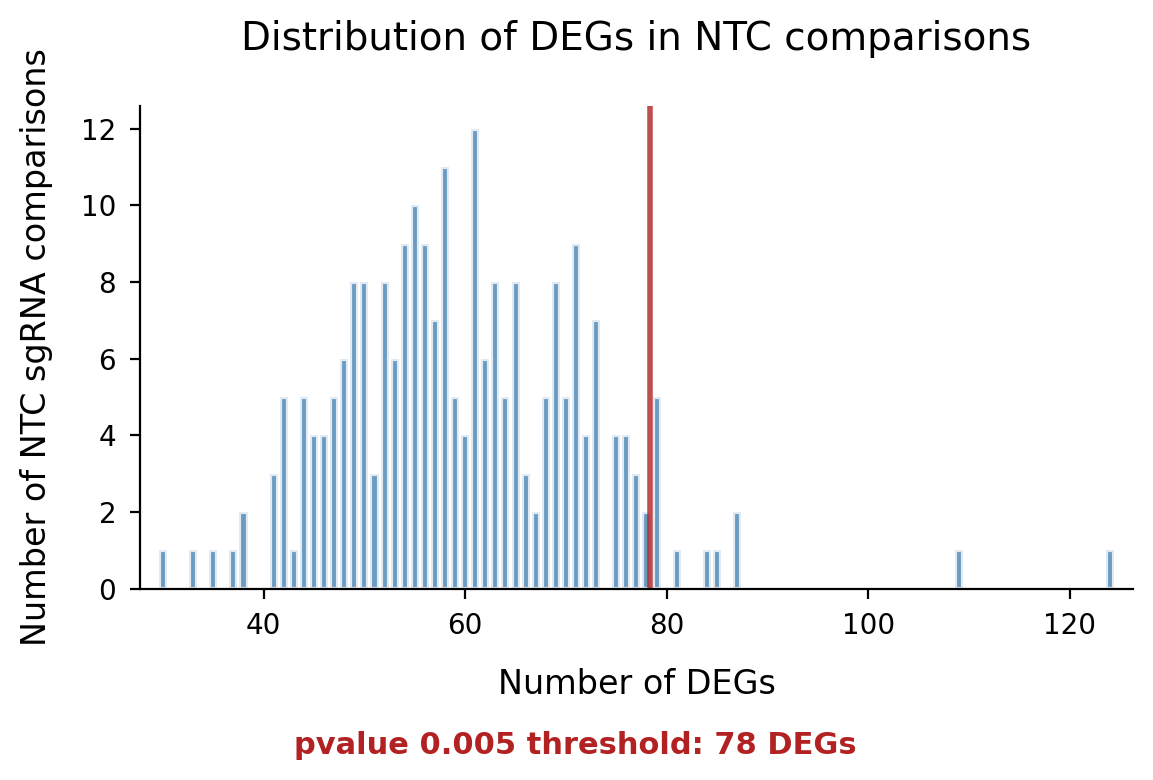

NTC Benchmark Statistics:
  • pvalue 0.005 threshold: 78 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 59.8
  • Median DEGs per comparison: 58.0
  • 95% of comparisons have < 78 DEGs


In [52]:
deg_threshold, ntc_benchmark_n_degs_df = \
    report_ntc_benchmarking_results(ntc_benchmarking_dict, alpha=0.005, threshold_type="pvalue")

In [53]:
ntc_benchmark_n_degs_df[ntc_benchmark_n_degs_df["n_DEGs"] > deg_threshold]

n_DEGs
Non-Targeting_760     124
Non-Targeting_941     109
Non-Targeting_901      87
Non-Targeting_750      87
Non-Targeting_464      85
Non-Targeting_774      84
Non-Targeting_488      81
Non-Targeting_378      79
Non-Targeting_561      79
Non-Targeting_567      79
Non-Targeting_870      79
Non-Targeting_450      79

In [55]:
ntc_de_df = build_DE_df(ntc_benchmarking_dict)
ntc_de_df.head()

Non-Targeting_186_baseMean  Non-Targeting_186_log2FoldChange  \
A1BG                         2.533524                          0.132914   
A1BG-AS1                     0.354187                          0.515641   
A2M                          0.347004                         -1.211685   
A2ML1                        1.215829                          0.145009   
A2ML1-AS1                    3.480524                          0.325252   

           Non-Targeting_186_lfcSE  Non-Targeting_186_stat  \
A1BG                      0.620857                0.214082   
A1BG-AS1                  1.477632                0.348964   
A2M                       2.399155               -0.505047   
A2ML1                     0.862791                0.168069   
A2ML1-AS1                 0.508411                0.639742   

           Non-Targeting_186_pvalue  Non-Targeting_186_padj  \
A1BG                       0.830483                0.999999   
A1BG-AS1                   0.727116                0.999999   
A2M                        0.613526                0.999999   
A2ML1                      0.866529                0.999999   
A2ML1-AS1                  0.522341                0.999999   

           Non-Targeting_567_baseMean  Non-Targeting_567_log2FoldChange  \
A1BG                         2.533524                         -0.107402   
A1BG-AS1                     0.354187                         -0.644077   
A2M                          0.347004                         -0.585389   
A2ML1                        1.215829                         -1.922144   
A2ML1-AS1                    3.480524                          0.156424   

           Non-Targeting_567_lfcSE  Non-Targeting_567_stat  ...  \
A1BG                      0.863789               -0.124338  ...   
A1BG-AS1                  2.417431               -0.266430  ...   
A2M                       2.418707               -0.242025  ...   
A2ML1                     2.394954               -0.802581  ...   
A2ML1-AS1                 0.674170                0.232024  ...   

           Non-Targeting_906_lfcSE  Non-Targeting_906_stat  \
A1BG                      0.566154                0.207117   
A1BG-AS1                  1.061596                0.668863   
A2M                       1.087878                1.043693   
A2ML1                     1.049721               -0.231129   
A2ML1-AS1                 0.731670               -1.488038   

           Non-Targeting_906_pvalue  Non-Targeting_906_padj  \
A1BG                       0.835918                0.999914   
A1BG-AS1                   0.503583                0.999914   
A2M                        0.296627                0.999914   
A2ML1                      0.817215                0.999914   
A2ML1-AS1                  0.136741                0.999914   

           Non-Targeting_890_baseMean  Non-Targeting_890_log2FoldChange  \
A1BG                         2.470631                         -0.090005   
A1BG-AS1                     0.391728                         -1.215037   
A2M                          0.285819                         -0.657551   
A2ML1                        1.122132                         -0.391728   
A2ML1-AS1                    3.409750                         -0.962367   

           Non-Targeting_890_lfcSE  Non-Targeting_890_stat  \
A1BG                      0.668371               -0.134664   
A1BG-AS1                  2.402796               -0.505676   
A2M                       2.422056               -0.271485   
A2ML1                     1.057359               -0.370478   
A2ML1-AS1                 0.734322               -1.310552   

           Non-Targeting_890_pvalue  Non-Targeting_890_padj  
A1BG                       0.892878                0.999787  
A1BG-AS1                   0.613084                0.999787  
A2M                        0.786018                0.999787  
A2ML1                      0.711026                0.999787  
A2ML1-AS1                  0.190009                0.999787  

[5 ro

In [56]:
filepath = "/home/ranwyl/results_tf_project/NTC_benchmark_seed42_1-21-26.pkl"
ntc_de_df.to_pickle(filepath)

In [64]:
filepath = "/home/ranwyl/results_tf_project/NTC_benchmark_seed42_1-21-26.pkl"
ntc_de_df1 = pd.read_pickle(filepath)

In [68]:
n_degs_df_1_005 = build_n_DEGs_df(ntc_de_df1, 0.005, threshold_type="pvalue", target_type="gRNA")
deg_thr_1_005 = np.percentile(n_degs_df_1_005['n_DEGs'].values, 95)
print(f"DEG threshold at pval < 0.005: {round(deg_thr_1_005)} DEGs")

DEG threshold at pval < 0.005: 78 DEGs


In [74]:
ntc_rm_1_005 = set(n_degs_df_1_005[n_degs_df_1_005["n_DEGs"] > deg_thr_1_005].index.tolist())
print(ntc_rm_1_005)

{'Non-Targeting_378', 'Non-Targeting_941', 'Non-Targeting_450', 'Non-Targeting_464', 'Non-Targeting_760', 'Non-Targeting_750', 'Non-Targeting_774', 'Non-Targeting_561', 'Non-Targeting_488', 'Non-Targeting_901', 'Non-Targeting_567', 'Non-Targeting_870'}


In [67]:
n_degs_df_1_001 = build_n_DEGs_df(ntc_de_df1, 0.001, threshold_type="pvalue", target_type="gRNA")
deg_thr_1_001 = np.percentile(n_degs_df_1_001['n_DEGs'].values, 95)
print(f"DEG threshold at pval < 0.001: {round(deg_thr_1_001)} DEGs")

DEG threshold at pval < 0.001: 23 DEGs


In [78]:
ntc_rm_1_001 = set(n_degs_df_1_001[n_degs_df_1_001["n_DEGs"] > deg_thr_1_001].index.tolist())
print(ntc_rm_1_001)

{'Non-Targeting_671', 'Non-Targeting_941', 'Non-Targeting_572', 'Non-Targeting_622', 'Non-Targeting_652', 'Non-Targeting_760', 'Non-Targeting_567', 'Non-Targeting_488', 'Non-Targeting_608', 'Non-Targeting_446'}


In [69]:
n_degs_df_1_001[n_degs_df_1_001["n_DEGs"] > 23]

n_DEGs
Non-Targeting_446      28
Non-Targeting_488      24
Non-Targeting_567      27
Non-Targeting_572      24
Non-Targeting_608      24
Non-Targeting_622      24
Non-Targeting_652      24
Non-Targeting_671      25
Non-Targeting_760      44
Non-Targeting_941      33

4 chunks, random seed 67

In [57]:
ntc_benchmarking_dict = \
    ntc_benchmarking_DE_with_KDs(adata, n_chunks=4, n_cpus_for_DE=4, n_jobs_parallel=20, random_state=67,
                                 suppress_warnings=True)

NTC gRNAs per chunk: [59, 59, 58, 58]
Perturbing gRNAs per chunk: 59

Processing chunk 1/4
Chunk 1 pseudobulk dataset size: 144 NTC samples + 156 perturbed samples = 300 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 2/4
Chunk 2 pseudobulk dataset size: 142 NTC samples + 156 perturbed samples = 298 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 3/4
Chunk 3 pseudobulk dataset size: 137 NTC samples + 156 perturbed samples = 293 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]


Processing chunk 4/4
Chunk 4 pseudobulk dataset size: 145 NTC samples + 156 perturbed samples = 301 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]

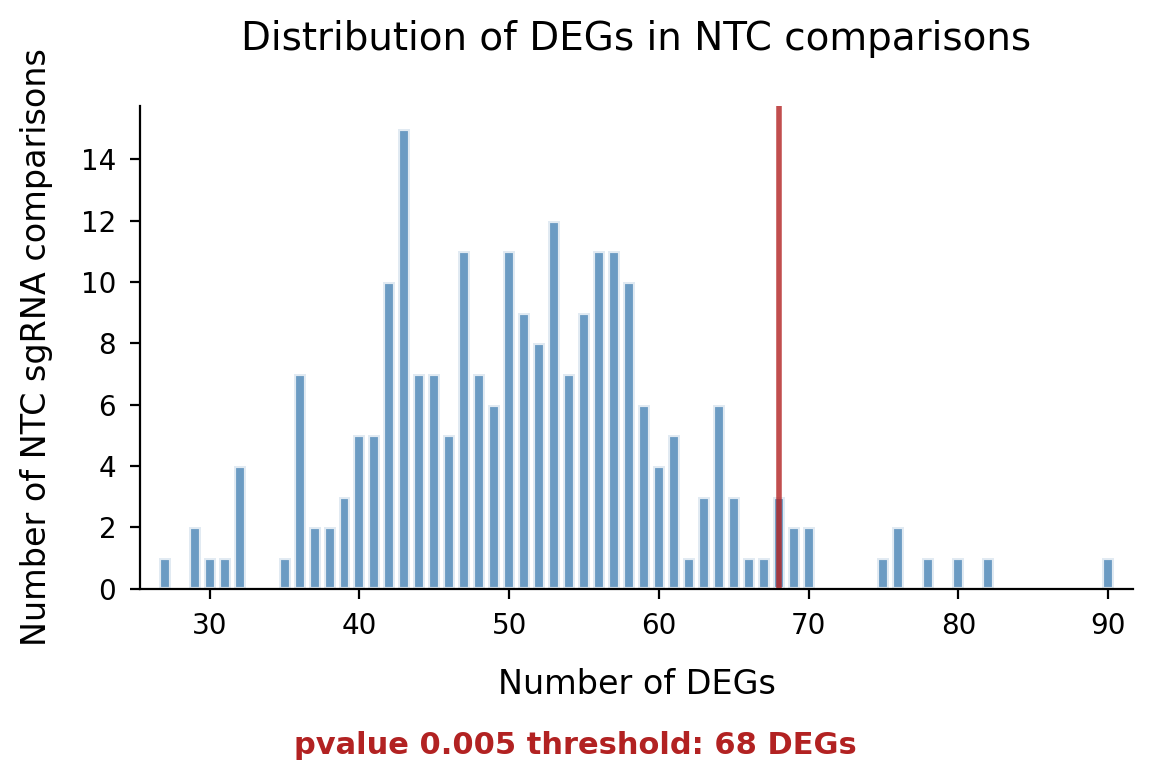

NTC Benchmark Statistics:
  • pvalue 0.005 threshold: 68 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 51.1
  • Median DEGs per comparison: 51.0
  • 95% of comparisons have < 68 DEGs


In [59]:
deg_threshold_2_005, ntc_benchmark_n_degs_df_2_005 = \
    report_ntc_benchmarking_results(ntc_benchmarking_dict, alpha=0.005, threshold_type="pvalue")

In [70]:
ntc_benchmark_n_degs_df_2_005[ntc_benchmark_n_degs_df_2_005["n_DEGs"] > deg_threshold_2_005]

n_DEGs
Non-Targeting_903      90
Non-Targeting_424      82
Non-Targeting_161      80
Non-Targeting_287      78
Non-Targeting_875      76
Non-Targeting_477      76
Non-Targeting_226      75
Non-Targeting_162      70
Non-Targeting_116      70
Non-Targeting_261      69
Non-Targeting_939      69

In [75]:
ntc_rm_2_005 = set(ntc_benchmark_n_degs_df_2_005[
    ntc_benchmark_n_degs_df_2_005["n_DEGs"] > deg_threshold_2_005].index.tolist())
print(ntc_rm_2_005)

{'Non-Targeting_161', 'Non-Targeting_261', 'Non-Targeting_162', 'Non-Targeting_226', 'Non-Targeting_424', 'Non-Targeting_116', 'Non-Targeting_875', 'Non-Targeting_477', 'Non-Targeting_939', 'Non-Targeting_287', 'Non-Targeting_903'}


In [77]:
print((ntc_rm_1_005 & ntc_rm_2_005))

set()


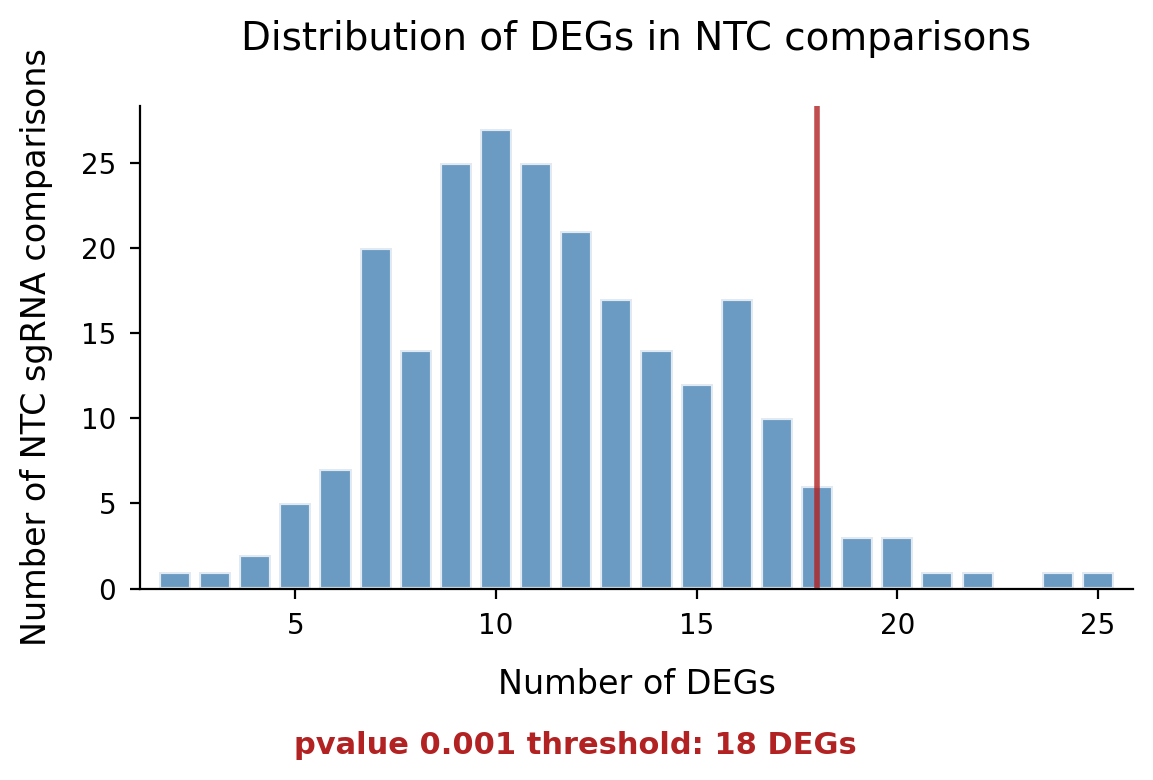

NTC Benchmark Statistics:
  • pvalue 0.001 threshold: 18 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 11.6
  • Median DEGs per comparison: 11.0
  • 95% of comparisons have < 18 DEGs


In [61]:
deg_threshold_2_001, ntc_benchmark_n_degs_df_2_001 = \
    report_ntc_benchmarking_results(ntc_benchmarking_dict, alpha=0.001, threshold_type="pvalue")

In [79]:
ntc_rm_2_001 = set(ntc_benchmark_n_degs_df_2_001[
    ntc_benchmark_n_degs_df_2_001["n_DEGs"] > deg_threshold_2_001].index.tolist())
print(ntc_rm_2_001)

{'Non-Targeting_161', 'Non-Targeting_261', 'Non-Targeting_7', 'Non-Targeting_162', 'Non-Targeting_226', 'Non-Targeting_596', 'Non-Targeting_903', 'Non-Targeting_74', 'Non-Targeting_498', 'Non-Targeting_890'}


In [80]:
print((ntc_rm_1_001 & ntc_rm_2_001))

set()


In [63]:
ntc_de_df2 = build_DE_df(ntc_benchmarking_dict)
filepath = "/home/ranwyl/results_tf_project/NTC_benchmark_seed67_1-21-26.pkl"
ntc_de_df2.to_pickle(filepath)

See how many perturbing gRNAs would be filtered out using this DEG threshold

In [81]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_full_1-16-26.pkl"
de_results_df_grna_full = pd.read_pickle(filepath_pkl)
de_results_df_grna_full.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.816862                0.001941       0.733954   
A1BG-AS1           0.434496               -1.021191       2.387665   
A2M                0.376518                1.672385       1.170622   
A2ML1              1.308873                0.540466       1.037620   
A2ML1-AS1          3.819006               -0.343784       0.727800   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG           0.002644        0.997890      0.999674          2.816862   
A1BG-AS1      -0.427694        0.668874      0.997173          0.434496   
A2M            1.428629        0.153111      0.997173          0.376518   
A2ML1          0.520871        0.602456      0.997173          1.308873   
A2ML1-AS1     -0.472360        0.636670      0.997173          3.819006   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.498121       0.522974      0.952477  ...   
A1BG-AS1                 0.220662       1.454824      0.151676  ...   
A2M                      1.437109       1.161455      1.237335  ...   
A2ML1                   -0.360045       1.033252     -0.348458  ...   
A2ML1-AS1                1.049073       0.380685      2.755751  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.735003     -2.066776        0.038755      0.999992   
A1BG-AS1        1.058743      0.451346        0.651740      0.999992   
A2M             1.422213     -0.184238        0.853827      0.999992   
A2ML1           0.609023     -0.277150        0.781665      0.999992   
A2ML1-AS1       0.349133      1.013193        0.310968      0.999992   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.783284               -0.634082       0.573220   
A1BG-AS1           0.410565                1.738439       1.284029   
A2M                0.382827                1.209777       1.410135   
A2ML1              1.327229               -1.581952       0.707328   
A2ML1-AS1          3.761216                0.239069       0.440676   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.106175        0.268651      0.999503  
A1BG-AS1       1.353894        0.175770      0.999503  
A2M            0.857916        0.390939      0.999503  
A2ML1         -2.236519        0.025318      0.999503  
A2ML1-AS1      0.542504        0.587472      0.999503  

[5 rows x 5916 columns]

In [84]:
de_full_degs_df = build_n_DEGs_df(de_results_df_grna_full, 0.005, threshold_type="pvalue", target_type="gRNA")
de_full_degs_df.head()

n_DEGs
ADNP2_1      67
ADNP2_2      93
ADNP2_3      98
AHR_2       122
ALX4_2      122

In [ ]:
avg_deg_thr_005 = round((78+68)/2)
print(f"{len(de_full_degs_df[de_full_degs_df['n_DEGs'] >= avg_deg_thr_005])}/"
      f"{len(de_full_degs_df)} perturbing gRNAs have >= {avg_deg_thr_005} DEGs")

889/986 perturbing gRNAs have >= 73 DEGs


In [88]:
avg_deg_thr_001 = round((23+18)/2)
print(f"{len(de_full_degs_df[de_full_degs_df['n_DEGs'] >= avg_deg_thr_001])}/"
      f"{len(de_full_degs_df)} perturbing gRNAs have >= {avg_deg_thr_001} DEGs")

986/986 perturbing gRNAs have >= 20 DEGs


In [107]:
print(f"{len(de_full_degs_df[de_full_degs_df['n_DEGs'] >= 96])}/"
      f"{len(de_full_degs_df)} perturbing gRNAs have >= 96 DEGs")

647/986 perturbing gRNAs have >= 96 DEGs


In [108]:
647/986

0.6561866125760649

See if choice of NTC gRNAs per chunk or choice of perturbing gRNAs per chunk makes a bigger difference

In [96]:
def test_ntc_benchmarking_DE_with_KDs(adata: ad.AnnData,
                                    n_chunks: int = 4,
                                    layer: str = "counts",
                                    min_cells_for_3_reps: int = 60,
                                    ntc_random_state: int = 42,
                                    pert_random_state: int = 42,
                                    pseudobulk_random_state: int = 42,
                                    ntc_target_delimiter: str = "NTC",
                                    ntc_gRNA_delimiter: str = "Non-Targeting",
                                    n_jobs_parallel: int = 20, n_cpus_for_DE: int = 4,
                                    alpha: float = 0.05,
                                    suppress_warnings: bool = False,
                                    debug: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    quiet = False if debug is True else True
    # Divide NTC gRNAs into chunks
    ntc_gRNAs = adata[adata.obs.perturbed == "False"].obs.gRNA.unique().tolist()
    n_targets = len(ntc_gRNAs)
    base_size = n_targets // n_chunks
    remainder = n_targets % n_chunks
    ntc_chunk_sizes = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
    rng_ntc = np.random.default_rng(ntc_random_state)
    target_indices = np.arange(n_targets)
    rng_ntc.shuffle(target_indices)
    ntc_chunk_splits = np.cumsum(np.array(ntc_chunk_sizes))[:-1]
    ntc_chunk_indices = np.split(target_indices, ntc_chunk_splits)
    all_chunk_ntc_gRNAs = list()
    for i in range(n_chunks):
        all_chunk_ntc_gRNAs.append([ntc_gRNAs[j] for j in ntc_chunk_indices[i]])
    print(f"NTC gRNAs per chunk: {ntc_chunk_sizes}")

    # Randomly choose perturbing gRNAs
    max_ntc_chunk_size = max(ntc_chunk_sizes)
    pert_gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.unique().tolist()
    rng_pert = np.random.default_rng(pert_random_state)
    subset_pert_gRNAs = rng_pert.choice(pert_gRNAs, max_ntc_chunk_size)
    print(f"Perturbing gRNAs per chunk: {max_ntc_chunk_size}")

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA_hyphenated):
        if debug is True:
            print(f"Processing NTC gRNA {target_ntc_gRNA_hyphenated}")
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA_hyphenated), "condition"] = "perturbed"
        # Run DE analysis
        with handle_warnings(suppress_warnings):
            DE_inference = DefaultInference(n_cpus=n_cpus_for_DE)
            dds = DeseqDataSet(counts=counts_df, 
                                metadata=metadata_df,
                                design_factors="condition",
                                continuous_factors=["n-cells-in-rep"],
                                ref_level=["condition", "NTC"],
                                inference=DE_inference, 
                                quiet=quiet)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=DE_inference, 
                            quiet=quiet)
            ds.summary()
        return ds.results_df
    
    # Run DE on each chunk
    all_de_results = list()
    # Create chunks
    n_chunks_to_process = n_chunks if debug is False else 1
    for i in range(n_chunks_to_process):
        chunk_ntc_gRNAs = all_chunk_ntc_gRNAs[i]
        chunk_adata = adata[adata.obs.gRNA.isin(chunk_ntc_gRNAs) | 
                            (adata.obs.gRNA.isin(subset_pert_gRNAs))].copy()
        print(f"\nProcessing chunk {i+1}/{n_chunks}")
        # Create chunk pseudobulk dataset
        counts_df, metadata_df = \
            create_pseudobulk_dataset(chunk_adata, target_type="gRNA", 
                                    ntc_benchmarking=True, layer=layer,
                                    min_cells_for_3_reps=min_cells_for_3_reps,
                                    random_state=pseudobulk_random_state,
                                    ntc_target_delimiter=ntc_target_delimiter,
                                    ntc_gRNA_delimiter=ntc_gRNA_delimiter)
        chunk_n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
        chunk_n_pert_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
        print(f"Chunk {i+1} pseudobulk dataset size: {chunk_n_ntc_samples} NTC samples + "
              f"{chunk_n_pert_samples} perturbed samples = {len(counts_df)} total samples")
        # Run DE analysis
        chunk_ntc_gRNAs_hyphenated = [g.replace("_", "-") for g in chunk_ntc_gRNAs]
        with tqdm_joblib(desc="Running DE analysis", total=len(chunk_ntc_gRNAs)):
            de_results = Parallel(n_jobs=n_jobs_parallel)(
                delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, ntc_gRNA)
                        for ntc_gRNA in chunk_ntc_gRNAs_hyphenated)
        all_de_results += de_results

    de_results_dict = {ntc_gRNAs[i]: all_de_results[i] for i in range(len(ntc_gRNAs))}
    return de_results_dict

In [98]:
def get_ntc_benchmarking_results(ntc_de_df, alpha, threshold_type):
    n_degs_df = build_n_DEGs_df(ntc_de_df, alpha, threshold_type=threshold_type, target_type="gRNA")
    deg_thr = round(np.percentile(n_degs_df['n_DEGs'].values, 95))
    print(f"DEG threshold at {threshold_type} < {alpha}: {deg_thr} DEGs")
    ntc_rm = set(n_degs_df[n_degs_df["n_DEGs"] > deg_thr].index.tolist())
    print(f"{len(ntc_rm)} NTC gRNA to remove: {ntc_rm}")
    return deg_thr, ntc_rm

In [97]:
ntc_benchmarking_dict_42_42 = \
    test_ntc_benchmarking_DE_with_KDs(adata, n_chunks=4, n_cpus_for_DE=4, n_jobs_parallel=20, 
                                    ntc_random_state=42, pert_random_state=42,
                                    pseudobulk_random_state=42, suppress_warnings=True)

NTC gRNAs per chunk: [59, 59, 58, 58]
Perturbing gRNAs per chunk: 59

Processing chunk 1/4
Chunk 1 pseudobulk dataset size: 140 NTC samples + 160 perturbed samples = 300 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 2/4
Chunk 2 pseudobulk dataset size: 142 NTC samples + 160 perturbed samples = 302 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 3/4
Chunk 3 pseudobulk dataset size: 142 NTC samples + 160 perturbed samples = 302 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]


Processing chunk 4/4
Chunk 4 pseudobulk dataset size: 144 NTC samples + 160 perturbed samples = 304 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]

In [99]:
ntc_de_df_42_42 = build_DE_df(ntc_benchmarking_dict_42_42)
deg_thr_42_42, ntc_rm_42_42 = get_ntc_benchmarking_results(ntc_de_df_42_42, 0.005, "pvalue")

DEG threshold at pvalue < 0.005: 79 DEGs
10 NTC gRNA to remove: {'Non-Targeting_617', 'Non-Targeting_863', 'Non-Targeting_695', 'Non-Targeting_901', 'Non-Targeting_941', 'Non-Targeting_760', 'Non-Targeting_750', 'Non-Targeting_929', 'Non-Targeting_74', 'Non-Targeting_567'}


In [100]:
ntc_benchmarking_dict_42_67 = \
    test_ntc_benchmarking_DE_with_KDs(adata, n_chunks=4, n_cpus_for_DE=4, n_jobs_parallel=20, 
                                    ntc_random_state=42, pert_random_state=67,
                                    pseudobulk_random_state=42, suppress_warnings=True)

NTC gRNAs per chunk: [59, 59, 58, 58]
Perturbing gRNAs per chunk: 59

Processing chunk 1/4
Chunk 1 pseudobulk dataset size: 140 NTC samples + 168 perturbed samples = 308 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 2/4
Chunk 2 pseudobulk dataset size: 142 NTC samples + 168 perturbed samples = 310 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 3/4
Chunk 3 pseudobulk dataset size: 142 NTC samples + 168 perturbed samples = 310 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]


Processing chunk 4/4
Chunk 4 pseudobulk dataset size: 144 NTC samples + 168 perturbed samples = 312 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]

In [101]:
ntc_de_df_42_67 = build_DE_df(ntc_benchmarking_dict_42_67)
deg_thr_42_67, ntc_rm_42_67 = get_ntc_benchmarking_results(ntc_de_df_42_67, 0.005, "pvalue")

DEG threshold at pvalue < 0.005: 76 DEGs
10 NTC gRNA to remove: {'Non-Targeting_543', 'Non-Targeting_695', 'Non-Targeting_901', 'Non-Targeting_941', 'Non-Targeting_760', 'Non-Targeting_596', 'Non-Targeting_750', 'Non-Targeting_488', 'Non-Targeting_74', 'Non-Targeting_567'}


In [102]:
print(len(ntc_rm_42_42 & ntc_rm_42_67))

7


In [103]:
ntc_benchmarking_dict_67_42 = \
    test_ntc_benchmarking_DE_with_KDs(adata, n_chunks=4, n_cpus_for_DE=4, n_jobs_parallel=20, 
                                    ntc_random_state=67, pert_random_state=42,
                                    pseudobulk_random_state=42, suppress_warnings=True)

NTC gRNAs per chunk: [59, 59, 58, 58]
Perturbing gRNAs per chunk: 59

Processing chunk 1/4
Chunk 1 pseudobulk dataset size: 144 NTC samples + 160 perturbed samples = 304 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 2/4
Chunk 2 pseudobulk dataset size: 142 NTC samples + 160 perturbed samples = 302 total samples


Running DE analysis:   0%|          | 0/59 [00:00<?, ?it/s]


Processing chunk 3/4
Chunk 3 pseudobulk dataset size: 137 NTC samples + 160 perturbed samples = 297 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]


Processing chunk 4/4
Chunk 4 pseudobulk dataset size: 145 NTC samples + 160 perturbed samples = 305 total samples


Running DE analysis:   0%|          | 0/58 [00:00<?, ?it/s]

In [104]:
ntc_de_df_67_42 = build_DE_df(ntc_benchmarking_dict_67_42)
deg_thr_67_42, ntc_rm_67_42 = get_ntc_benchmarking_results(ntc_de_df_67_42, 0.005, "pvalue")

DEG threshold at pvalue < 0.005: 79 DEGs
12 NTC gRNA to remove: {'Non-Targeting_161', 'Non-Targeting_261', 'Non-Targeting_160', 'Non-Targeting_517', 'Non-Targeting_875', 'Non-Targeting_939', 'Non-Targeting_133', 'Non-Targeting_287', 'Non-Targeting_903', 'Non-Targeting_935', 'Non-Targeting_446', 'Non-Targeting_890'}


In [105]:
print(len(ntc_rm_42_42 & ntc_rm_67_42))

0


In [106]:
filepath_42_42 = "/home/ranwyl/results_tf_project/NTC_benchmark_seeds4242_1-21-26.pkl"
ntc_de_df_42_42.to_pickle(filepath_42_42)
filepath_42_67 = "/home/ranwyl/results_tf_project/NTC_benchmark_seeds4267_1-21-26.pkl"
ntc_de_df_42_67.to_pickle(filepath_42_67)
filepath_67_42 = "/home/ranwyl/results_tf_project/NTC_benchmark_seeds6742_1-21-26.pkl"
ntc_de_df_67_42.to_pickle(filepath_67_42)

NTC benchmarking: 2 chunks

2 chunks, seed=42

In [87]:
ntc_benchmarking_dict_2chunks_seed42 = \
    ntc_benchmarking_DE_with_KDs(adata, n_chunks=2, n_cpus_for_DE=4, n_jobs_parallel=20, random_state=42,
                                 suppress_warnings=True)

NTC gRNAs per chunk: [117, 117]
Perturbing gRNAs per chunk: 117

Processing chunk 1/2
Chunk 1 pseudobulk dataset size: 279 NTC samples + 311 perturbed samples = 590 total samples


Running DE analysis:   0%|          | 0/117 [00:00<?, ?it/s]

KeyboardInterrupt: 

~17 min per 20 samples, ~600 samples per chunk = ~17 hrs for full dataset

# Winter 2026 Week 3-4

In [ ]:
def gRNA_per_KD_gene_target(adata):
    kd_gene_targets = adata.obs.gene_target.unique().tolist()
    kd_gene_targets.remove("NTC")
    gRNAs_per_kd_dict = dict()
    for kd in kd_gene_targets:
        gRNAs_per_kd_dict[kd] = len(adata[adata.obs.gene_target == kd].obs.gRNA.unique().tolist())
    gRNAs_per_kd_df = pd.DataFrame.from_dict(gRNAs_per_kd_dict, orient="index", columns=["n_gRNAs"])
    kds_with_gRNAs_dict = {i: len(gRNAs_per_kd_df[gRNAs_per_kd_df["n_gRNAs"] == i]) for i in gRNAs_per_kd_df["n_gRNAs"].values}
    kds_with_gRNAs_df = pd.DataFrame.from_dict(kds_with_gRNAs_dict, orient="index", columns=["n_gRNAs"])
    return kds_with_gRNAs_df

In [ ]:
grnas_per_kd = gRNA_per_KD_gene_target(adata)
grnas_per_kd

n_gRNAs
1      503
2      186
3       37

## Create pseudobulk dataset for DE analysis with edgeR

In [ ]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Counts DF: rows = genes, cols = samples (gRNAs)

In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse

def create_pseudobulk_dataset_edgeR(adata: ad.AnnData, layer="counts", 
                                    ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata for edgeR (one sample per gRNA).
    counts_df has rows=genes and cols=samples, sample_df has rows=samples (gRNAs)
    and cols=[gRNA, gene_gRNA, n_cells]
    """
    # Get gRNAs
    gRNAs = adata.obs.gRNA.unique().tolist()

    # Data structures for counts_df and samples_df
    counts_arrays, counts_samples = list(), list()
    sample_conditions, sample_gene_targets, sample_n_cells = list(), list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudobulk samples
    for gRNA in gRNAs:
        # Counts
        gRNA_indices = np.where(adata.obs.gRNA == gRNA)[0]
        gRNA_data = data_matrix[gRNA_indices]
        gRNA_counts = np.sum(gRNA_data, axis=0).astype(np.int64) # per-gene sums
        counts_arrays.append(gRNA_counts)
        counts_samples.append(gRNA)
        # Metadata
        gRNA_condition = "NTC" if ntc_gRNA_delimiter in gRNA else "KD"
        sample_conditions.append(gRNA_condition)
        gRNA_gene_target = "NTC" if ntc_gRNA_delimiter in gRNA else gRNA.split("_")[0]
        sample_gene_targets.append(gRNA_gene_target)
        sample_n_cells.append(gRNA_data.shape[0])

    # Create counts DF
    counts_arr = np.stack(tuple(arr for arr in counts_arrays), axis=1) # samples=cols
    counts_df = pd.DataFrame(
        counts_arr,
        index=adata.var_names,
        columns=counts_samples)

    # Create sample DF
    sample_dict = {"sample": counts_samples,
                    "condition": sample_conditions,
                    "gene_target": sample_gene_targets,
                    "n_cells": sample_n_cells}
    sample_df = pd.DataFrame.from_dict(sample_dict)
    sample_df = sample_df.set_index("sample").rename_axis(None)

    return counts_df, sample_df

In [ ]:
edger_grna_counts_df, edger_grna_sample_df = \
    create_pseudobulk_dataset_edgeR(adata)

In [ ]:
edger_grna_counts_df.head()

Non-Targeting_186  ESR2_2  ZNF14_1  JRKL_2  TWIST1_2  \
ENSG00000241860                  1       6        3       4         2   
ENSG00000290385                  0       6        3       1         0   
ENSG00000291215                  2       6        4       4         3   
LINC01409                        1      15        2       5         2   
LINC00115                        0       3        2       0         2   

                 Non-Targeting_567  Non-Targeting_206  GATA6_3  OSR2_3  \
ENSG00000241860                  1                  0        8       5   
ENSG00000290385                  2                  1        7       3   
ENSG00000291215                  2                  3        3       4   
LINC01409                        4                  2        2       5   
LINC00115                        1                  1        2       1   

                 DUXA_3  ...  Non-Targeting_774  NANOGP8_1  Non-Targeting_478  \
ENSG00000241860       2  ...                  0          0                  0   
ENSG00000290385       1  ...                  1          0                  2   
ENSG00000291215       4  ...                  1          1                  0   
LINC01409             7  ...                  1          1                  2   
LINC00115             3  ...                  0          0                  0   

                 Non-Targeting_622  Non-Targeting_361  Non-Targeting_81  \
ENSG00000241860                  0                  0                 0   
ENSG00000290385                  0                  0                 2   
ENSG00000291215                  3                  0                 1   
LINC01409                        1                  2                 0   
LINC00115                        1                  0                 1   

                 Non-Targeting_250  Non-Targeting_735  Non-Targeting_906  \
ENSG00000241860                  0                  5                  1   
ENSG00000290385                  1                  0                  2   
ENSG00000291215                  2                  1                  3   
LINC01409                        3                  0                  2   
LINC00115                        1                  0                  1   

                 Non-Targeting_890  
ENSG00000241860                  0  
ENSG00000290385                  2  
ENSG00000291215                  0  
LINC01409                        2  
LINC00115                        1  

[5 rows x 1220 columns]

In [ ]:
print(edger_grna_counts_df.shape)
print(len(adata.var))
print(adata.obs.gRNA.nunique())

(16115, 1220)
16115
1220


In [ ]:
edger_grna_sample_df.head()

condition gene_target  n_cells
Non-Targeting_186       NTC         NTC       57
ESR2_2                   KD        ESR2      210
ZNF14_1                  KD       ZNF14       83
JRKL_2                   KD        JRKL      106
TWIST1_2                 KD      TWIST1       78

In [ ]:
counts_filepath = "/home/ranwyl/results_tf_project/edgeR_counts_df.csv"
sample_filepath = "/home/ranwyl/results_tf_project/edgeR_sample_df.csv"
edger_grna_counts_df.to_csv(counts_filepath)
edger_grna_sample_df.to_csv(sample_filepath)

## Matched/1-to-1 DE

In [2]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [64]:
adata[adata.obs.perturbed == "False"]

View of AnnData object with n_obs × n_vars = 13674 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [3]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def generate_matched_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                            target_value: str, 
                                            ntc_cell_indices: pd.Index, 
                                            rng: np.random.Generator, 
                                            target_column: str = "perturbation", 
                                            min_cells_per_rep: int = 12,
                                            layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def matched_differential_expression(adata: ad.AnnData,
                                    layer: str = "counts",
                                    min_cells_per_rep: int = 12,
                                    random_state: int = 42,
                                    n_cpus_for_DE: int = 3,
                                    n_jobs_parallel: int = 25,
                                    alpha: float = 0.05,
                                    DE_fit_type: str = "parametric",
                                    target_column: str = "perturbation",
                                    ntc_target_delimiter: str = "NTC",
                                    suppress_warnings: bool = False,
                                    debug: bool = False):
    """
    Perform pseudobulk DE analysis with pseudoreplicates on each 
    gRNA or gene target against a matched number of NTC cells.
    Return dict {target: DE results DF for that target}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_target_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_target_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_perturbation(target: str, rng: np.random.Generator):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            adata, target, ntc_cell_indices, rng=rng, 
            target_column=target_column, layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        quiet = False if debug is True else True
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=quiet
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=quiet)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        return de_results

    # Run DE analysis on all targets in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_perturbation)(pert, de_rng) for pert in perturbations)
    results_dict = dict(zip(perturbations, de_results))
    return results_dict

In [4]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [5]:
def test_pvals(DE_results_df, pval_list, target_type="gRNA", pval_delimiter="pvalue", ntc_deg_threshold=3):
    """
    Given a DF of DGE results and a list of p-values, compute the
    number of genes with pval < each pval in the list for each gRNA
    or gene target. Return the mean and median number of DE genes across
    all gRNAs/gene targets.
    """
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    DEGs_df_dict = {f"pval < {pval}":[] for pval in pval_list}
    for pval in pval_list:
        DEGs_arr = np.zeros(len(targets))
        for i, target in enumerate(targets):
            target_pval_col = f"{target}_{pval_delimiter}"
            n_DEGs = len(DE_results_df.loc[DE_results_df[target_pval_col] < pval])
            DEGs_arr[i] = n_DEGs
        DEGs_df_dict[f"pval < {pval}"].append(int(np.mean(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(np.median(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(len(DEGs_arr[DEGs_arr >= ntc_deg_threshold])))
    DEGs_df = pd.DataFrame.from_dict(DEGs_df_dict, orient="index", 
                                     columns=[f"mean DEGs per KD {target_type}", 
                                              f"median DEGs per KD {target_type}",
                                              f"KD {target_type}s with ≥{ntc_deg_threshold} DEGs"])
    return DEGs_df

In [6]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_DEGs_per_KD_histogram(n_DEGs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=100, xmax=None, ymax=None):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_DEGs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    sns.histplot(n_DEGs_df[n_DEGs_df[n_degs_str] >= min_n_degs][n_degs_str].values, 
                 binwidth=bin_width, binrange=(0,xmax))
    plt.xlim(0, xmax)
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

In [8]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [12]:
full_dataset_de_results_dict = \
    matched_differential_expression(adata, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=30)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

In [13]:
full_dataset_de_results_df = build_DE_df(full_dataset_de_results_dict)
full_dataset_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 5916 columns]

In [68]:
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
full_pvals_degs_df = test_pvals(full_dataset_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=1)
full_pvals_degs_df

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥1 DEGs
pval < 0.1                   165                   162                 986
pval < 0.075                  87                    84                 979
pval < 0.05                   35                    33                 976
pval < 0.01                    1                     1                 549
pval < 0.005                   0                     0                 267
pval < 0.001                   0                     0                 119

In [51]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_full_matched_1-23-26.pkl"
full_dataset_de_results_df.to_pickle(filepath_pkl)

In [71]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_full_matched_1-23-26.pkl"
full_dataset_de_results_df = pd.read_pickle(filepath_pkl)
full_dataset_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 5916 columns]

In [73]:
full_dataset_n_degs_df = build_n_DEGs_df(full_dataset_de_results_df, alpha=0.02, threshold_type="pvalue",
                                         target_type="gRNA")
full_dataset_n_degs_df.head()

n_DEGs
ADNP2_1       6
ADNP2_2       8
ADNP2_3      15
AHR_2         2
ALX4_2        3

In [74]:
full_dataset_n_degs_df.sort_values(by="n_DEGs", ascending=False).head(15)

n_DEGs
POU5F1B_1     208
POU5F1_3      154
PHF20_1       140
POU3F2_2       85
ZNF521_1       81
ZNF396_2       67
POU5F1_1       49
POU5F1_2       49
NANOG_2        47
DNMT1_2        36
DNMT1_3        31
DNMT1_1        29
PURG_3         28
SETDB1_1       25
SALL4_1        20

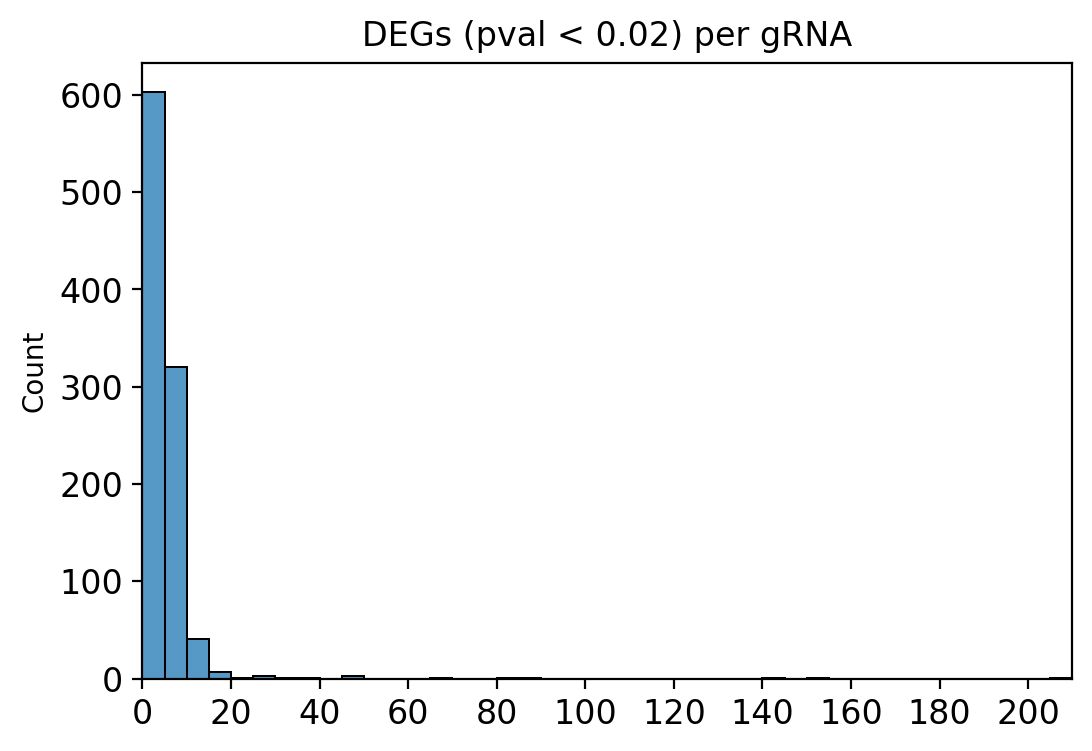

In [128]:
_ = plot_DEGs_per_KD_histogram(full_dataset_n_degs_df, title="DEGs (pval < 0.02) per gRNA", 
                               bin_width=5, xtick_width=20, fig_size=(6,4))

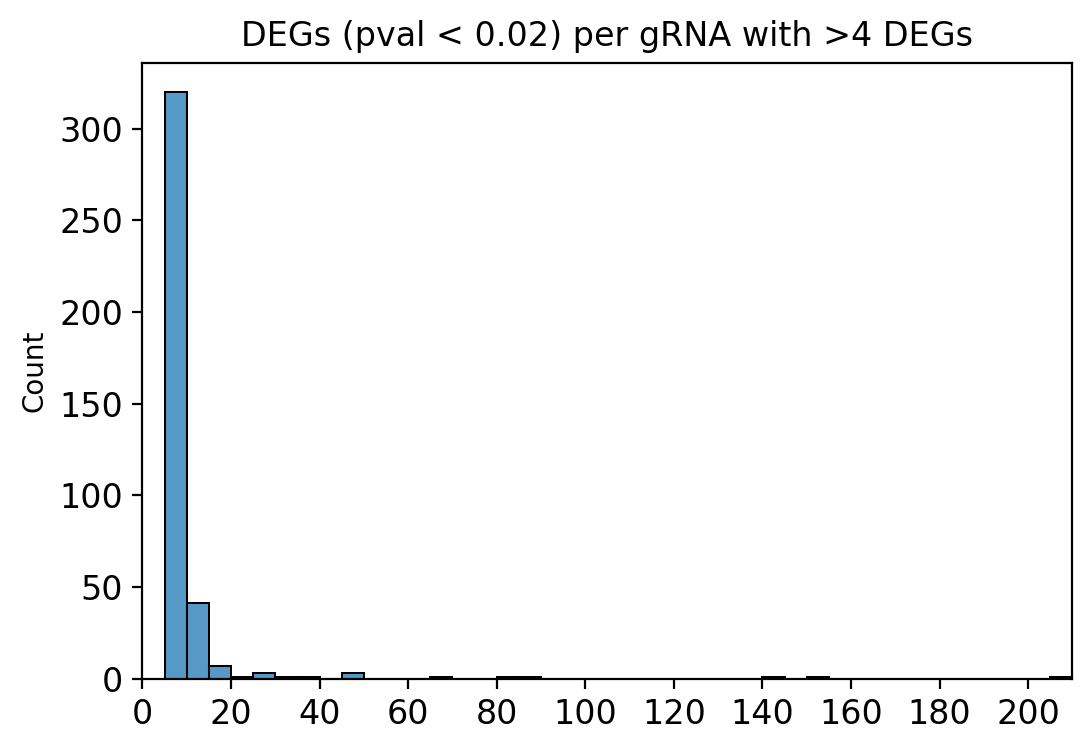

In [129]:
_ = plot_DEGs_per_KD_histogram(full_dataset_n_degs_df[full_dataset_n_degs_df["n_DEGs"] > 4], 
                                title="DEGs (pval < 0.02) per gRNA with >4 DEGs", 
                               bin_width=5, xtick_width=20, fig_size=(6,4))

In [130]:
print(f"Mean DEGs: {round(np.mean(full_dataset_n_degs_df['n_DEGs']))}")
print(f"Median DEGs: {np.median(full_dataset_n_degs_df['n_DEGs'])}")
print(f"{len(full_dataset_n_degs_df[full_dataset_n_degs_df['n_DEGs'] > 4])} gRNAs have >4 DEGs")

Mean DEGs: 5
Median DEGs: 4.0
383 gRNAs have >4 DEGs


NTC benchmarking

In [33]:
def ntc_benchmarking_matched_DE(adata: ad.AnnData,
                                layer: str = "counts",
                                min_cells_per_rep: int = 12,
                                random_state: int = 42,
                                n_cpus_for_DE: int = 3,
                                n_jobs_parallel: int = 25, 
                                alpha: float = 0.05,
                                DE_fit_type: str = "parametric",
                                ntc_target_delimiter: str = "NTC",
                                gRNA_column: str = "gRNA",
                                suppress_warnings: bool = False,
                                debug: bool = False):
    """
    Perform DE analysis on each NTC gRNA against a matched
    number of other NTC cells. 
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    ntc_adata = adata[adata.obs.gene_target == ntc_target_delimiter].copy()
    # Get unique NTC sgRNAs
    ntc_gRNAs = list(ntc_adata.obs[gRNA_column].unique())
    if debug == True:
        print("Running in debug mode with 5 NTC sgRNA")
        ntc_gRNAs = ntc_gRNAs[:5]
    # Create RNG object to handle case where one is not provided
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_ntc_gRNA(target_ntc_gRNA: str,
                         rng: np.random.Generator):
        # Check if there are enough target cells
        target_cells = ntc_adata[ntc_adata.obs[gRNA_column] == target_ntc_gRNA].obs.index
        if len(target_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few cells ({len(target_cells)})")
            return
        
        # Get other NTC cells (excluding the target gRNA)
        other_ntc_cells = ntc_adata[ntc_adata.obs[gRNA_column] != target_ntc_gRNA].obs.index
        if len(other_ntc_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few other NTC cells ({len(other_ntc_cells)})")
            return
        
        # Temporarily create "perturbation" column to use with generate_pseudoreplicates_for_DE
        # This labels target gRNA cells as the "perturbation" and other NTC cells as "NTC"
        ntc_adata_temp = ntc_adata.copy()
        ntc_adata_temp.obs["temp_pert"] = "NTC"
        ntc_adata_temp.obs.loc[ntc_adata_temp.obs[gRNA_column] == target_ntc_gRNA, 'temp_pert'] = target_ntc_gRNA
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            ntc_adata_temp, target_ntc_gRNA, other_ntc_cells, rng, 
            target_column="temp_pert", layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=True
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target_ntc_gRNA.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=True)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res, ntc_adata_temp
        gc.collect()

        return de_results

    # Run DE analysis on all NTC sgRNA in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(ntc_gRNAs)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_ntc_gRNA)(ntc_gRNA, de_rng) for ntc_gRNA in ntc_gRNAs)
    results_dict = dict(zip(ntc_gRNAs, de_results))
    return results_dict

In [34]:
def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05,
                                    threshold_type: str = "padj", percentile: int = 95):
    """
    Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
    fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
    a summary of results.
    """
    if (threshold_type != "padj") & (threshold_type != "pvalue"):
        raise ValueError("threshold_type must be 'padj' or 'pvalue'")
    # Counts DEGs per gRNA
    deg_counts = {}
    for ntc_gRNA, result_df in results_dict.items():
        if result_df is None:
            continue
        deg_count = sum((result_df[threshold_type] < alpha) & pd.notna(result_df[threshold_type]))
        deg_counts[ntc_gRNA] = deg_count

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate percentile threshold
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, percentile)
    else:
        print("No results to calculate percentile.")
        return
    
    # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
    # Set style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    fig.patch.set_facecolor('white')
    # Prepare bar plot data: discrete DEG counts
    deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
    # Create bar plot
    ax.bar(
        deg_counts.index,
        deg_counts.values,
        alpha=0.8,
        color='#4682B4',   # Steel blue
        edgecolor='white',
        linewidth=1.5
    )
    # Add threshold line with improved styling
    ax.axvline(
        deg_threshold,
        color='#B22222',  # Firebrick
        linestyle='-',
        linewidth=2,
        alpha=0.8
    )
    # Labels and title with improved styling
    ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
    ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
    # Turn off grid
    ax.grid(False)
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
    # Add some padding to the axes
    ax.margins(x=0.02)
    # Add custom legend-like text at bottom
    threshold_text = f"{threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs"
    fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • {threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • {percentile}% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

In [11]:
ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata, n_cpus_for_DE=4, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

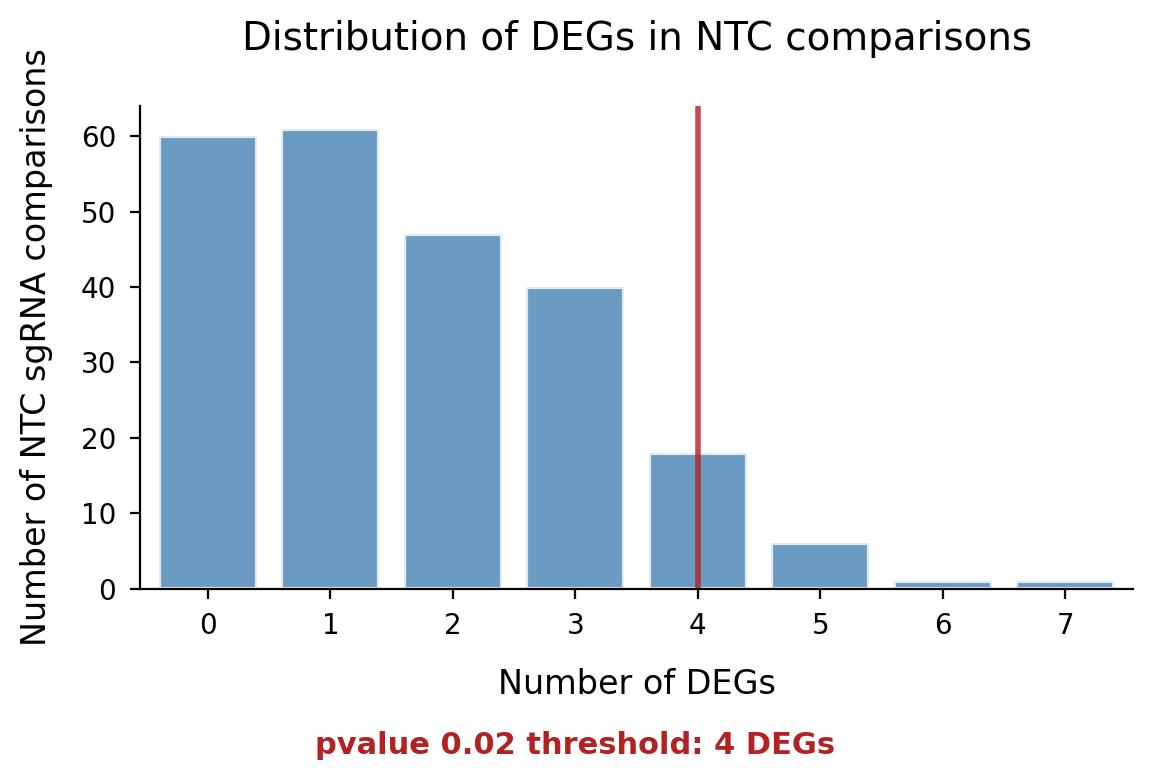

NTC Benchmark Statistics:
  • pvalue 0.02 threshold: 4 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 1.7
  • Median DEGs per comparison: 1.0
  • 95% of comparisons have < 4 DEGs


In [42]:
deg_threshold_02_95, ntc_benchmark_res_02_95 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.02, 
                                    threshold_type="pvalue", percentile=95)

In [ ]:
kd_n_degs_df_02 = build_n_DEGs_df(full_dataset_de_results_df, alpha=0.02, threshold_type="pvalue")
kd_n_degs_df_02.head()

n_DEGs
ADNP2_1       6
ADNP2_2       8
ADNP2_3      15
AHR_2         2
ALX4_2        3

In [48]:
gRNAs_02_95 = kd_n_degs_df_02[kd_n_degs_df_02["n_DEGs"] > deg_threshold_02_95].index.tolist()
print(f"{len(gRNAs_02_95)} perturbing gRNAs")

383 perturbing gRNAs


In [45]:
adata_02_95 = adata[(adata.obs.gRNA.isin(gRNAs_02_95)) | (adata.obs.perturbed == "False")].copy()

In [47]:
print(f"{adata_02_95[adata_02_95.obs.perturbed == 'True'].obs.gene_target.nunique()} gene targets")

327 gene targets


Gene target level DE

In [50]:
gene_target_de_results_dict = \
    matched_differential_expression(adata_02_95, DE_fit_type="mean", target_column="gene_target", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=30)

Running DE analysis:   0%|          | 0/327 [00:00<?, ?it/s]

In [51]:
gene_target_de_results_df = build_DE_df(gene_target_de_results_dict)
gene_target_de_results_df.head()

ZNF14_baseMean  ZNF14_log2FoldChange  ZNF14_lfcSE  ZNF14_stat  \
A1BG             1.864257              0.735923     1.183907    0.621605   
A1BG-AS1         0.373367             -2.185059     2.632794   -0.829939   
A2M              0.512672             -1.215384     2.016206   -0.602808   
A2ML1            0.891141             -0.921585     1.899375   -0.485204   
A2ML1-AS1        2.926793              0.183335     1.204626    0.152192   

           ZNF14_pvalue  ZNF14_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.534201    0.999792       2.930308            -0.447283   
A1BG-AS1       0.406573    0.999792       0.156276            -1.091868   
A2M            0.546637    0.999792       0.316562             1.737861   
A2ML1          0.627531    0.999792       1.680654            -0.147022   
A2ML1-AS1      0.879035    0.999792       5.159437            -0.244635   

           OSR2_lfcSE  OSR2_stat  ...  TBPL1_lfcSE  TBPL1_stat  TBPL1_pvalue  \
A1BG         0.931789  -0.480026  ...     1.289011    0.156928      0.875302   
A1BG-AS1     3.492706  -0.312614  ...     2.663477    0.596046      0.551144   
A2M          2.604063   0.667365  ...     1.755692    1.117027      0.263983   
A2ML1        1.461482  -0.100598  ...     2.045348    0.305428      0.760040   
A2ML1-AS1    0.836623  -0.292408  ...     1.092031    0.573533      0.566284   

           TBPL1_padj  NANOGP8_baseMean  NANOGP8_log2FoldChange  \
A1BG         0.998861          0.647072               -1.376164   
A1BG-AS1     0.998861          0.506852                2.576163   
A2M          0.998861          0.143634               -0.824429   
A2ML1        0.998861          0.497277                1.022751   
A2ML1-AS1    0.998861          1.794077                0.407724   

           NANOGP8_lfcSE  NANOGP8_stat  NANOGP8_pvalue  NANOGP8_padj  
A1BG            2.098237     -0.655867        0.511910      0.986184  
A1BG-AS1        2.833321      0.909238        0.363225      0.986184  
A2M             4.024826     -0.204836        0.837700      0.986184  
A2ML1           2.640913      0.387272        0.698555      0.986184  
A2ML1-AS1       1.124996      0.362422        0.717037      0.986184  

[5 rows x 1962 columns]

In [53]:
gene_target_n_degs_df = build_n_DEGs_df(gene_target_de_results_df, alpha=0.02, threshold_type="pvalue",
                        target_type="gene_target")
gene_target_n_degs_df.head()

n_DEGs
ADNP2         52
ARHGAP35      22
ARID2          7
ARID3B         9
ARNT2          5

In [55]:
print(f"Mean DEGs for 327 gene targets: {np.mean(gene_target_n_degs_df['n_DEGs'])}")
print(f"Median DEGs for 327 gene targets: {np.median(gene_target_n_degs_df['n_DEGs'])}")

Mean DEGs for 327 gene targets: 11.82262996941896
Median DEGs for 327 gene targets: 6.0


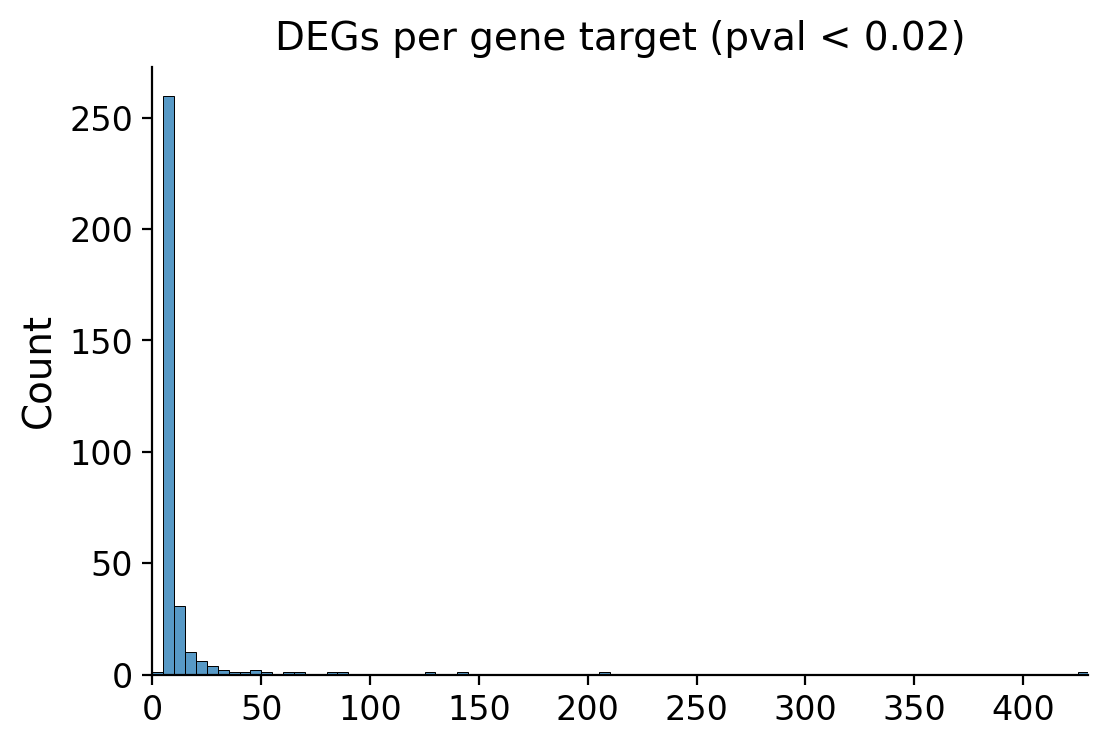

In [59]:
plot_DEGs_per_KD_histogram(gene_target_n_degs_df, title="DEGs per gene target (pval < 0.02)", bin_width=5, xtick_width=50, fig_size=(6,4))

In [63]:
degs = filter_DEGs(gene_target_de_results_df, p_threshold=0.02, lfc_threshold=0.25)
print(len(degs))

2519


### Other tests

In [ ]:
deg_threshold_01_95, ntc_benchmark_res_01_95 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.02, 
                                    threshold_type="pvalue", percentile=95)

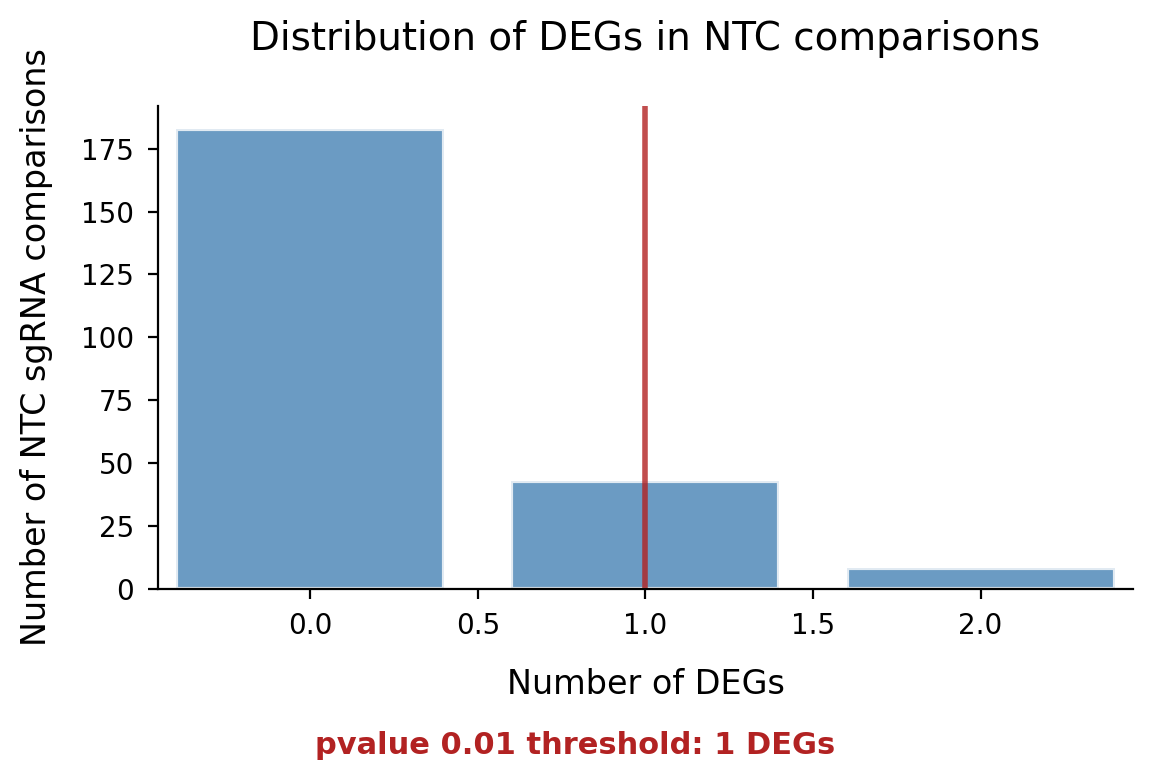

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 1 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.3
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 1 DEGs


In [16]:
full_deg_threshold, full_ntc_benchmark_res = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.01, 
                                    threshold_type="pvalue", percentile=95)

In [18]:
np.mean(full_ntc_benchmark_res["n_DEGs"])

0.25213675213675213

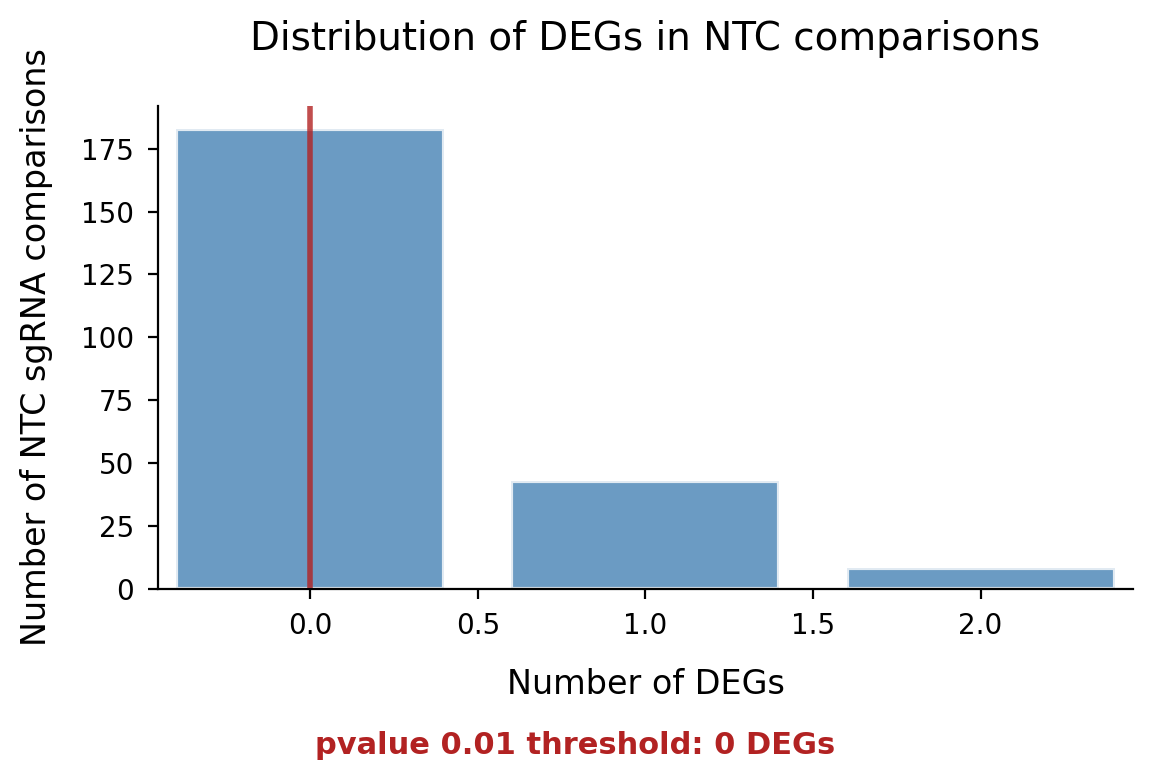

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.3
  • Median DEGs per comparison: 0.0
  • 68% of comparisons have < 0 DEGs


In [ ]:
full_deg_threshold, full_ntc_benchmark_res = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.01, 
                                    threshold_type="pvalue", percentile=68)

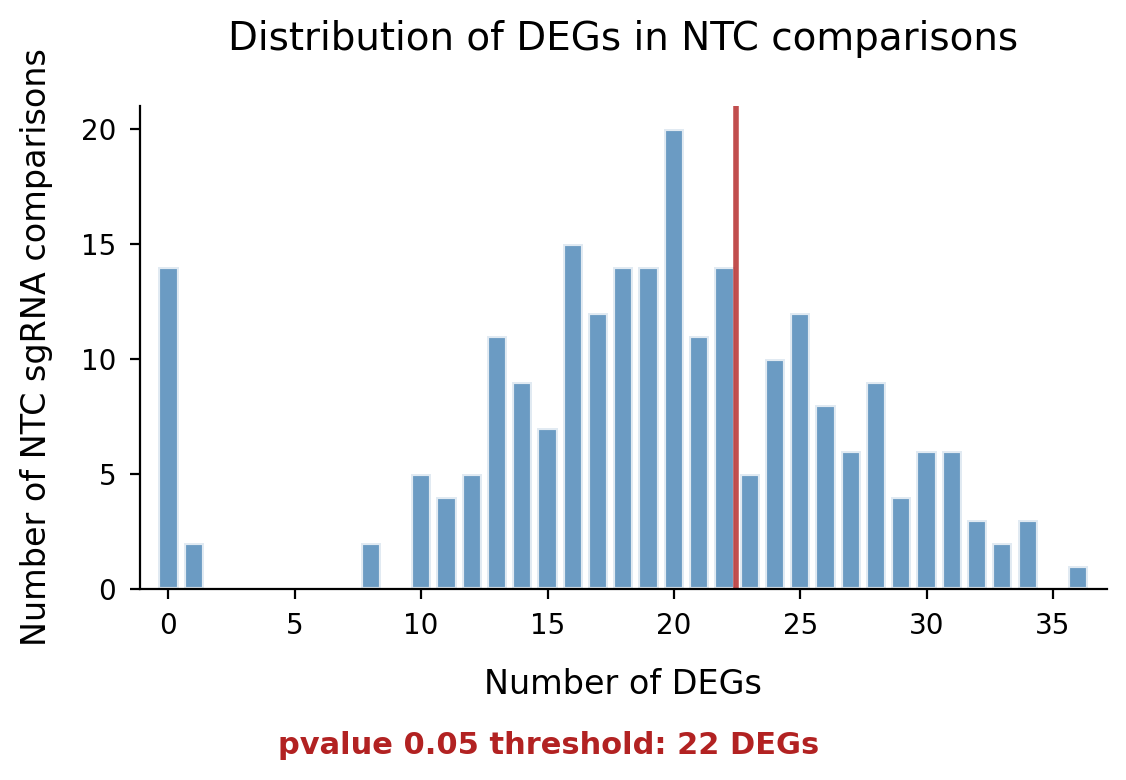

NTC Benchmark Statistics:
  • pvalue 0.05 threshold: 22 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 19.3
  • Median DEGs per comparison: 20.0
  • 68% of comparisons have < 22 DEGs


In [19]:
full_deg_threshold_05, full_ntc_benchmark_res_05 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.05, 
                                    threshold_type="pvalue", percentile=68)

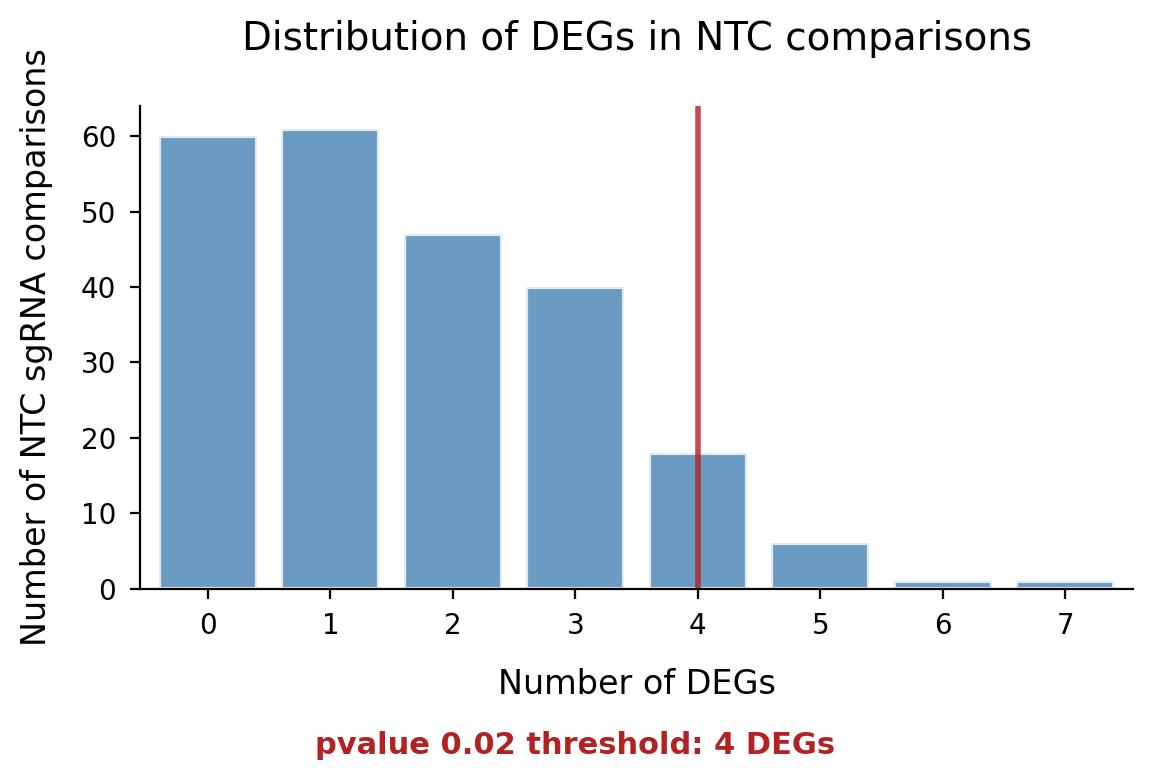

NTC Benchmark Statistics:
  • pvalue 0.02 threshold: 4 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 1.7
  • Median DEGs per comparison: 1.0
  • 95% of comparisons have < 4 DEGs


In [27]:
full_deg_threshold_02_95, full_ntc_benchmark_res_02_95 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.02, 
                                    threshold_type="pvalue", percentile=95)

In [29]:
np.median(full_ntc_benchmark_res_02_95["n_DEGs"])

1.0

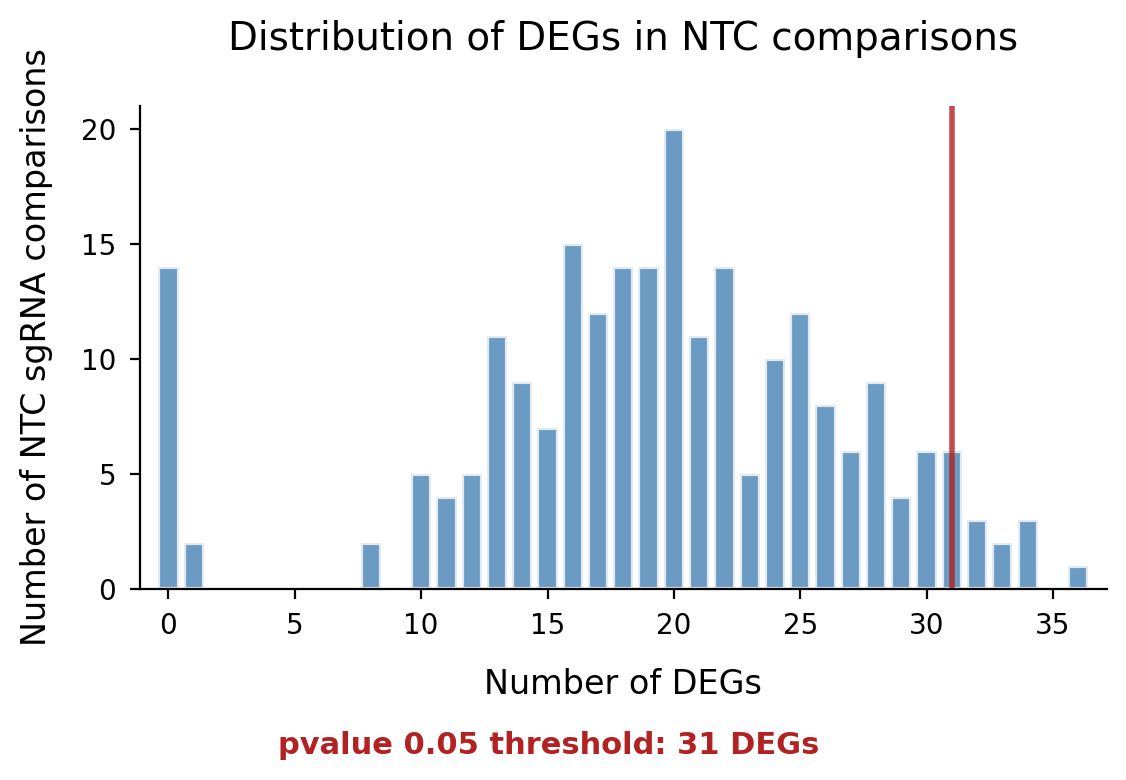

NTC Benchmark Statistics:
  • pvalue 0.05 threshold: 31 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 19.3
  • Median DEGs per comparison: 20.0
  • 95% of comparisons have < 31 DEGs


In [21]:
full_deg_threshold_05_95, full_ntc_benchmark_res_05_95 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.05, 
                                    threshold_type="pvalue", percentile=95)

In [22]:
np.mean(full_ntc_benchmark_res_05_95["n_DEGs"])

19.256410256410255

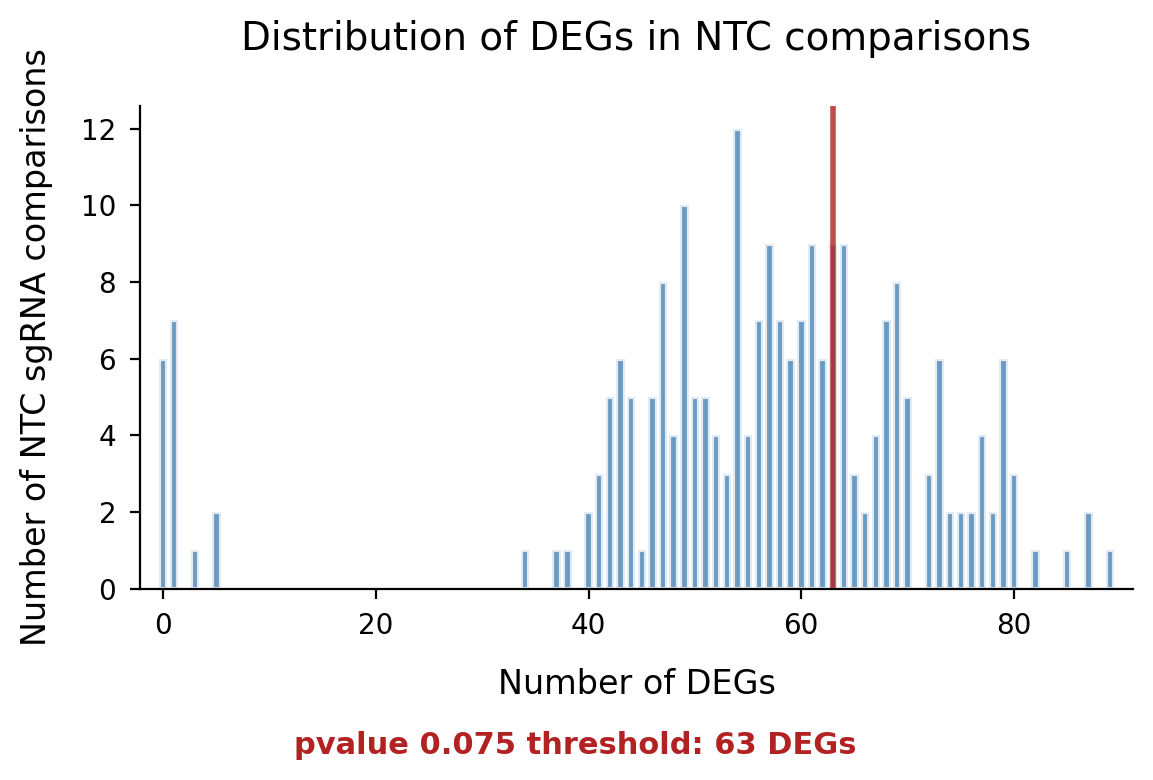

NTC Benchmark Statistics:
  • pvalue 0.075 threshold: 63 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 55.2
  • Median DEGs per comparison: 57.5
  • 68% of comparisons have < 63 DEGs


In [ ]:
full_deg_threshold_075_68, full_ntc_benchmark_res_075_68 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.075, 
                                    threshold_type="pvalue", percentile=68)

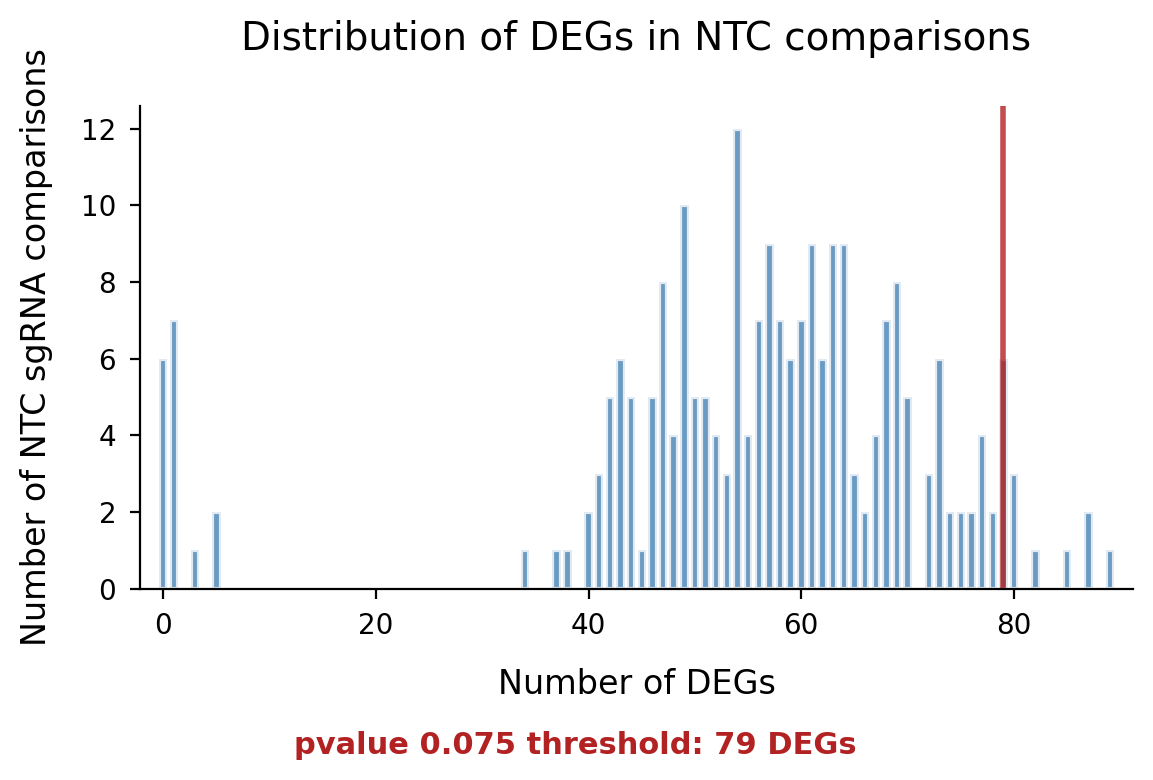

NTC Benchmark Statistics:
  • pvalue 0.075 threshold: 79 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 55.2
  • Median DEGs per comparison: 57.5
  • 95% of comparisons have < 79 DEGs


In [ ]:
full_deg_threshold_075_95, full_ntc_benchmark_res_075_95 = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.075, 
                                    threshold_type="pvalue", percentile=95)

In [ ]:
ntc_grna_rm_df = full_ntc_benchmark_res[full_ntc_benchmark_res["n_DEGs"] > full_deg_threshold]
ntc_grna_rm_df

n_DEGs
Non-Targeting_7        36
Non-Targeting_681      34
Non-Targeting_761      34
Non-Targeting_320      34
Non-Targeting_430      33
...                   ...
Non-Targeting_261      23
Non-Targeting_232      23
Non-Targeting_260      23
Non-Targeting_721      23
Non-Targeting_561      23

[75 rows x 1 columns]

In [ ]:
ntc_grna_to_rm = ntc_grna_rm_df.index.tolist()
adata_ntc_filt = adata[~adata.obs.gRNA.isin(ntc_grna_to_rm)].copy()

gRNA-level DE after NTC filtering

In [24]:
filt_dataset_de_results_dict = \
    matched_differential_expression(adata_ntc_filt, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=4, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

In [25]:
filt_dataset_de_results_df = build_DE_df(filt_dataset_de_results_dict)
filt_dataset_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.463675               0.869728      0.653073     1.331746   
A1BG-AS1          1.180173              -1.518007      1.374946    -1.104048   
A2M               1.096483               2.289241      1.651880     1.385840   
A2ML1             3.121996              -0.348797      0.838078    -0.416186   
A2ML1-AS1         9.677261               0.594743      0.564693     1.053215   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.182944     0.999989          2.269663   
A1BG-AS1        0.269572     0.999989          0.000000   
A2M             0.165796     0.999989          0.685357   
A2ML1           0.677274     0.999989          0.841069   
A2ML1-AS1       0.292243     0.999989          4.222259   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.275408       1.104692      0.249307  ...   
A1BG-AS1                      NaN            NaN           NaN  ...   
A2M                     -1.667516       1.978930     -0.842635  ...   
A2ML1                   -0.721878       1.615285     -0.446904  ...   
A2ML1-AS1               -0.624297       0.904465     -0.690239  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.511226     -0.327156        0.743550      0.995761   
A1BG-AS1        1.944973     -0.160607        0.872403      0.995761   
A2M             2.289098      1.284566        0.198944      0.995761   
A2ML1           1.732169     -0.165561        0.868503      0.995761   
A2ML1-AS1       1.261245      0.564339        0.572523      0.995761   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.318215                  0.046493         2.597548   
A1BG-AS1             0.649902                  1.527461         2.073188   
A2M                  0.000000                       NaN              NaN   
A2ML1                0.605770                  0.117536         1.976781   
A2ML1-AS1            1.795231                  0.323060         1.172460   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG             0.017899          0.985720        0.999317  
A1BG-AS1         0.736769          0.461263        0.999317  
A2M                   NaN               NaN             NaN  
A2ML1            0.059458          0.952587        0.999317  
A2ML1-AS1        0.275540          0.782901        0.999317  

[5 rows x 5916 columns]

In [67]:
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
filt_pvals_degs_df = test_pvals(filt_dataset_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=22)
filt_pvals_degs_df

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥22 DEGs
pval < 0.1                   169                   166                  972
pval < 0.075                  89                    86                  970
pval < 0.05                   36                    33                  908
pval < 0.01                    1                     1                   10
pval < 0.005                   0                     0                    6
pval < 0.001                   0                     0                    4

In [26]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

In [55]:
filt_n_degs_df_5 = build_n_DEGs_df(filt_dataset_de_results_df, 0.05, threshold_type="pvalue")
filt_threshold_n_degs_df_5 = filt_n_degs_df_5[filt_n_degs_df_5["n_DEGs"] >= 22]
print(len(filt_threshold_n_degs_df_5))

908


In [56]:
filt_threshold_n_degs_df_5.sort_values(by="n_DEGs", ascending=False).head(10)

n_DEGs
POU5F1B_1     371
POU5F1_3      325
PHF20_1       305
POU3F2_2      251
ZNF521_1      226
ZNF396_2      163
NANOG_2       145
PURG_3        113
DNMT1_3       105
DNMT1_2        94

In [57]:
filt_n_degs_df_10 = build_n_DEGs_df(filt_dataset_de_results_df, 0.1, threshold_type="pvalue")
print(len(filt_n_degs_df_10))
filt_threshold_n_degs_df_10 = filt_n_degs_df_10[filt_n_degs_df_10["n_DEGs"] >= 22]
print(len(filt_threshold_n_degs_df_10))

986
972


In [54]:
filt_threshold_n_degs_df_10.sort_values(by="n_DEGs", ascending=False).head(10)

n_DEGs
POU5F1B_1      695
PHF20_1        633
POU5F1_3       616
POU3F2_2       501
ZNF521_1       498
ZNF396_2       415
NANOG_2        382
PURG_3         344
ARHGAP35_3     327
BHLHE40_1      303

In [77]:
filt_n_degs_df_075 = build_n_DEGs_df(filt_dataset_de_results_df, 0.075, threshold_type="pvalue")
filt_threshold_n_degs_df_075 = filt_n_degs_df_075[filt_n_degs_df_075["n_DEGs"] >= 22]
print(len(filt_threshold_n_degs_df_075))

970


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_DEGs_per_KD_histogram(n_DEGs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=100, xmax=None, ymax=None):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_DEGs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    sns.histplot(n_DEGs_df[n_DEGs_df[n_degs_str] >= min_n_degs][n_degs_str].values, 
                 binwidth=bin_width, binrange=(0,xmax))
    plt.xlim(0, xmax)
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

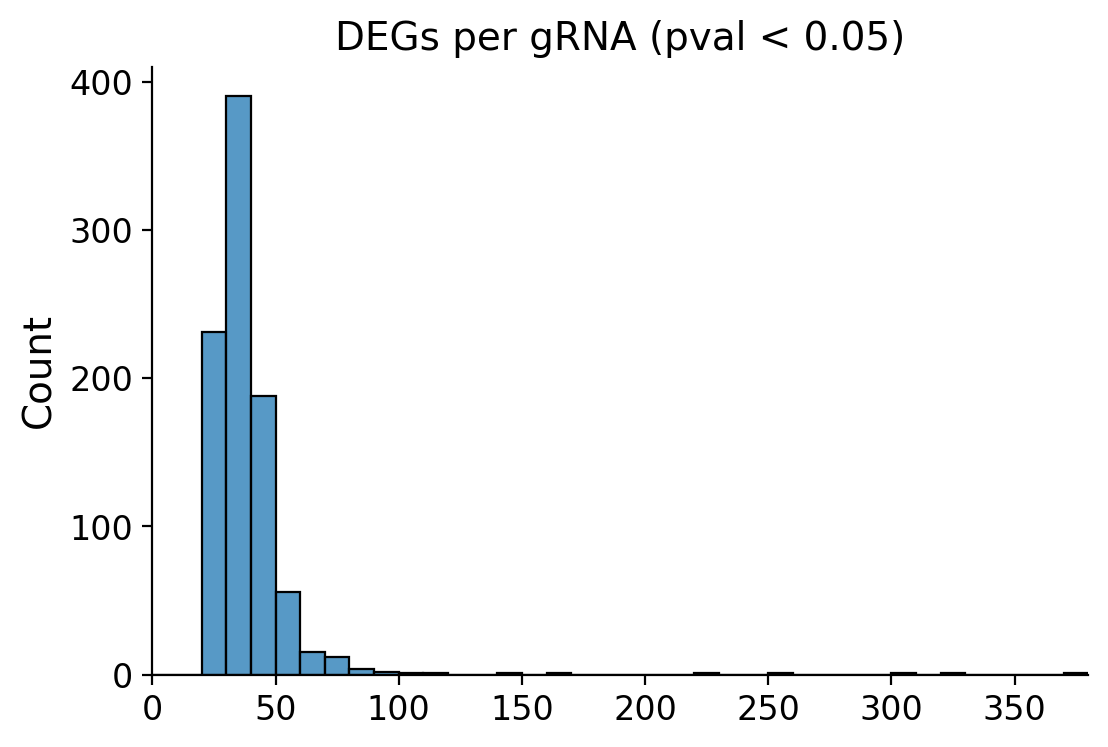

In [46]:
plot_DEGs_per_KD_histogram(filt_n_degs_df_5, title="DEGs per gRNA (pval < 0.05)", bin_width=10, xtick_width=50, fig_size=(6,4))

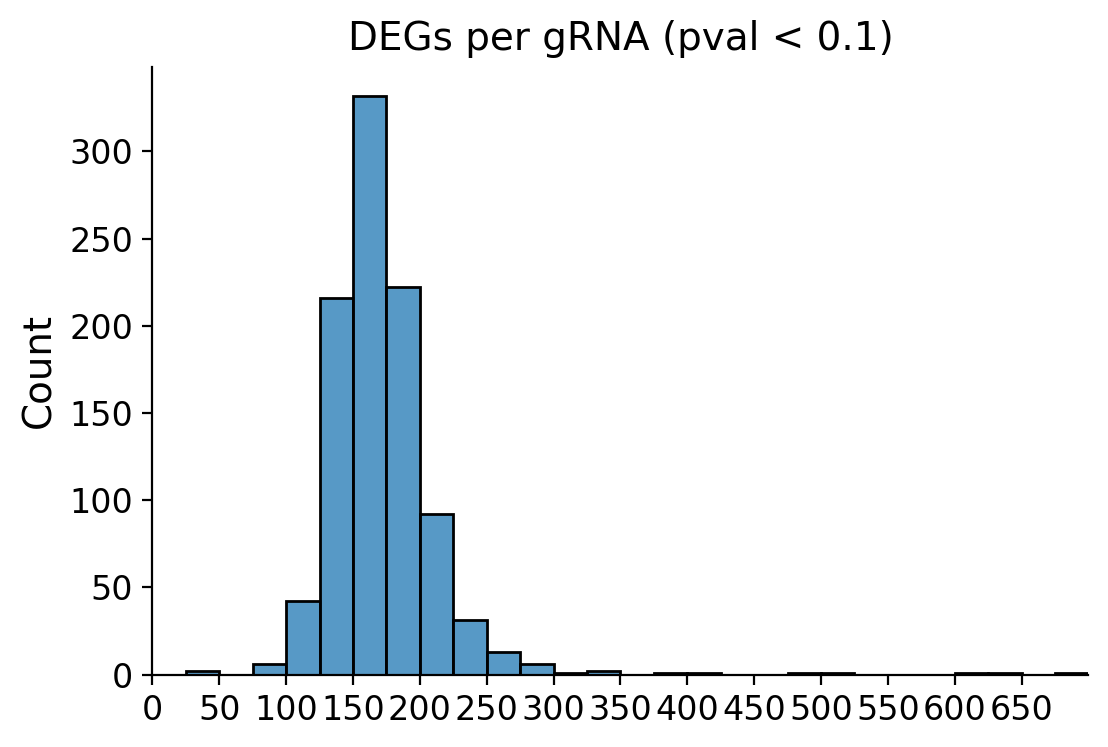

In [47]:
plot_DEGs_per_KD_histogram(filt_n_degs_df_10, title="DEGs per gRNA (pval < 0.1)", bin_width=25, xtick_width=50, fig_size=(6,4))

In [52]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_filt_matched_1-23-26.pkl"
filt_dataset_de_results_df.to_pickle(filepath_pkl)

In [58]:
pert_grna_to_rm = filt_n_degs_df_10[filt_n_degs_df_10["n_DEGs"] < 22].index.tolist()
print(len(pert_grna_to_rm))

14


In [60]:
adata_grna_filt = adata_ntc_filt[~adata_ntc_filt.obs.gRNA.isin(pert_grna_to_rm)].copy()

In [61]:
print(adata_ntc_filt[adata_ntc_filt.obs.perturbed == "True"].obs.gRNA.nunique())
print(adata_grna_filt[adata_grna_filt.obs.perturbed == "True"].obs.gRNA.nunique())

986
972


In [63]:
adata_grna_filt

AnnData object with n_obs × n_vars = 96325 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [62]:
filt_gene_target_de_results_dict = \
    matched_differential_expression(adata_grna_filt, DE_fit_type="mean", target_column="gene_target", 
                                    suppress_warnings=True, n_cpus_for_DE=4, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/723 [00:00<?, ?it/s]

In [65]:
filt_gene_target_de_results_df = build_DE_df(filt_gene_target_de_results_dict)
filt_gene_target_de_results_df.head()

ESR2_baseMean  ESR2_log2FoldChange  ESR2_lfcSE  ESR2_stat  \
A1BG            6.463675             0.869728    0.653073   1.331746   
A1BG-AS1        1.180173            -1.518007    1.374946  -1.104048   
A2M             1.096483             2.289241    1.651880   1.385840   
A2ML1           3.121996            -0.348797    0.838078  -0.416186   
A2ML1-AS1       9.677261             0.594743    0.564693   1.053215   

           ESR2_pvalue  ESR2_padj  ZNF14_baseMean  ZNF14_log2FoldChange  \
A1BG          0.182944   0.999989        5.721791              0.051480   
A1BG-AS1      0.269572   0.999989        0.349524             -2.052183   
A2M           0.165796   0.999989        0.984354             -0.195827   
A2ML1         0.677274   0.999989        2.267026              0.217643   
A2ML1-AS1     0.292243   0.999989        5.213209              0.170615   

           ZNF14_lfcSE  ZNF14_stat  ...  TBPL1_lfcSE  TBPL1_stat  \
A1BG          0.720320    0.071469  ...     1.511226   -0.327156   
A1BG-AS1      2.483304   -0.826392  ...     1.944973   -0.160607   
A2M           1.367860   -0.143163  ...     2.289098    1.284566   
A2ML1         1.048997    0.207477  ...     1.732169   -0.165561   
A2ML1-AS1     0.712114    0.239590  ...     1.261245    0.564339   

           TBPL1_pvalue  TBPL1_padj  NANOGP8_baseMean  NANOGP8_log2FoldChange  \
A1BG           0.743550    0.995761          0.318215                0.046493   
A1BG-AS1       0.872403    0.995761          0.649902                1.527461   
A2M            0.198944    0.995761          0.000000                     NaN   
A2ML1          0.868503    0.995761          0.605770                0.117536   
A2ML1-AS1      0.572523    0.995761          1.795231                0.323060   

           NANOGP8_lfcSE  NANOGP8_stat  NANOGP8_pvalue  NANOGP8_padj  
A1BG            2.597548      0.017899        0.985720      0.999317  
A1BG-AS1        2.073188      0.736769        0.461263      0.999317  
A2M                  NaN           NaN             NaN           NaN  
A2ML1           1.976781      0.059458        0.952587      0.999317  
A2ML1-AS1       1.172460      0.275540        0.782901      0.999317  

[5 rows x 4338 columns]

In [69]:
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
gene_target_pvals_degs_df = test_pvals(filt_gene_target_de_results_df, pvals, target_type="gene_target")
gene_target_pvals_degs_df

mean DEGs per gene_target  median DEGs per gene_target  \
pval < 0.1                          200                          180   
pval < 0.075                        108                           95   
pval < 0.05                          46                           38   
pval < 0.01                           3                            1   
pval < 0.005                          1                            0   
pval < 0.001                          0                            0   

              gene_targets with ≥3 DEGs  
pval < 0.1                          723  
pval < 0.075                        723  
pval < 0.05                         723  
pval < 0.01                         154  
pval < 0.005                         55  
pval < 0.001                         23

In [72]:
pert_grna_to_rm5 = filt_n_degs_df_5[filt_n_degs_df_5["n_DEGs"] < 22].index.tolist()
print(len(pert_grna_to_rm5))

78


In [73]:
adata_grna_filt5 = adata_ntc_filt[~adata_ntc_filt.obs.gRNA.isin(pert_grna_to_rm5)].copy()

In [74]:
filt_gene_target_de_results_dict5 = \
    matched_differential_expression(adata_grna_filt5, DE_fit_type="mean", target_column="gene_target", 
                                    suppress_warnings=True, n_cpus_for_DE=4, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/689 [00:00<?, ?it/s]

In [75]:
filt_gene_target_de_results_df5 = build_DE_df(filt_gene_target_de_results_dict5)
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
gene_target_pvals_degs_df5 = test_pvals(filt_gene_target_de_results_df5, pvals, target_type="gene_target")
gene_target_pvals_degs_df5

mean DEGs per gene_target  median DEGs per gene_target  \
pval < 0.1                          201                          180   
pval < 0.075                        110                           96   
pval < 0.05                          47                           38   
pval < 0.01                           3                            1   
pval < 0.005                          1                            0   
pval < 0.001                          0                            0   

              gene_targets with ≥3 DEGs  
pval < 0.1                          689  
pval < 0.075                        689  
pval < 0.05                         689  
pval < 0.01                         146  
pval < 0.005                         55  
pval < 0.001                         22

In [78]:
pert_grna_to_rm075 = filt_n_degs_df_075[filt_n_degs_df_075["n_DEGs"] < 22].index.tolist()
print(len(pert_grna_to_rm075))

16


In [79]:
adata_grna_filt075 = adata_ntc_filt[~adata_ntc_filt.obs.gRNA.isin(pert_grna_to_rm075)].copy()

In [80]:
filt_gene_target_de_results_dict075 = \
    matched_differential_expression(adata_grna_filt075, DE_fit_type="mean", target_column="gene_target", 
                                    suppress_warnings=True, n_cpus_for_DE=4, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/721 [00:00<?, ?it/s]

In [81]:
filt_gene_target_de_results_df075 = build_DE_df(filt_gene_target_de_results_dict075)
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
gene_target_pvals_degs_df075 = test_pvals(filt_gene_target_de_results_df075, pvals, target_type="gene_target")
gene_target_pvals_degs_df075

mean DEGs per gene_target  median DEGs per gene_target  \
pval < 0.1                          200                          180   
pval < 0.075                        109                           95   
pval < 0.05                          46                           38   
pval < 0.01                           3                            1   
pval < 0.005                          1                            0   
pval < 0.001                          0                            0   

              gene_targets with ≥3 DEGs  
pval < 0.1                          721  
pval < 0.075                        721  
pval < 0.05                         721  
pval < 0.01                         154  
pval < 0.005                         55  
pval < 0.001                         23

In [83]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [84]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_ntc_gRNA_reps.pkl"
de_results_df_unmatched_gene_targets = pd.read_pickle(filepath_pkl)

In [109]:
n_degs_df_unmatched_gene_targets = build_n_DEGs_df(de_results_df_unmatched_gene_targets,
alpha=0.2, threshold_type="padj", target_type="gene_target")

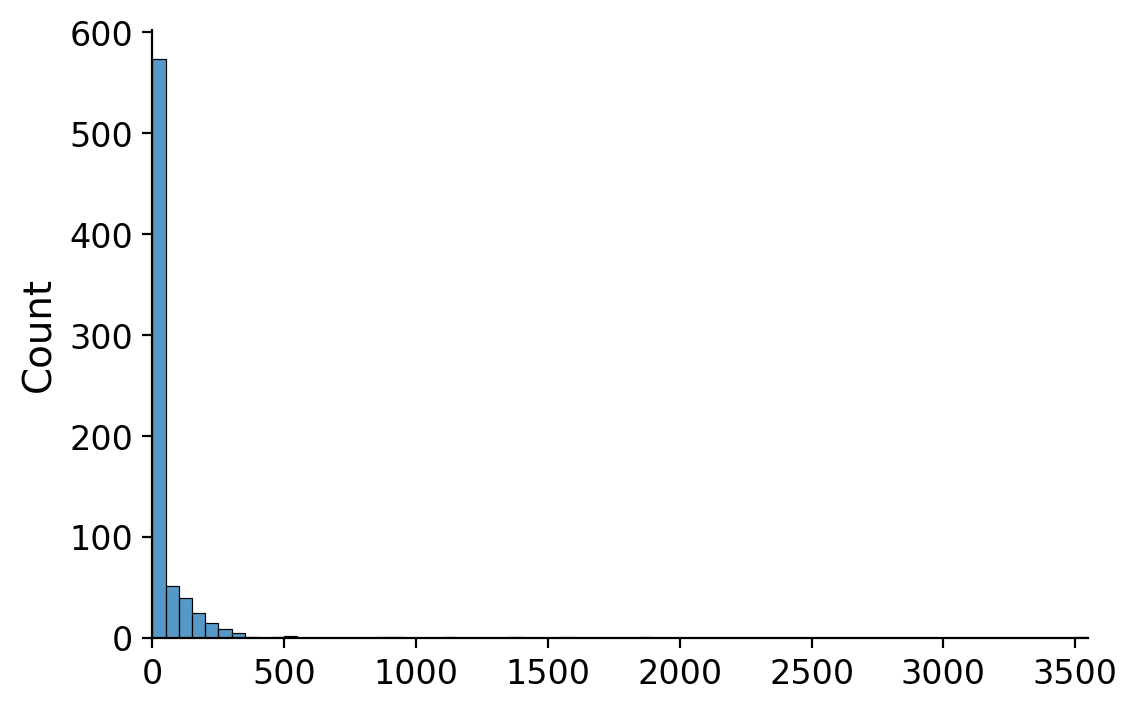

In [124]:
plot_DEGs_per_KD_histogram(n_degs_df_unmatched_gene_targets, bin_width=50, xtick_width=500, fig_size=(6,4)) 

In [86]:
degs_padj = filter_DEGs(de_results_df_unmatched_gene_targets, 
                        p_threshold=0.1, p_threshold_type="padj", lfc_threshold=0.25)
print(len(degs_padj))

6745


In [95]:
degs_pval_005 = filter_DEGs(filt_gene_target_de_results_df5, 
                                p_threshold=0.025, p_threshold_type="pvalue", lfc_threshold=0.25)
print(len(degs_pval_005))

4922


In [97]:
degs_pval_075 = filter_DEGs(filt_gene_target_de_results_df075, 
                                p_threshold=0.025, p_threshold_type="pvalue", lfc_threshold=0.25)
print(len(degs_pval_075))

5022


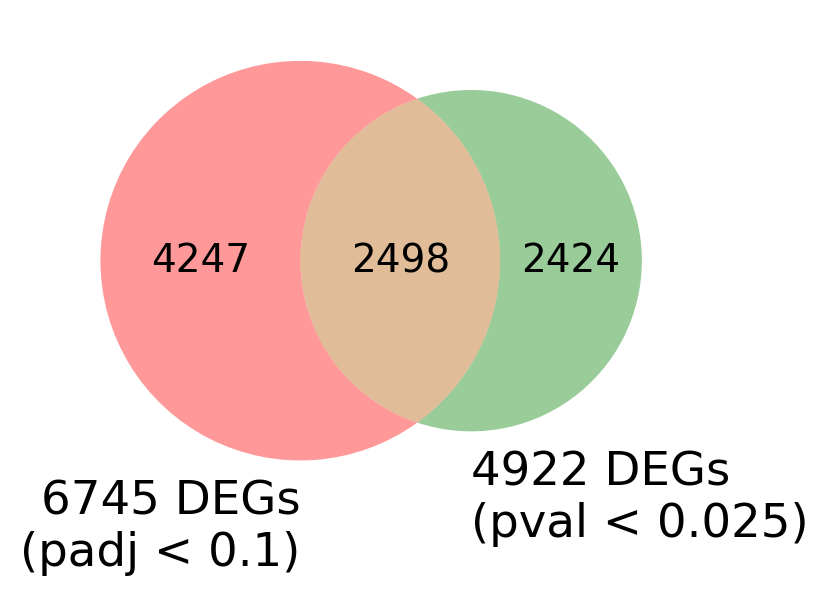

In [98]:
from matplotlib_venn import venn2
_ = venn2((degs_padj, degs_pval_005), 
          set_labels=("6745 DEGs\n(padj < 0.1)", "4922 DEGs\n(pval < 0.025)"))

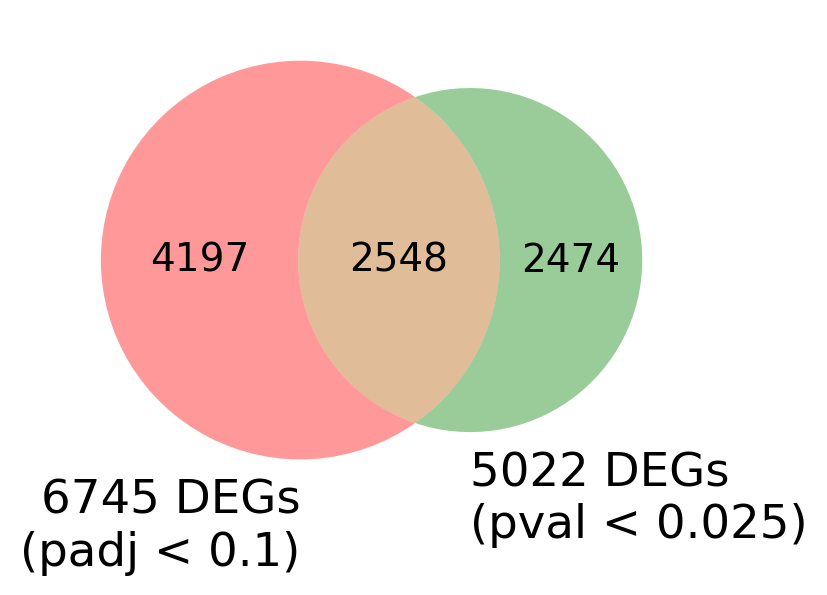

In [104]:
from matplotlib_venn import venn2
_ = venn2((degs_padj, degs_pval_075), 
          set_labels=("6745 DEGs\n(padj < 0.1)", "5022 DEGs\n(pval < 0.025)"))

In [102]:
print(len(filter_DEGs(filt_gene_target_de_results_df5, p_threshold=0.05, 
p_threshold_type="pvalue", lfc_threshold=0.25)))

print(len(filter_DEGs(filt_gene_target_de_results_df5, p_threshold=0.025, 
p_threshold_type="pvalue", lfc_threshold=0.25)))

print(len(filter_DEGs(filt_gene_target_de_results_df5, p_threshold=0.01, 
p_threshold_type="pvalue", lfc_threshold=0.1)))

11049
4922
1419


In [103]:
print(len(filter_DEGs(filt_gene_target_de_results_df075, p_threshold=0.05, 
p_threshold_type="pvalue", lfc_threshold=0.25)))

print(len(filter_DEGs(filt_gene_target_de_results_df075, p_threshold=0.025, 
p_threshold_type="pvalue", lfc_threshold=0.25)))

print(len(filter_DEGs(filt_gene_target_de_results_df075, p_threshold=0.01, 
p_threshold_type="pvalue", lfc_threshold=0.1)))

11179
5022
1450


In [ ]:
venn2((degs_pval_005, degs_pval_075), 
          set_labels=("4922 DEGs\n(filt on\npval < 0.05)", "5022 DEGs\n(filt on\npval < 0.075)"))
plt.title("DEGs (pval < 0.025)")
plt.show()

NTC benchmarking pval < 0.01

In [9]:
ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

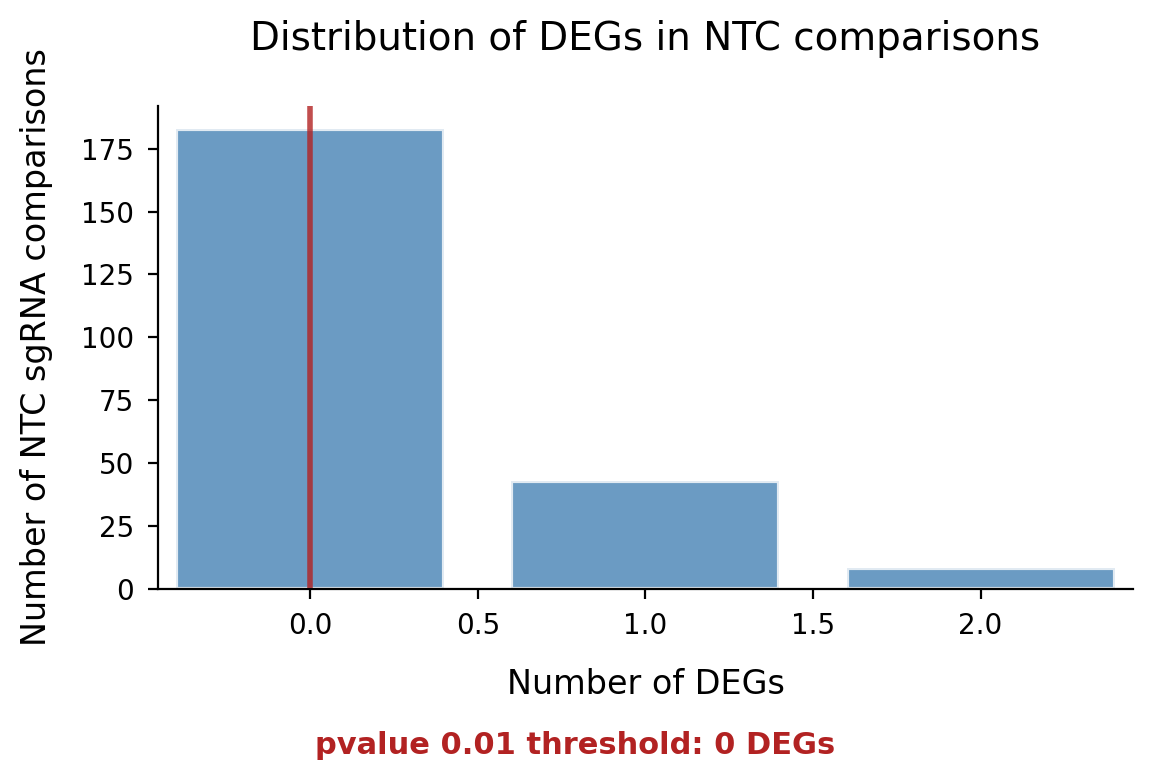

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.3
  • Median DEGs per comparison: 0.0
  • 68% of comparisons have < 0 DEGs


In [10]:
full_deg_threshold, full_ntc_benchmark_res = \
    report_ntc_benchmarking_results(ntc_bench_matched_results_dict, alpha=0.01, 
                                    threshold_type="pvalue", percentile=68)

In [11]:
ntc_grna_rm_df = full_ntc_benchmark_res[full_ntc_benchmark_res["n_DEGs"] > full_deg_threshold]
print(len(ntc_grna_rm_df))

51


In [12]:
ntc_grna_to_rm = ntc_grna_rm_df.index.tolist()
adata_ntc_filt = adata[~adata.obs.gRNA.isin(ntc_grna_to_rm)].copy()

In [15]:
filt_dataset_de_results_dict = \
    matched_differential_expression(adata_ntc_filt, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

In [32]:
filt_de_results_df = build_DE_df(filt_dataset_de_results_dict)
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
filt_pvals_degs = test_pvals(filt_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=1)
filt_pvals_degs

mean DEGs per gRNA  median DEGs per gRNA  gRNAs with ≥1 DEGs
pval < 0.1                   166                   162                 984
pval < 0.075                  87                    84                 979
pval < 0.05                   35                    33                 973
pval < 0.01                    1                     1                 564
pval < 0.005                   0                     0                 270
pval < 0.001                   0                     0                 113

In [24]:
filt_n_degs_df = build_n_DEGs_df(filt_de_results_df, alpha=0.01, threshold_type="pvalue")
print(len(filt_n_degs_df[filt_n_degs_df["n_DEGs"] > 0]))

564


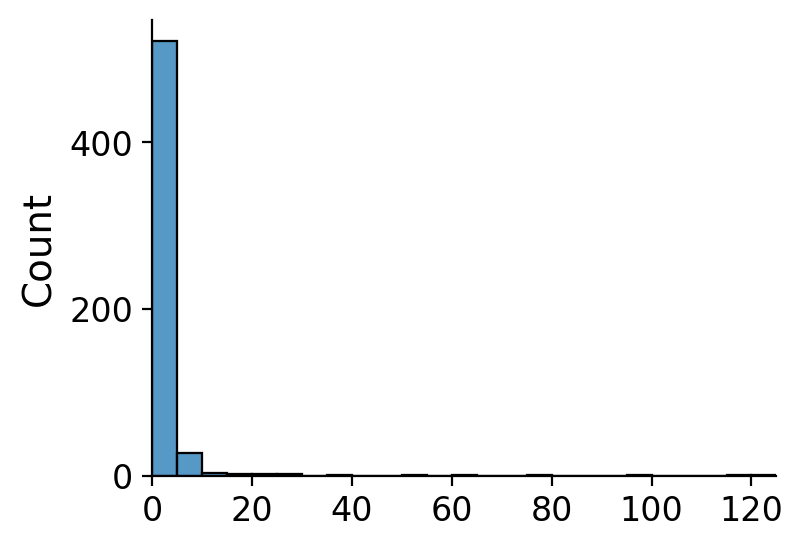

In [31]:
filt_n_degs_ntc_thr_df = filt_n_degs_df[filt_n_degs_df["n_DEGs"] > 0]
plot_DEGs_per_KD_histogram(filt_n_degs_ntc_thr_df, bin_width=5, xtick_width=20) 

Filter NTC gRNAs again

In [13]:
filt_ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata_ntc_filt, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/183 [00:00<?, ?it/s]

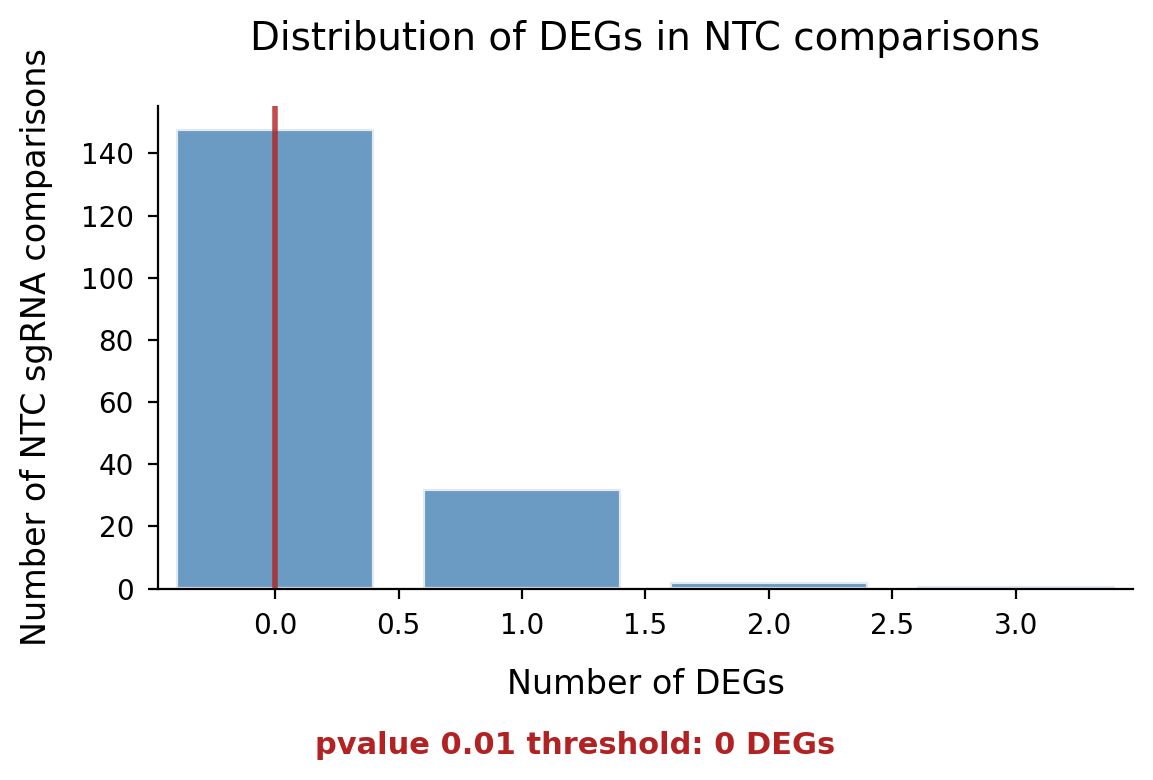

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 0 DEGs
  • NTC comparisons analyzed: 183
  • Mean DEGs per comparison: 0.2
  • Median DEGs per comparison: 0.0
  • 68% of comparisons have < 0 DEGs


In [14]:
filt_deg_threshold, filt_ntc_benchmark_res = \
    report_ntc_benchmarking_results(filt_ntc_bench_matched_results_dict, alpha=0.01, 
                                    threshold_type="pvalue", percentile=68)

In [15]:
ntc_grna_rm_df2 = filt_ntc_benchmark_res[filt_ntc_benchmark_res["n_DEGs"] > filt_deg_threshold]
print(len(ntc_grna_rm_df2))

35


In [31]:
ntc_grna_to_rm2 = ntc_grna_rm_df2.index.tolist()
adata_ntc_filt2 = adata_ntc_filt[~adata_ntc_filt.obs.gRNA.isin(ntc_grna_to_rm2)].copy()

In [32]:
filt2_dataset_de_results_dict = \
    matched_differential_expression(adata_ntc_filt2, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=30)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

In [41]:
filt2_de_results_df = build_DE_df(filt2_dataset_de_results_dict)
pvals = [0.1, 0.075, 0.05, 0.01, 0.005, 0.001]
filt2_pvals_degs = test_pvals(filt2_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=1)
filt2_pvals_degs

mean DEGs per KD gRNA  median DEGs per KD gRNA  \
pval < 0.1                      165                      161   
pval < 0.075                     87                       84   
pval < 0.05                      35                       33   
pval < 0.01                       1                        1   
pval < 0.005                      0                        0   
pval < 0.001                      0                        0   

              KD gRNAs with ≥1 DEGs  
pval < 0.1                      986  
pval < 0.075                    978  
pval < 0.05                     975  
pval < 0.01                     560  
pval < 0.005                    255  
pval < 0.001                    112

In [34]:
filt2_n_degs_df = build_n_DEGs_df(filt2_de_results_df, alpha=0.01, threshold_type="pvalue")

In [35]:
print(f"{len(filt2_n_degs_df[filt2_n_degs_df['n_DEGs'] > 0])} perturbing gRNAs have >0 DEGs")
print(f"{len(filt2_n_degs_df[filt2_n_degs_df['n_DEGs'] >= 4])} perturbing gRNAs have >=4 DEGs")
print(f"{len(filt2_n_degs_df[filt2_n_degs_df['n_DEGs'] >= 5])} perturbing gRNAs have >=5 DEGs")
print(f"{len(filt2_n_degs_df[filt2_n_degs_df['n_DEGs'] >= 10])} perturbing gRNAs have >=10 DEGs")

560 perturbing gRNAs have >0 DEGs
74 perturbing gRNAs have >=4 DEGs
39 perturbing gRNAs have >=5 DEGs
18 perturbing gRNAs have >=10 DEGs


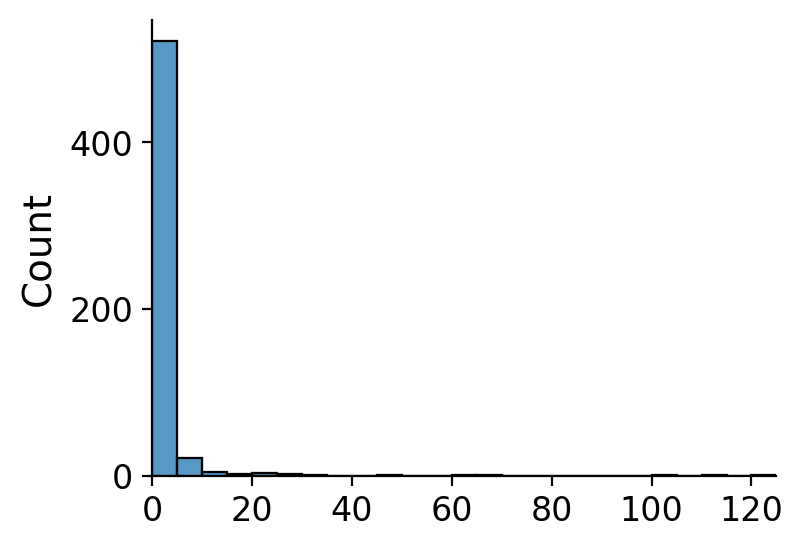

In [36]:
filt2_n_degs_ntc_thr_df = filt2_n_degs_df[filt2_n_degs_df["n_DEGs"] > 0]
plot_DEGs_per_KD_histogram(filt2_n_degs_ntc_thr_df, bin_width=5, xtick_width=20) 

In [37]:
filt2_ntc_bench_matched_results_dict = \
    ntc_benchmarking_matched_DE(adata_ntc_filt2, n_cpus_for_DE=3, n_jobs_parallel=25, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/148 [00:00<?, ?it/s]

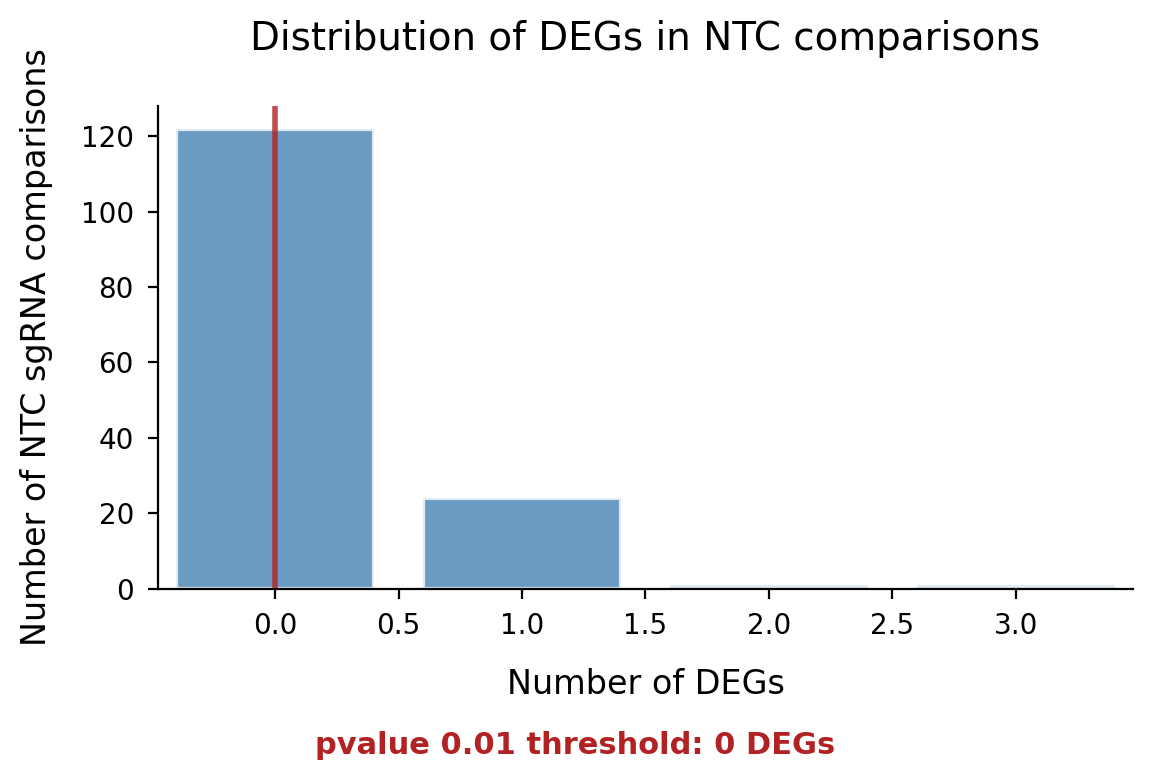

NTC Benchmark Statistics:
  • pvalue 0.01 threshold: 0 DEGs
  • NTC comparisons analyzed: 148
  • Mean DEGs per comparison: 0.2
  • Median DEGs per comparison: 0.0
  • 68% of comparisons have < 0 DEGs


In [38]:
filt2_deg_threshold, filt2_ntc_benchmark_res = \
    report_ntc_benchmarking_results(filt2_ntc_bench_matched_results_dict, alpha=0.01, 
                                    threshold_type="pvalue", percentile=68)

In [39]:
ntc_grna_rm_df3 = filt2_ntc_benchmark_res[filt2_ntc_benchmark_res["n_DEGs"] > filt2_deg_threshold]
print(len(ntc_grna_rm_df3))

26


# Winter 2026 Week 5

In [2]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [3]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def generate_matched_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                            target_value: str, 
                                            ntc_cell_indices: pd.Index, 
                                            rng: np.random.Generator, 
                                            target_column: str = "perturbation", 
                                            min_cells_per_rep: int = 12,
                                            layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def matched_differential_expression(adata: ad.AnnData,
                                    layer: str = "counts",
                                    min_cells_per_rep: int = 12,
                                    random_state: int = 42,
                                    n_cpus_for_DE: int = 3,
                                    n_jobs_parallel: int = 25,
                                    alpha: float = 0.05,
                                    DE_fit_type: str = "parametric",
                                    target_column: str = "perturbation",
                                    ntc_target_delimiter: str = "NTC",
                                    suppress_warnings: bool = False,
                                    debug: bool = False):
    """
    Perform pseudobulk DE analysis with pseudoreplicates on each 
    gRNA or gene target against a matched number of NTC cells.
    Return dict {target: DE results DF for that target}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_target_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_target_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_perturbation(target: str, rng: np.random.Generator):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            adata, target, ntc_cell_indices, rng=rng, 
            target_column=target_column, layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        quiet = False if debug is True else True
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=quiet
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=quiet)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        return de_results

    # Run DE analysis on all targets in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_perturbation)(pert, de_rng) for pert in perturbations)
    results_dict = dict(zip(perturbations, de_results))
    return results_dict

In [4]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [5]:
def test_pvals(DE_results_df, pval_list, target_type="gRNA", pval_delimiter="pvalue", ntc_deg_threshold=1):
    """
    Given a DF of DGE results and a list of p-values, compute the
    number of genes with pval < each pval in the list for each gRNA
    or gene target. Return the mean and median number of DE genes across
    all gRNAs/gene targets.
    """
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    DEGs_df_dict = {f"pval < {pval}":[] for pval in pval_list}
    for pval in pval_list:
        DEGs_arr = np.zeros(len(targets))
        for i, target in enumerate(targets):
            target_pval_col = f"{target}_{pval_delimiter}"
            n_DEGs = len(DE_results_df.loc[DE_results_df[target_pval_col] < pval])
            DEGs_arr[i] = n_DEGs
        DEGs_df_dict[f"pval < {pval}"].append(int(np.mean(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(np.median(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(len(DEGs_arr[DEGs_arr >= ntc_deg_threshold])))
    DEGs_df = pd.DataFrame.from_dict(DEGs_df_dict, orient="index", 
                                     columns=[f"mean DEGs per KD {target_type}", 
                                              f"median DEGs per KD {target_type}",
                                              f"KD {target_type}s with ≥{ntc_deg_threshold} DEGs"])
    return DEGs_df

In [6]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

In [31]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [50]:
import seaborn as sns

def plot_DEGs_per_KD_histogram(n_DEGs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=100, xmax=None, ymax=None,
                               xlabel="", ylabel="Counts", color=None):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_DEGs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    if color:
        sns.histplot(data=n_DEGs_df, x="n_DEGs", binwidth=bin_width, binrange=(0,xmax),
                 color=color)
    else:
        sns.histplot(data=n_DEGs_df, x="n_DEGs", binwidth=bin_width, binrange=(0,xmax))
    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, 
                offset=None, trim=False)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(0, xmax)
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title(title, fontsize=13)

In [8]:
def ntc_benchmarking_matched_DE(adata: ad.AnnData,
                                layer: str = "counts",
                                min_cells_per_rep: int = 12,
                                random_state: int = 42,
                                n_cpus_for_DE: int = 3,
                                n_jobs_parallel: int = 25, 
                                alpha: float = 0.05,
                                DE_fit_type: str = "parametric",
                                ntc_target_delimiter: str = "NTC",
                                gRNA_column: str = "gRNA",
                                suppress_warnings: bool = False,
                                debug: bool = False):
    """
    Perform DE analysis on each NTC gRNA against a matched
    number of other NTC cells. 
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    ntc_adata = adata[adata.obs.gene_target == ntc_target_delimiter].copy()
    # Get unique NTC sgRNAs
    ntc_gRNAs = list(ntc_adata.obs[gRNA_column].unique())
    if debug == True:
        print("Running in debug mode with 5 NTC sgRNA")
        ntc_gRNAs = ntc_gRNAs[:5]
    # Create RNG object to handle case where one is not provided
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_ntc_gRNA(target_ntc_gRNA: str,
                         rng: np.random.Generator):
        # Check if there are enough target cells
        target_cells = ntc_adata[ntc_adata.obs[gRNA_column] == target_ntc_gRNA].obs.index
        if len(target_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few cells ({len(target_cells)})")
            return
        
        # Get other NTC cells (excluding the target gRNA)
        other_ntc_cells = ntc_adata[ntc_adata.obs[gRNA_column] != target_ntc_gRNA].obs.index
        if len(other_ntc_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few other NTC cells ({len(other_ntc_cells)})")
            return
        
        # Temporarily create "perturbation" column to use with generate_pseudoreplicates_for_DE
        # This labels target gRNA cells as the "perturbation" and other NTC cells as "NTC"
        ntc_adata_temp = ntc_adata.copy()
        ntc_adata_temp.obs["temp_pert"] = "NTC"
        ntc_adata_temp.obs.loc[ntc_adata_temp.obs[gRNA_column] == target_ntc_gRNA, 'temp_pert'] = target_ntc_gRNA
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            ntc_adata_temp, target_ntc_gRNA, other_ntc_cells, rng, 
            target_column="temp_pert", layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=True
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target_ntc_gRNA.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=True)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res, ntc_adata_temp
        gc.collect()

        return de_results

    # Run DE analysis on all NTC sgRNA in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(ntc_gRNAs)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_ntc_gRNA)(ntc_gRNA, de_rng) for ntc_gRNA in ntc_gRNAs)
    results_dict = dict(zip(ntc_gRNAs, de_results))
    return results_dict

In [9]:
def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05,
                                    threshold_type: str = "padj", percentile: int = 95):
    """
    Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
    fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
    a summary of results.
    """
    if (threshold_type != "padj") & (threshold_type != "pvalue"):
        raise ValueError("threshold_type must be 'padj' or 'pvalue'")
    # Counts DEGs per gRNA
    deg_counts = {}
    for ntc_gRNA, result_df in results_dict.items():
        if result_df is None:
            continue
        deg_count = sum((result_df[threshold_type] < alpha) & pd.notna(result_df[threshold_type]))
        deg_counts[ntc_gRNA] = deg_count

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate percentile threshold
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, percentile)
    else:
        print("No results to calculate percentile.")
        return
    
    # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
    # Set style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    fig.patch.set_facecolor('white')
    # Prepare bar plot data: discrete DEG counts
    deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
    # Create bar plot
    ax.bar(
        deg_counts.index,
        deg_counts.values,
        alpha=0.8,
        color='#4682B4',   # Steel blue
        edgecolor='white',
        linewidth=1.5
    )
    # Add threshold line with improved styling
    ax.axvline(
        deg_threshold,
        color='#B22222',  # Firebrick
        linestyle='-',
        linewidth=2,
        alpha=0.8
    )
    # Labels and title with improved styling
    ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
    ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
    # Turn off grid
    ax.grid(False)
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
    # Add some padding to the axes
    ax.margins(x=0.02)
    # Add custom legend-like text at bottom
    threshold_text = f"{threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs"
    fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • {threshold_type} {alpha} threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • {percentile}% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

## Filtering low KD efficiency cells before DGE analysis

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
def plot_KD_efficiency(adata, figsize=(4,3), group_by="gRNA",
                            title="",
                            xlabel="", ylabel=""):
    adata_kd = adata[adata.obs.perturbed == "True"]
    if (group_by == "gRNA") or (group_by == "gene_target"):
        kd_efficiency = 100 * adata_kd.obs.groupby(group_by)["target_knockdown"].mean()
        if not title:
            title = f"Mean {group_by} % knockdown efficiency"
        if not ylabel:
            ylabel = f"n_{group_by}s"
    else:
        kd_efficiency = 100 * adata_kd.obs["target_knockdown"]
        if not title:
            title = f"Per-cell % knockdown efficiency"
        if not ylabel:
            ylabel = "n_cells"
    plt.figure(figsize=figsize)
    sns.histplot(kd_efficiency, binwidth=10, binrange=(0,100))
    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, 
                offset=None, trim=False)
    plt.xlabel(xlabel, fontsize=12) if xlabel \
        else plt.xlabel("% knockdown efficiency", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 110, 10), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title(title, fontsize=13)

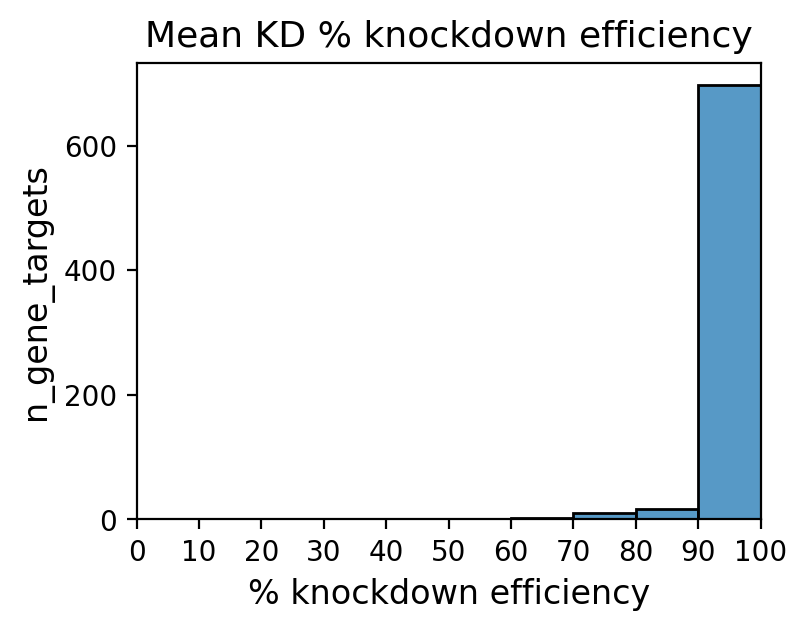

In [73]:
plot_KD_efficiency(adata, group_by="gene_target", title="Mean KD % knockdown efficiency")

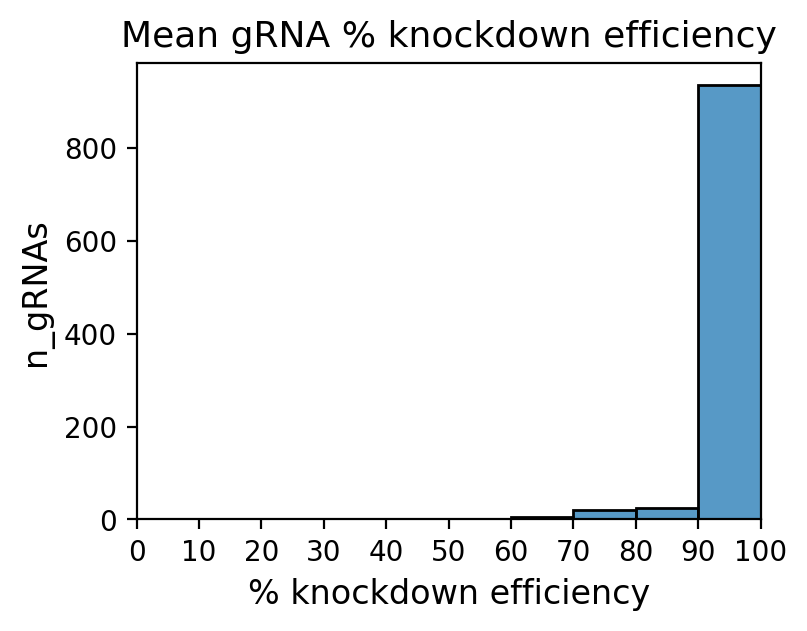

In [76]:
plot_KD_efficiency(adata, group_by="gRNA")

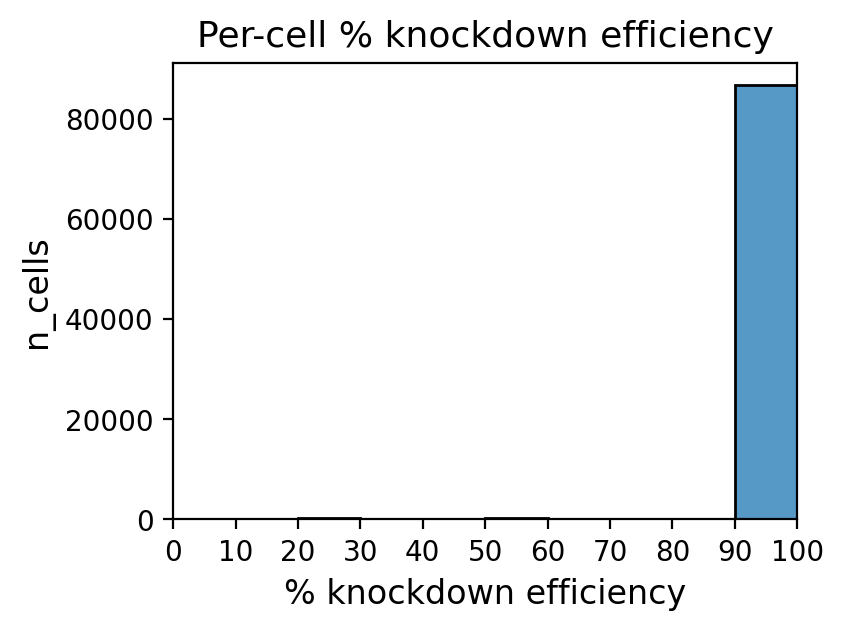

In [77]:
plot_KD_efficiency(adata, group_by="cell")

In [17]:
def find_cells_low_knockdown_efficiency(adata, kd_efficiency_pct_threshold=50):
    adata_kd = adata[adata.obs.perturbed == "True"]
    kd_efficiency = 100 * adata_kd.obs["target_knockdown"].values
    kd_efficiency_df = pd.DataFrame(kd_efficiency, columns=["Cell KD efficiency"], 
                                    index=adata_kd.obs.gRNA.values)
    kd_low_efficiency_df = kd_efficiency_df[kd_efficiency_df['Cell KD efficiency'] < kd_efficiency_pct_threshold]
    print(f"{len(kd_low_efficiency_df)} out of {adata.shape[0]} cells "
          f"have <{kd_efficiency_pct_threshold}% KD efficiency")
    print(f"Number of gRNAs with low KD efficiency cells: {kd_low_efficiency_df.index.nunique()}")
    return kd_efficiency_df

In [18]:
kd_cell_efficiency_df = find_cells_low_knockdown_efficiency(adata, 60)

1082 out of 101923 cells have <60% KD efficiency
Number of gRNAs with low KD efficiency cells: 94


In [4]:
def filter_low_KD_efficiency_cells(adata, kd_efficiency_pct_threshold=60):
    adata_kd = adata[adata.obs.perturbed == "True"]
    kd_efficiency_df = pd.DataFrame((100 * adata_kd.obs["target_knockdown"].values), 
                                    columns=["Cell KD efficiency"], 
                                    index=adata_kd.obs.index)
    kd_low_efficiency_df = \
        kd_efficiency_df[kd_efficiency_df['Cell KD efficiency'] < kd_efficiency_pct_threshold]
    cells_low_efficiency = kd_low_efficiency_df.index.unique().tolist()
    print(f"Removing {len(cells_low_efficiency)} cells with "
          f"<{kd_efficiency_pct_threshold}% knockdown efficiency")
    return adata[~adata.obs.index.isin(cells_low_efficiency)].copy()

def filter_low_cell_count_gRNAs(adata, cell_threshold=25):
    gRNA_value_counts = adata.obs.gRNA.value_counts()
    gRNAs_rm = gRNA_value_counts[gRNA_value_counts < cell_threshold].index.unique().tolist()
    print(f"Removing {len(gRNAs_rm)} gRNAs with <{cell_threshold} cells")
    return adata[~adata.obs.gRNA.isin(gRNAs_rm)].copy()

In [5]:
adata_high_kd_eff = filter_low_KD_efficiency_cells(adata, 60)
adata_high_kd_eff = filter_low_cell_count_gRNAs(adata_high_kd_eff, 25)

Removing 1082 cells with <60% knockdown efficiency
Removing 4 gRNAs with <25 cells


In [6]:
adata_high_kd_eff

AnnData object with n_obs × n_vars = 100759 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [316]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def generate_matched_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                            target_value: str, 
                                            ntc_cell_indices: pd.Index, 
                                            rng: np.random.Generator, 
                                            target_column: str = "perturbation", 
                                            min_cells_per_rep: int = 12,
                                            layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def matched_differential_expression(adata: ad.AnnData,
                                    layer: str = "counts",
                                    min_cells_per_rep: int = 12,
                                    random_state: int = 42,
                                    n_cpus_for_DE: int = 3,
                                    n_jobs_parallel: int = 25,
                                    alpha: float = 0.05,
                                    DE_fit_type: str = "parametric",
                                    target_column: str = "perturbation",
                                    ntc_target_delimiter: str = "NTC",
                                    suppress_warnings: bool = False,
                                    debug: bool = False):
    """
    Perform pseudobulk DE analysis with pseudoreplicates on each 
    gRNA or gene target against a matched number of NTC cells.
    Return dict {target: DE results DF for that target}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_target_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_target_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    
    # Helper function
    def process_perturbation(target: str, rng: np.random.Generator):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_matched_pseudoreplicates_for_DE(
            adata, target, ntc_cell_indices, rng=rng, 
            target_column=target_column, layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # DE analysis
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        quiet = False if debug is True else True
        with handle_warnings(suppress_warnings):
            # Read counts modeling and fitting dispersions
            dds = DeseqDataSet(
                counts = pseudo_bulk_df, 
                metadata = metadata_df,
                refit_cooks=True,
                fit_type=DE_fit_type,
                inference=inference,
                quiet=quiet
                )
            dds.deseq2()
            
            # Statistical testing
            target_hyphenated = target.replace('_', '-')
            contrast = ["condition", target_hyphenated, "NTC"]
            stat_res = DeseqStats(
                dds, 
                contrast=contrast, 
                alpha=alpha,
                inference=inference,
                quiet=quiet)
            stat_res.summary()
            de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        return de_results

    # Run DE analysis on all targets in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        de_results = Parallel(n_jobs=n_jobs_parallel)(
            delayed(process_perturbation)(pert, de_rng) for pert in perturbations)
    results_dict = dict(zip(perturbations, de_results))
    return results_dict

In [317]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [318]:
def test_pvals(DE_results_df, pval_list, target_type="gRNA", pval_delimiter="pvalue", ntc_deg_threshold=3):
    """
    Given a DF of DGE results and a list of p-values, compute the
    number of genes with pval < each pval in the list for each gRNA
    or gene target. Return the mean and median number of DE genes across
    all gRNAs/gene targets.
    """
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    DEGs_df_dict = {f"pval < {pval}":[] for pval in pval_list}
    for pval in pval_list:
        DEGs_arr = np.zeros(len(targets))
        for i, target in enumerate(targets):
            target_pval_col = f"{target}_{pval_delimiter}"
            n_DEGs = len(DE_results_df.loc[DE_results_df[target_pval_col] < pval])
            DEGs_arr[i] = n_DEGs
        DEGs_df_dict[f"pval < {pval}"].append(int(np.mean(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(np.median(DEGs_arr)))
        DEGs_df_dict[f"pval < {pval}"].append(int(len(DEGs_arr[DEGs_arr > ntc_deg_threshold])))
    DEGs_df = pd.DataFrame.from_dict(DEGs_df_dict, orient="index", 
                                     columns=[f"mean DEGs per KD {target_type}", 
                                              f"median DEGs per KD {target_type}",
                                              f"KD {target_type}s with >{ntc_deg_threshold} DEGs"])
    return DEGs_df

In [99]:
def build_n_DEGs_df(DE_results_df, alpha, threshold_type="pvalue", target_type="gRNA"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (threshold_type != "pvalue") & (threshold_type != "padj"):
        raise ValueError("threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}
    targets = list(sorted(list(targets)))
    DEGs_arr = np.zeros(len(targets), dtype=int)
    for i, target in enumerate(targets):
        target_p_col = f"{target}_{threshold_type}"
        n_DEGs = len(DE_results_df.loc[DE_results_df[target_p_col] < alpha])
        DEGs_arr[i] = n_DEGs
    n_DEGs_df = pd.DataFrame(DEGs_arr, index=targets, columns=["n_DEGs"])
    return n_DEGs_df

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_DEGs_per_KD_histogram(n_DEGs_df: pd.DataFrame, n_degs_str: str="n_DEGs",
                               min_n_degs: int=0, title: str="", fig_size: tuple=(4,3), 
                               bin_width=50, xtick_width=100, xmax=None, ymax=None,
                               xlabel="", ylabel="Counts"):
    plt.figure(figsize=fig_size)
    if xmax is None:
        degs_xmax = max(n_DEGs_df[n_degs_str].values)
        xmax = ((degs_xmax // bin_width) + 1) * bin_width
    sns.histplot(n_DEGs_df[n_DEGs_df[n_degs_str] >= min_n_degs][n_degs_str].values, 
                 binwidth=bin_width, binrange=(0,xmax))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(0, xmax)
    if ymax is not None:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title(title, fontsize=13)

In [320]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [52]:
gRNA_kd_eff_de_results_dict = \
    matched_differential_expression(adata_high_kd_eff, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/982 [00:00<?, ?it/s]

In [53]:
gRNA_kd_eff_de_results_df = build_DE_df(gRNA_kd_eff_de_results_dict)
gRNA_kd_eff_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 5892 columns]

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_KD_eff_filt_matched_1-30-26.pkl"
gRNA_kd_eff_de_results_df.to_pickle(filepath_pkl)

In [55]:
pvals = [0.1, 0.075, 0.05, 0.02, 0.01, 0.005]
kd_eff_pvals_degs_df = test_pvals(gRNA_kd_eff_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=4)
kd_eff_pvals_degs_df

mean DEGs per KD gRNA  median DEGs per KD gRNA  \
pval < 0.1                      163                      160   
pval < 0.075                     86                       83   
pval < 0.05                      35                       33   
pval < 0.02                       5                        4   
pval < 0.01                       1                        1   
pval < 0.005                      0                        0   

              KD gRNAs with >4 DEGs  
pval < 0.1                      973  
pval < 0.075                    960  
pval < 0.05                     957  
pval < 0.02                     370  
pval < 0.01                      36  
pval < 0.005                     17

In [56]:
gRNA_kd_eff_n_degs_df = build_n_DEGs_df(gRNA_kd_eff_de_results_df, alpha=0.02, threshold_type="pvalue",
                        target_type="gRNA")
gRNA_kd_eff_n_degs_df.head()

n_DEGs
ADNP2_1      12
ADNP2_2       2
ADNP2_3      15
AHR_2         2
ALX4_2        3

In [57]:
print(f"Mean DEGs: {round(np.mean(gRNA_kd_eff_n_degs_df['n_DEGs']))}")
print(f"Median DEGs: {np.median(gRNA_kd_eff_n_degs_df['n_DEGs'])}")
print(f"{len(gRNA_kd_eff_n_degs_df[gRNA_kd_eff_n_degs_df['n_DEGs'] > 4])} gRNAs have >4 DEGs")

Mean DEGs: 5
Median DEGs: 4.0
370 gRNAs have >4 DEGs


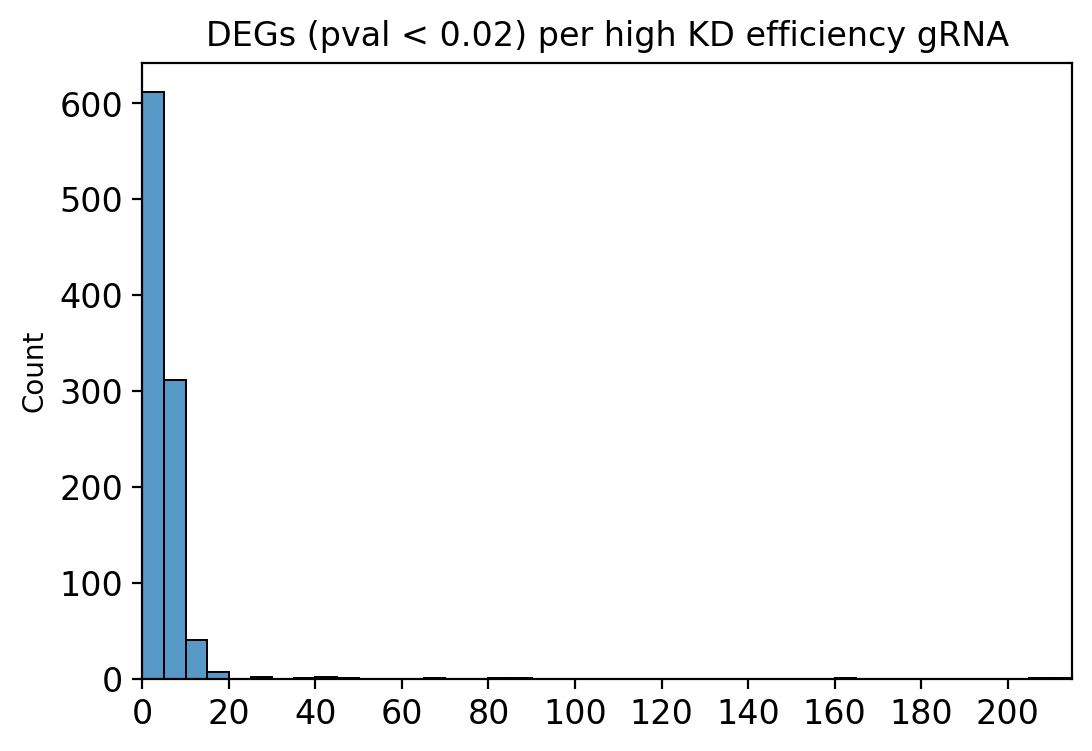

In [120]:
_ = plot_DEGs_per_KD_histogram(gRNA_kd_eff_n_degs_df, title="DEGs (pval < 0.02) per high KD efficiency gRNA", 
                           bin_width=5, xtick_width=20, fig_size=(6,4))

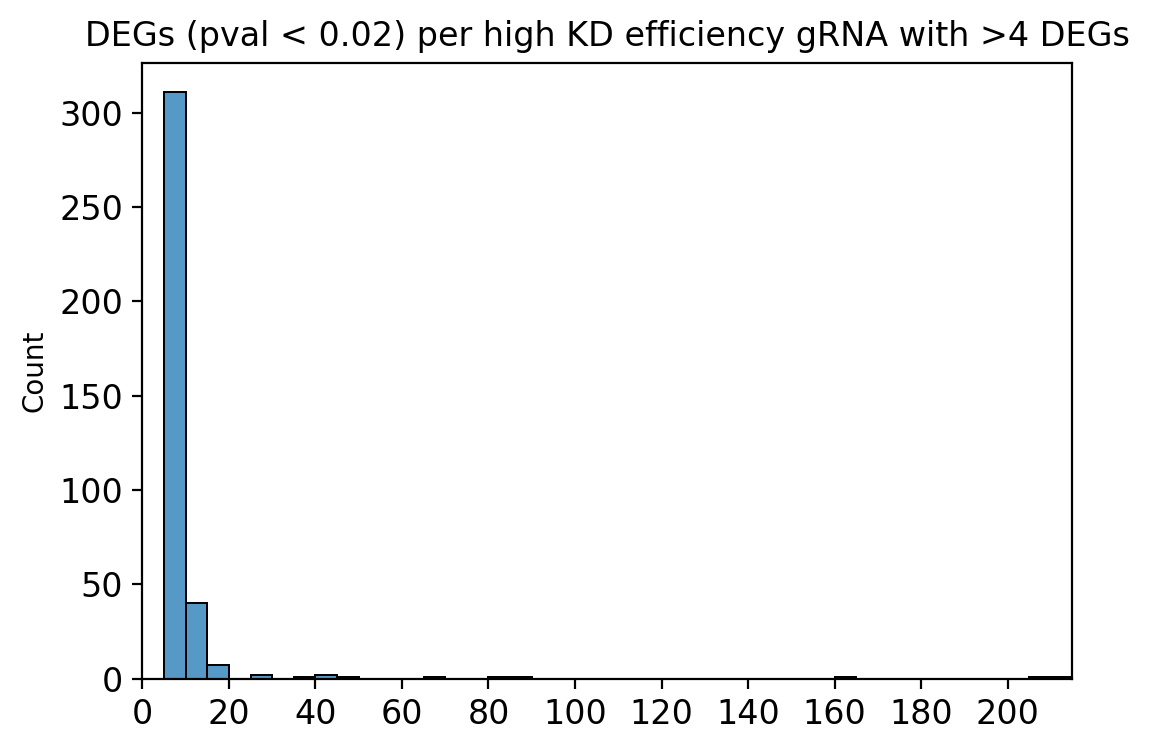

In [121]:
_ = plot_DEGs_per_KD_histogram(gRNA_kd_eff_n_degs_df[gRNA_kd_eff_n_degs_df['n_DEGs'] > 4], 
                           title="DEGs (pval < 0.02) per high KD efficiency gRNA with >4 DEGs", 
                           bin_width=5, xtick_width=20, fig_size=(6,4))

## DE with known TF target genes

In [306]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [54]:
import gseapy as gp
import decoupler as dc

In [ ]:
collectri_df = dc.op.collectri(organism='human')
collectri_df.head()

source target  weight                                          resources  \
0     MYC   TERT     1.0  DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...   
1    SPI1  BGLAP     1.0                                              ExTRI   
2   SMAD3    JUN     1.0                   ExTRI;NTNU.Curated;TFactS;TRRUST   
3   SMAD4    JUN     1.0                   ExTRI;NTNU.Curated;TFactS;TRRUST   
4  STAT5A    IL2     1.0                                              ExTRI   

                                          references       sign_decision  
0  10022128;10491298;10606235;10637317;10723141;1...                PMID  
1                                           10022617  default activation  
2                                  10022869;12374795                PMID  
3                                  10022869;12374795                PMID  
4  10022878;11435608;17182565;17911616;22854263;2...  default activation

In [81]:
dorothea_df = dc.op.dorothea(organism='human', levels=["A"])
dorothea_df.head()

source target  weight confidence
0    MYC   TERT     1.0          A
1  NFKB1   CD83     1.0          A
2  NFKB1   CD80     1.0          A
3  NFKB1   CD69     1.0          A
4  NFKB1   CD58     1.0          A

In [61]:
def build_known_tf_n_targets_df(adata, sources=["CollecTRI", "DoRothEA"], 
                                dorothea_levels=["A", "B"], histogram=True,
                                fig_size: tuple=(4,3),
                                title: str="", bin_width: int=25, 
                                xtick_width: int=50, xmax=None, ymax=None):
    all_tf_kds = set(adata.obs.gene_target.unique().tolist())
    all_dfs = list()
    if "CollecTRI" in sources:
        collectri_df = dc.op.collectri(organism='human')
        collectri_df = collectri_df[collectri_df["source"].isin(all_tf_kds)]
        collectri_df = collectri_df[["source", "target"]]
        all_dfs.append(collectri_df)
    if "DoRothEA" in sources:
        dorothea_df = dc.op.dorothea(organism='human', levels=dorothea_levels)
        dorothea_df = dorothea_df[dorothea_df["source"].isin(all_tf_kds)]
        dorothea_df = dorothea_df[["source", "target"]]
        all_dfs.append(dorothea_df)
    if len(all_dfs) > 1:
        final_tf_target_df = pd.concat(all_dfs)
        final_tf_target_df.drop_duplicates(inplace=True)
    else:
        final_tf_target_df = all_dfs[0]
    targets_per_tf_df = final_tf_target_df["source"].value_counts()
    
    if histogram:
        plt.figure(figsize=fig_size)
        if xmax is None:
            xmax = ((max(targets_per_tf_df) // bin_width) + 1) * bin_width
        sns.histplot(targets_per_tf_df, binwidth=bin_width, binrange=(0, xmax))
        plt.xlim(0, xmax)
        if ymax is not None:
            plt.ylim(0, ymax)
        plt.xlabel("n_target_genes")
        plt.ylabel("n_tfs")
        plt.xticks(np.arange(0, xmax, xtick_width), fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(False)
        plt.title(title)
        plt.show()

    return targets_per_tf_df

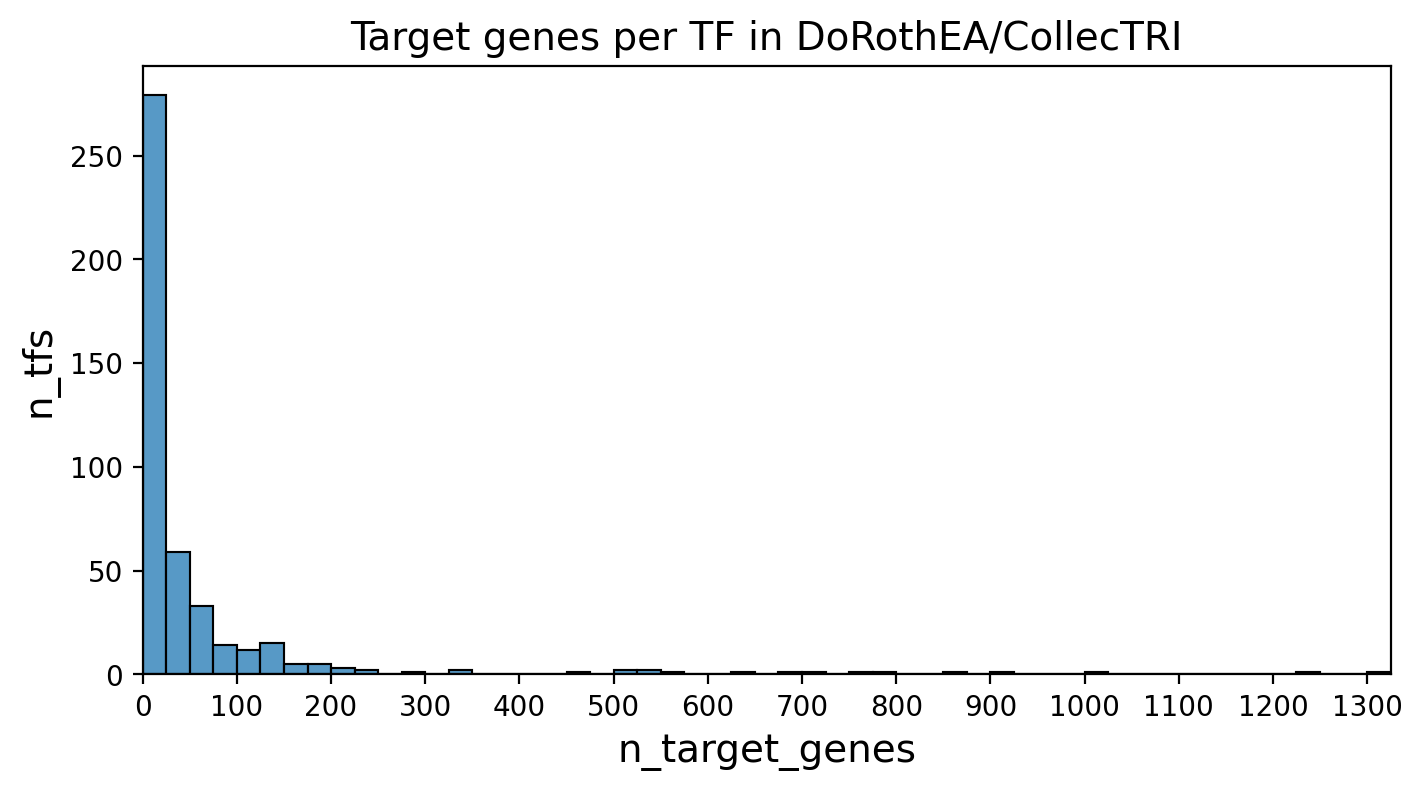

In [62]:
targets_df = build_known_tf_n_targets_df(adata, sources=["CollecTRI", "DoRothEA"],
                                    dorothea_levels=["A", "B"], title="Target genes per TF in DoRothEA/CollecTRI",
                                    bin_width=25, xtick_width=100, fig_size=(8,4))

In [57]:
targets_df

source
SP1       1321
TP53      1243
ESR1      1013
MYC        905
STAT1      864
          ... 
RFX6         1
DPF3         1
ZNF711       1
TET2         1
IKZF5        1
Name: count, Length: 446, dtype: int64

In [60]:
tf_targets_df = pd.DataFrame(targets_df.values, columns=["n_target_genes"], index=targets_df.index)
tf_targets_df.index.name = None
tf_targets_df.sort_index(inplace=True)
tf_targets_df

n_target_genes
ADNP2                  1
AHR                  197
ALX4                   1
ARHGAP35               4
ARID3B                 6
...                  ...
ZNF79                  1
ZNF804A               10
ZSCAN18                1
ZSCAN21                1
ZXDC                   6

[446 rows x 1 columns]

In [310]:
max(targets_df)

1321

In [311]:
print(len(targets_df[targets_df<25]))
print(len(targets_df[(targets_df>=25) & (targets_df<100)]))
print(len(targets_df[targets_df>100]))

279
106
61


In [58]:
def filter_known_tfs_target_genes(adata, sources=["CollecTRI", "DoRothEA"], 
                                  dorothea_levels=["A", "B"]):
    adata = adata.copy()
    all_tf_kds = set(adata.obs.gene_target.unique().tolist())
    tfs_with_target_genes = set()
    tf_target_genes = set()
    if "CollecTRI" in sources:
        collectri_df = dc.op.collectri(organism='human')
        collectri_df = collectri_df[collectri_df["source"].isin(all_tf_kds)]
        tfs_with_target_genes.update(set(collectri_df["source"].unique().tolist()))
        tf_target_genes.update(set(collectri_df["target"].unique().tolist()))
    if "DoRothEA" in sources:
        dorothea_df = dc.op.dorothea(organism='human', levels=dorothea_levels)
        dorothea_df = dorothea_df[dorothea_df["source"].isin(all_tf_kds)]
        tfs_with_target_genes.update(set(dorothea_df["source"].unique().tolist()))
        tf_target_genes.update(set(dorothea_df["target"].unique().tolist()))
    tf_target_genes_in_dataset = tf_target_genes & set(adata.var_names)
    print(f"Dataset contains {len(tfs_with_target_genes)} TF KDs with "
          f"{len(tf_target_genes_in_dataset)} known target genes")
    adata = adata[(adata.obs.gene_target.isin(tfs_with_target_genes)) |
                  (adata.obs.perturbed == "False")]
    return adata.copy()

In [312]:
adata_tfs_with_targets = \
    filter_known_tfs_target_genes(adata, sources=["CollecTRI", "DoRothEA"], dorothea_levels=["A", "B"])

Dataset contains 446 TF KDs with 5388 known target genes


In [313]:
adata_tfs_with_targets

AnnData object with n_obs × n_vars = 67329 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [314]:
adata_tfs_with_targets[adata_tfs_with_targets.obs.perturbed == "True"].obs.gRNA.nunique()

605

In [322]:
ntc_bench_tfs_with_targets_res_dict = \
    ntc_benchmarking_matched_DE(adata_tfs_with_targets, n_cpus_for_DE=4, n_jobs_parallel=10, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

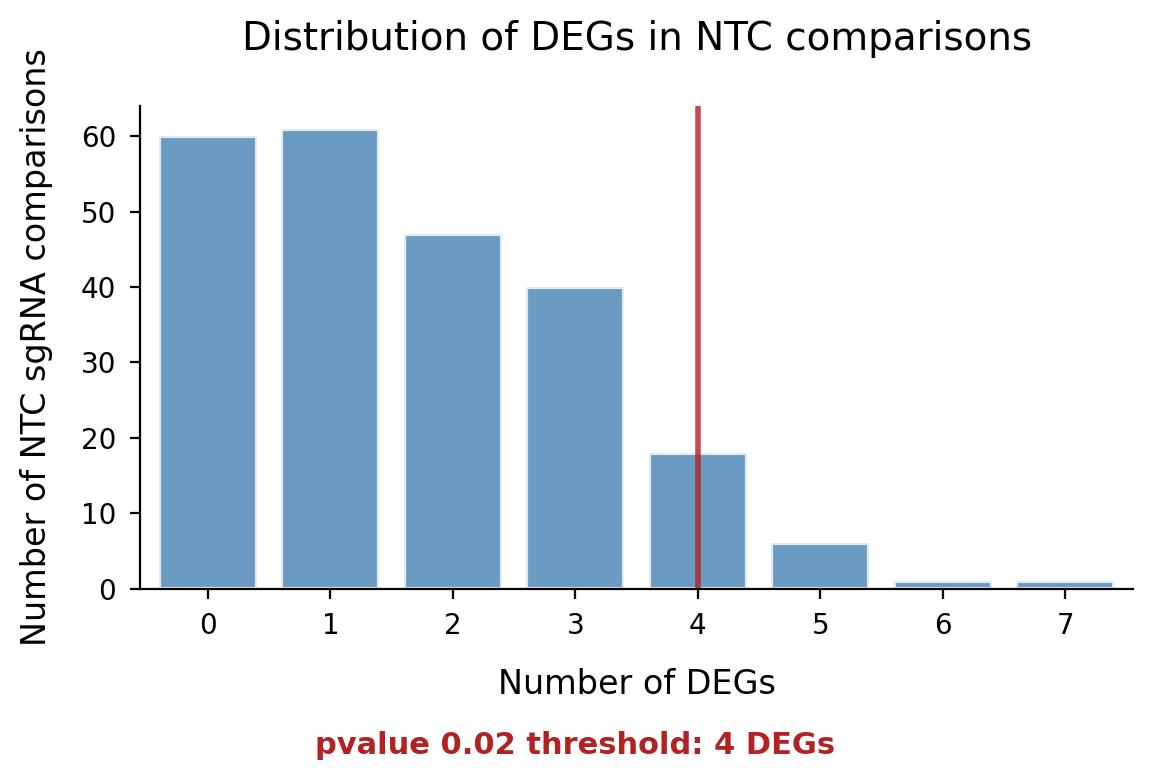

NTC Benchmark Statistics:
  • pvalue 0.02 threshold: 4 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 1.7
  • Median DEGs per comparison: 1.0
  • 95% of comparisons have < 4 DEGs


In [323]:
deg_threshold_02_95, ntc_benchmark_res_02_95 = \
    report_ntc_benchmarking_results(ntc_bench_tfs_with_targets_res_dict, alpha=0.02, 
                                    threshold_type="pvalue", percentile=95)

In [325]:
gRNA_tfs_with_targets_de_results_dict = \
    matched_differential_expression(adata_tfs_with_targets, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=4, n_jobs_parallel=10)

Running DE analysis:   0%|          | 0/605 [00:00<?, ?it/s]

In [326]:
gRNA_tfs_with_targets_de_results_df = build_DE_df(gRNA_tfs_with_targets_de_results_dict)
gRNA_tfs_with_targets_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 3630 columns]

In [327]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_matched_gRNA_tfs_with_targets_2-3-26.pkl"
gRNA_tfs_with_targets_de_results_df.to_pickle(filepath_pkl)

In [51]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_matched_gRNA_tfs_with_targets_2-3-26.pkl"
gRNA_tfs_with_targets_de_results_df = pd.read_pickle(filepath_pkl)
gRNA_tfs_with_targets_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 3630 columns]

In [328]:
pvals = [0.1, 0.05, 0.02, 0.01]
pvals_degs_df = test_pvals(gRNA_tfs_with_targets_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=4)
pvals_degs_df

mean DEGs per KD gRNA  median DEGs per KD gRNA  \
pval < 0.1                     166                      162   
pval < 0.05                     35                       33   
pval < 0.02                      5                        4   
pval < 0.01                      1                        1   

             KD gRNAs with >4 DEGs  
pval < 0.1                     600  
pval < 0.05                    595  
pval < 0.02                    230  
pval < 0.01                     25

In [52]:
gRNA_tfs_with_targets_n_degs_df = build_n_DEGs_df(gRNA_tfs_with_targets_de_results_df, alpha=0.02, 
                                              threshold_type="pvalue", target_type="gRNA")
gRNA_tfs_with_targets_n_degs_df.sort_index(inplace=True)
gRNA_tfs_with_targets_n_degs_df.head()

n_DEGs
ADNP2_1       6
ADNP2_2       8
ADNP2_3      15
AHR_2         2
ALX4_2        3

In [63]:
tf_targets_df.head()

n_target_genes
ADNP2                  1
AHR                  197
ALX4                   1
ARHGAP35               4
ARID3B                 6

In [64]:
def build_n_DEGs_n_target_genes_df(gRNA_n_DEGs_df, tf_n_target_genes_df):
    gRNA_n_DEGs_target_genes_df = gRNA_n_DEGs_df.copy()
    gRNA_n_target_genes = list()
    for gRNA, _ in gRNA_n_DEGs_df.itertuples():
        tf = gRNA.split("_")[0]
        tf_n_target_genes = tf_n_target_genes_df[tf_n_target_genes_df.index == tf].values[0][0]
        gRNA_n_target_genes.append(tf_n_target_genes)
    gRNA_n_DEGs_target_genes_df["n_target_genes"] = gRNA_n_target_genes
    return gRNA_n_DEGs_target_genes_df

In [67]:
gRNA_n_degs_targets_df = \
    build_n_DEGs_n_target_genes_df(gRNA_tfs_with_targets_n_degs_df, tf_targets_df)

In [68]:
gRNA_n_degs_targets_df.head()

n_DEGs  n_target_genes
ADNP2_1       6               1
ADNP2_2       8               1
ADNP2_3      15               1
AHR_2         2             197
ALX4_2        3               1

In [70]:
gRNA_n_degs_targets_df.sort_values(by="n_DEGs", ascending=False).head(15)

n_DEGs  n_target_genes
POU5F1_3      154              96
PHF20_1       140              11
POU3F2_2       85              30
ZNF521_1       81               3
POU5F1_2       49              96
POU5F1_1       49              96
NANOG_2        47              61
DNMT1_2        36             187
DNMT1_3        31             187
DNMT1_1        29             187
SALL4_1        20              21
PRDM14_1       19             194
NANOGP8_1      17               4
REST_1         17              75
THAP12_2       17               1

In [342]:
def plot_n_target_genes_vs_DEGs(gRNA_n_DEGs_target_genes_df,
                                title="gRNA # DEGs vs. # TF target genes",
                                fig_size=(6,4), ymax=None):
    plt.figure(figsize=fig_size)
    sns.scatterplot(data=gRNA_n_DEGs_target_genes_df, x="n_target_genes", y="n_DEGs",
                    s=15)
    if ymax:
        plt.ylim(0, ymax)
    plt.title(title)

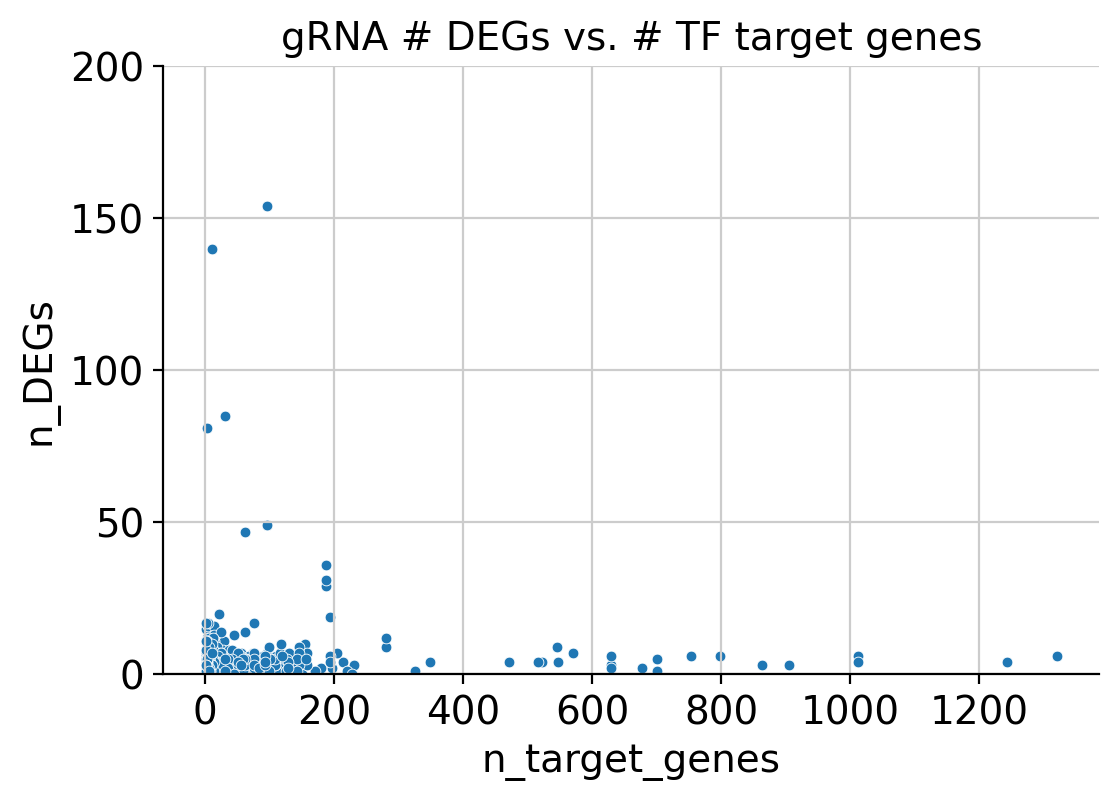

In [343]:
plot_n_target_genes_vs_DEGs(gRNA_n_degs_targets_df, ymax=200)

In [344]:
gRNA_tfs_with_targets_n_degs_df.sort_values(by="n_DEGs", ascending=False).head(10)

n_DEGs
POU5F1_3     154
PHF20_1      140
POU3F2_2      85
ZNF521_1      81
POU5F1_2      49
POU5F1_1      49
NANOG_2       47
DNMT1_2       36
DNMT1_3       31
DNMT1_1       29

In [345]:
print(f"Mean DEGs: {round(np.mean(gRNA_tfs_with_targets_n_degs_df['n_DEGs']))}")
print(f"Median DEGs: {np.median(gRNA_tfs_with_targets_n_degs_df['n_DEGs'])}")
print(f"{len(gRNA_tfs_with_targets_n_degs_df[gRNA_tfs_with_targets_n_degs_df['n_DEGs'] > 4])} gRNAs have >4 DEGs")

Mean DEGs: 5
Median DEGs: 4.0
230 gRNAs have >4 DEGs


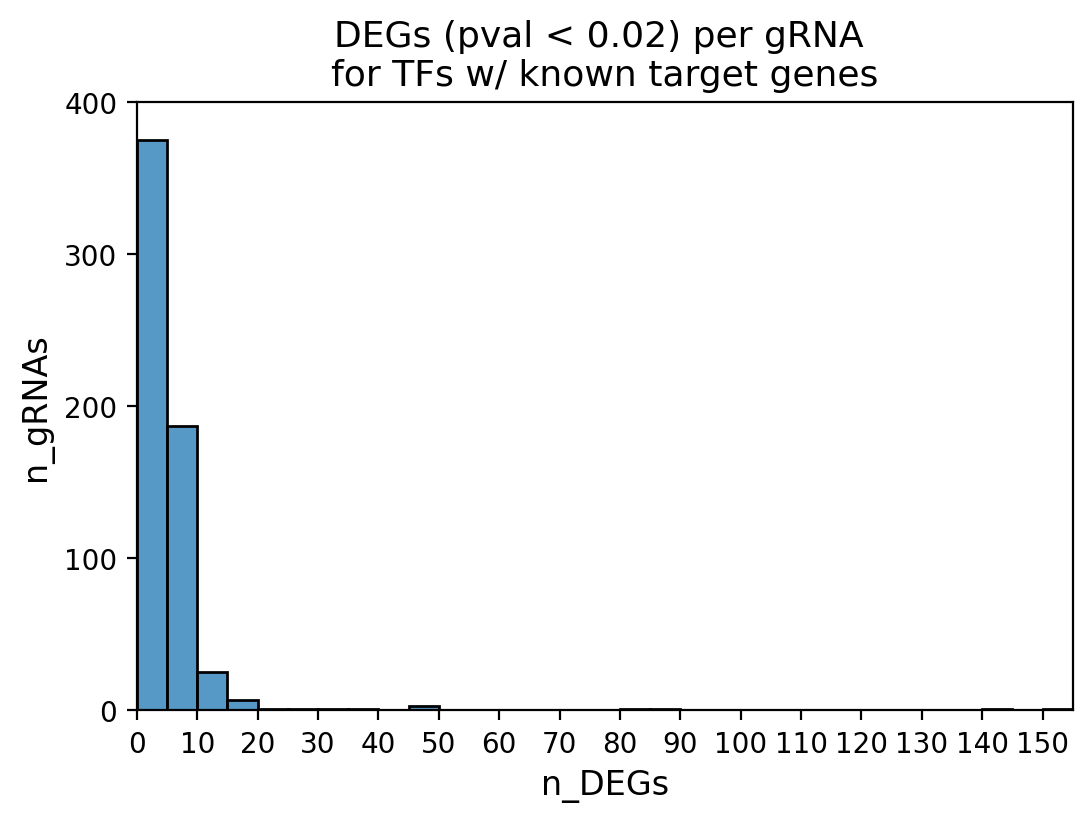

In [66]:
_ = plot_DEGs_per_KD_histogram(gRNA_tfs_with_targets_n_degs_df, title="DEGs (pval < 0.02) per gRNA \nfor TFs w/ known target genes", 
                           bin_width=5, xtick_width=10, fig_size=(6,4), ymax=400, xlabel="n_DEGs", ylabel="n_gRNAs")

## UMI counts

In [7]:
import numpy as np
import pandas as pd

In [8]:
adata_high_kd_eff

AnnData object with n_obs × n_vars = 100759 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [12]:
mean_kd_umi = round(adata_high_kd_eff[adata_high_kd_eff.obs.perturbed == "True"].obs.n_UMI_counts.mean())
mean_ntc_umi = round(adata_high_kd_eff[adata_high_kd_eff.obs.perturbed == "False"].obs.n_UMI_counts.mean())
mean_umi = round(adata_high_kd_eff.obs.n_UMI_counts.mean())

median_kd_umi = round(adata_high_kd_eff[adata_high_kd_eff.obs.perturbed == "True"].obs.n_UMI_counts.median())
median_ntc_umi = round(adata_high_kd_eff[adata_high_kd_eff.obs.perturbed == "False"].obs.n_UMI_counts.median())
median_umi = round(adata_high_kd_eff.obs.n_UMI_counts.median())

In [13]:
umi_dict = {"Mean":[mean_kd_umi, mean_ntc_umi, mean_umi], "Median": [median_kd_umi, median_ntc_umi, median_umi]}
umi_df = pd.DataFrame(umi_dict, index=["KD cell UMI", "NTC cell UMI", "All cells UMI"])

In [14]:
umi_df

Mean  Median
KD cell UMI    5901    5399
NTC cell UMI   5242    4788
All cells UMI  5811    5310

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def plot_umis(adata, subset="all", title="UMI counts (all cells)", 
              figsize=(4,3), bin_width=500, xtick_width=1000, xmax=None,
              ymax=None):
    if subset.lower() == "kd":
        adata = adata[adata.obs.perturbed == "True"]
    elif subset.lower() == "ntc":
        adata = adata[adata.obs.perturbed == "False"]
    umi_counts = adata.obs.n_UMI_counts
    if xmax is None:
        xmax = ((max(umi_counts) // bin_width) + 1) * bin_width
    plt.figure(figsize=figsize)
    sns.histplot(umi_counts, binwidth=bin_width, binrange=(0, xmax))
    plt.xlim(0, xmax)
    if ymax:
        plt.ylim(0, ymax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=10, rotation=60)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title(title)
    plt.show()

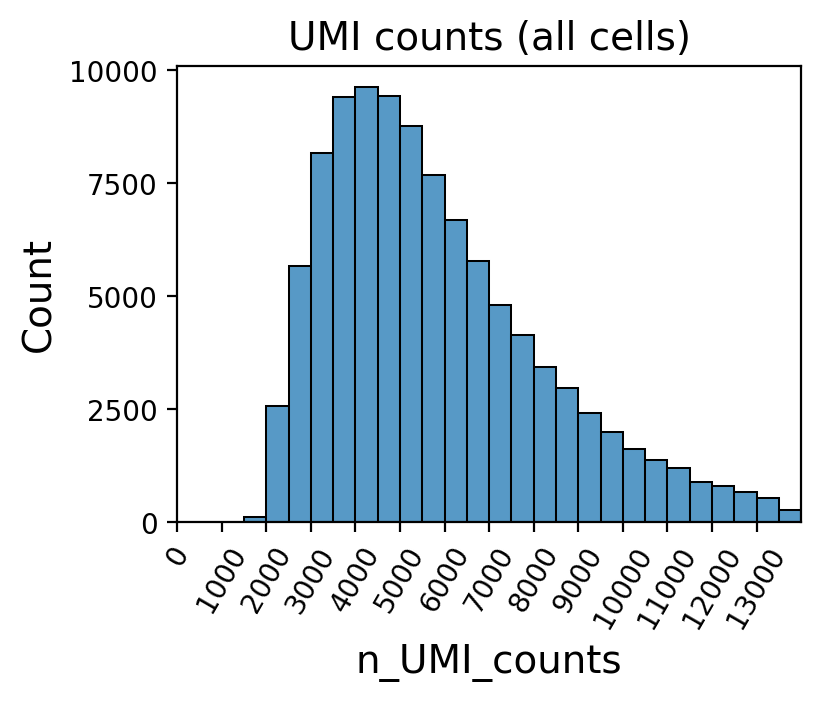

In [78]:
plot_umis(adata_high_kd_eff)

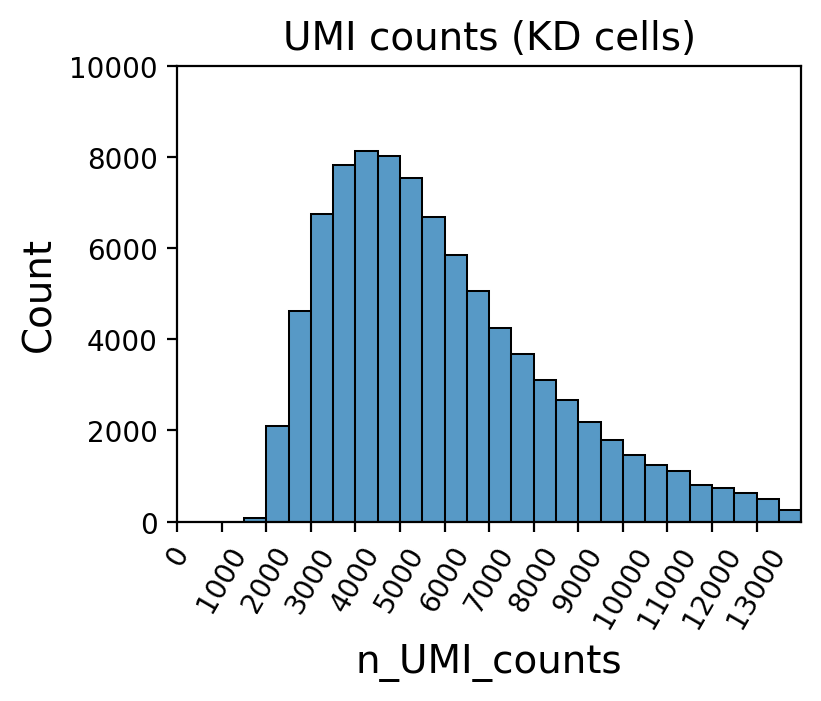

In [38]:
plot_umis(adata_high_kd_eff, subset="KD", title="UMI counts (KD cells)", ymax=10000)

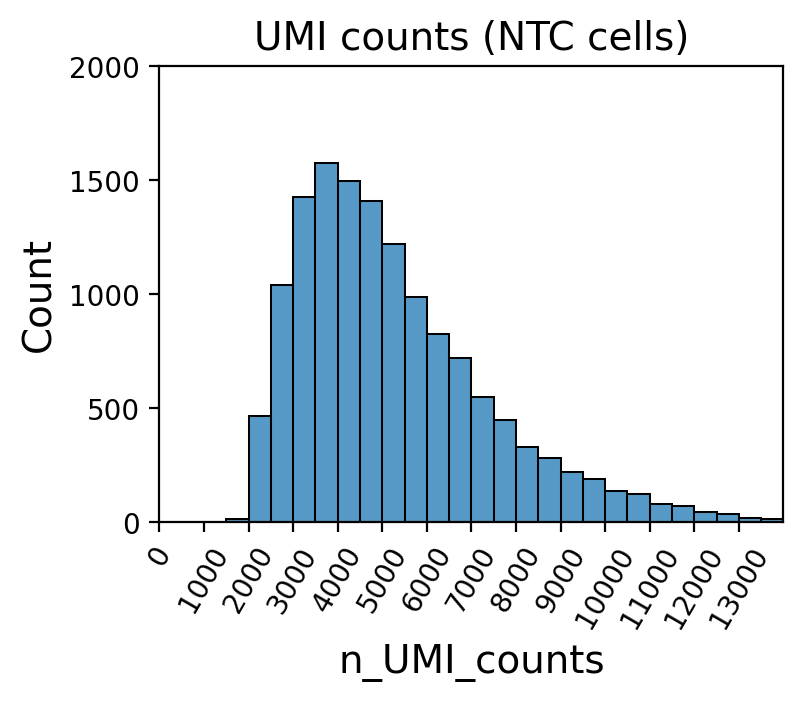

In [ ]:
plot_umis(adata_high_kd_eff, subset="NTC", title="UMI counts (NTC cells)", ymax=1500)

## Checking expression of KD genes in NTC and KD conditions

In [18]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [20]:
import scanpy as sc

def compute_mean_tf_kd_expression(adata, kd_or_ntc="KD", log1p=True):
    """
    For each non-NTC gene target, compute the mean CPM-normalized 
    (optionally log1p-transformed) expression of that gene target 
    in all cells where that gene target was knocked down (if 
    kd_or_ntc='KD') or in all NTC cells (if kd_or_ntc='NTC').
    """
    adata = adata.copy()
    if "counts" in adata.layers:
        adata.X = adata.layers["counts"]
    sc.pp.normalize_total(adata, target_sum=1e6)
    if log1p:
        sc.pp.log1p(adata)

    gene_targets = adata.obs.gene_target.unique().tolist()
    gene_targets = [g for g in gene_targets if g != "NTC"]
    adata = adata[:, gene_targets]
    expr_matrix = adata.X.copy()
    if sparse.issparse(expr_matrix):
        expr_matrix = expr_matrix.toarray()

    if kd_or_ntc.lower() == "kd":
        pert_mask = adata.obs.perturbed == "True"
    elif kd_or_ntc.lower() == "ntc":
        pert_mask = adata.obs.perturbed == "False"
    else:
        raise ValueError("kd_or_ntc must be 'KD' or 'NTC'")

    expr_arr = np.empty(len(gene_targets))
    for i, gene in enumerate(gene_targets):
        gene_idx = adata.var.index.get_loc(gene)
        if kd_or_ntc.lower() == "kd":
            cell_mask = pert_mask & (adata.obs.gene_target == gene)
            expr_arr[i] = expr_matrix[cell_mask, gene_idx].mean()
        else:
            expr_arr[i] = expr_matrix[pert_mask, gene_idx].mean()
    df_columns = ["expression_cpm_log1p"] if log1p else ["expression_cpm"]
    expr_df = pd.DataFrame(expr_arr, columns=df_columns,
                          index=gene_targets)
    return expr_df

def plot_tf_kd_expression(expr_df, title="", xlabel="", ylabel="",
                          fig_size=(6,4), bin_width=0.1, color="cornflowerblue"):
    plt.figure(figsize=fig_size)
    sns.histplot(data=expr_df, x=expr_df.columns[0], binwidth=bin_width, 
                 legend=False, color=color)
    sns.despine(fig=None, ax=None, top=False, right=False, left=False, 
                bottom=False, offset=None, trim=False)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title(title, fontsize=13)
    plt.show()

In [27]:
ntc_expr_cpm_log1p_df = compute_mean_tf_kd_expression(adata, "NTC")

normalizing counts per cell
    finished (0:00:00)


In [94]:
ntc_expr_cpm_log1p_df.columns[0]

'expression_cpm_log1p'

In [28]:
ntc_expr_cpm_log1p_df.head()

expression_cpm_log1p
ESR2                0.259297
ZNF14               0.212732
JRKL                0.152719
TWIST1              0.005818
GATA6               0.000394

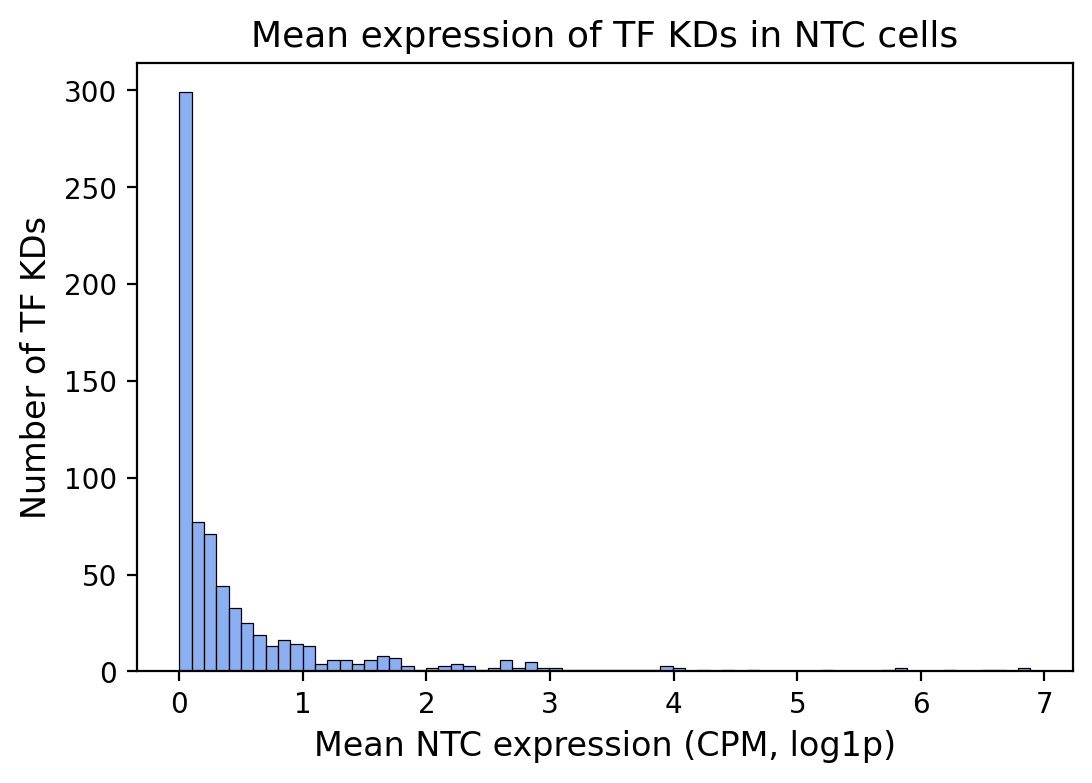

In [101]:
plot_tf_kd_expression(ntc_expr_cpm_log1p_df, title="Mean expression of TF KDs in NTC cells", 
                      xlabel="Mean NTC expression (CPM, log1p)", 
                      ylabel="Number of TF KDs")

In [21]:
ntc_expr_cpm_df = compute_mean_tf_kd_expression(adata, "NTC", log1p=False)

normalizing counts per cell
    finished (0:00:00)


In [22]:
ntc_expr_cpm_df.head()

expression_cpm
ESR2          9.953790
ZNF14         7.956152
JRKL          5.940504
TWIST1        0.226578
GATA6         0.015895

In [34]:
len(ntc_expr_cpm_df[ntc_expr_cpm_df["expression_cpm"] < 1])

210

In [ ]:
tfs_to_check = ["POU5F1", "NANOG", "SOX2", "POU5F1B", "POU3F2", "PHF20", "DNMT1", "ZNF521", "ZNF396"]
ntc_expr_cpm_df[ntc_expr_cpm_df.index.isin(tfs_to_check)]

expression_cpm
PHF20        147.172913
DNMT1        135.059692
POU5F1       916.120239
NANOG         45.651848
ZNF396         0.533110
POU5F1B       33.738491
POU3F2         0.367662
SOX2         213.642609
ZNF521        44.539257

KD expression

In [22]:
kd_expr_cpm_log1p_df = compute_mean_tf_kd_expression(adata, "KD")

normalizing counts per cell
    finished (0:00:00)


In [23]:
kd_expr_cpm_log1p_df.head()

expression_cpm_log1p
ESR2                     0.0
ZNF14                    0.0
JRKL                     0.0
TWIST1                   0.0
GATA6                    0.0

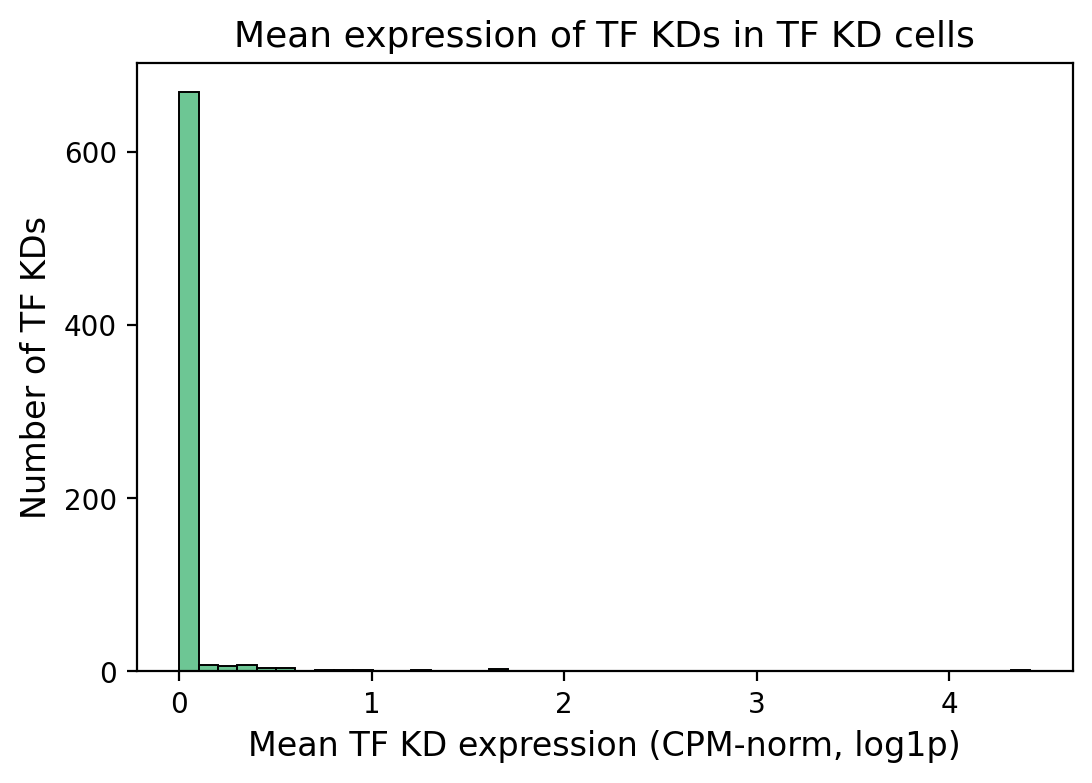

In [103]:
_ = plot_tf_kd_expression(kd_expr_cpm_log1p_df, title="Mean expression of TF KDs in TF KD cells", 
                      xlabel="Mean TF KD expression (CPM-norm, log1p)", 
                      ylabel="Number of TF KDs", color="mediumseagreen")

See if KDs with low NTC expression correlate to perturbing gRNAs with low DEG counts

In [15]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gRNA_full_matched_1-23-26.pkl"
full_dataset_de_results_df = pd.read_pickle(filepath_pkl)
full_dataset_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 5916 columns]

In [16]:
full_n_degs_df = build_n_DEGs_df(full_dataset_de_results_df, alpha=0.02, threshold_type="pvalue",
                        target_type="gRNA")
full_n_degs_df.head()

n_DEGs
ADNP2_1       6
ADNP2_2       8
ADNP2_3      15
AHR_2         2
ALX4_2        3

In [40]:
grnas_low_degs = set(full_n_degs_df[full_n_degs_df["n_DEGs"] <= 4].index.tolist())
print(f"{len(grnas_low_degs)} gRNAs with ≤4 DEGs")
gene_targets_low_degs = {g.split("_")[0] for g in grnas_low_degs}
print(f"{len(gene_targets_low_degs)} gene targets with ≤4 DEGs")

603 gRNAs with ≤4 DEGs
511 gene targets with ≤4 DEGs


In [38]:
gene_targets_low_expr = \
    set(ntc_expr_cpm_df[ntc_expr_cpm_df["expression_cpm"] < 1].index.tolist())
print(f"{len(gene_targets_low_expr)} gene targets with NTC expression (CPM) < 1")

210 gene targets with NTC expression (CPM) < 1


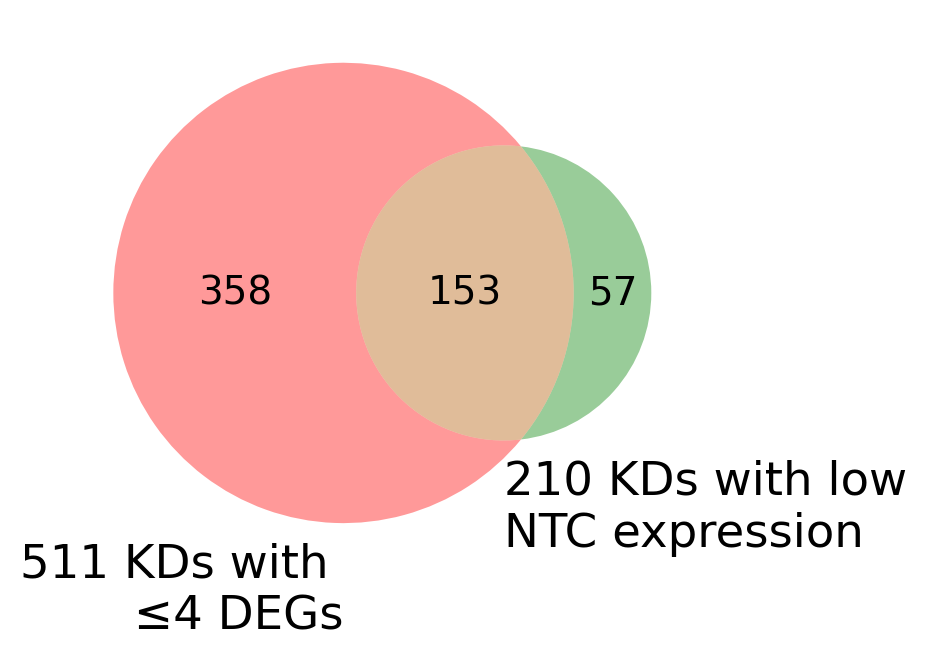

In [39]:
from matplotlib_venn import venn2
_ = venn2((gene_targets_low_degs, gene_targets_low_expr), 
          set_labels=("511 KDs with \n≤4 DEGs", "210 KDs with low\nNTC expression"))

In [17]:
grnas_lt_10_degs = set(full_n_degs_df[full_n_degs_df["n_DEGs"] < 10].index.tolist())
print(f"{len(grnas_lt_10_degs)} gRNAs with <10 DEGs")
gene_targets_lt_10_degs = {g.split("_")[0] for g in grnas_lt_10_degs}
print(f"{len(gene_targets_lt_10_degs)} gene targets with <10 DEGs")

923 gRNAs with <10 DEGs
698 gene targets with <10 DEGs


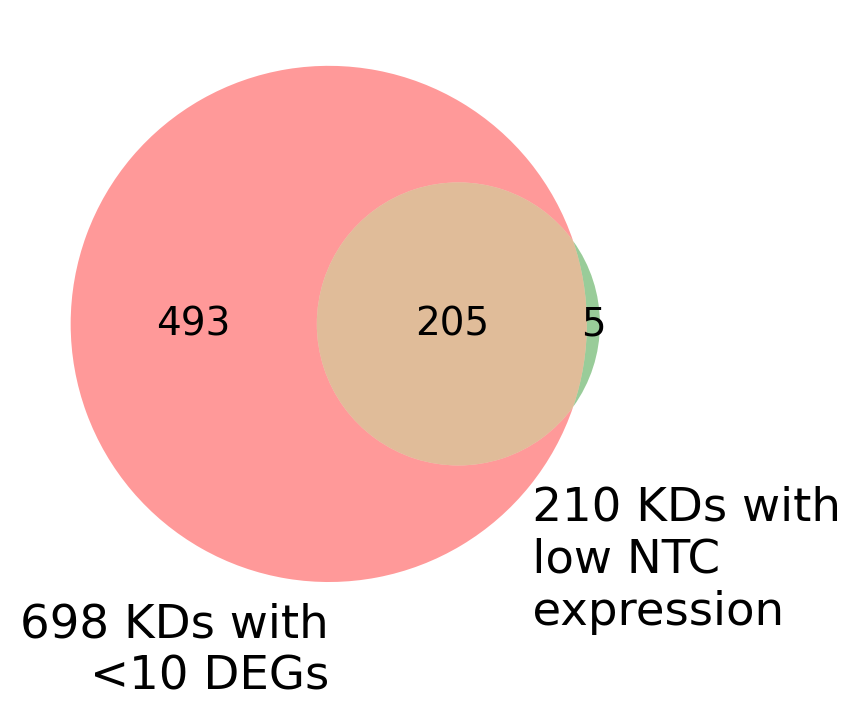

In [42]:
_ = venn2((gene_targets_lt_10_degs, gene_targets_low_expr), 
          set_labels=("698 KDs with\n<10 DEGs", "     210 KDs with\n     low NTC\n     expression"))

Filtering out KDs with NTC CPM expression < 1

In [43]:
ntc_expr_cpm_df.head()

expression_cpm
ESR2          9.953790
ZNF14         7.956152
JRKL          5.940504
TWIST1        0.226578
GATA6         0.015895

In [23]:
kds_to_rm = ntc_expr_cpm_df[ntc_expr_cpm_df["expression_cpm"] < 1].index.tolist()
adata_kds_filt = adata[~adata.obs.gene_target.isin(kds_to_rm)]

In [24]:
print(f"Before filtering: {adata.obs.gene_target.nunique()-1} gene targets with "
      f"{adata[adata.obs.perturbed == 'True'].obs.gRNA.nunique()} corresponding gRNAs")
print(f"Removed {len(kds_to_rm)} gene targets")
print(f"{adata_kds_filt.obs.gene_target.nunique() - 1} gene targets remaining")
print(f"{adata_kds_filt[adata_kds_filt.obs.perturbed == 'True'].obs.gRNA.nunique()} gRNAs remaining")

Before filtering: 726 gene targets with 986 corresponding gRNAs
Removed 210 gene targets
516 gene targets remaining
694 gRNAs remaining


In [25]:
adata_kds_filt

View of AnnData object with n_obs × n_vars = 74532 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

NTC benchmarking

In [47]:
ntc_bench_kds_filt_res_dict = \
    ntc_benchmarking_matched_DE(adata_kds_filt, n_cpus_for_DE=3, n_jobs_parallel=20, 
                                DE_fit_type="mean", min_cells_per_rep=12, random_state=42,
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

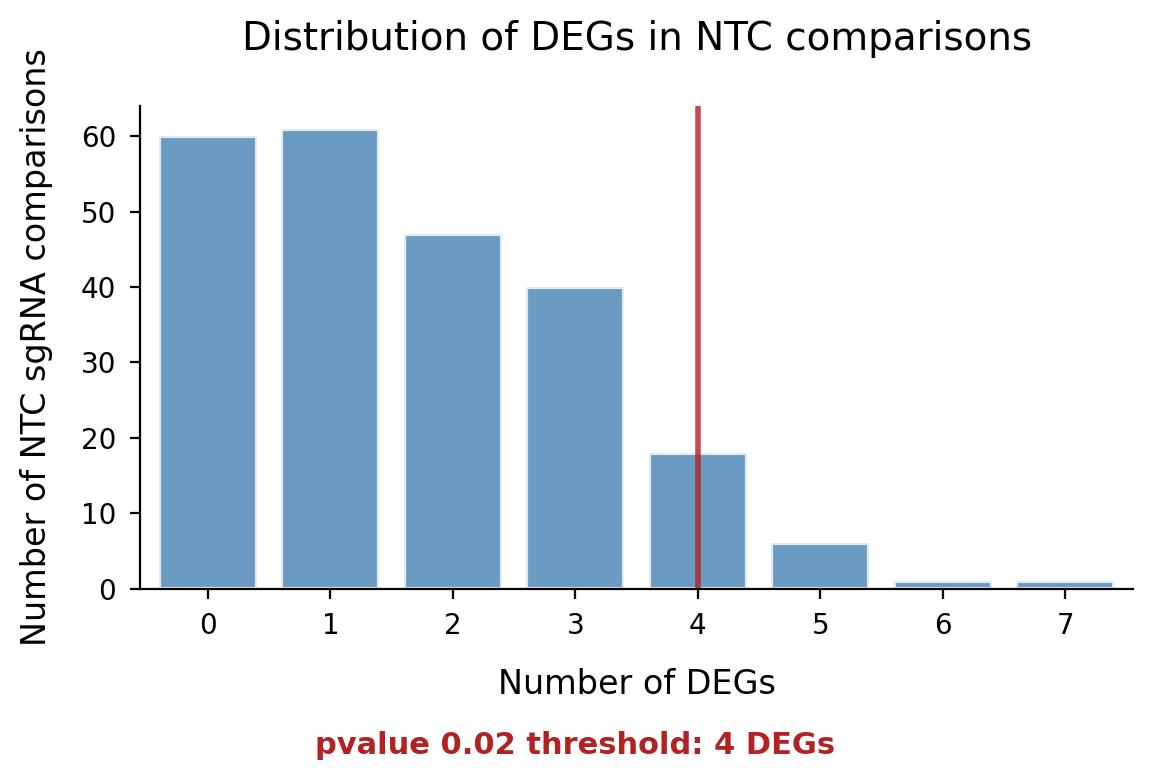

NTC Benchmark Statistics:
  • pvalue 0.02 threshold: 4 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 1.7
  • Median DEGs per comparison: 1.0
  • 95% of comparisons have < 4 DEGs


In [48]:
deg_threshold_02_95, ntc_benchmark_res_02_95 = \
    report_ntc_benchmarking_results(ntc_bench_kds_filt_res_dict, alpha=0.02, 
                                    threshold_type="pvalue", percentile=95)

In [49]:
gRNA_kds_filt_de_results_dict = \
    matched_differential_expression(adata_kds_filt, DE_fit_type="mean", target_column="perturbation", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/694 [00:00<?, ?it/s]

In [83]:
gRNA_kds_filt_de_results_df = build_DE_df(gRNA_kds_filt_de_results_dict)
gRNA_kds_filt_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 4164 columns]

In [84]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_matched_gRNA_kd_ntc_expr_filt_2-4-26.pkl"
gRNA_kds_filt_de_results_df.to_pickle(filepath_pkl)

In [10]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_matched_gRNA_kd_ntc_expr_filt_2-4-26.pkl"
gRNA_kds_filt_de_results_df = pd.read_pickle(filepath_pkl)
gRNA_kds_filt_de_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              6.810465               0.656336      0.619966     1.058665   
A1BG-AS1          1.007299              -1.206388      1.503618    -0.802323   
A2M               1.445779               0.802093      1.204797     0.665749   
A2ML1             3.125279              -0.356706      0.855024    -0.417188   
A2ML1-AS1        12.835356              -0.274602      0.487399    -0.563402   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.289752     0.999872          1.864257   
A1BG-AS1        0.422366     0.999872          0.373367   
A2M             0.505571     0.999872          0.512672   
A2ML1           0.676541     0.999872          0.891141   
A2ML1-AS1       0.573161     0.999872          2.926793   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.735923       1.183907      0.621605  ...   
A1BG-AS1                -2.185059       2.632794     -0.829939  ...   
A2M                     -1.215384       2.016206     -0.602808  ...   
A2ML1                   -0.921585       1.899375     -0.485204  ...   
A2ML1-AS1                0.183335       1.204626      0.152192  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.289011      0.156928        0.875302      0.998861   
A1BG-AS1        2.663477      0.596046        0.551144      0.998861   
A2M             1.755692      1.117027        0.263983      0.998861   
A2ML1           2.045348      0.305428        0.760040      0.998861   
A2ML1-AS1       1.092031      0.573533        0.566284      0.998861   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.647072                 -1.376164         2.098237   
A1BG-AS1             0.506852                  2.576163         2.833321   
A2M                  0.143634                 -0.824429         4.024826   
A2ML1                0.497277                  1.022751         2.640913   
A2ML1-AS1            1.794077                  0.407724         1.124996   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.655867          0.511910        0.986184  
A1BG-AS1         0.909238          0.363225        0.986184  
A2M             -0.204836          0.837700        0.986184  
A2ML1            0.387272          0.698555        0.986184  
A2ML1-AS1        0.362422          0.717037        0.986184  

[5 rows x 4164 columns]

In [79]:
pvals = [0.1, 0.05, 0.02, 0.01]
pvals_degs_df = test_pvals(gRNA_kds_filt_de_results_df, pvals, target_type="gRNA", ntc_deg_threshold=4)
pvals_degs_df

mean DEGs per KD gRNA  median DEGs per KD gRNA  \
pval < 0.1                     164                      161   
pval < 0.05                     35                       33   
pval < 0.02                      5                        4   
pval < 0.01                      1                        1   

             KD gRNAs with ≥4 DEGs  
pval < 0.1                     690  
pval < 0.05                    681  
pval < 0.02                    375  
pval < 0.01                     51

In [12]:
gRNA_kds_filt_de_n_degs_df = build_n_DEGs_df(gRNA_kds_filt_de_results_df, alpha=0.02, 
                                              threshold_type="pvalue", target_type="gRNA")
gRNA_kds_filt_de_n_degs_df.head()

n_DEGs
ADNP2_1        6
ADNP2_2        8
ADNP2_3       15
AHR_2          2
ANKZF1_3       3

In [106]:
gRNA_kds_filt_de_n_degs_df.sort_values(by="n_DEGs", ascending=False, inplace=True)
gRNA_kds_filt_de_n_degs_df.head(15)

n_DEGs
POU5F1B_1     208
POU5F1_3      154
PHF20_1       140
ZNF521_1       81
POU5F1_1       49
POU5F1_2       49
NANOG_2        47
DNMT1_2        36
DNMT1_3        31
DNMT1_1        29
PURG_3         28
SETDB1_1       25
SALL4_1        20
PRDM14_1       19
REST_1         17

In [81]:
print(f"Mean DEGs: {round(np.mean(gRNA_kds_filt_de_n_degs_df['n_DEGs']))}")
print(f"Median DEGs: {np.median(gRNA_kds_filt_de_n_degs_df['n_DEGs'])}")
print(f"{len(gRNA_kds_filt_de_n_degs_df[gRNA_kds_filt_de_n_degs_df['n_DEGs'] > 4])} gRNAs have >4 DEGs")

Mean DEGs: 6
Median DEGs: 4.0
282 gRNAs have >4 DEGs


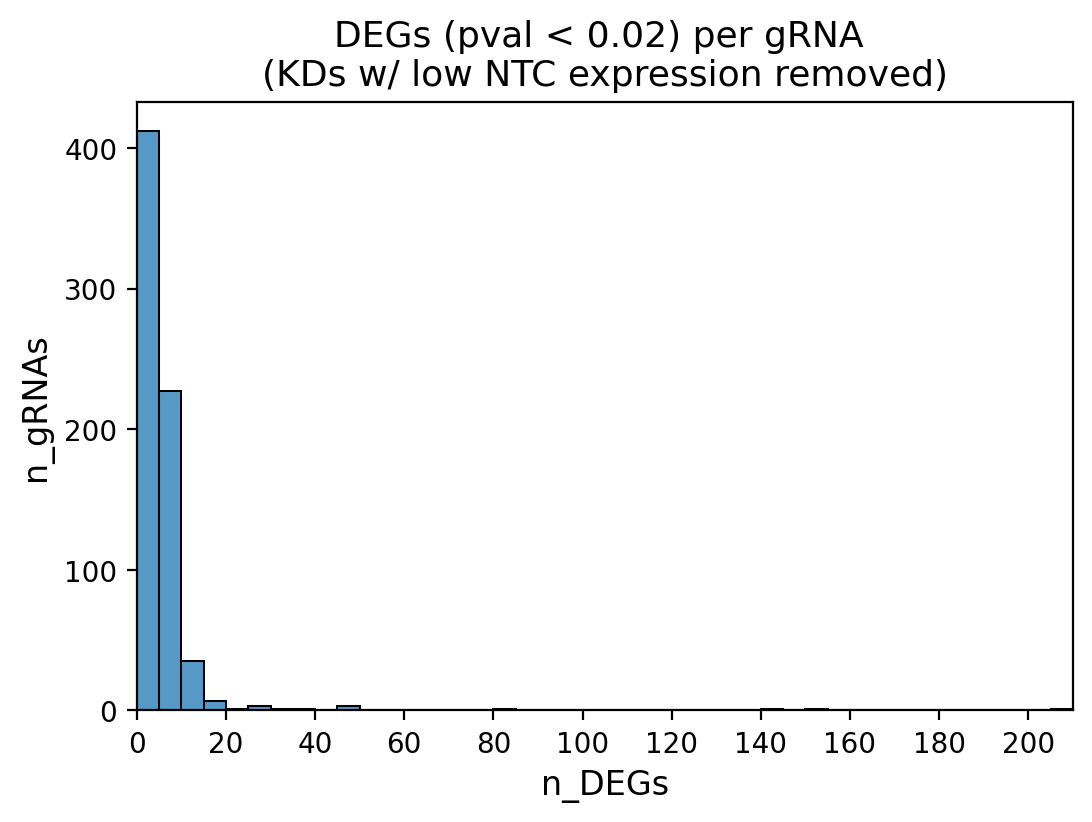

In [82]:
_ = plot_DEGs_per_KD_histogram(gRNA_kds_filt_de_n_degs_df, title="DEGs (pval < 0.02) per gRNA \n(KDs w/ low NTC expression removed)", 
                           bin_width=5, xtick_width=20, fig_size=(6,4), xlabel="n_DEGs", ylabel="n_gRNAs")

Filter KD gRNAs that don't have more DEGs than NTC threshold

In [14]:
gRNAs_to_rm = gRNA_kds_filt_de_n_degs_df[gRNA_kds_filt_de_n_degs_df['n_DEGs'] <= 4].index.tolist()
print(len(gRNAs_to_rm))

412


In [26]:
adata_kds_gRNAs_filt = adata_kds_filt[~adata_kds_filt.obs.gRNA.isin(gRNAs_to_rm)].copy()

In [27]:
print(f"{adata_kds_gRNAs_filt[adata_kds_gRNAs_filt.obs.perturbed == 'True'].obs.gRNA.nunique()} gRNAs remaining")
print(f"{adata_kds_gRNAs_filt.obs.gene_target.nunique() - 1} gene targets remaining")

282 gRNAs remaining
236 gene targets remaining


Gene target level DGE analysis

In [28]:
gene_target_filt_de_results_dict = \
    matched_differential_expression(adata_kds_gRNAs_filt, DE_fit_type="mean", target_column="gene_target", 
                                    suppress_warnings=True, n_cpus_for_DE=3, n_jobs_parallel=25)

Running DE analysis:   0%|          | 0/236 [00:00<?, ?it/s]

In [29]:
gene_target_filt_de_results_df = build_DE_df(gene_target_filt_de_results_dict)
gene_target_filt_de_results_df.head()

ZNF14_baseMean  ZNF14_log2FoldChange  ZNF14_lfcSE  ZNF14_stat  \
A1BG             1.864257              0.735923     1.183907    0.621605   
A1BG-AS1         0.373367             -2.185059     2.632794   -0.829939   
A2M              0.512672             -1.215384     2.016206   -0.602808   
A2ML1            0.891141             -0.921585     1.899375   -0.485204   
A2ML1-AS1        2.926793              0.183335     1.204626    0.152192   

           ZNF14_pvalue  ZNF14_padj  IRF9_baseMean  IRF9_log2FoldChange  \
A1BG           0.534201    0.999792       7.844469             0.819880   
A1BG-AS1       0.406573    0.999792       1.464278             0.936418   
A2M            0.546637    0.999792       1.133736            -0.470961   
A2ML1          0.627531    0.999792       4.891521             0.323112   
A2ML1-AS1      0.879035    0.999792       7.738637            -0.240985   

           IRF9_lfcSE  IRF9_stat  ...  TBPL1_lfcSE  TBPL1_stat  TBPL1_pvalue  \
A1BG         0.702847   1.166513  ...     1.289011    0.156928      0.875302   
A1BG-AS1     1.182967   0.791584  ...     2.663477    0.596046      0.551144   
A2M          1.378991  -0.341526  ...     1.755692    1.117027      0.263983   
A2ML1        0.738855   0.437314  ...     2.045348    0.305428      0.760040   
A2ML1-AS1    0.566234  -0.425592  ...     1.092031    0.573533      0.566284   

           TBPL1_padj  NANOGP8_baseMean  NANOGP8_log2FoldChange  \
A1BG         0.998861          0.647072               -1.376164   
A1BG-AS1     0.998861          0.506852                2.576163   
A2M          0.998861          0.143634               -0.824429   
A2ML1        0.998861          0.497277                1.022751   
A2ML1-AS1    0.998861          1.794077                0.407724   

           NANOGP8_lfcSE  NANOGP8_stat  NANOGP8_pvalue  NANOGP8_padj  
A1BG            2.098237     -0.655867        0.511910      0.986184  
A1BG-AS1        2.833321      0.909238        0.363225      0.986184  
A2M             4.024826     -0.204836        0.837700      0.986184  
A2ML1           2.640913      0.387272        0.698555      0.986184  
A2ML1-AS1       1.124996      0.362422        0.717037      0.986184  

[5 rows x 1416 columns]

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_matched_gene_target_kd_ntc_expr_filt_2-4-26.pkl"
gene_target_filt_de_results_df.to_pickle(filepath_pkl)

In [32]:
gene_target_filt_n_degs_df = build_n_DEGs_df(gene_target_filt_de_results_df, alpha=0.02, 
                                             threshold_type="pvalue", target_type="gene_target")
gene_target_filt_n_degs_df.head()

n_DEGs
ADNP2         52
ARHGAP35      22
ARID2          7
ARID3B         9
ARNT2          5

In [40]:
gene_target_filt_n_degs_df.sort_values(by="n_DEGs", ascending=False, inplace=True)
gene_target_filt_n_degs_df.head(10)

n_DEGs
POU5F1      429
POU5F1B     208
PHF20       140
DNMT1       127
ZNF521       81
NANOG        65
ADNP2        52
CHAMP1       46
THAP12       45
PRDM14       43

In [34]:
print(f"Mean DEGs for 236 gene targets: {round(np.mean(gene_target_filt_n_degs_df['n_DEGs']))}")
print(f"Median DEGs for 236 gene targets: {round(np.median(gene_target_filt_n_degs_df['n_DEGs']))}")

Mean DEGs for 236 gene targets: 13
Median DEGs for 236 gene targets: 7


In [43]:
print(f"{len(gene_target_filt_n_degs_df[gene_target_filt_n_degs_df['n_DEGs'] >= 7])}" 
      f" TF KDs have >=7 DEGs")
print(f"{len(gene_target_filt_n_degs_df[gene_target_filt_n_degs_df['n_DEGs'] >= 10])}" 
      f" TF KDs have >=10 DEGs")

119 TF KDs have >=7 DEGs
56 TF KDs have >=10 DEGs


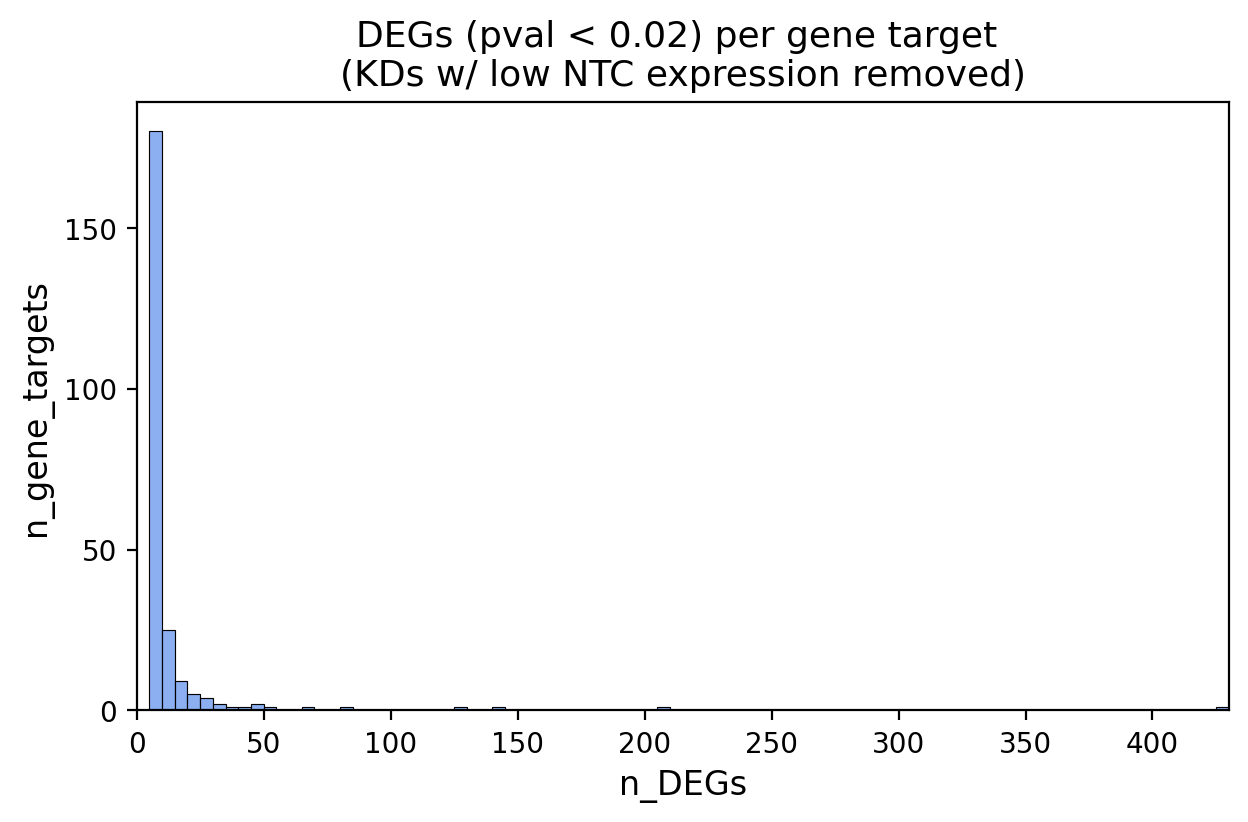

In [49]:
plot_DEGs_per_KD_histogram(gene_target_filt_n_degs_df, 
                           title="DEGs (pval < 0.02) per gene target \n(KDs w/ low NTC expression removed)", 
                           bin_width=5, xtick_width=50, fig_size=(7,4),
                           xlabel="n_DEGs", ylabel="n_gene_targets", color="cornflowerblue")

In [38]:
degs_mde_features = filter_DEGs(gene_target_filt_de_results_df, p_threshold=0.02, lfc_threshold=0.25)
print(len(degs_mde_features))

2106


In [44]:
gene_targets_median_degs = \
    gene_target_filt_n_degs_df[gene_target_filt_n_degs_df["n_DEGs"] >= 7].index.tolist()
print(len(gene_targets_median_degs))

119


In [ ]:
def filter_DEGs(DE_results_df, p_threshold=0.05, p_threshold_type="pvalue", lfc_threshold=0.25,
                    target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    if target_type == "gRNA":
        targets = {"_".join(col.split("_")[:2]) for col in DE_results_df.columns}
    else:
        targets = {col.split("_")[0] for col in DE_results_df.columns}

    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in targets:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [45]:
def filter_perturbations_filter_DEGs(DE_results_df: pd.DataFrame, perts_to_keep: list[str], 
                                     p_threshold=0.05, p_threshold_type="pvalue",
                                     lfc_threshold=0.25, target_type="gene_target"):
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'gRNA' or 'gene_target")
    if (p_threshold_type != "pvalue") & (p_threshold_type != "padj"):
        raise ValueError("p_threshold_type must be 'pvalue' or 'padj'")
    # Get genes where |L2FC| > lfc_threshold and p < p_threshold
    DEGs = set()
    for target in perts_to_keep:
        l2fc_col = f"{target}_log2FoldChange"
        p_col = f"{target}_{p_threshold_type}"
        DEGs.update(DE_results_df.loc[(abs(DE_results_df[l2fc_col]) > lfc_threshold) 
                                   & (DE_results_df[p_col] < p_threshold)].index)
    return DEGs

In [46]:
degs_median = filter_perturbations_filter_DEGs(gene_target_filt_de_results_df, gene_targets_median_degs,
                                               p_threshold=0.02, lfc_threshold=0.25)
print(len(degs_median))

1676


In [76]:
adata_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_DGE_Filtered.h5ad"
adata_kds_gRNAs_filt.write_h5ad(adata_filepath)